# Imports

In [1]:
#!pip install catboost

In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns
import math

# Read diamonds

In [3]:
diamonds_train_sorted = pd.read_csv('../data/diamonds_train_sorted.csv')
diamonds_train_sorted.head()

price  carat  cut  color  clarity  depth  table     x     y     z
0    326   0.21    4      1        2   59.8   61.0  3.89  3.84  2.31
1    326   0.23    0      1        1   61.5   55.0  3.95  3.98  2.43
2    327   0.23    1      1        4   56.9   65.0  4.05  4.07  2.31
3    334   0.29    4      5        3   62.4   58.0  4.20  4.23  2.63
4    335   0.31    1      6        1   63.3   58.0  4.34  4.35  2.75

# Feature engineering

In [4]:
#diamonds_train_sorted['table_xy'] = (diamonds_train_sorted['table'].mean()*(diamonds_train_sorted['x']*diamonds_train_sorted['y']).mean()-diamonds_train_sorted['table']*(diamonds_train_sorted['x']*diamonds_train_sorted['y']))
#diamonds_train_sorted['depth_z'] = (diamonds_train_sorted['depth'].mean()*diamonds_train_sorted['z'].mean()-diamonds_train_sorted['depth']*diamonds_train_sorted['z'])
diamonds_train_sorted['volume'] = diamonds_train_sorted['x']*diamonds_train_sorted['y']*diamonds_train_sorted['z']
#diamonds_train_sorted['super_feature'] = diamonds_train_sorted['carat'] / diamonds_train_sorted['table'] * diamonds_train_sorted['depth']
#diamonds_train_sorted['super_feature'] = (2*diamonds_train_sorted['z'])/(diamonds_train_sorted['x']+diamonds_train_sorted['y'])
diamonds_train_sorted['dtc'] = diamonds_train_sorted['depth'] / diamonds_train_sorted['table'] * diamonds_train_sorted['carat']
diamonds_train_sorted['ratio_length_width'] = diamonds_train_sorted['x']/diamonds_train_sorted['y']
diamonds_train_sorted.head()

price  carat  cut  color  clarity  depth  table     x     y     z  \
0    326   0.21    4      1        2   59.8   61.0  3.89  3.84  2.31   
1    326   0.23    0      1        1   61.5   55.0  3.95  3.98  2.43   
2    327   0.23    1      1        4   56.9   65.0  4.05  4.07  2.31   
3    334   0.29    4      5        3   62.4   58.0  4.20  4.23  2.63   
4    335   0.31    1      6        1   63.3   58.0  4.34  4.35  2.75   

      volume       dtc  ratio_length_width  
0  34.505856  0.205869            1.013021  
1  38.202030  0.257182            0.992462  
2  38.076885  0.201338            0.995086  
3  46.724580  0.312000            0.992908  
4  51.917250  0.338328            0.997701

In [5]:
"""
carat_log= []
for i in diamonds_train_sorted['carat']:
    carat_log.append(math.log(i))
diamonds_train_sorted['carat_log'] = carat_log
diamonds_train_sorted.head()
"""

"\ncarat_log= []\nfor i in diamonds_train_sorted['carat']:\n    carat_log.append(math.log(i))\ndiamonds_train_sorted['carat_log'] = carat_log\ndiamonds_train_sorted.head()\n"

# Create diamond shape

In [6]:
"""
shape = []
for i in diamonds_train_sorted['table'].index:
    if 54<diamonds_train_sorted['table'][i]<57 and 61<diamonds_train_sorted['depth'][i]<62.5:
        shape.append('Round')
    elif 52<diamonds_train_sorted['table'][i]<60 and 60<diamonds_train_sorted['depth'][i]<68:
        shape.append('Oval')
    elif 63<diamonds_train_sorted['table'][i]<69 and 69<diamonds_train_sorted['depth'][i]<76:
        shape.append('Princess')
    elif 58<diamonds_train_sorted['table'][i]<63 and 58<diamonds_train_sorted['depth'][i]<66:
        shape.append('Cushion')
    else:
        shape.append('others')
"""

"\nshape = []\nfor i in diamonds_train_sorted['table'].index:\n    if 54<diamonds_train_sorted['table'][i]<57 and 61<diamonds_train_sorted['depth'][i]<62.5:\n        shape.append('Round')\n    elif 52<diamonds_train_sorted['table'][i]<60 and 60<diamonds_train_sorted['depth'][i]<68:\n        shape.append('Oval')\n    elif 63<diamonds_train_sorted['table'][i]<69 and 69<diamonds_train_sorted['depth'][i]<76:\n        shape.append('Princess')\n    elif 58<diamonds_train_sorted['table'][i]<63 and 58<diamonds_train_sorted['depth'][i]<66:\n        shape.append('Cushion')\n    else:\n        shape.append('others')\n"

In [7]:
"""
diamonds_train_sorted['shape'] = shape
diamonds_train_sorted.head()
"""

"\ndiamonds_train_sorted['shape'] = shape\ndiamonds_train_sorted.head()\n"

# Shape label encoding 

In [8]:
"""
diamonds_train_sorted['shape']=diamonds_train_sorted['shape'].map({'Round':4, 'Oval': 1, 
                                                'Princess': 3, 'Cushion':2, 'others':0})
diamonds_train_sorted.head()
"""

"\ndiamonds_train_sorted['shape']=diamonds_train_sorted['shape'].map({'Round':4, 'Oval': 1, \n                                                'Princess': 3, 'Cushion':2, 'others':0})\ndiamonds_train_sorted.head()\n"

# Correlation

<Axes: >

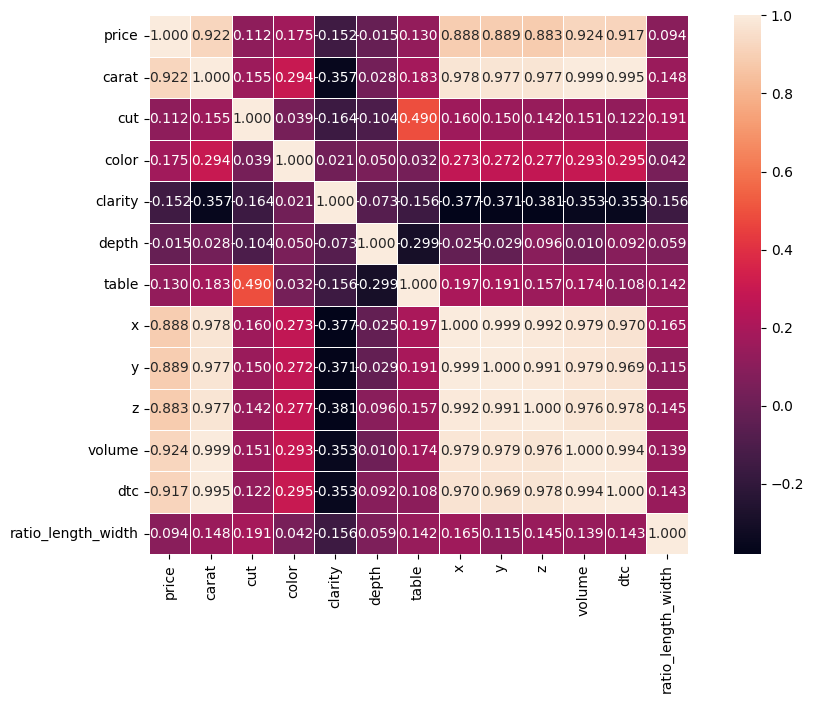

In [9]:
plt.subplots(figsize = (12, 7))
corr = diamonds_train_sorted.corr()
sns.heatmap(data = corr, annot = True, fmt = ".3f", cbar = True, linewidth = .5, 
            annot_kws = {'fontsize':10, 'fontweight':'regular'}, square = True)

# Model train split

In [10]:
X = diamonds_train_sorted[['cut',
                           'color', 
                           'clarity',
                           'volume',
                           'dtc',
                           'ratio_length_width']]

y = diamonds_train_sorted['price']

In [11]:
# Train + test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")

X_train: (32344, 6), X_test: (8087, 6), y_train: (32344,), y_test: (8087,)
X_train: <class 'pandas.core.frame.DataFrame'>, X_test: <class 'pandas.core.frame.DataFrame'>, y_train: <class 'pandas.core.series.Series'>, y_test: <class 'pandas.core.series.Series'>


# Scaling standard

In [12]:
scaler = StandardScaler()
scaling_X_train = scaler.fit_transform(X_train)
scaling_X_test = scaler.fit_transform(X_test)
scaled_X_train = pd.DataFrame(scaling_X_train)
scaled_X_train

0         1         2         3         4         5
0     -1.079199 -1.525028 -1.247176 -0.196510 -0.200938  0.738975
1     -1.079199 -0.348679 -0.034476  0.183474  0.300467  0.848708
2     -1.079199 -0.348679 -1.247176 -0.113495 -0.071865 -0.614824
3     -1.079199  1.415846 -0.034476  0.696844  0.742740  1.090109
4     -1.079199  1.415846 -0.640826 -0.221025 -0.214096 -0.287288
...         ...       ...       ...       ...       ...       ...
32339 -1.079199  0.827671 -0.034476 -0.807036 -0.782526 -0.552688
32340  0.681014 -1.525028  0.571875 -0.812558 -0.826445 -0.757544
32341 -1.079199 -0.348679 -0.034476  1.460694  1.439847  1.256654
32342 -0.492461  0.827671  1.178225 -1.138519 -1.126592 -0.901252
32343 -1.079199 -1.525028  0.571875 -0.710340 -0.672706 -0.535450

[32344 rows x 6 columns]

In [13]:
scaled_X_test = pd.DataFrame(scaling_X_test)
scaled_X_test

0         1         2         3         4         5
0     0.678990 -0.365174 -1.231160  0.661880  0.408863 -0.900736
1    -0.491298  0.806947 -1.231160  2.557378  2.699019 -1.182893
2     1.264135 -0.365174 -1.231160  0.248668  0.125457  1.089467
3    -1.076443 -0.365174  1.811003 -0.822884 -0.778526 -0.716158
4    -1.076443  0.220887  1.202570  1.530715  1.660239  0.813013
...        ...       ...       ...       ...       ...       ...
8082  0.678990  0.220887 -0.014295 -0.205129 -0.283454 -0.913413
8083  0.678990 -0.951234 -0.622727 -0.810418 -0.854177 -1.644907
8084  1.264135  1.393008  0.594138  0.988914  0.847058 -0.865277
8085 -1.076443  0.220887  0.594138  0.523298  0.484585 -0.368235
8086 -0.491298 -0.951234 -0.622727  0.249021  0.295880 -0.243049

[8087 rows x 6 columns]

# Train model CatBoost

In [14]:
# rf model train
train_dataset = cb.Pool(scaled_X_train, y_train) 
test_dataset = cb.Pool(scaled_X_test, y_test)

In [15]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [16]:
grid = {'iterations': [100, 150, 500],
        'learning_rate': [0.03, 0.1, 0.3],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 5459.4696859	test: 5508.7877440	best: 5508.7877440 (0)	total: 141ms	remaining: 13.9s
1:	learn: 5319.6527118	test: 5369.8149470	best: 5369.8149470 (1)	total: 144ms	remaining: 7.04s
2:	learn: 5182.3540439	test: 5232.5848392	best: 5232.5848392 (2)	total: 146ms	remaining: 4.73s
3:	learn: 5048.0063745	test: 5098.8172546	best: 5098.8172546 (3)	total: 149ms	remaining: 3.56s
4:	learn: 4916.6191141	test: 4967.6224242	best: 4967.6224242 (4)	total: 151ms	remaining: 2.87s
5:	learn: 4789.8295113	test: 4840.2925854	best: 4840.2925854 (5)	total: 153ms	remaining: 2.4s
6:	learn: 4667.1527490	test: 4717.8019337	best: 4717.8019337 (6)	total: 155ms	remaining: 2.06s
7:	learn: 4548.8414863	test: 4599.7664322	best: 4599.7664322 (7)	total: 158ms	remaining: 1.81s
8:	learn: 4432.9726647	test: 4483.8137989	best: 4483.8137989 (8)	total: 160ms	remaining: 1.61s
9:	learn: 4320.7134866	test: 4371.8102248	best: 4371.8102248 (9)	total: 162ms	remaining: 1.46s
10:	learn: 4212.4261800	test: 4263.9263717	best: 42

43:	learn: 1105.8893140	test: 1187.2673390	best: 1187.2673390 (43)	total: 119ms	remaining: 151ms
44:	learn: 1094.6180247	test: 1174.2166421	best: 1174.2166421 (44)	total: 121ms	remaining: 148ms
45:	learn: 1086.0107775	test: 1165.9519268	best: 1165.9519268 (45)	total: 123ms	remaining: 145ms
46:	learn: 1077.5004450	test: 1157.2144734	best: 1157.2144734 (46)	total: 126ms	remaining: 142ms
47:	learn: 1069.8358401	test: 1149.7505412	best: 1149.7505412 (47)	total: 129ms	remaining: 140ms
48:	learn: 1060.5440123	test: 1139.5167596	best: 1139.5167596 (48)	total: 132ms	remaining: 138ms
49:	learn: 1053.8672344	test: 1132.4013688	best: 1132.4013688 (49)	total: 135ms	remaining: 135ms
50:	learn: 1043.6988073	test: 1121.1881336	best: 1121.1881336 (50)	total: 138ms	remaining: 132ms
51:	learn: 1036.6564942	test: 1114.2019274	best: 1114.2019274 (51)	total: 142ms	remaining: 131ms
52:	learn: 1030.3398439	test: 1107.9653917	best: 1107.9653917 (52)	total: 147ms	remaining: 131ms
53:	learn: 1024.7564266	test: 

97:	learn: 701.6105542	test: 751.9819046	best: 751.9819046 (97)	total: 235ms	remaining: 4.8ms
98:	learn: 698.4789970	test: 749.9953842	best: 749.9953842 (98)	total: 238ms	remaining: 2.4ms
99:	learn: 696.2847279	test: 746.5011074	best: 746.5011074 (99)	total: 240ms	remaining: 0us

bestTest = 746.5011074
bestIteration = 99

2:	loss: 746.5011074	best: 746.5011074 (2)	total: 1.03s	remaining: 48.2s
0:	learn: 5459.4820869	test: 5508.7993311	best: 5508.7993311 (0)	total: 3.82ms	remaining: 378ms
1:	learn: 5319.6756517	test: 5369.8370322	best: 5369.8370322 (1)	total: 6.98ms	remaining: 342ms
2:	learn: 5182.3925237	test: 5232.6225082	best: 5232.6225082 (2)	total: 10.9ms	remaining: 352ms
3:	learn: 5048.0551060	test: 5098.8651468	best: 5098.8651468 (3)	total: 14.7ms	remaining: 352ms
4:	learn: 4916.6761919	test: 4967.6786826	best: 4967.6786826 (4)	total: 17.2ms	remaining: 328ms
5:	learn: 4789.8949849	test: 4840.3572938	best: 4840.3572938 (5)	total: 19.7ms	remaining: 309ms
6:	learn: 4667.2253961	test

69:	learn: 925.0259027	test: 998.1908229	best: 998.1908229 (69)	total: 154ms	remaining: 66ms
70:	learn: 917.7334042	test: 989.4694042	best: 989.4694042 (70)	total: 156ms	remaining: 63.9ms
71:	learn: 913.7580566	test: 985.3455060	best: 985.3455060 (71)	total: 158ms	remaining: 61.6ms
72:	learn: 908.4947564	test: 979.3475516	best: 979.3475516 (72)	total: 160ms	remaining: 59.3ms
73:	learn: 905.4357709	test: 976.4676135	best: 976.4676135 (73)	total: 162ms	remaining: 57ms
74:	learn: 901.0400512	test: 971.6334957	best: 971.6334957 (74)	total: 165ms	remaining: 54.8ms
75:	learn: 898.3534228	test: 968.8431720	best: 968.8431720 (75)	total: 166ms	remaining: 52.6ms
76:	learn: 894.8104420	test: 964.6431421	best: 964.6431421 (76)	total: 169ms	remaining: 50.3ms
77:	learn: 891.9524199	test: 962.1534290	best: 962.1534290 (77)	total: 172ms	remaining: 48.4ms
78:	learn: 889.0280421	test: 959.7134378	best: 959.7134378 (78)	total: 175ms	remaining: 46.5ms
79:	learn: 885.5629126	test: 955.7628748	best: 955.762

54:	learn: 773.3430919	test: 829.0885076	best: 829.0885076 (54)	total: 117ms	remaining: 95.8ms
55:	learn: 771.3328307	test: 826.6476427	best: 826.6476427 (55)	total: 119ms	remaining: 93.7ms
56:	learn: 768.7972468	test: 824.1086828	best: 824.1086828 (56)	total: 122ms	remaining: 91.9ms
57:	learn: 768.0699396	test: 823.7853119	best: 823.7853119 (57)	total: 124ms	remaining: 89.7ms
58:	learn: 765.0651917	test: 821.0633023	best: 821.0633023 (58)	total: 126ms	remaining: 87.6ms
59:	learn: 764.4321378	test: 820.4974208	best: 820.4974208 (59)	total: 128ms	remaining: 85.4ms
60:	learn: 762.2024382	test: 818.5966554	best: 818.5966554 (60)	total: 130ms	remaining: 83.3ms
61:	learn: 758.6702626	test: 814.8707545	best: 814.8707545 (61)	total: 133ms	remaining: 81.3ms
62:	learn: 757.8883142	test: 813.8146681	best: 813.8146681 (62)	total: 135ms	remaining: 79.1ms
63:	learn: 755.0992434	test: 810.0602171	best: 810.0602171 (63)	total: 137ms	remaining: 76.9ms
64:	learn: 750.3053519	test: 805.4532618	best: 805

19:	learn: 1604.6654996	test: 1688.1800354	best: 1688.1800354 (19)	total: 47.3ms	remaining: 189ms
20:	learn: 1564.1833596	test: 1650.3823765	best: 1650.3823765 (20)	total: 49.8ms	remaining: 187ms
21:	learn: 1524.8034119	test: 1609.6648374	best: 1609.6648374 (21)	total: 51.7ms	remaining: 183ms
22:	learn: 1492.8319900	test: 1577.8463440	best: 1577.8463440 (22)	total: 53.6ms	remaining: 179ms
23:	learn: 1455.1011081	test: 1539.1895072	best: 1539.1895072 (23)	total: 56.5ms	remaining: 179ms
24:	learn: 1428.0692453	test: 1513.8030143	best: 1513.8030143 (24)	total: 58.9ms	remaining: 177ms
25:	learn: 1399.7069656	test: 1485.5112748	best: 1485.5112748 (25)	total: 61ms	remaining: 174ms
26:	learn: 1377.2264166	test: 1465.5405177	best: 1465.5405177 (26)	total: 63.3ms	remaining: 171ms
27:	learn: 1348.7384014	test: 1435.5600830	best: 1435.5600830 (27)	total: 66.5ms	remaining: 171ms
28:	learn: 1327.4568561	test: 1413.7139838	best: 1413.7139838 (28)	total: 68.5ms	remaining: 168ms
29:	learn: 1308.051202

5:	learn: 1636.7122435	test: 1717.4116947	best: 1717.4116947 (5)	total: 14ms	remaining: 219ms
6:	learn: 1518.7254848	test: 1607.4088235	best: 1607.4088235 (6)	total: 16.7ms	remaining: 222ms
7:	learn: 1413.4696890	test: 1498.1645724	best: 1498.1645724 (7)	total: 18.7ms	remaining: 216ms
8:	learn: 1348.5910078	test: 1432.0435874	best: 1432.0435874 (8)	total: 20.9ms	remaining: 212ms
9:	learn: 1296.2713439	test: 1378.3145934	best: 1378.3145934 (9)	total: 22.9ms	remaining: 206ms
10:	learn: 1231.1770577	test: 1306.5252271	best: 1306.5252271 (10)	total: 24.8ms	remaining: 201ms
11:	learn: 1190.4015466	test: 1262.2175818	best: 1262.2175818 (11)	total: 27ms	remaining: 198ms
12:	learn: 1151.1476032	test: 1225.8886185	best: 1225.8886185 (12)	total: 29.2ms	remaining: 196ms
13:	learn: 1111.5898837	test: 1180.3600842	best: 1180.3600842 (13)	total: 31.3ms	remaining: 192ms
14:	learn: 1085.3589414	test: 1154.9789266	best: 1154.9789266 (14)	total: 33.2ms	remaining: 188ms
15:	learn: 1062.4053917	test: 1131

93:	learn: 702.4915076	test: 752.3058263	best: 752.3058263 (93)	total: 206ms	remaining: 13.2ms
94:	learn: 700.9603290	test: 750.7246468	best: 750.7246468 (94)	total: 209ms	remaining: 11ms
95:	learn: 700.3846734	test: 750.4683266	best: 750.4683266 (95)	total: 211ms	remaining: 8.79ms
96:	learn: 699.4478832	test: 749.5877847	best: 749.5877847 (96)	total: 213ms	remaining: 6.59ms
97:	learn: 698.1366601	test: 748.1950538	best: 748.1950538 (97)	total: 215ms	remaining: 4.39ms
98:	learn: 697.9142877	test: 748.0085949	best: 748.0085949 (98)	total: 217ms	remaining: 2.19ms
99:	learn: 697.6136413	test: 747.5947264	best: 747.5947264 (99)	total: 220ms	remaining: 0us

bestTest = 747.5947264
bestIteration = 99

8:	loss: 747.5947264	best: 746.5011074 (2)	total: 2.49s	remaining: 37.3s
0:	learn: 5459.5803301	test: 5508.8958119	best: 5508.8958119 (0)	total: 2.95ms	remaining: 292ms
1:	learn: 5319.8622401	test: 5370.0212857	best: 5370.0212857 (1)	total: 5.17ms	remaining: 254ms
2:	learn: 5182.7086511	test: 52

82:	learn: 1454.3402149	test: 1538.5546403	best: 1538.5546403 (82)	total: 183ms	remaining: 37.5ms
83:	learn: 1443.6595371	test: 1527.5944190	best: 1527.5944190 (83)	total: 185ms	remaining: 35.3ms
84:	learn: 1436.1752438	test: 1520.5915742	best: 1520.5915742 (84)	total: 188ms	remaining: 33.1ms
85:	learn: 1426.3889403	test: 1510.5505781	best: 1510.5505781 (85)	total: 189ms	remaining: 30.8ms
86:	learn: 1419.0399171	test: 1503.2691995	best: 1503.2691995 (86)	total: 191ms	remaining: 28.6ms
87:	learn: 1410.7574049	test: 1494.8974993	best: 1494.8974993 (87)	total: 193ms	remaining: 26.4ms
88:	learn: 1401.6240038	test: 1485.6706976	best: 1485.6706976 (88)	total: 195ms	remaining: 24.2ms
89:	learn: 1392.4381257	test: 1476.3620511	best: 1476.3620511 (89)	total: 197ms	remaining: 21.9ms
90:	learn: 1385.6777602	test: 1470.1234869	best: 1470.1234869 (90)	total: 199ms	remaining: 19.7ms
91:	learn: 1378.8017611	test: 1463.4779098	best: 1463.4779098 (91)	total: 201ms	remaining: 17.5ms
92:	learn: 1372.4058

69:	learn: 931.2566441	test: 1002.4830903	best: 1002.4830903 (69)	total: 155ms	remaining: 66.3ms
70:	learn: 924.0347575	test: 993.8587038	best: 993.8587038 (70)	total: 157ms	remaining: 64.2ms
71:	learn: 919.8470642	test: 989.1098732	best: 989.1098732 (71)	total: 159ms	remaining: 62ms
72:	learn: 915.7965984	test: 984.7708810	best: 984.7708810 (72)	total: 161ms	remaining: 59.7ms
73:	learn: 912.4681088	test: 981.3331792	best: 981.3331792 (73)	total: 163ms	remaining: 57.4ms
74:	learn: 908.9104803	test: 978.3026749	best: 978.3026749 (74)	total: 166ms	remaining: 55.2ms
75:	learn: 904.7691122	test: 974.0473989	best: 974.0473989 (75)	total: 167ms	remaining: 52.9ms
76:	learn: 901.5809811	test: 970.5939227	best: 970.5939227 (76)	total: 170ms	remaining: 50.8ms
77:	learn: 898.6959317	test: 967.7135635	best: 967.7135635 (77)	total: 172ms	remaining: 48.5ms
78:	learn: 895.3051220	test: 964.3803551	best: 964.3803551 (78)	total: 174ms	remaining: 46.3ms
79:	learn: 892.6186684	test: 961.5813679	best: 961

57:	learn: 764.5136247	test: 818.1579758	best: 818.1579758 (57)	total: 122ms	remaining: 88.5ms
58:	learn: 763.8646674	test: 817.5816058	best: 817.5816058 (58)	total: 125ms	remaining: 86.6ms
59:	learn: 762.9719818	test: 816.7912853	best: 816.7912853 (59)	total: 127ms	remaining: 84.5ms
60:	learn: 761.0344710	test: 814.7396171	best: 814.7396171 (60)	total: 129ms	remaining: 82.5ms
61:	learn: 759.6171164	test: 814.2122553	best: 814.2122553 (61)	total: 131ms	remaining: 80.3ms
62:	learn: 757.0732505	test: 811.8447544	best: 811.8447544 (62)	total: 133ms	remaining: 78.1ms
63:	learn: 751.9278745	test: 805.6043656	best: 805.6043656 (63)	total: 135ms	remaining: 76ms
64:	learn: 750.2751059	test: 803.3358009	best: 803.3358009 (64)	total: 137ms	remaining: 74ms
65:	learn: 747.8872481	test: 801.3279361	best: 801.3279361 (65)	total: 139ms	remaining: 71.8ms
66:	learn: 746.1265727	test: 798.0657039	best: 798.0657039 (66)	total: 141ms	remaining: 69.7ms
67:	learn: 744.8694272	test: 798.0899583	best: 798.065

43:	learn: 2132.3408372	test: 2198.3145329	best: 2198.3145329 (43)	total: 96.7ms	remaining: 233ms
44:	learn: 2099.8783045	test: 2166.9750433	best: 2166.9750433 (44)	total: 99.2ms	remaining: 231ms
45:	learn: 2069.6631799	test: 2137.1605024	best: 2137.1605024 (45)	total: 102ms	remaining: 230ms
46:	learn: 2040.6619284	test: 2108.7269073	best: 2108.7269073 (46)	total: 104ms	remaining: 227ms
47:	learn: 2011.7975743	test: 2080.8512720	best: 2080.8512720 (47)	total: 106ms	remaining: 225ms
48:	learn: 1985.7364241	test: 2055.1020023	best: 2055.1020023 (48)	total: 108ms	remaining: 222ms
49:	learn: 1959.5714585	test: 2029.6013170	best: 2029.6013170 (49)	total: 110ms	remaining: 220ms
50:	learn: 1934.4746241	test: 2004.9342716	best: 2004.9342716 (50)	total: 112ms	remaining: 218ms
51:	learn: 1910.7349931	test: 1981.6329493	best: 1981.6329493 (51)	total: 115ms	remaining: 216ms
52:	learn: 1886.5440707	test: 1958.3438048	best: 1958.3438048 (52)	total: 117ms	remaining: 214ms
53:	learn: 1865.2095880	test

132:	learn: 1162.3874461	test: 1244.2192893	best: 1244.2192893 (132)	total: 288ms	remaining: 36.9ms
133:	learn: 1159.1517216	test: 1241.3376289	best: 1241.3376289 (133)	total: 291ms	remaining: 34.7ms
134:	learn: 1155.8591673	test: 1237.8432097	best: 1237.8432097 (134)	total: 293ms	remaining: 32.5ms
135:	learn: 1151.1889052	test: 1232.7317101	best: 1232.7317101 (135)	total: 295ms	remaining: 30.3ms
136:	learn: 1148.0263748	test: 1229.7205157	best: 1229.7205157 (136)	total: 297ms	remaining: 28.2ms
137:	learn: 1143.6563048	test: 1224.9684903	best: 1224.9684903 (137)	total: 299ms	remaining: 26ms
138:	learn: 1140.4708607	test: 1222.0406659	best: 1222.0406659 (138)	total: 301ms	remaining: 23.8ms
139:	learn: 1137.4585737	test: 1219.1582786	best: 1219.1582786 (139)	total: 303ms	remaining: 21.6ms
140:	learn: 1133.2773492	test: 1214.5934395	best: 1214.5934395 (140)	total: 305ms	remaining: 19.5ms
141:	learn: 1130.4325369	test: 1212.0680382	best: 1212.0680382 (141)	total: 307ms	remaining: 17.3ms
14

70:	learn: 923.0626936	test: 995.4917181	best: 995.4917181 (70)	total: 151ms	remaining: 168ms
71:	learn: 918.2944163	test: 990.1930258	best: 990.1930258 (71)	total: 154ms	remaining: 167ms
72:	learn: 912.2585255	test: 983.4569276	best: 983.4569276 (72)	total: 156ms	remaining: 164ms
73:	learn: 909.0144107	test: 980.6683217	best: 980.6683217 (73)	total: 158ms	remaining: 162ms
74:	learn: 905.9736532	test: 978.1460258	best: 978.1460258 (74)	total: 160ms	remaining: 160ms
75:	learn: 903.1269368	test: 975.4429581	best: 975.4429581 (75)	total: 162ms	remaining: 158ms
76:	learn: 899.7898152	test: 971.8475873	best: 971.8475873 (76)	total: 164ms	remaining: 155ms
77:	learn: 897.2398714	test: 969.2562842	best: 969.2562842 (77)	total: 166ms	remaining: 153ms
78:	learn: 894.3985773	test: 966.8468223	best: 966.8468223 (78)	total: 168ms	remaining: 151ms
79:	learn: 890.7596933	test: 962.7064727	best: 962.7064727 (79)	total: 170ms	remaining: 149ms
80:	learn: 887.0102420	test: 959.0395993	best: 959.0395993 (

12:	learn: 1150.8841639	test: 1225.5793054	best: 1225.5793054 (12)	total: 28.6ms	remaining: 302ms
13:	learn: 1111.3175868	test: 1180.0430338	best: 1180.0430338 (13)	total: 31.3ms	remaining: 304ms
14:	learn: 1085.0781968	test: 1154.6518087	best: 1154.6518087 (14)	total: 33.3ms	remaining: 300ms
15:	learn: 1062.1072498	test: 1131.4016250	best: 1131.4016250 (15)	total: 35.2ms	remaining: 294ms
16:	learn: 1040.1028791	test: 1107.7969068	best: 1107.7969068 (16)	total: 37.3ms	remaining: 292ms
17:	learn: 1011.0956410	test: 1076.6071567	best: 1076.6071567 (17)	total: 39.5ms	remaining: 289ms
18:	learn: 991.7456073	test: 1057.0703695	best: 1057.0703695 (18)	total: 41.8ms	remaining: 288ms
19:	learn: 978.2477343	test: 1044.1145338	best: 1044.1145338 (19)	total: 44.6ms	remaining: 290ms
20:	learn: 961.1553603	test: 1024.8372708	best: 1024.8372708 (20)	total: 46.7ms	remaining: 287ms
21:	learn: 947.8793585	test: 1013.7146864	best: 1013.7146864 (21)	total: 48.6ms	remaining: 283ms
22:	learn: 936.3368574	t

103:	learn: 693.1004991	test: 743.2693402	best: 743.2693402 (103)	total: 222ms	remaining: 98.4ms
104:	learn: 692.3228460	test: 742.6449923	best: 742.6449923 (104)	total: 225ms	remaining: 96.5ms
105:	learn: 690.8783689	test: 741.4213021	best: 741.4213021 (105)	total: 227ms	remaining: 94.3ms
106:	learn: 690.2048349	test: 740.7801876	best: 740.7801876 (106)	total: 230ms	remaining: 92.3ms
107:	learn: 689.1851892	test: 739.7871207	best: 739.7871207 (107)	total: 232ms	remaining: 90.2ms
108:	learn: 688.7591701	test: 739.0035030	best: 739.0035030 (108)	total: 235ms	remaining: 88.5ms
109:	learn: 687.9733848	test: 737.7785946	best: 737.7785946 (109)	total: 238ms	remaining: 86.7ms
110:	learn: 686.1459184	test: 736.0678049	best: 736.0678049 (110)	total: 240ms	remaining: 84.5ms
111:	learn: 685.3783855	test: 735.4638205	best: 735.4638205 (111)	total: 243ms	remaining: 82.4ms
112:	learn: 684.1621051	test: 734.5463302	best: 734.5463302 (112)	total: 245ms	remaining: 80.3ms
113:	learn: 683.6169401	test: 

109:	learn: 1265.1064806	test: 1349.5401378	best: 1349.5401378 (109)	total: 266ms	remaining: 96.8ms
110:	learn: 1260.0816416	test: 1344.2917607	best: 1344.2917607 (110)	total: 269ms	remaining: 94.4ms
111:	learn: 1254.5880505	test: 1338.6952737	best: 1338.6952737 (111)	total: 271ms	remaining: 91.8ms
112:	learn: 1248.0248131	test: 1331.6306342	best: 1331.6306342 (112)	total: 273ms	remaining: 89.2ms
113:	learn: 1243.5724462	test: 1327.1819115	best: 1327.1819115 (113)	total: 275ms	remaining: 86.7ms
114:	learn: 1238.9685884	test: 1322.5067993	best: 1322.5067993 (114)	total: 276ms	remaining: 84.1ms
115:	learn: 1234.6265443	test: 1318.3709708	best: 1318.3709708 (115)	total: 278ms	remaining: 81.6ms
116:	learn: 1230.1466616	test: 1313.7558593	best: 1313.7558593 (116)	total: 280ms	remaining: 79ms
117:	learn: 1224.3921425	test: 1307.5260872	best: 1307.5260872 (117)	total: 282ms	remaining: 76.5ms
118:	learn: 1218.8808751	test: 1301.6026431	best: 1301.6026431 (118)	total: 284ms	remaining: 74.1ms
11

42:	learn: 1115.1513678	test: 1196.3267324	best: 1196.3267324 (42)	total: 96.8ms	remaining: 241ms
43:	learn: 1105.9851561	test: 1187.3764819	best: 1187.3764819 (43)	total: 99.1ms	remaining: 239ms
44:	learn: 1094.7144829	test: 1174.3264581	best: 1174.3264581 (44)	total: 101ms	remaining: 236ms
45:	learn: 1086.1059686	test: 1166.0608208	best: 1166.0608208 (45)	total: 103ms	remaining: 233ms
46:	learn: 1075.8607909	test: 1154.9454919	best: 1154.9454919 (46)	total: 105ms	remaining: 230ms
47:	learn: 1067.8683733	test: 1146.5932504	best: 1146.5932504 (47)	total: 107ms	remaining: 227ms
48:	learn: 1060.3124851	test: 1138.8934860	best: 1138.8934860 (48)	total: 109ms	remaining: 225ms
49:	learn: 1053.7364005	test: 1131.9053740	best: 1131.9053740 (49)	total: 111ms	remaining: 223ms
50:	learn: 1043.5457979	test: 1120.6789691	best: 1120.6789691 (50)	total: 114ms	remaining: 221ms
51:	learn: 1036.8705355	test: 1114.0825218	best: 1114.0825218 (51)	total: 116ms	remaining: 219ms
52:	learn: 1031.1174035	test

134:	learn: 778.7219329	test: 838.0971242	best: 838.0971242 (134)	total: 290ms	remaining: 32.2ms
135:	learn: 777.9718138	test: 837.3045034	best: 837.3045034 (135)	total: 292ms	remaining: 30.1ms
136:	learn: 777.4873594	test: 836.7182607	best: 836.7182607 (136)	total: 294ms	remaining: 27.9ms
137:	learn: 776.4169207	test: 836.3722653	best: 836.3722653 (137)	total: 296ms	remaining: 25.8ms
138:	learn: 775.2614046	test: 835.3467827	best: 835.3467827 (138)	total: 298ms	remaining: 23.6ms
139:	learn: 773.5278407	test: 832.9030296	best: 832.9030296 (139)	total: 300ms	remaining: 21.4ms
140:	learn: 772.7493525	test: 832.2110801	best: 832.2110801 (140)	total: 302ms	remaining: 19.3ms
141:	learn: 772.2810857	test: 831.7247991	best: 831.7247991 (141)	total: 304ms	remaining: 17.1ms
142:	learn: 771.1331011	test: 830.4877950	best: 830.4877950 (142)	total: 306ms	remaining: 15ms
143:	learn: 769.9960399	test: 828.9368359	best: 828.9368359 (143)	total: 308ms	remaining: 12.8ms
144:	learn: 768.3031180	test: 82

73:	learn: 731.6007180	test: 783.2189302	best: 783.2189302 (73)	total: 156ms	remaining: 160ms
74:	learn: 730.3359477	test: 781.6690499	best: 781.6690499 (74)	total: 158ms	remaining: 158ms
75:	learn: 729.3875139	test: 782.0183092	best: 781.6690499 (74)	total: 160ms	remaining: 156ms
76:	learn: 726.0810443	test: 777.0348666	best: 777.0348666 (76)	total: 162ms	remaining: 154ms
77:	learn: 724.3995809	test: 775.5950511	best: 775.5950511 (77)	total: 164ms	remaining: 151ms
78:	learn: 723.6863335	test: 775.2557857	best: 775.2557857 (78)	total: 166ms	remaining: 149ms
79:	learn: 722.5090148	test: 774.1315154	best: 774.1315154 (79)	total: 168ms	remaining: 147ms
80:	learn: 722.1252991	test: 773.8012695	best: 773.8012695 (80)	total: 170ms	remaining: 145ms
81:	learn: 719.1755077	test: 771.4068703	best: 771.4068703 (81)	total: 172ms	remaining: 143ms
82:	learn: 718.2362180	test: 769.8373848	best: 769.8373848 (82)	total: 175ms	remaining: 141ms
83:	learn: 716.6142830	test: 767.9048718	best: 767.9048718 (

14:	learn: 3818.4936576	test: 3871.3793234	best: 3871.3793234 (14)	total: 34.2ms	remaining: 308ms
15:	learn: 3729.8722549	test: 3784.2008383	best: 3784.2008383 (15)	total: 36.6ms	remaining: 306ms
16:	learn: 3640.6203981	test: 3695.5814479	best: 3695.5814479 (16)	total: 40.1ms	remaining: 313ms
17:	learn: 3556.4588160	test: 3611.8250409	best: 3611.8250409 (17)	total: 43.9ms	remaining: 322ms
18:	learn: 3473.9521062	test: 3528.8504232	best: 3528.8504232 (18)	total: 47.3ms	remaining: 326ms
19:	learn: 3393.8319343	test: 3448.8787367	best: 3448.8787367 (19)	total: 49.9ms	remaining: 324ms
20:	learn: 3316.9782032	test: 3372.0772447	best: 3372.0772447 (20)	total: 52.6ms	remaining: 323ms
21:	learn: 3243.7257070	test: 3299.8745355	best: 3299.8745355 (21)	total: 55ms	remaining: 320ms
22:	learn: 3172.0137974	test: 3228.4656704	best: 3228.4656704 (22)	total: 57.2ms	remaining: 316ms
23:	learn: 3102.4516895	test: 3159.2848100	best: 3159.2848100 (23)	total: 60ms	remaining: 315ms
24:	learn: 3036.6179486	

35:	learn: 1206.6140753	test: 1291.8095463	best: 1291.8095463 (35)	total: 79.2ms	remaining: 251ms
36:	learn: 1194.0205147	test: 1279.1899605	best: 1279.1899605 (36)	total: 81.8ms	remaining: 250ms
37:	learn: 1182.8905430	test: 1268.5111107	best: 1268.5111107 (37)	total: 83.7ms	remaining: 247ms
38:	learn: 1166.5444661	test: 1251.0843756	best: 1251.0843756 (38)	total: 85.6ms	remaining: 244ms
39:	learn: 1150.8399620	test: 1234.0110413	best: 1234.0110413 (39)	total: 87.6ms	remaining: 241ms
40:	learn: 1140.2500606	test: 1222.5159811	best: 1222.5159811 (40)	total: 89.5ms	remaining: 238ms
41:	learn: 1128.9288856	test: 1211.3416114	best: 1211.3416114 (41)	total: 91.4ms	remaining: 235ms
42:	learn: 1115.3134522	test: 1196.5071815	best: 1196.5071815 (42)	total: 93.6ms	remaining: 233ms
43:	learn: 1106.1484301	test: 1187.5579578	best: 1187.5579578 (43)	total: 96.1ms	remaining: 231ms
44:	learn: 1094.8787458	test: 1174.5090284	best: 1174.5090284 (44)	total: 98.7ms	remaining: 230ms
45:	learn: 1086.2681

34:	learn: 840.4803441	test: 900.7640376	best: 900.7640376 (34)	total: 101ms	remaining: 331ms
35:	learn: 835.0109389	test: 896.1956346	best: 896.1956346 (35)	total: 103ms	remaining: 326ms
36:	learn: 828.4961185	test: 888.1890968	best: 888.1890968 (36)	total: 105ms	remaining: 321ms
37:	learn: 824.3602445	test: 883.8075584	best: 883.8075584 (37)	total: 107ms	remaining: 316ms
38:	learn: 820.4129014	test: 879.9735012	best: 879.9735012 (38)	total: 110ms	remaining: 313ms
39:	learn: 817.8334234	test: 877.3464383	best: 877.3464383 (39)	total: 112ms	remaining: 309ms
40:	learn: 815.2431860	test: 874.5257445	best: 874.5257445 (40)	total: 114ms	remaining: 304ms
41:	learn: 810.2086718	test: 867.4514178	best: 867.4514178 (41)	total: 116ms	remaining: 299ms
42:	learn: 806.3837650	test: 864.0639186	best: 864.0639186 (42)	total: 118ms	remaining: 295ms
43:	learn: 803.8923357	test: 861.3843508	best: 861.3843508 (43)	total: 121ms	remaining: 291ms
44:	learn: 802.1700819	test: 859.9948484	best: 859.9948484 (

34:	learn: 2486.5255592	test: 2547.2345508	best: 2547.2345508 (34)	total: 104ms	remaining: 341ms
35:	learn: 2440.3922613	test: 2501.4770360	best: 2501.4770360 (35)	total: 107ms	remaining: 339ms
36:	learn: 2395.7003200	test: 2457.6662702	best: 2457.6662702 (36)	total: 110ms	remaining: 335ms
37:	learn: 2352.9090775	test: 2415.8161761	best: 2415.8161761 (37)	total: 113ms	remaining: 332ms
38:	learn: 2312.6500138	test: 2375.9995198	best: 2375.9995198 (38)	total: 115ms	remaining: 328ms
39:	learn: 2272.6491923	test: 2337.1158129	best: 2337.1158129 (39)	total: 118ms	remaining: 324ms
40:	learn: 2236.1154372	test: 2300.7233565	best: 2300.7233565 (40)	total: 123ms	remaining: 326ms
41:	learn: 2200.4165691	test: 2265.5329626	best: 2265.5329626 (41)	total: 126ms	remaining: 324ms
42:	learn: 2166.4823375	test: 2231.8659362	best: 2231.8659362 (42)	total: 128ms	remaining: 320ms
43:	learn: 2133.5091680	test: 2199.4415339	best: 2199.4415339 (43)	total: 133ms	remaining: 321ms
44:	learn: 2101.0407618	test: 

46:	learn: 1083.3131711	test: 1160.7426350	best: 1160.7426350 (46)	total: 102ms	remaining: 223ms
47:	learn: 1073.7102418	test: 1150.4434424	best: 1150.4434424 (47)	total: 104ms	remaining: 221ms
48:	learn: 1067.1019555	test: 1144.1800981	best: 1144.1800981 (48)	total: 107ms	remaining: 221ms
49:	learn: 1059.9777930	test: 1136.7640287	best: 1136.7640287 (49)	total: 109ms	remaining: 218ms
50:	learn: 1049.8436776	test: 1125.5923068	best: 1125.5923068 (50)	total: 112ms	remaining: 217ms
51:	learn: 1042.9390410	test: 1118.7352103	best: 1118.7352103 (51)	total: 114ms	remaining: 215ms
52:	learn: 1037.3436978	test: 1114.1988113	best: 1114.1988113 (52)	total: 116ms	remaining: 213ms
53:	learn: 1024.0847976	test: 1100.2984284	best: 1100.2984284 (53)	total: 119ms	remaining: 211ms
54:	learn: 1016.2904121	test: 1091.3948235	best: 1091.3948235 (54)	total: 121ms	remaining: 210ms
55:	learn: 1009.6782649	test: 1084.1131934	best: 1084.1131934 (55)	total: 124ms	remaining: 208ms
56:	learn: 1004.5519515	test: 

133:	learn: 781.8673695	test: 839.7699214	best: 839.7699214 (133)	total: 298ms	remaining: 35.6ms
134:	learn: 780.3467396	test: 837.4378423	best: 837.4378423 (134)	total: 300ms	remaining: 33.4ms
135:	learn: 779.8252901	test: 836.6537930	best: 836.6537930 (135)	total: 303ms	remaining: 31.1ms
136:	learn: 779.2664787	test: 835.9747374	best: 835.9747374 (136)	total: 305ms	remaining: 28.9ms
137:	learn: 777.9981580	test: 835.3353075	best: 835.3353075 (137)	total: 307ms	remaining: 26.7ms
138:	learn: 776.9889388	test: 834.2936733	best: 834.2936733 (138)	total: 309ms	remaining: 24.4ms
139:	learn: 775.9091847	test: 833.2523958	best: 833.2523958 (139)	total: 311ms	remaining: 22.2ms
140:	learn: 775.4088201	test: 832.6699585	best: 832.6699585 (140)	total: 314ms	remaining: 20ms
141:	learn: 774.5652785	test: 831.8821140	best: 831.8821140 (141)	total: 316ms	remaining: 17.8ms
142:	learn: 772.1112197	test: 829.0148830	best: 829.0148830 (142)	total: 318ms	remaining: 15.6ms
143:	learn: 771.0790176	test: 82

142:	learn: 675.7277046	test: 726.1391904	best: 726.1391904 (142)	total: 360ms	remaining: 17.6ms
143:	learn: 675.5225391	test: 726.2429397	best: 726.1391904 (142)	total: 363ms	remaining: 15.1ms
144:	learn: 674.4440093	test: 725.2530983	best: 725.2530983 (144)	total: 365ms	remaining: 12.6ms
145:	learn: 673.5811353	test: 724.6302145	best: 724.6302145 (145)	total: 367ms	remaining: 10.1ms
146:	learn: 672.8971423	test: 723.9064542	best: 723.9064542 (146)	total: 370ms	remaining: 7.55ms
147:	learn: 672.5781740	test: 723.6865861	best: 723.6865861 (147)	total: 372ms	remaining: 5.03ms
148:	learn: 672.0861399	test: 723.4056682	best: 723.4056682 (148)	total: 375ms	remaining: 2.51ms
149:	learn: 671.8795702	test: 723.0301953	best: 723.0301953 (149)	total: 377ms	remaining: 0us

bestTest = 723.0301953
bestIteration = 149

23:	loss: 723.0301953	best: 715.8190672 (14)	total: 7.63s	remaining: 38.1s
0:	learn: 5459.4696859	test: 5508.7877440	best: 5508.7877440 (0)	total: 2.32ms	remaining: 1.16s
1:	learn: 5

141:	learn: 1130.4325369	test: 1212.0680382	best: 1212.0680382 (141)	total: 382ms	remaining: 963ms
142:	learn: 1127.0987952	test: 1208.6803998	best: 1208.6803998 (142)	total: 385ms	remaining: 961ms
143:	learn: 1122.7993167	test: 1203.9997821	best: 1203.9997821 (143)	total: 387ms	remaining: 957ms
144:	learn: 1119.7680320	test: 1200.8995144	best: 1200.8995144 (144)	total: 389ms	remaining: 953ms
145:	learn: 1115.7009110	test: 1196.4693804	best: 1196.4693804 (145)	total: 391ms	remaining: 949ms
146:	learn: 1111.8436208	test: 1192.2308998	best: 1192.2308998 (146)	total: 393ms	remaining: 944ms
147:	learn: 1108.9862719	test: 1189.2788541	best: 1189.2788541 (147)	total: 395ms	remaining: 940ms
148:	learn: 1106.3144190	test: 1186.9075183	best: 1186.9075183 (148)	total: 398ms	remaining: 936ms
149:	learn: 1103.7260882	test: 1184.1170780	best: 1184.1170780 (149)	total: 400ms	remaining: 933ms
150:	learn: 1101.1207963	test: 1181.6364901	best: 1181.6364901 (150)	total: 402ms	remaining: 929ms
151:	learn

285:	learn: 869.0654039	test: 939.6653447	best: 939.6653447 (285)	total: 781ms	remaining: 585ms
286:	learn: 868.3328484	test: 939.0550262	best: 939.0550262 (286)	total: 783ms	remaining: 581ms
287:	learn: 867.3365344	test: 937.7834041	best: 937.7834041 (287)	total: 785ms	remaining: 578ms
288:	learn: 866.4603577	test: 936.8827393	best: 936.8827393 (288)	total: 787ms	remaining: 575ms
289:	learn: 865.5409588	test: 935.6563118	best: 935.6563118 (289)	total: 789ms	remaining: 571ms
290:	learn: 864.8364812	test: 935.0669158	best: 935.0669158 (290)	total: 791ms	remaining: 568ms
291:	learn: 864.2115402	test: 934.6275707	best: 934.6275707 (291)	total: 793ms	remaining: 565ms
292:	learn: 863.2610396	test: 933.6600726	best: 933.6600726 (292)	total: 795ms	remaining: 561ms
293:	learn: 862.3492709	test: 932.5438130	best: 932.5438130 (293)	total: 797ms	remaining: 558ms
294:	learn: 861.5681911	test: 931.7105426	best: 931.7105426 (294)	total: 798ms	remaining: 555ms
295:	learn: 860.9477572	test: 931.146300

375:	learn: 808.3286013	test: 871.7797062	best: 871.7797062 (375)	total: 979ms	remaining: 323ms
376:	learn: 807.8380380	test: 871.3427291	best: 871.3427291 (376)	total: 981ms	remaining: 320ms
377:	learn: 807.2678596	test: 870.6124742	best: 870.6124742 (377)	total: 983ms	remaining: 317ms
378:	learn: 806.5680310	test: 869.6652131	best: 869.6652131 (378)	total: 985ms	remaining: 315ms
379:	learn: 805.9540942	test: 868.9038329	best: 868.9038329 (379)	total: 987ms	remaining: 312ms
380:	learn: 805.6434294	test: 868.6082250	best: 868.6082250 (380)	total: 989ms	remaining: 309ms
381:	learn: 805.2389473	test: 868.1905994	best: 868.1905994 (381)	total: 991ms	remaining: 306ms
382:	learn: 804.9408562	test: 867.9063709	best: 867.9063709 (382)	total: 993ms	remaining: 303ms
383:	learn: 804.2974355	test: 867.2297388	best: 867.2297388 (383)	total: 996ms	remaining: 301ms
384:	learn: 803.9016876	test: 866.8610785	best: 866.8610785 (384)	total: 999ms	remaining: 298ms
385:	learn: 803.6046205	test: 866.512250

44:	learn: 1094.6180247	test: 1174.2166421	best: 1174.2166421 (44)	total: 115ms	remaining: 1.16s
45:	learn: 1086.0107775	test: 1165.9519268	best: 1165.9519268 (45)	total: 118ms	remaining: 1.16s
46:	learn: 1077.5004450	test: 1157.2144734	best: 1157.2144734 (46)	total: 120ms	remaining: 1.15s
47:	learn: 1069.8358401	test: 1149.7505412	best: 1149.7505412 (47)	total: 122ms	remaining: 1.15s
48:	learn: 1060.5440123	test: 1139.5167596	best: 1139.5167596 (48)	total: 124ms	remaining: 1.14s
49:	learn: 1053.8672344	test: 1132.4013688	best: 1132.4013688 (49)	total: 126ms	remaining: 1.13s
50:	learn: 1043.6988073	test: 1121.1881336	best: 1121.1881336 (50)	total: 128ms	remaining: 1.13s
51:	learn: 1036.6564942	test: 1114.2019274	best: 1114.2019274 (51)	total: 130ms	remaining: 1.12s
52:	learn: 1030.3398439	test: 1107.9653917	best: 1107.9653917 (52)	total: 132ms	remaining: 1.12s
53:	learn: 1024.7564266	test: 1102.7463142	best: 1102.7463142 (53)	total: 134ms	remaining: 1.11s
54:	learn: 1016.4190012	test: 

208:	learn: 723.3670731	test: 779.8537421	best: 779.8537421 (208)	total: 518ms	remaining: 722ms
209:	learn: 723.2020431	test: 779.6633470	best: 779.6633470 (209)	total: 521ms	remaining: 719ms
210:	learn: 722.5095703	test: 778.4630446	best: 778.4630446 (210)	total: 523ms	remaining: 716ms
211:	learn: 722.1543690	test: 778.1030113	best: 778.1030113 (211)	total: 525ms	remaining: 713ms
212:	learn: 721.1199972	test: 776.7858825	best: 776.7858825 (212)	total: 527ms	remaining: 710ms
213:	learn: 720.9070826	test: 776.5577898	best: 776.5577898 (213)	total: 529ms	remaining: 707ms
214:	learn: 720.2816185	test: 775.9411555	best: 775.9411555 (214)	total: 531ms	remaining: 704ms
215:	learn: 720.0433924	test: 775.6802018	best: 775.6802018 (215)	total: 533ms	remaining: 701ms
216:	learn: 719.8020004	test: 775.5767980	best: 775.5767980 (216)	total: 535ms	remaining: 698ms
217:	learn: 718.8784856	test: 774.6859254	best: 774.6859254 (217)	total: 538ms	remaining: 696ms
218:	learn: 718.6571732	test: 774.631840

379:	learn: 667.5886505	test: 719.1985704	best: 719.1985704 (379)	total: 921ms	remaining: 291ms
380:	learn: 667.2900658	test: 718.9514090	best: 718.9514090 (380)	total: 923ms	remaining: 288ms
381:	learn: 667.0977380	test: 718.8350800	best: 718.8350800 (381)	total: 925ms	remaining: 286ms
382:	learn: 666.9246190	test: 719.0908024	best: 718.8350800 (381)	total: 927ms	remaining: 283ms
383:	learn: 666.8540548	test: 718.9697720	best: 718.8350800 (381)	total: 929ms	remaining: 281ms
384:	learn: 666.3994352	test: 718.5305728	best: 718.5305728 (384)	total: 932ms	remaining: 278ms
385:	learn: 666.1211170	test: 718.4362427	best: 718.4362427 (385)	total: 934ms	remaining: 276ms
386:	learn: 665.9528486	test: 718.3292221	best: 718.3292221 (386)	total: 936ms	remaining: 273ms
387:	learn: 665.5404795	test: 717.9012210	best: 717.9012210 (387)	total: 939ms	remaining: 271ms
388:	learn: 665.2885764	test: 717.3652587	best: 717.3652587 (388)	total: 942ms	remaining: 269ms
389:	learn: 665.1583169	test: 717.209006

40:	learn: 816.1836759	test: 876.3641542	best: 876.3641542 (40)	total: 106ms	remaining: 1.18s
41:	learn: 812.8754828	test: 873.3823158	best: 873.3823158 (41)	total: 108ms	remaining: 1.18s
42:	learn: 807.2429091	test: 866.4659136	best: 866.4659136 (42)	total: 110ms	remaining: 1.17s
43:	learn: 805.3165709	test: 864.5225298	best: 864.5225298 (43)	total: 112ms	remaining: 1.16s
44:	learn: 803.6543705	test: 862.6493542	best: 862.6493542 (44)	total: 114ms	remaining: 1.16s
45:	learn: 800.9899295	test: 861.9727701	best: 861.9727701 (45)	total: 117ms	remaining: 1.15s
46:	learn: 796.3151121	test: 857.2758679	best: 857.2758679 (46)	total: 119ms	remaining: 1.15s
47:	learn: 793.4431411	test: 854.4068727	best: 854.4068727 (47)	total: 122ms	remaining: 1.15s
48:	learn: 787.0659466	test: 845.1799905	best: 845.1799905 (48)	total: 124ms	remaining: 1.14s
49:	learn: 784.3227179	test: 841.4073617	best: 841.4073617 (49)	total: 126ms	remaining: 1.14s
50:	learn: 781.1433866	test: 836.9002431	best: 836.9002431 (

204:	learn: 638.6616385	test: 693.0739157	best: 693.0739157 (204)	total: 509ms	remaining: 732ms
205:	learn: 638.5101954	test: 692.9614946	best: 692.9614946 (205)	total: 512ms	remaining: 730ms
206:	learn: 638.1813365	test: 692.7001367	best: 692.7001367 (206)	total: 514ms	remaining: 727ms
207:	learn: 638.0038096	test: 692.5405372	best: 692.5405372 (207)	total: 516ms	remaining: 724ms
208:	learn: 637.6879385	test: 692.2158400	best: 692.2158400 (208)	total: 518ms	remaining: 721ms
209:	learn: 637.5305158	test: 691.9089743	best: 691.9089743 (209)	total: 520ms	remaining: 718ms
210:	learn: 637.4178143	test: 691.9594555	best: 691.9089743 (209)	total: 523ms	remaining: 717ms
211:	learn: 630.8392791	test: 685.4049431	best: 685.4049431 (211)	total: 526ms	remaining: 714ms
212:	learn: 630.6527864	test: 685.3491449	best: 685.3491449 (212)	total: 528ms	remaining: 712ms
213:	learn: 630.3910345	test: 685.0582598	best: 685.0582598 (213)	total: 531ms	remaining: 709ms
214:	learn: 629.9377542	test: 684.749171

339:	learn: 598.6057177	test: 660.0655265	best: 659.9336817 (337)	total: 914ms	remaining: 430ms
340:	learn: 598.5003858	test: 660.0215956	best: 659.9336817 (337)	total: 917ms	remaining: 428ms
341:	learn: 598.4399615	test: 659.8903105	best: 659.8903105 (341)	total: 919ms	remaining: 425ms
342:	learn: 598.2564328	test: 659.7543814	best: 659.7543814 (342)	total: 922ms	remaining: 422ms
343:	learn: 598.1055258	test: 659.6562485	best: 659.6562485 (343)	total: 924ms	remaining: 419ms
344:	learn: 597.9618597	test: 659.5494585	best: 659.5494585 (344)	total: 926ms	remaining: 416ms
345:	learn: 597.8604934	test: 659.5076779	best: 659.5076779 (345)	total: 929ms	remaining: 413ms
346:	learn: 597.7055923	test: 659.3099049	best: 659.3099049 (346)	total: 933ms	remaining: 411ms
347:	learn: 597.6518524	test: 659.1616203	best: 659.1616203 (347)	total: 935ms	remaining: 409ms
348:	learn: 597.4485326	test: 659.0180860	best: 659.0180860 (348)	total: 940ms	remaining: 407ms
349:	learn: 597.2983873	test: 659.337258

496:	learn: 584.6534231	test: 651.4053485	best: 651.4053485 (496)	total: 1.31s	remaining: 7.94ms
497:	learn: 584.5888217	test: 651.5376443	best: 651.4053485 (496)	total: 1.32s	remaining: 5.29ms
498:	learn: 584.5172438	test: 651.3527759	best: 651.3527759 (498)	total: 1.32s	remaining: 2.65ms
499:	learn: 584.4450724	test: 651.3169963	best: 651.3169963 (499)	total: 1.32s	remaining: 0us

bestTest = 651.3169963
bestIteration = 499

26:	loss: 651.3169963	best: 651.3169963 (26)	total: 11.6s	remaining: 50.2s
0:	learn: 5459.4820869	test: 5508.7993311	best: 5508.7993311 (0)	total: 2.8ms	remaining: 1.4s
1:	learn: 5319.6756517	test: 5369.8370322	best: 5369.8370322 (1)	total: 4.73ms	remaining: 1.18s
2:	learn: 5182.3925237	test: 5232.6225082	best: 5232.6225082 (2)	total: 6.85ms	remaining: 1.14s
3:	learn: 5048.0551060	test: 5098.8651468	best: 5098.8651468 (3)	total: 8.85ms	remaining: 1.1s
4:	learn: 4916.6761919	test: 4967.6786826	best: 4967.6786826 (4)	total: 11.2ms	remaining: 1.11s
5:	learn: 4789.894

82:	learn: 1451.9446351	test: 1535.8197803	best: 1535.8197803 (82)	total: 192ms	remaining: 963ms
83:	learn: 1441.7052894	test: 1525.2863976	best: 1525.2863976 (83)	total: 195ms	remaining: 964ms
84:	learn: 1433.8785231	test: 1517.9510590	best: 1517.9510590 (84)	total: 196ms	remaining: 959ms
85:	learn: 1426.0277793	test: 1510.3780191	best: 1510.3780191 (85)	total: 198ms	remaining: 955ms
86:	learn: 1417.0792883	test: 1501.2177493	best: 1501.2177493 (86)	total: 200ms	remaining: 951ms
87:	learn: 1407.5111667	test: 1491.3370720	best: 1491.3370720 (87)	total: 203ms	remaining: 949ms
88:	learn: 1400.4338829	test: 1484.5933986	best: 1484.5933986 (88)	total: 205ms	remaining: 945ms
89:	learn: 1391.3050580	test: 1475.3208743	best: 1475.3208743 (89)	total: 207ms	remaining: 942ms
90:	learn: 1384.5334001	test: 1469.0623801	best: 1469.0623801 (90)	total: 210ms	remaining: 944ms
91:	learn: 1377.4261997	test: 1461.8292039	best: 1461.8292039 (91)	total: 213ms	remaining: 945ms
92:	learn: 1371.0144230	test: 

177:	learn: 1030.1273716	test: 1107.2616547	best: 1107.2616547 (177)	total: 397ms	remaining: 719ms
178:	learn: 1026.9557456	test: 1103.7486735	best: 1103.7486735 (178)	total: 400ms	remaining: 717ms
179:	learn: 1025.1223612	test: 1101.7743076	best: 1101.7743076 (179)	total: 402ms	remaining: 715ms
180:	learn: 1023.4308260	test: 1100.1916848	best: 1100.1916848 (180)	total: 404ms	remaining: 712ms
181:	learn: 1020.0924904	test: 1096.6459740	best: 1096.6459740 (181)	total: 406ms	remaining: 709ms
182:	learn: 1018.2371274	test: 1094.8087943	best: 1094.8087943 (182)	total: 408ms	remaining: 707ms
183:	learn: 1016.4023141	test: 1093.0324604	best: 1093.0324604 (183)	total: 410ms	remaining: 704ms
184:	learn: 1013.2532571	test: 1089.6737769	best: 1089.6737769 (184)	total: 412ms	remaining: 701ms
185:	learn: 1011.2994660	test: 1087.6967734	best: 1087.6967734 (185)	total: 414ms	remaining: 699ms
186:	learn: 1008.6528843	test: 1084.7826294	best: 1084.7826294 (186)	total: 416ms	remaining: 697ms
187:	learn

264:	learn: 889.9336533	test: 961.4852079	best: 961.4852079 (264)	total: 599ms	remaining: 531ms
265:	learn: 888.9394949	test: 960.1256670	best: 960.1256670 (265)	total: 602ms	remaining: 529ms
266:	learn: 888.0877828	test: 959.3180592	best: 959.3180592 (266)	total: 604ms	remaining: 527ms
267:	learn: 887.2419322	test: 958.5100278	best: 958.5100278 (267)	total: 606ms	remaining: 525ms
268:	learn: 886.4340191	test: 957.8513205	best: 957.8513205 (268)	total: 608ms	remaining: 522ms
269:	learn: 885.6563352	test: 957.1510781	best: 957.1510781 (269)	total: 610ms	remaining: 520ms
270:	learn: 884.3998352	test: 955.7622101	best: 955.7622101 (270)	total: 613ms	remaining: 518ms
271:	learn: 882.6517462	test: 953.6152239	best: 953.6152239 (271)	total: 615ms	remaining: 515ms
272:	learn: 881.5395730	test: 952.3073994	best: 952.3073994 (272)	total: 617ms	remaining: 513ms
273:	learn: 880.6343066	test: 951.4531877	best: 951.4531877 (273)	total: 619ms	remaining: 511ms
274:	learn: 879.6570934	test: 950.283820

443:	learn: 779.6778412	test: 839.2794210	best: 839.2794210 (443)	total: 1s	remaining: 127ms
444:	learn: 779.2443899	test: 838.8119379	best: 838.8119379 (444)	total: 1.01s	remaining: 125ms
445:	learn: 779.0057538	test: 838.5982686	best: 838.5982686 (445)	total: 1.01s	remaining: 122ms
446:	learn: 778.6324800	test: 838.2501868	best: 838.2501868 (446)	total: 1.01s	remaining: 120ms
447:	learn: 778.4529933	test: 837.9855767	best: 837.9855767 (447)	total: 1.01s	remaining: 118ms
448:	learn: 778.0331087	test: 837.5579638	best: 837.5579638 (448)	total: 1.01s	remaining: 115ms
449:	learn: 777.7370346	test: 837.2682718	best: 837.2682718 (449)	total: 1.02s	remaining: 113ms
450:	learn: 777.5563202	test: 837.0448473	best: 837.0448473 (450)	total: 1.02s	remaining: 111ms
451:	learn: 777.0081786	test: 836.2284486	best: 836.2284486 (451)	total: 1.02s	remaining: 109ms
452:	learn: 776.6497835	test: 835.7485373	best: 835.7485373 (452)	total: 1.02s	remaining: 106ms
453:	learn: 776.2466270	test: 835.3475775	b

114:	learn: 803.4752017	test: 865.9134771	best: 865.9134771 (114)	total: 267ms	remaining: 893ms
115:	learn: 802.4876375	test: 864.9727468	best: 864.9727468 (115)	total: 269ms	remaining: 891ms
116:	learn: 801.0709957	test: 863.5315452	best: 863.5315452 (116)	total: 271ms	remaining: 888ms
117:	learn: 799.0601463	test: 861.3834307	best: 861.3834307 (117)	total: 273ms	remaining: 884ms
118:	learn: 798.2933694	test: 860.5468002	best: 860.5468002 (118)	total: 275ms	remaining: 881ms
119:	learn: 796.1048144	test: 857.3328176	best: 857.3328176 (119)	total: 277ms	remaining: 877ms
120:	learn: 795.0053843	test: 856.3522635	best: 856.3522635 (120)	total: 279ms	remaining: 874ms
121:	learn: 794.1059606	test: 855.2807444	best: 855.2807444 (121)	total: 281ms	remaining: 871ms
122:	learn: 792.4465385	test: 853.6613294	best: 853.6613294 (122)	total: 284ms	remaining: 870ms
123:	learn: 791.1256221	test: 853.1545979	best: 853.1545979 (123)	total: 287ms	remaining: 869ms
124:	learn: 789.0653193	test: 850.308796

204:	learn: 723.9187144	test: 781.0594055	best: 781.0594055 (204)	total: 467ms	remaining: 673ms
205:	learn: 723.6787777	test: 780.9638900	best: 780.9638900 (205)	total: 470ms	remaining: 671ms
206:	learn: 723.4676675	test: 780.7436973	best: 780.7436973 (206)	total: 472ms	remaining: 668ms
207:	learn: 723.2000987	test: 780.4524836	best: 780.4524836 (207)	total: 474ms	remaining: 666ms
208:	learn: 722.4274465	test: 779.6955643	best: 779.6955643 (208)	total: 476ms	remaining: 663ms
209:	learn: 722.1398711	test: 779.5294412	best: 779.5294412 (209)	total: 479ms	remaining: 661ms
210:	learn: 721.1791693	test: 778.6091704	best: 778.6091704 (210)	total: 482ms	remaining: 660ms
211:	learn: 720.7991875	test: 778.1894941	best: 778.1894941 (211)	total: 484ms	remaining: 658ms
212:	learn: 720.6344887	test: 777.9926021	best: 777.9926021 (212)	total: 486ms	remaining: 655ms
213:	learn: 719.9709314	test: 776.8229277	best: 776.8229277 (213)	total: 488ms	remaining: 653ms
214:	learn: 719.7423833	test: 776.570576

364:	learn: 667.5329848	test: 720.4508478	best: 720.4508478 (364)	total: 866ms	remaining: 320ms
365:	learn: 667.0651414	test: 720.0004669	best: 720.0004669 (365)	total: 868ms	remaining: 318ms
366:	learn: 667.0093026	test: 719.9315709	best: 719.9315709 (366)	total: 870ms	remaining: 315ms
367:	learn: 666.7308496	test: 719.5412788	best: 719.5412788 (367)	total: 872ms	remaining: 313ms
368:	learn: 666.6335958	test: 719.4579786	best: 719.4579786 (368)	total: 874ms	remaining: 310ms
369:	learn: 666.3482445	test: 719.2593934	best: 719.2593934 (369)	total: 877ms	remaining: 308ms
370:	learn: 665.8723578	test: 718.7183108	best: 718.7183108 (370)	total: 879ms	remaining: 306ms
371:	learn: 665.6116453	test: 718.4713484	best: 718.4713484 (371)	total: 881ms	remaining: 303ms
372:	learn: 665.4585350	test: 718.3479512	best: 718.3479512 (372)	total: 883ms	remaining: 301ms
373:	learn: 665.2584654	test: 717.9862232	best: 717.9862232 (373)	total: 885ms	remaining: 298ms
374:	learn: 665.1779609	test: 717.841389

27:	learn: 887.0792063	test: 951.7595748	best: 951.7595748 (27)	total: 59.4ms	remaining: 1s
28:	learn: 880.5769213	test: 947.3459141	best: 947.3459141 (28)	total: 61.9ms	remaining: 1.01s
29:	learn: 871.3189895	test: 935.5580324	best: 935.5580324 (29)	total: 64ms	remaining: 1s
30:	learn: 864.1988710	test: 926.7004597	best: 926.7004597 (30)	total: 66.1ms	remaining: 1s
31:	learn: 856.2460860	test: 917.1654868	best: 917.1654868 (31)	total: 68.2ms	remaining: 997ms
32:	learn: 852.1825964	test: 913.3304762	best: 913.3304762 (32)	total: 70ms	remaining: 991ms
33:	learn: 846.2398675	test: 907.0529392	best: 907.0529392 (33)	total: 71.8ms	remaining: 985ms
34:	learn: 839.5025034	test: 900.4202263	best: 900.4202263 (34)	total: 73.8ms	remaining: 981ms
35:	learn: 833.9374630	test: 895.2642890	best: 895.2642890 (35)	total: 75.8ms	remaining: 977ms
36:	learn: 827.9978781	test: 888.8856048	best: 888.8856048 (36)	total: 77.8ms	remaining: 974ms
37:	learn: 824.7683119	test: 886.1797575	best: 886.1797575 (37)

118:	learn: 680.9812843	test: 733.2651911	best: 733.2651911 (118)	total: 259ms	remaining: 831ms
119:	learn: 680.6411179	test: 732.9285008	best: 732.9285008 (119)	total: 262ms	remaining: 830ms
120:	learn: 679.7042982	test: 732.1416434	best: 732.1416434 (120)	total: 264ms	remaining: 828ms
121:	learn: 679.5264181	test: 731.9529193	best: 731.9529193 (121)	total: 266ms	remaining: 825ms
122:	learn: 679.2402629	test: 731.6295061	best: 731.6295061 (122)	total: 268ms	remaining: 822ms
123:	learn: 678.6033049	test: 730.4225001	best: 730.4225001 (123)	total: 270ms	remaining: 819ms
124:	learn: 678.1470561	test: 730.1023554	best: 730.1023554 (124)	total: 272ms	remaining: 817ms
125:	learn: 676.4056604	test: 728.7047811	best: 728.7047811 (125)	total: 274ms	remaining: 815ms
126:	learn: 676.2495941	test: 728.6409421	best: 728.6409421 (126)	total: 277ms	remaining: 813ms
127:	learn: 675.7201197	test: 729.8538636	best: 728.6409421 (126)	total: 279ms	remaining: 810ms
128:	learn: 674.6599456	test: 728.833026

272:	learn: 609.8184250	test: 667.8436396	best: 667.8416774 (269)	total: 659ms	remaining: 548ms
273:	learn: 609.6732227	test: 667.8554085	best: 667.8416774 (269)	total: 662ms	remaining: 546ms
274:	learn: 609.3535232	test: 667.5520956	best: 667.5520956 (274)	total: 664ms	remaining: 543ms
275:	learn: 609.1785199	test: 668.2446463	best: 667.5520956 (274)	total: 666ms	remaining: 540ms
276:	learn: 608.9818923	test: 667.8578567	best: 667.5520956 (274)	total: 668ms	remaining: 538ms
277:	learn: 608.7468236	test: 667.3830292	best: 667.3830292 (277)	total: 670ms	remaining: 535ms
278:	learn: 608.6121193	test: 667.5704141	best: 667.3830292 (277)	total: 672ms	remaining: 532ms
279:	learn: 608.5394318	test: 667.5615318	best: 667.3830292 (277)	total: 675ms	remaining: 530ms
280:	learn: 608.4269061	test: 667.3760802	best: 667.3760802 (280)	total: 678ms	remaining: 528ms
281:	learn: 608.4020082	test: 667.3598084	best: 667.3598084 (281)	total: 681ms	remaining: 526ms
282:	learn: 608.3662486	test: 667.572274

364:	learn: 594.5790053	test: 655.7722114	best: 655.5991386 (360)	total: 863ms	remaining: 319ms
365:	learn: 594.4477372	test: 655.6552662	best: 655.5991386 (360)	total: 865ms	remaining: 317ms
366:	learn: 594.3504997	test: 655.4777677	best: 655.4777677 (366)	total: 867ms	remaining: 314ms
367:	learn: 594.2096688	test: 655.0579488	best: 655.0579488 (367)	total: 869ms	remaining: 312ms
368:	learn: 594.0584820	test: 654.9342190	best: 654.9342190 (368)	total: 871ms	remaining: 309ms
369:	learn: 593.9466445	test: 654.7494541	best: 654.7494541 (369)	total: 874ms	remaining: 307ms
370:	learn: 593.8115601	test: 654.5970948	best: 654.5970948 (370)	total: 876ms	remaining: 305ms
371:	learn: 593.6991222	test: 654.7332048	best: 654.5970948 (370)	total: 879ms	remaining: 302ms
372:	learn: 593.5935866	test: 654.7043113	best: 654.5970948 (370)	total: 881ms	remaining: 300ms
373:	learn: 593.5093426	test: 654.7498592	best: 654.5970948 (370)	total: 883ms	remaining: 297ms
374:	learn: 593.4614123	test: 654.747702

19:	learn: 3393.8319343	test: 3448.8787367	best: 3448.8787367 (19)	total: 51.5ms	remaining: 1.24s
20:	learn: 3316.9782032	test: 3372.0772447	best: 3372.0772447 (20)	total: 54.2ms	remaining: 1.24s
21:	learn: 3243.7257070	test: 3299.8745355	best: 3299.8745355 (21)	total: 56.3ms	remaining: 1.22s
22:	learn: 3172.0137974	test: 3228.4656704	best: 3228.4656704 (22)	total: 58.4ms	remaining: 1.21s
23:	learn: 3102.4516895	test: 3159.2848100	best: 3159.2848100 (23)	total: 60.5ms	remaining: 1.2s
24:	learn: 3036.6179486	test: 3093.2140813	best: 3093.2140813 (24)	total: 62.9ms	remaining: 1.2s
25:	learn: 2971.6900228	test: 3028.5394386	best: 3028.5394386 (25)	total: 65.1ms	remaining: 1.19s
26:	learn: 2908.2500034	test: 2966.4110700	best: 2966.4110700 (26)	total: 67.1ms	remaining: 1.18s
27:	learn: 2849.3577549	test: 2907.7584057	best: 2907.7584057 (27)	total: 69.7ms	remaining: 1.17s
28:	learn: 2790.3198504	test: 2849.6805200	best: 2849.6805200 (28)	total: 73ms	remaining: 1.19s
29:	learn: 2735.8444137	

108:	learn: 1271.7355227	test: 1356.4657118	best: 1356.4657118 (108)	total: 258ms	remaining: 925ms
109:	learn: 1265.7428541	test: 1350.0645810	best: 1350.0645810 (109)	total: 260ms	remaining: 922ms
110:	learn: 1260.8998045	test: 1344.9978661	best: 1344.9978661 (110)	total: 262ms	remaining: 918ms
111:	learn: 1255.7812961	test: 1339.8929744	best: 1339.8929744 (111)	total: 264ms	remaining: 914ms
112:	learn: 1251.0960952	test: 1335.1918717	best: 1335.1918717 (112)	total: 266ms	remaining: 910ms
113:	learn: 1246.5621589	test: 1330.6556630	best: 1330.6556630 (113)	total: 268ms	remaining: 906ms
114:	learn: 1242.2592852	test: 1326.5244191	best: 1326.5244191 (114)	total: 269ms	remaining: 902ms
115:	learn: 1237.5152340	test: 1321.5844164	best: 1321.5844164 (115)	total: 272ms	remaining: 899ms
116:	learn: 1233.4274259	test: 1317.8067753	best: 1317.8067753 (116)	total: 274ms	remaining: 896ms
117:	learn: 1229.1851789	test: 1313.4986344	best: 1313.4986344 (117)	total: 276ms	remaining: 894ms
118:	learn

194:	learn: 995.1203155	test: 1071.8662220	best: 1071.8662220 (194)	total: 449ms	remaining: 703ms
195:	learn: 993.0294254	test: 1069.7452994	best: 1069.7452994 (195)	total: 452ms	remaining: 701ms
196:	learn: 991.4630298	test: 1068.2434344	best: 1068.2434344 (196)	total: 454ms	remaining: 698ms
197:	learn: 989.9820877	test: 1066.8533157	best: 1066.8533157 (197)	total: 456ms	remaining: 695ms
198:	learn: 988.2499572	test: 1065.1018719	best: 1065.1018719 (198)	total: 458ms	remaining: 692ms
199:	learn: 986.4194223	test: 1062.9094363	best: 1062.9094363 (199)	total: 460ms	remaining: 689ms
200:	learn: 984.4987766	test: 1060.9925858	best: 1060.9925858 (200)	total: 462ms	remaining: 687ms
201:	learn: 983.0452114	test: 1059.7134226	best: 1059.7134226 (201)	total: 464ms	remaining: 685ms
202:	learn: 980.6508614	test: 1057.1537031	best: 1057.1537031 (202)	total: 466ms	remaining: 682ms
203:	learn: 979.3689703	test: 1055.8777776	best: 1055.8777776 (203)	total: 469ms	remaining: 680ms
204:	learn: 977.9579

361:	learn: 816.9250103	test: 881.1700527	best: 881.1700527 (361)	total: 848ms	remaining: 323ms
362:	learn: 816.1809870	test: 880.4380978	best: 880.4380978 (362)	total: 850ms	remaining: 321ms
363:	learn: 815.6481566	test: 879.9043417	best: 879.9043417 (363)	total: 852ms	remaining: 318ms
364:	learn: 814.9852700	test: 879.0725814	best: 879.0725814 (364)	total: 854ms	remaining: 316ms
365:	learn: 814.6387887	test: 878.6883299	best: 878.6883299 (365)	total: 856ms	remaining: 314ms
366:	learn: 814.1546004	test: 878.2448301	best: 878.2448301 (366)	total: 858ms	remaining: 311ms
367:	learn: 813.7220609	test: 877.8166168	best: 877.8166168 (367)	total: 861ms	remaining: 309ms
368:	learn: 813.3915835	test: 877.5030690	best: 877.5030690 (368)	total: 863ms	remaining: 306ms
369:	learn: 812.9184158	test: 876.8910476	best: 876.8910476 (369)	total: 865ms	remaining: 304ms
370:	learn: 812.2860053	test: 876.1265749	best: 876.1265749 (370)	total: 868ms	remaining: 302ms
371:	learn: 811.4603303	test: 874.888665

457:	learn: 777.4899686	test: 837.3473055	best: 837.3473055 (457)	total: 1.05s	remaining: 96.6ms
458:	learn: 777.0661039	test: 836.8890738	best: 836.8890738 (458)	total: 1.05s	remaining: 94.3ms
459:	learn: 776.7207998	test: 836.5484065	best: 836.5484065 (459)	total: 1.06s	remaining: 92ms
460:	learn: 776.5666242	test: 836.3124186	best: 836.3124186 (460)	total: 1.06s	remaining: 89.7ms
461:	learn: 776.0075676	test: 835.4829203	best: 835.4829203 (461)	total: 1.06s	remaining: 87.4ms
462:	learn: 775.5938160	test: 835.0649920	best: 835.0649920 (462)	total: 1.06s	remaining: 85.1ms
463:	learn: 775.3322848	test: 834.8049392	best: 834.8049392 (463)	total: 1.07s	remaining: 82.9ms
464:	learn: 775.1147869	test: 834.5810340	best: 834.5810340 (464)	total: 1.07s	remaining: 80.6ms
465:	learn: 774.9508881	test: 834.4472587	best: 834.4472587 (465)	total: 1.07s	remaining: 78.3ms
466:	learn: 774.4506192	test: 833.8261265	best: 833.8261265 (466)	total: 1.08s	remaining: 76.1ms
467:	learn: 774.1664901	test: 83

46:	learn: 1076.0240581	test: 1155.1273923	best: 1155.1273923 (46)	total: 98.5ms	remaining: 949ms
47:	learn: 1068.0322495	test: 1146.7818164	best: 1146.7818164 (47)	total: 101ms	remaining: 952ms
48:	learn: 1060.4782214	test: 1139.0836785	best: 1139.0836785 (48)	total: 103ms	remaining: 948ms
49:	learn: 1053.8979372	test: 1132.0924832	best: 1132.0924832 (49)	total: 105ms	remaining: 945ms
50:	learn: 1043.7050273	test: 1120.8631932	best: 1120.8631932 (50)	total: 108ms	remaining: 952ms
51:	learn: 1037.0321149	test: 1114.2701450	best: 1114.2701450 (51)	total: 112ms	remaining: 962ms
52:	learn: 1031.2802098	test: 1108.9039032	best: 1108.9039032 (52)	total: 114ms	remaining: 965ms
53:	learn: 1018.5864584	test: 1095.5118699	best: 1095.5118699 (53)	total: 118ms	remaining: 971ms
54:	learn: 1010.9367775	test: 1086.7408152	best: 1086.7408152 (54)	total: 120ms	remaining: 968ms
55:	learn: 1005.2152853	test: 1081.7343000	best: 1081.7343000 (55)	total: 122ms	remaining: 968ms
56:	learn: 994.2687629	test: 

134:	learn: 778.8921948	test: 838.8820022	best: 838.8820022 (134)	total: 292ms	remaining: 791ms
135:	learn: 778.3350168	test: 838.1933438	best: 838.1933438 (135)	total: 295ms	remaining: 789ms
136:	learn: 777.5459822	test: 837.4930196	best: 837.4930196 (136)	total: 297ms	remaining: 786ms
137:	learn: 776.3596668	test: 835.8864945	best: 835.8864945 (137)	total: 299ms	remaining: 784ms
138:	learn: 775.3951748	test: 834.8792506	best: 834.8792506 (138)	total: 301ms	remaining: 782ms
139:	learn: 773.7408505	test: 833.1431933	best: 833.1431933 (139)	total: 303ms	remaining: 779ms
140:	learn: 772.5676899	test: 832.1021544	best: 832.1021544 (140)	total: 305ms	remaining: 776ms
141:	learn: 772.1056542	test: 831.3858627	best: 831.3858627 (141)	total: 307ms	remaining: 774ms
142:	learn: 771.0377775	test: 831.0467586	best: 831.0467586 (142)	total: 310ms	remaining: 773ms
143:	learn: 770.2114819	test: 830.1228571	best: 830.1228571 (143)	total: 314ms	remaining: 775ms
144:	learn: 769.2101386	test: 829.206191

224:	learn: 716.5987698	test: 774.1295052	best: 774.1048149 (223)	total: 485ms	remaining: 592ms
225:	learn: 716.2107569	test: 773.7766378	best: 773.7766378 (225)	total: 487ms	remaining: 590ms
226:	learn: 715.8685404	test: 773.2325329	best: 773.2325329 (226)	total: 489ms	remaining: 588ms
227:	learn: 715.2715053	test: 772.5375251	best: 772.5375251 (227)	total: 492ms	remaining: 586ms
228:	learn: 714.7364102	test: 772.0158647	best: 772.0158647 (228)	total: 494ms	remaining: 585ms
229:	learn: 713.9747158	test: 771.2173065	best: 771.2173065 (229)	total: 497ms	remaining: 584ms
230:	learn: 713.6471916	test: 771.1722177	best: 771.1722177 (230)	total: 500ms	remaining: 582ms
231:	learn: 713.4984509	test: 770.9994666	best: 770.9994666 (231)	total: 504ms	remaining: 582ms
232:	learn: 713.3151896	test: 770.7921131	best: 770.7921131 (232)	total: 506ms	remaining: 580ms
233:	learn: 712.8972278	test: 770.1971005	best: 770.1971005 (233)	total: 509ms	remaining: 578ms
234:	learn: 712.1639297	test: 769.223544

318:	learn: 681.6963757	test: 735.5288700	best: 735.5288700 (318)	total: 692ms	remaining: 393ms
319:	learn: 681.6137234	test: 735.4097645	best: 735.4097645 (319)	total: 694ms	remaining: 391ms
320:	learn: 681.4167674	test: 735.2462104	best: 735.2462104 (320)	total: 697ms	remaining: 389ms
321:	learn: 681.1184919	test: 734.8339380	best: 734.8339380 (321)	total: 699ms	remaining: 386ms
322:	learn: 680.9671334	test: 734.6866538	best: 734.6866538 (322)	total: 701ms	remaining: 384ms
323:	learn: 680.2901722	test: 733.9201975	best: 733.9201975 (323)	total: 703ms	remaining: 382ms
324:	learn: 680.2043128	test: 733.8153241	best: 733.8153241 (324)	total: 706ms	remaining: 380ms
325:	learn: 680.0340401	test: 733.7779143	best: 733.7779143 (325)	total: 709ms	remaining: 378ms
326:	learn: 679.6912842	test: 733.4690261	best: 733.4690261 (326)	total: 712ms	remaining: 377ms
327:	learn: 679.6060819	test: 733.3626983	best: 733.3626983 (327)	total: 714ms	remaining: 374ms
328:	learn: 679.3429378	test: 733.140499

409:	learn: 660.6136884	test: 713.7806505	best: 713.7806505 (409)	total: 889ms	remaining: 195ms
410:	learn: 660.5271148	test: 713.6790272	best: 713.6790272 (410)	total: 891ms	remaining: 193ms
411:	learn: 660.4151310	test: 713.6688855	best: 713.6688855 (411)	total: 894ms	remaining: 191ms
412:	learn: 660.3865098	test: 713.6488795	best: 713.6488795 (412)	total: 896ms	remaining: 189ms
413:	learn: 660.2139533	test: 713.5019192	best: 713.5019192 (413)	total: 898ms	remaining: 186ms
414:	learn: 660.1602405	test: 713.4556863	best: 713.4556863 (414)	total: 900ms	remaining: 184ms
415:	learn: 660.0358014	test: 713.3425166	best: 713.3425166 (415)	total: 902ms	remaining: 182ms
416:	learn: 659.9291138	test: 713.2621413	best: 713.2621413 (416)	total: 904ms	remaining: 180ms
417:	learn: 659.7748713	test: 713.6100560	best: 713.2621413 (416)	total: 906ms	remaining: 178ms
418:	learn: 659.6468994	test: 713.3561768	best: 713.2621413 (416)	total: 908ms	remaining: 176ms
419:	learn: 659.4534310	test: 713.138328

0:	learn: 4202.7802524	test: 4249.7336726	best: 4249.7336726 (0)	total: 2.64ms	remaining: 1.32s
1:	learn: 3202.1182521	test: 3258.7622952	best: 3258.7622952 (1)	total: 5.17ms	remaining: 1.29s
2:	learn: 2511.1821253	test: 2574.9462694	best: 2574.9462694 (2)	total: 7.17ms	remaining: 1.19s
3:	learn: 2075.3261959	test: 2146.7094734	best: 2146.7094734 (3)	total: 9.25ms	remaining: 1.15s
4:	learn: 1808.5180313	test: 1891.6351789	best: 1891.6351789 (4)	total: 11.7ms	remaining: 1.16s
5:	learn: 1636.7122435	test: 1717.4116947	best: 1717.4116947 (5)	total: 14ms	remaining: 1.15s
6:	learn: 1518.7254848	test: 1607.4088235	best: 1607.4088235 (6)	total: 16.2ms	remaining: 1.14s
7:	learn: 1413.4696890	test: 1498.1645724	best: 1498.1645724 (7)	total: 18.3ms	remaining: 1.13s
8:	learn: 1348.5910078	test: 1432.0435874	best: 1432.0435874 (8)	total: 21ms	remaining: 1.14s
9:	learn: 1296.2713439	test: 1378.3145934	best: 1378.3145934 (9)	total: 23ms	remaining: 1.13s
10:	learn: 1231.1770577	test: 1306.5252271	bes

96:	learn: 699.4478832	test: 749.5877847	best: 749.5877847 (96)	total: 205ms	remaining: 850ms
97:	learn: 698.1366601	test: 748.1950538	best: 748.1950538 (97)	total: 207ms	remaining: 850ms
98:	learn: 697.9142877	test: 748.0085949	best: 748.0085949 (98)	total: 209ms	remaining: 847ms
99:	learn: 697.6136413	test: 747.5947264	best: 747.5947264 (99)	total: 211ms	remaining: 845ms
100:	learn: 696.6475814	test: 746.6435910	best: 746.6435910 (100)	total: 214ms	remaining: 844ms
101:	learn: 694.4926609	test: 744.9535252	best: 744.9535252 (101)	total: 216ms	remaining: 841ms
102:	learn: 693.7647287	test: 744.2666348	best: 744.2666348 (102)	total: 218ms	remaining: 839ms
103:	learn: 693.0700179	test: 742.2157314	best: 742.2157314 (103)	total: 220ms	remaining: 836ms
104:	learn: 691.8600876	test: 741.2973607	best: 741.2973607 (104)	total: 222ms	remaining: 835ms
105:	learn: 691.3169910	test: 741.2726803	best: 741.2726803 (105)	total: 225ms	remaining: 835ms
106:	learn: 690.8766403	test: 741.1195697	best: 

185:	learn: 647.6829945	test: 701.6541766	best: 701.6541766 (185)	total: 397ms	remaining: 670ms
186:	learn: 647.2702815	test: 701.0268831	best: 701.0268831 (186)	total: 399ms	remaining: 668ms
187:	learn: 646.8527068	test: 700.0307279	best: 700.0307279 (187)	total: 401ms	remaining: 666ms
188:	learn: 646.4851073	test: 699.3583092	best: 699.3583092 (188)	total: 403ms	remaining: 664ms
189:	learn: 646.4106361	test: 699.2853700	best: 699.2853700 (189)	total: 406ms	remaining: 662ms
190:	learn: 646.2836750	test: 699.1666027	best: 699.1666027 (190)	total: 408ms	remaining: 660ms
191:	learn: 646.1180653	test: 698.9912029	best: 698.9912029 (191)	total: 411ms	remaining: 660ms
192:	learn: 646.0784880	test: 698.9840598	best: 698.9840598 (192)	total: 414ms	remaining: 658ms
193:	learn: 645.6819514	test: 698.5832001	best: 698.5832001 (193)	total: 417ms	remaining: 657ms
194:	learn: 645.4172132	test: 698.7801682	best: 698.5832001 (193)	total: 419ms	remaining: 655ms
195:	learn: 644.9968672	test: 698.371477

277:	learn: 626.4558386	test: 681.0937723	best: 681.0937723 (277)	total: 601ms	remaining: 480ms
278:	learn: 626.3382216	test: 681.1082219	best: 681.0937723 (277)	total: 603ms	remaining: 478ms
279:	learn: 626.1751001	test: 681.2989174	best: 681.0937723 (277)	total: 606ms	remaining: 476ms
280:	learn: 626.0243908	test: 681.0324021	best: 681.0324021 (280)	total: 607ms	remaining: 473ms
281:	learn: 625.9364194	test: 681.0205695	best: 681.0205695 (281)	total: 609ms	remaining: 471ms
282:	learn: 625.5669022	test: 680.2402602	best: 680.2402602 (282)	total: 611ms	remaining: 469ms
283:	learn: 625.3765857	test: 680.3929084	best: 680.2402602 (282)	total: 613ms	remaining: 466ms
284:	learn: 625.1627093	test: 679.8440295	best: 679.8440295 (284)	total: 618ms	remaining: 466ms
285:	learn: 625.0423820	test: 679.6940898	best: 679.6940898 (285)	total: 621ms	remaining: 464ms
286:	learn: 624.9212654	test: 679.1292683	best: 679.1292683 (286)	total: 623ms	remaining: 463ms
287:	learn: 624.8193765	test: 678.636812

432:	learn: 604.5554956	test: 665.6616520	best: 665.6616520 (432)	total: 1.01s	remaining: 156ms
433:	learn: 604.4723218	test: 665.5776263	best: 665.5776263 (433)	total: 1.01s	remaining: 154ms
434:	learn: 604.3948112	test: 665.4963242	best: 665.4963242 (434)	total: 1.01s	remaining: 151ms
435:	learn: 604.3866473	test: 665.4976374	best: 665.4963242 (434)	total: 1.01s	remaining: 149ms
436:	learn: 604.3214083	test: 665.5071697	best: 665.4963242 (434)	total: 1.02s	remaining: 147ms
437:	learn: 604.2543895	test: 665.6474848	best: 665.4963242 (434)	total: 1.02s	remaining: 144ms
438:	learn: 604.1519654	test: 665.6448174	best: 665.4963242 (434)	total: 1.02s	remaining: 142ms
439:	learn: 604.0370265	test: 665.3697871	best: 665.3697871 (439)	total: 1.02s	remaining: 140ms
440:	learn: 603.9748974	test: 665.3145064	best: 665.3145064 (440)	total: 1.02s	remaining: 137ms
441:	learn: 603.9065805	test: 665.1652621	best: 665.1652621 (441)	total: 1.03s	remaining: 135ms
442:	learn: 603.8113285	test: 665.169881

95:	learn: 1350.2289856	test: 1434.5538802	best: 1434.5538802 (95)	total: 223ms	remaining: 936ms
96:	learn: 1344.3254073	test: 1429.1993460	best: 1429.1993460 (96)	total: 225ms	remaining: 934ms
97:	learn: 1336.7723241	test: 1421.4661994	best: 1421.4661994 (97)	total: 227ms	remaining: 931ms
98:	learn: 1330.8615477	test: 1415.6796073	best: 1415.6796073 (98)	total: 229ms	remaining: 928ms
99:	learn: 1325.2318595	test: 1410.1182521	best: 1410.1182521 (99)	total: 231ms	remaining: 926ms
100:	learn: 1318.8414433	test: 1403.5623434	best: 1403.5623434 (100)	total: 234ms	remaining: 923ms
101:	learn: 1311.2030360	test: 1395.2552907	best: 1395.2552907 (101)	total: 236ms	remaining: 920ms
102:	learn: 1306.2257559	test: 1390.4671835	best: 1390.4671835 (102)	total: 238ms	remaining: 917ms
103:	learn: 1299.3776076	test: 1383.2247804	best: 1383.2247804 (103)	total: 240ms	remaining: 914ms
104:	learn: 1292.4556154	test: 1375.8141658	best: 1375.8141658 (104)	total: 242ms	remaining: 910ms
105:	learn: 1287.467

267:	learn: 887.1806961	test: 958.0358060	best: 958.0358060 (267)	total: 626ms	remaining: 542ms
268:	learn: 886.1359763	test: 957.0002821	best: 957.0002821 (268)	total: 628ms	remaining: 539ms
269:	learn: 885.3929959	test: 956.3373742	best: 956.3373742 (269)	total: 630ms	remaining: 537ms
270:	learn: 884.1511004	test: 954.9561824	best: 954.9561824 (270)	total: 632ms	remaining: 534ms
271:	learn: 882.5016686	test: 952.9157502	best: 952.9157502 (271)	total: 634ms	remaining: 531ms
272:	learn: 881.3295464	test: 951.5439631	best: 951.5439631 (272)	total: 636ms	remaining: 529ms
273:	learn: 880.5127490	test: 950.6566627	best: 950.6566627 (273)	total: 638ms	remaining: 526ms
274:	learn: 879.5388890	test: 949.4868354	best: 949.4868354 (274)	total: 640ms	remaining: 523ms
275:	learn: 878.7313759	test: 948.7430193	best: 948.7430193 (275)	total: 642ms	remaining: 521ms
276:	learn: 877.6773622	test: 947.6829878	best: 947.6829878 (276)	total: 644ms	remaining: 518ms
277:	learn: 876.5498226	test: 946.318661

365:	learn: 814.2189302	test: 877.5506558	best: 877.5506558 (365)	total: 834ms	remaining: 305ms
366:	learn: 813.3581843	test: 876.3146892	best: 876.3146892 (366)	total: 836ms	remaining: 303ms
367:	learn: 812.9043409	test: 875.8617947	best: 875.8617947 (367)	total: 838ms	remaining: 301ms
368:	learn: 812.5804603	test: 875.5595364	best: 875.5595364 (368)	total: 840ms	remaining: 298ms
369:	learn: 812.1357078	test: 875.1452986	best: 875.1452986 (369)	total: 843ms	remaining: 296ms
370:	learn: 811.5215559	test: 874.4005312	best: 874.4005312 (370)	total: 845ms	remaining: 294ms
371:	learn: 810.7177424	test: 873.1949746	best: 873.1949746 (371)	total: 847ms	remaining: 291ms
372:	learn: 810.3592314	test: 872.7621954	best: 872.7621954 (372)	total: 849ms	remaining: 289ms
373:	learn: 809.8668918	test: 872.2841218	best: 872.2841218 (373)	total: 851ms	remaining: 287ms
374:	learn: 809.5572673	test: 871.9944501	best: 871.9944501 (374)	total: 853ms	remaining: 284ms
375:	learn: 808.7740710	test: 870.876406

30:	learn: 1300.6013228	test: 1385.9254605	best: 1385.9254605 (30)	total: 69.5ms	remaining: 1.05s
31:	learn: 1281.2487689	test: 1366.2607985	best: 1366.2607985 (31)	total: 71.9ms	remaining: 1.05s
32:	learn: 1265.0831518	test: 1351.5636265	best: 1351.5636265 (32)	total: 73.9ms	remaining: 1.05s
33:	learn: 1244.0843221	test: 1329.0101875	best: 1329.0101875 (33)	total: 76.1ms	remaining: 1.04s
34:	learn: 1228.8354646	test: 1312.9894266	best: 1312.9894266 (34)	total: 78.1ms	remaining: 1.04s
35:	learn: 1215.4339309	test: 1299.4679804	best: 1299.4679804 (35)	total: 80ms	remaining: 1.03s
36:	learn: 1196.2418306	test: 1278.4349847	best: 1278.4349847 (36)	total: 82.2ms	remaining: 1.03s
37:	learn: 1179.8421139	test: 1260.0531742	best: 1260.0531742 (37)	total: 84.4ms	remaining: 1.03s
38:	learn: 1165.4187560	test: 1244.5357497	best: 1244.5357497 (38)	total: 87.1ms	remaining: 1.03s
39:	learn: 1154.0262747	test: 1233.8994805	best: 1233.8994805 (39)	total: 89ms	remaining: 1.02s
40:	learn: 1143.6552503	

117:	learn: 801.8891397	test: 861.7376231	best: 861.7376231 (117)	total: 261ms	remaining: 844ms
118:	learn: 799.7717586	test: 858.8321294	best: 858.8321294 (118)	total: 263ms	remaining: 842ms
119:	learn: 798.3272613	test: 857.3426956	best: 857.3426956 (119)	total: 265ms	remaining: 840ms
120:	learn: 797.2646829	test: 856.3982476	best: 856.3982476 (120)	total: 267ms	remaining: 837ms
121:	learn: 795.6529726	test: 854.2859530	best: 854.2859530 (121)	total: 270ms	remaining: 836ms
122:	learn: 793.9059326	test: 851.9124857	best: 851.9124857 (122)	total: 273ms	remaining: 836ms
123:	learn: 793.1767097	test: 851.1981327	best: 851.1981327 (123)	total: 275ms	remaining: 835ms
124:	learn: 792.3616629	test: 850.2382102	best: 850.2382102 (124)	total: 278ms	remaining: 834ms
125:	learn: 791.5909111	test: 849.4137994	best: 849.4137994 (125)	total: 281ms	remaining: 834ms
126:	learn: 790.1340380	test: 847.9847836	best: 847.9847836 (126)	total: 283ms	remaining: 832ms
127:	learn: 789.0341460	test: 846.841861

205:	learn: 728.5564428	test: 783.4411721	best: 783.4411721 (205)	total: 454ms	remaining: 647ms
206:	learn: 728.0975447	test: 782.9641461	best: 782.9641461 (206)	total: 456ms	remaining: 645ms
207:	learn: 727.8021846	test: 782.7885759	best: 782.7885759 (207)	total: 458ms	remaining: 643ms
208:	learn: 726.8588066	test: 781.8150097	best: 781.8150097 (208)	total: 460ms	remaining: 640ms
209:	learn: 726.5871692	test: 781.7811097	best: 781.7811097 (209)	total: 462ms	remaining: 638ms
210:	learn: 726.0206489	test: 781.5995883	best: 781.5995883 (210)	total: 464ms	remaining: 636ms
211:	learn: 725.8464675	test: 781.4125633	best: 781.4125633 (211)	total: 466ms	remaining: 633ms
212:	learn: 725.4195838	test: 780.7768605	best: 780.7768605 (212)	total: 468ms	remaining: 631ms
213:	learn: 725.0281904	test: 780.1562696	best: 780.1562696 (213)	total: 470ms	remaining: 629ms
214:	learn: 724.0968122	test: 779.3484316	best: 779.3484316 (214)	total: 473ms	remaining: 627ms
215:	learn: 723.8545030	test: 779.083198

302:	learn: 690.0591884	test: 743.1106263	best: 743.1106263 (302)	total: 661ms	remaining: 430ms
303:	learn: 689.7476324	test: 742.9412457	best: 742.9412457 (303)	total: 664ms	remaining: 428ms
304:	learn: 689.6039450	test: 742.7985240	best: 742.7985240 (304)	total: 666ms	remaining: 426ms
305:	learn: 689.3755093	test: 742.4857601	best: 742.4857601 (305)	total: 668ms	remaining: 423ms
306:	learn: 689.2717914	test: 742.4177073	best: 742.4177073 (306)	total: 670ms	remaining: 421ms
307:	learn: 688.9940768	test: 742.2273077	best: 742.2273077 (307)	total: 672ms	remaining: 419ms
308:	learn: 688.5834224	test: 741.9672220	best: 741.9672220 (308)	total: 674ms	remaining: 417ms
309:	learn: 688.2719865	test: 741.5195739	best: 741.5195739 (309)	total: 676ms	remaining: 414ms
310:	learn: 688.0126164	test: 741.3235537	best: 741.3235537 (310)	total: 679ms	remaining: 412ms
311:	learn: 687.9351407	test: 741.2105145	best: 741.2105145 (311)	total: 683ms	remaining: 412ms
312:	learn: 687.8566875	test: 741.137442

388:	learn: 672.1037880	test: 724.1863734	best: 724.1863734 (388)	total: 855ms	remaining: 244ms
389:	learn: 672.0749668	test: 724.1583724	best: 724.1583724 (389)	total: 858ms	remaining: 242ms
390:	learn: 672.0096011	test: 724.1059484	best: 724.1059484 (390)	total: 860ms	remaining: 240ms
391:	learn: 671.7224208	test: 723.7892570	best: 723.7892570 (391)	total: 862ms	remaining: 238ms
392:	learn: 671.5563550	test: 724.1297463	best: 723.7892570 (391)	total: 864ms	remaining: 235ms
393:	learn: 671.1582984	test: 723.7338577	best: 723.7338577 (393)	total: 866ms	remaining: 233ms
394:	learn: 671.0241685	test: 723.4977865	best: 723.4977865 (394)	total: 869ms	remaining: 231ms
395:	learn: 670.8739825	test: 723.2465415	best: 723.2465415 (395)	total: 871ms	remaining: 229ms
396:	learn: 670.7721738	test: 723.2234008	best: 723.2234008 (396)	total: 873ms	remaining: 227ms
397:	learn: 670.5434900	test: 723.0039076	best: 723.0039076 (397)	total: 875ms	remaining: 224ms
398:	learn: 670.4599887	test: 722.990211

48:	learn: 790.8689993	test: 847.4193071	best: 847.4193071 (48)	total: 110ms	remaining: 1.01s
49:	learn: 788.1147259	test: 843.6908769	best: 843.6908769 (49)	total: 112ms	remaining: 1.01s
50:	learn: 786.7834812	test: 843.0083798	best: 843.0083798 (50)	total: 115ms	remaining: 1.01s
51:	learn: 783.8200895	test: 838.7003946	best: 838.7003946 (51)	total: 117ms	remaining: 1.01s
52:	learn: 779.1993490	test: 835.0119382	best: 835.0119382 (52)	total: 119ms	remaining: 1s
53:	learn: 775.2051212	test: 830.9670159	best: 830.9670159 (53)	total: 121ms	remaining: 1s
54:	learn: 772.2680632	test: 827.8317446	best: 827.8317446 (54)	total: 123ms	remaining: 997ms
55:	learn: 768.1726499	test: 821.7273874	best: 821.7273874 (55)	total: 125ms	remaining: 995ms
56:	learn: 765.3799269	test: 819.4402169	best: 819.4402169 (56)	total: 129ms	remaining: 999ms
57:	learn: 764.5136247	test: 818.1579758	best: 818.1579758 (57)	total: 132ms	remaining: 1s
58:	learn: 763.8646674	test: 817.5816058	best: 817.5816058 (58)	total

135:	learn: 678.7409078	test: 729.0888127	best: 728.9216282 (134)	total: 313ms	remaining: 838ms
136:	learn: 678.3093439	test: 728.8839611	best: 728.8839611 (136)	total: 316ms	remaining: 836ms
137:	learn: 677.9316019	test: 728.1973903	best: 728.1973903 (137)	total: 318ms	remaining: 833ms
138:	learn: 677.6184923	test: 727.7320608	best: 727.7320608 (138)	total: 320ms	remaining: 830ms
139:	learn: 677.4308643	test: 727.7745282	best: 727.7320608 (138)	total: 322ms	remaining: 828ms
140:	learn: 676.1638937	test: 726.5009405	best: 726.5009405 (140)	total: 324ms	remaining: 825ms
141:	learn: 675.8080390	test: 726.1927907	best: 726.1927907 (141)	total: 326ms	remaining: 822ms
142:	learn: 675.7277046	test: 726.1391904	best: 726.1391904 (142)	total: 328ms	remaining: 820ms
143:	learn: 675.5225391	test: 726.2429397	best: 726.1391904 (142)	total: 331ms	remaining: 817ms
144:	learn: 674.4440093	test: 725.2530983	best: 725.2530983 (144)	total: 333ms	remaining: 815ms
145:	learn: 673.5811353	test: 724.630214

312:	learn: 613.6253673	test: 669.8088489	best: 669.8088489 (312)	total: 711ms	remaining: 425ms
313:	learn: 613.5483676	test: 669.7930518	best: 669.7930518 (313)	total: 714ms	remaining: 423ms
314:	learn: 613.2102742	test: 669.2328570	best: 669.2328570 (314)	total: 716ms	remaining: 420ms
315:	learn: 612.8959860	test: 668.8979289	best: 668.8979289 (315)	total: 718ms	remaining: 418ms
316:	learn: 612.6431028	test: 668.3673206	best: 668.3673206 (316)	total: 720ms	remaining: 416ms
317:	learn: 612.2140154	test: 667.6062466	best: 667.6062466 (317)	total: 723ms	remaining: 414ms
318:	learn: 611.9583640	test: 667.2485388	best: 667.2485388 (318)	total: 725ms	remaining: 411ms
319:	learn: 611.7441251	test: 667.4603637	best: 667.2485388 (318)	total: 727ms	remaining: 409ms
320:	learn: 611.4414988	test: 667.2334016	best: 667.2334016 (320)	total: 729ms	remaining: 407ms
321:	learn: 611.3274888	test: 667.4537545	best: 667.2334016 (320)	total: 731ms	remaining: 404ms
322:	learn: 611.1130617	test: 667.047018

401:	learn: 596.2728968	test: 653.1192870	best: 653.1192870 (401)	total: 906ms	remaining: 221ms
402:	learn: 596.2036765	test: 653.0456561	best: 653.0456561 (402)	total: 909ms	remaining: 219ms
403:	learn: 596.1126287	test: 653.1456891	best: 653.0456561 (402)	total: 911ms	remaining: 217ms
404:	learn: 596.0351590	test: 653.0568830	best: 653.0456561 (402)	total: 913ms	remaining: 214ms
405:	learn: 595.9158691	test: 652.9563070	best: 652.9563070 (405)	total: 916ms	remaining: 212ms
406:	learn: 595.8086727	test: 652.9069328	best: 652.9069328 (406)	total: 918ms	remaining: 210ms
407:	learn: 595.7256643	test: 653.0519518	best: 652.9069328 (406)	total: 920ms	remaining: 207ms
408:	learn: 595.6280639	test: 652.8517939	best: 652.8517939 (408)	total: 922ms	remaining: 205ms
409:	learn: 595.5229107	test: 652.6738704	best: 652.6738704 (409)	total: 924ms	remaining: 203ms
410:	learn: 595.4000667	test: 652.7223423	best: 652.6738704 (409)	total: 927ms	remaining: 201ms
411:	learn: 595.2160561	test: 652.465263

489:	learn: 589.4529761	test: 650.1169806	best: 649.6235709 (487)	total: 1.1s	remaining: 22.4ms
490:	learn: 589.4075914	test: 650.2165393	best: 649.6235709 (487)	total: 1.1s	remaining: 20.2ms
491:	learn: 589.3049762	test: 650.2036309	best: 649.6235709 (487)	total: 1.1s	remaining: 17.9ms
492:	learn: 589.2587535	test: 650.1417107	best: 649.6235709 (487)	total: 1.1s	remaining: 15.7ms
493:	learn: 589.2113292	test: 650.2132313	best: 649.6235709 (487)	total: 1.11s	remaining: 13.5ms
494:	learn: 589.1384952	test: 650.2086692	best: 649.6235709 (487)	total: 1.11s	remaining: 11.2ms
495:	learn: 589.0531894	test: 650.0740071	best: 649.6235709 (487)	total: 1.11s	remaining: 8.97ms
496:	learn: 588.9841287	test: 649.9911413	best: 649.6235709 (487)	total: 1.11s	remaining: 6.73ms
497:	learn: 588.8282686	test: 649.5801502	best: 649.5801502 (497)	total: 1.12s	remaining: 4.49ms
498:	learn: 588.7775151	test: 649.4636049	best: 649.4636049 (498)	total: 1.12s	remaining: 2.24ms
499:	learn: 588.7377857	test: 649.

5:	learn: 3240.8476876	test: 3292.4304082	best: 3292.4304082 (5)	total: 20.1ms	remaining: 316ms
6:	learn: 2980.1216527	test: 3035.1813442	best: 3035.1813442 (6)	total: 23.7ms	remaining: 314ms
7:	learn: 2742.2956859	test: 2798.4886379	best: 2798.4886379 (7)	total: 26.9ms	remaining: 309ms
8:	learn: 2533.2540700	test: 2590.9294399	best: 2590.9294399 (8)	total: 30.2ms	remaining: 306ms
9:	learn: 2347.4749218	test: 2408.5330136	best: 2408.5330136 (9)	total: 33.4ms	remaining: 301ms
10:	learn: 2175.8168768	test: 2236.6282663	best: 2236.6282663 (10)	total: 36.7ms	remaining: 297ms
11:	learn: 2022.0700568	test: 2083.4610278	best: 2083.4610278 (11)	total: 41ms	remaining: 301ms
12:	learn: 1887.1367771	test: 1949.4447337	best: 1949.4447337 (12)	total: 44.7ms	remaining: 299ms
13:	learn: 1762.5871634	test: 1825.6046010	best: 1825.6046010 (13)	total: 50.8ms	remaining: 312ms
14:	learn: 1656.7032528	test: 1720.5209217	best: 1720.5209217 (14)	total: 54.1ms	remaining: 306ms
15:	learn: 1564.2811927	test: 16

29:	learn: 638.7911547	test: 676.7984889	best: 676.7984889 (29)	total: 93ms	remaining: 217ms
30:	learn: 635.6674999	test: 675.1119497	best: 675.1119497 (30)	total: 96.6ms	remaining: 215ms
31:	learn: 630.5078473	test: 671.1508969	best: 671.1508969 (31)	total: 99.6ms	remaining: 212ms
32:	learn: 626.4034300	test: 665.4156563	best: 665.4156563 (32)	total: 103ms	remaining: 209ms
33:	learn: 623.0583908	test: 660.5986790	best: 660.5986790 (33)	total: 106ms	remaining: 206ms
34:	learn: 618.9414474	test: 657.7585873	best: 657.7585873 (34)	total: 109ms	remaining: 202ms
35:	learn: 616.6966091	test: 656.7229128	best: 656.7229128 (35)	total: 112ms	remaining: 199ms
36:	learn: 612.8291046	test: 652.1235378	best: 652.1235378 (36)	total: 115ms	remaining: 197ms
37:	learn: 610.3559958	test: 649.1416204	best: 649.1416204 (37)	total: 120ms	remaining: 196ms
38:	learn: 608.2223756	test: 646.5664744	best: 646.5664744 (38)	total: 123ms	remaining: 192ms
39:	learn: 604.2770883	test: 642.7091192	best: 642.7091192 

51:	learn: 1645.3958052	test: 1703.3795758	best: 1703.3795758 (51)	total: 165ms	remaining: 152ms
52:	learn: 1616.7774541	test: 1675.3426474	best: 1675.3426474 (52)	total: 168ms	remaining: 149ms
53:	learn: 1588.6762365	test: 1647.3503178	best: 1647.3503178 (53)	total: 171ms	remaining: 146ms
54:	learn: 1561.1348033	test: 1620.3117433	best: 1620.3117433 (54)	total: 175ms	remaining: 143ms
55:	learn: 1535.4236675	test: 1594.6077486	best: 1594.6077486 (55)	total: 178ms	remaining: 140ms
56:	learn: 1508.7313854	test: 1568.3646395	best: 1568.3646395 (56)	total: 181ms	remaining: 137ms
57:	learn: 1484.4939491	test: 1544.4172251	best: 1544.4172251 (57)	total: 185ms	remaining: 134ms
58:	learn: 1460.7133577	test: 1520.4298116	best: 1520.4298116 (58)	total: 188ms	remaining: 131ms
59:	learn: 1438.2708215	test: 1498.1029463	best: 1498.1029463 (59)	total: 192ms	remaining: 128ms
60:	learn: 1414.8339179	test: 1475.1604434	best: 1475.1604434 (60)	total: 195ms	remaining: 125ms
61:	learn: 1392.8785376	test: 

56:	learn: 688.9624728	test: 743.6981696	best: 743.6981696 (56)	total: 225ms	remaining: 170ms
57:	learn: 685.3542770	test: 739.2019416	best: 739.2019416 (57)	total: 229ms	remaining: 166ms
58:	learn: 681.0347239	test: 733.8949253	best: 733.8949253 (58)	total: 232ms	remaining: 161ms
59:	learn: 677.8602484	test: 730.9097691	best: 730.9097691 (59)	total: 235ms	remaining: 157ms
60:	learn: 674.9422223	test: 727.1977111	best: 727.1977111 (60)	total: 239ms	remaining: 153ms
61:	learn: 670.8877306	test: 722.8014572	best: 722.8014572 (61)	total: 243ms	remaining: 149ms
62:	learn: 665.6914320	test: 717.1017691	best: 717.1017691 (62)	total: 250ms	remaining: 147ms
63:	learn: 662.6670660	test: 713.9231246	best: 713.9231246 (63)	total: 256ms	remaining: 144ms
64:	learn: 657.1509790	test: 707.7118288	best: 707.7118288 (64)	total: 259ms	remaining: 140ms
65:	learn: 653.3130589	test: 704.0384716	best: 704.0384716 (65)	total: 263ms	remaining: 135ms
66:	learn: 651.6719143	test: 702.1357117	best: 702.1357117 (

70:	learn: 556.2145045	test: 605.0723717	best: 605.0723717 (70)	total: 230ms	remaining: 93.8ms
71:	learn: 552.9553828	test: 602.0499177	best: 602.0499177 (71)	total: 233ms	remaining: 90.6ms
72:	learn: 552.2753220	test: 601.8565998	best: 601.8565998 (72)	total: 236ms	remaining: 87.2ms
73:	learn: 551.1771220	test: 602.2081559	best: 601.8565998 (72)	total: 240ms	remaining: 84.2ms
74:	learn: 550.4585069	test: 601.4860082	best: 601.4860082 (74)	total: 243ms	remaining: 81.1ms
75:	learn: 549.4638499	test: 600.5620479	best: 600.5620479 (75)	total: 247ms	remaining: 78.1ms
76:	learn: 548.0759164	test: 599.3120741	best: 599.3120741 (76)	total: 252ms	remaining: 75.3ms
77:	learn: 546.6417218	test: 598.0445280	best: 598.0445280 (77)	total: 256ms	remaining: 72.2ms
78:	learn: 545.5089365	test: 596.9201754	best: 596.9201754 (78)	total: 259ms	remaining: 68.9ms
79:	learn: 544.4057557	test: 596.6057354	best: 596.6057354 (79)	total: 262ms	remaining: 65.5ms
80:	learn: 543.5778867	test: 595.9844966	best: 595

91:	learn: 987.7450325	test: 1053.6600531	best: 1053.6600531 (91)	total: 290ms	remaining: 25.2ms
92:	learn: 980.2911517	test: 1045.5633694	best: 1045.5633694 (92)	total: 293ms	remaining: 22.1ms
93:	learn: 972.1613120	test: 1037.6438901	best: 1037.6438901 (93)	total: 296ms	remaining: 18.9ms
94:	learn: 964.7446862	test: 1030.2017311	best: 1030.2017311 (94)	total: 300ms	remaining: 15.8ms
95:	learn: 957.6253894	test: 1023.2159514	best: 1023.2159514 (95)	total: 305ms	remaining: 12.7ms
96:	learn: 950.1531746	test: 1015.7833777	best: 1015.7833777 (96)	total: 309ms	remaining: 9.55ms
97:	learn: 943.0462139	test: 1008.7355800	best: 1008.7355800 (97)	total: 313ms	remaining: 6.38ms
98:	learn: 936.1552315	test: 1001.9483320	best: 1001.9483320 (98)	total: 318ms	remaining: 3.21ms
99:	learn: 929.6818566	test: 995.4200033	best: 995.4200033 (99)	total: 321ms	remaining: 0us

bestTest = 995.4200033
bestIteration = 99

42:	loss: 995.4200033	best: 583.9588890 (38)	total: 24.8s	remaining: 58.4s
0:	learn: 510

13:	learn: 785.5208670	test: 831.9532629	best: 831.9532629 (13)	total: 44.9ms	remaining: 276ms
14:	learn: 772.3930589	test: 818.2039775	best: 818.2039775 (14)	total: 48.8ms	remaining: 277ms
15:	learn: 755.8590928	test: 796.4672638	best: 796.4672638 (15)	total: 52.4ms	remaining: 275ms
16:	learn: 738.9580942	test: 778.8122041	best: 778.8122041 (16)	total: 56.3ms	remaining: 275ms
17:	learn: 726.7210660	test: 766.5639647	best: 766.5639647 (17)	total: 61.5ms	remaining: 280ms
18:	learn: 715.0651033	test: 752.7937833	best: 752.7937833 (18)	total: 68.1ms	remaining: 290ms
19:	learn: 705.1012277	test: 741.7268479	best: 741.7268479 (19)	total: 73.6ms	remaining: 294ms
20:	learn: 693.9854199	test: 731.8643656	best: 731.8643656 (20)	total: 77.2ms	remaining: 290ms
21:	learn: 687.1135174	test: 725.4398192	best: 725.4398192 (21)	total: 81.4ms	remaining: 289ms
22:	learn: 683.7059673	test: 721.8608531	best: 721.8608531 (22)	total: 85.8ms	remaining: 287ms
23:	learn: 677.5851287	test: 713.4273093	best: 713

24:	learn: 2915.8052275	test: 2967.8577551	best: 2967.8577551 (24)	total: 82.1ms	remaining: 246ms
25:	learn: 2845.8578658	test: 2898.0399364	best: 2898.0399364 (25)	total: 86.3ms	remaining: 245ms
26:	learn: 2779.7465957	test: 2831.9866295	best: 2831.9866295 (26)	total: 89.3ms	remaining: 242ms
27:	learn: 2714.9210166	test: 2767.4563860	best: 2767.4563860 (27)	total: 92.4ms	remaining: 238ms
28:	learn: 2651.3379314	test: 2704.2729028	best: 2704.2729028 (28)	total: 95.7ms	remaining: 234ms
29:	learn: 2589.7271022	test: 2643.1951886	best: 2643.1951886 (29)	total: 99ms	remaining: 231ms
30:	learn: 2530.0007429	test: 2583.2885301	best: 2583.2885301 (30)	total: 102ms	remaining: 228ms
31:	learn: 2473.1008816	test: 2525.8576301	best: 2525.8576301 (31)	total: 106ms	remaining: 225ms
32:	learn: 2416.8970242	test: 2469.5743271	best: 2469.5743271 (32)	total: 110ms	remaining: 223ms
33:	learn: 2362.3122667	test: 2415.3588197	best: 2415.3588197 (33)	total: 113ms	remaining: 219ms
34:	learn: 2311.3123385	te

56:	learn: 683.7654513	test: 737.6954540	best: 737.6954540 (56)	total: 170ms	remaining: 128ms
57:	learn: 678.8530402	test: 732.3013977	best: 732.3013977 (57)	total: 173ms	remaining: 125ms
58:	learn: 676.1767984	test: 729.5339566	best: 729.5339566 (58)	total: 176ms	remaining: 122ms
59:	learn: 672.4127094	test: 725.5722109	best: 725.5722109 (59)	total: 180ms	remaining: 120ms
60:	learn: 669.1154195	test: 721.3369936	best: 721.3369936 (60)	total: 183ms	remaining: 117ms
61:	learn: 665.4424370	test: 716.9862391	best: 716.9862391 (61)	total: 188ms	remaining: 115ms
62:	learn: 662.7018221	test: 714.0748555	best: 714.0748555 (62)	total: 193ms	remaining: 113ms
63:	learn: 660.1615255	test: 710.1233322	best: 710.1233322 (63)	total: 197ms	remaining: 111ms
64:	learn: 657.0626117	test: 706.3517897	best: 706.3517897 (64)	total: 200ms	remaining: 108ms
65:	learn: 653.4700123	test: 702.2295032	best: 702.2295032 (65)	total: 203ms	remaining: 104ms
66:	learn: 651.2001872	test: 699.3206454	best: 699.3206454 (

82:	learn: 545.2197647	test: 591.5980521	best: 591.5980521 (82)	total: 257ms	remaining: 52.7ms
83:	learn: 544.6959692	test: 591.5301502	best: 591.5301502 (83)	total: 261ms	remaining: 49.7ms
84:	learn: 543.9980256	test: 590.7942320	best: 590.7942320 (84)	total: 264ms	remaining: 46.7ms
85:	learn: 542.1429189	test: 589.1311413	best: 589.1311413 (85)	total: 271ms	remaining: 44.1ms
86:	learn: 541.2366914	test: 588.2784964	best: 588.2784964 (86)	total: 275ms	remaining: 41.1ms
87:	learn: 540.6072873	test: 587.9177994	best: 587.9177994 (87)	total: 279ms	remaining: 38.1ms
88:	learn: 539.3897586	test: 586.5416222	best: 586.5416222 (88)	total: 283ms	remaining: 34.9ms
89:	learn: 538.9381557	test: 585.8362733	best: 585.8362733 (89)	total: 285ms	remaining: 31.7ms
90:	learn: 538.3887004	test: 585.2444499	best: 585.2444499 (90)	total: 288ms	remaining: 28.5ms
91:	learn: 537.8913438	test: 585.1308802	best: 585.1308802 (91)	total: 292ms	remaining: 25.4ms
92:	learn: 537.0914137	test: 585.2792779	best: 585

100:	learn: 925.1511729	test: 991.9648094	best: 991.9648094 (100)	total: 336ms	remaining: 163ms
101:	learn: 919.3977534	test: 986.4747380	best: 986.4747380 (101)	total: 340ms	remaining: 160ms
102:	learn: 913.3144019	test: 979.8696779	best: 979.8696779 (102)	total: 342ms	remaining: 156ms
103:	learn: 907.6615821	test: 974.1280177	best: 974.1280177 (103)	total: 345ms	remaining: 153ms
104:	learn: 901.3354970	test: 967.5066429	best: 967.5066429 (104)	total: 348ms	remaining: 149ms
105:	learn: 895.8728088	test: 962.0563051	best: 962.0563051 (105)	total: 351ms	remaining: 146ms
106:	learn: 890.9026783	test: 957.1819293	best: 957.1819293 (106)	total: 355ms	remaining: 143ms
107:	learn: 886.4215679	test: 952.6781502	best: 952.6781502 (107)	total: 358ms	remaining: 139ms
108:	learn: 881.2282827	test: 947.7473408	best: 947.7473408 (108)	total: 362ms	remaining: 136ms
109:	learn: 876.7730667	test: 942.5549656	best: 942.5549656 (109)	total: 365ms	remaining: 133ms
110:	learn: 871.8080283	test: 937.291938

77:	learn: 625.7664775	test: 670.8198769	best: 670.8198769 (77)	total: 233ms	remaining: 215ms
78:	learn: 623.8799900	test: 669.2479843	best: 669.2479843 (78)	total: 236ms	remaining: 212ms
79:	learn: 621.6644574	test: 667.4096335	best: 667.4096335 (79)	total: 239ms	remaining: 209ms
80:	learn: 620.7004057	test: 666.5234059	best: 666.5234059 (80)	total: 242ms	remaining: 206ms
81:	learn: 619.2273070	test: 665.5069304	best: 665.5069304 (81)	total: 245ms	remaining: 203ms
82:	learn: 617.2318300	test: 663.4101915	best: 663.4101915 (82)	total: 248ms	remaining: 200ms
83:	learn: 616.3222839	test: 662.4838266	best: 662.4838266 (83)	total: 252ms	remaining: 198ms
84:	learn: 614.6692303	test: 661.4975718	best: 661.4975718 (84)	total: 257ms	remaining: 196ms
85:	learn: 613.1564488	test: 659.1307029	best: 659.1307029 (85)	total: 259ms	remaining: 193ms
86:	learn: 611.4452681	test: 656.8601151	best: 656.8601151 (86)	total: 262ms	remaining: 190ms
87:	learn: 609.4823264	test: 654.4862979	best: 654.4862979 (

61:	learn: 562.3178528	test: 610.0116309	best: 610.0116309 (61)	total: 186ms	remaining: 264ms
62:	learn: 560.9673968	test: 609.1504675	best: 609.1504675 (62)	total: 190ms	remaining: 262ms
63:	learn: 557.2631577	test: 605.4543782	best: 605.4543782 (63)	total: 192ms	remaining: 259ms
64:	learn: 556.3257864	test: 605.8346347	best: 605.4543782 (63)	total: 196ms	remaining: 256ms
65:	learn: 554.8092129	test: 603.7540308	best: 603.7540308 (65)	total: 199ms	remaining: 253ms
66:	learn: 553.3767457	test: 602.4927287	best: 602.4927287 (66)	total: 202ms	remaining: 250ms
67:	learn: 552.8211724	test: 601.7673894	best: 601.7673894 (67)	total: 205ms	remaining: 248ms
68:	learn: 551.7238566	test: 600.5366565	best: 600.5366565 (68)	total: 209ms	remaining: 245ms
69:	learn: 550.8916403	test: 599.8364861	best: 599.8364861 (69)	total: 213ms	remaining: 244ms
70:	learn: 549.7278769	test: 599.6282468	best: 599.6282468 (70)	total: 216ms	remaining: 241ms
71:	learn: 548.7870569	test: 599.4845865	best: 599.4845865 (

42:	learn: 1950.6423939	test: 2007.0948118	best: 2007.0948118 (42)	total: 135ms	remaining: 336ms
43:	learn: 1913.6665109	test: 1970.5663590	best: 1970.5663590 (43)	total: 138ms	remaining: 333ms
44:	learn: 1875.6840353	test: 1932.6173879	best: 1932.6173879 (44)	total: 141ms	remaining: 329ms
45:	learn: 1839.6219644	test: 1897.0165936	best: 1897.0165936 (45)	total: 144ms	remaining: 326ms
46:	learn: 1804.6075218	test: 1861.6054093	best: 1861.6054093 (46)	total: 148ms	remaining: 323ms
47:	learn: 1769.3736003	test: 1826.5118496	best: 1826.5118496 (47)	total: 151ms	remaining: 321ms
48:	learn: 1737.2773726	test: 1794.6475893	best: 1794.6475893 (48)	total: 155ms	remaining: 319ms
49:	learn: 1705.9500332	test: 1763.8400349	best: 1763.8400349 (49)	total: 158ms	remaining: 317ms
50:	learn: 1675.3045964	test: 1733.2046422	best: 1733.2046422 (50)	total: 163ms	remaining: 317ms
51:	learn: 1645.3958052	test: 1703.3795758	best: 1703.3795758 (51)	total: 166ms	remaining: 313ms
52:	learn: 1616.7774541	test: 

21:	learn: 1170.0158410	test: 1240.4997704	best: 1240.4997704 (21)	total: 65.7ms	remaining: 382ms
22:	learn: 1126.1923398	test: 1196.2614519	best: 1196.2614519 (22)	total: 68.9ms	remaining: 380ms
23:	learn: 1084.4222572	test: 1154.9360383	best: 1154.9360383 (23)	total: 71.7ms	remaining: 377ms
24:	learn: 1049.7999180	test: 1120.5244255	best: 1120.5244255 (24)	total: 74.8ms	remaining: 374ms
25:	learn: 1020.3307374	test: 1090.7376087	best: 1090.7376087 (25)	total: 77.4ms	remaining: 369ms
26:	learn: 988.6302414	test: 1059.3715280	best: 1059.3715280 (26)	total: 80.1ms	remaining: 365ms
27:	learn: 960.3530113	test: 1029.7272050	best: 1029.7272050 (27)	total: 82.8ms	remaining: 361ms
28:	learn: 939.2207176	test: 1008.3058804	best: 1008.3058804 (28)	total: 85.6ms	remaining: 357ms
29:	learn: 919.5727841	test: 988.0015819	best: 988.0015819 (29)	total: 88.7ms	remaining: 355ms
30:	learn: 903.2060885	test: 973.0854388	best: 973.0854388 (30)	total: 91.9ms	remaining: 353ms
31:	learn: 885.3597556	test: 

2:	learn: 2359.8598930	test: 2413.1804290	best: 2413.1804290 (2)	total: 10.4ms	remaining: 510ms
3:	learn: 1883.4749388	test: 1946.9840083	best: 1946.9840083 (3)	total: 13.6ms	remaining: 498ms
4:	learn: 1543.7632756	test: 1599.0025940	best: 1599.0025940 (4)	total: 16.8ms	remaining: 486ms
5:	learn: 1312.7472123	test: 1369.7195793	best: 1369.7195793 (5)	total: 19.7ms	remaining: 472ms
6:	learn: 1156.4077788	test: 1210.4539517	best: 1210.4539517 (6)	total: 22.6ms	remaining: 462ms
7:	learn: 1042.5267511	test: 1095.4228485	best: 1095.4228485 (7)	total: 26.4ms	remaining: 469ms
8:	learn: 975.7238758	test: 1033.7459879	best: 1033.7459879 (8)	total: 31.4ms	remaining: 491ms
9:	learn: 915.9797318	test: 968.7559596	best: 968.7559596 (9)	total: 35.1ms	remaining: 492ms
10:	learn: 875.2149533	test: 925.3889396	best: 925.3889396 (10)	total: 39.1ms	remaining: 494ms
11:	learn: 838.6435715	test: 889.7625425	best: 889.7625425 (11)	total: 42.6ms	remaining: 490ms
12:	learn: 806.1820331	test: 851.1084129	best:

119:	learn: 517.7401968	test: 578.2553661	best: 578.2553661 (119)	total: 405ms	remaining: 101ms
120:	learn: 517.2048323	test: 578.3037773	best: 578.2553661 (119)	total: 408ms	remaining: 97.8ms
121:	learn: 516.4029782	test: 577.7602490	best: 577.7602490 (121)	total: 412ms	remaining: 94.4ms
122:	learn: 516.1725225	test: 577.8457419	best: 577.7602490 (121)	total: 414ms	remaining: 91ms
123:	learn: 515.4363295	test: 577.0364054	best: 577.0364054 (123)	total: 418ms	remaining: 87.5ms
124:	learn: 514.9230116	test: 576.7139067	best: 576.7139067 (124)	total: 421ms	remaining: 84.1ms
125:	learn: 514.7933985	test: 576.5769141	best: 576.5769141 (125)	total: 424ms	remaining: 80.7ms
126:	learn: 514.3167377	test: 575.6066768	best: 575.6066768 (126)	total: 427ms	remaining: 77.4ms
127:	learn: 513.5148199	test: 575.4057162	best: 575.4057162 (127)	total: 430ms	remaining: 73.9ms
128:	learn: 513.2231131	test: 575.9918410	best: 575.4057162 (127)	total: 434ms	remaining: 70.6ms
129:	learn: 512.6813055	test: 575

80:	learn: 1090.8972734	test: 1155.6377143	best: 1155.6377143 (80)	total: 287ms	remaining: 245ms
81:	learn: 1080.9573395	test: 1145.7629905	best: 1145.7629905 (81)	total: 291ms	remaining: 241ms
82:	learn: 1069.6824886	test: 1134.7385987	best: 1134.7385987 (82)	total: 294ms	remaining: 237ms
83:	learn: 1059.7826314	test: 1124.5686641	best: 1124.5686641 (83)	total: 296ms	remaining: 233ms
84:	learn: 1049.1981723	test: 1114.1532661	best: 1114.1532661 (84)	total: 299ms	remaining: 229ms
85:	learn: 1039.1982743	test: 1104.5085101	best: 1104.5085101 (85)	total: 302ms	remaining: 225ms
86:	learn: 1029.8776692	test: 1095.1881294	best: 1095.1881294 (86)	total: 305ms	remaining: 221ms
87:	learn: 1020.3784937	test: 1086.0480351	best: 1086.0480351 (87)	total: 308ms	remaining: 217ms
88:	learn: 1012.6337859	test: 1078.3341032	best: 1078.3341032 (88)	total: 312ms	remaining: 214ms
89:	learn: 1004.5664715	test: 1070.1433817	best: 1070.1433817 (89)	total: 316ms	remaining: 210ms
90:	learn: 995.5663669	test: 1

64:	learn: 658.2121263	test: 706.6452649	best: 706.6452649 (64)	total: 206ms	remaining: 269ms
65:	learn: 655.4707156	test: 703.1856443	best: 703.1856443 (65)	total: 209ms	remaining: 266ms
66:	learn: 653.5585659	test: 701.0781372	best: 701.0781372 (66)	total: 212ms	remaining: 263ms
67:	learn: 650.6664538	test: 697.1052279	best: 697.1052279 (67)	total: 216ms	remaining: 260ms
68:	learn: 649.1235654	test: 695.6582084	best: 695.6582084 (68)	total: 219ms	remaining: 257ms
69:	learn: 645.5770357	test: 691.8213166	best: 691.8213166 (69)	total: 222ms	remaining: 254ms
70:	learn: 643.8376838	test: 689.6135729	best: 689.6135729 (70)	total: 225ms	remaining: 250ms
71:	learn: 641.6151889	test: 687.7406540	best: 687.7406540 (71)	total: 228ms	remaining: 247ms
72:	learn: 639.8457544	test: 686.0807897	best: 686.0807897 (72)	total: 232ms	remaining: 245ms
73:	learn: 636.3549236	test: 682.5135883	best: 682.5135883 (73)	total: 235ms	remaining: 242ms
74:	learn: 634.1353796	test: 679.7289185	best: 679.7289185 (

40:	learn: 600.7254989	test: 642.0710929	best: 642.0710929 (40)	total: 121ms	remaining: 322ms
41:	learn: 599.5971697	test: 640.0319638	best: 640.0319638 (41)	total: 125ms	remaining: 321ms
42:	learn: 595.1142318	test: 635.8154023	best: 635.8154023 (42)	total: 128ms	remaining: 318ms
43:	learn: 592.6493856	test: 633.5662259	best: 633.5662259 (43)	total: 131ms	remaining: 316ms
44:	learn: 589.0284774	test: 629.1791281	best: 629.1791281 (44)	total: 134ms	remaining: 313ms
45:	learn: 586.9067689	test: 628.1718804	best: 628.1718804 (45)	total: 137ms	remaining: 310ms
46:	learn: 585.6808526	test: 626.7561546	best: 626.7561546 (46)	total: 140ms	remaining: 307ms
47:	learn: 583.6395187	test: 626.0697104	best: 626.0697104 (47)	total: 143ms	remaining: 304ms
48:	learn: 582.4935495	test: 625.6253678	best: 625.6253678 (48)	total: 147ms	remaining: 303ms
49:	learn: 580.8872933	test: 624.2905291	best: 624.2905291 (49)	total: 150ms	remaining: 300ms
50:	learn: 579.0571747	test: 622.3452235	best: 622.3452235 (

17:	learn: 3465.9496836	test: 3515.0484853	best: 3515.0484853 (17)	total: 54.9ms	remaining: 402ms
18:	learn: 3382.3290779	test: 3431.8268221	best: 3431.8268221 (18)	total: 58.6ms	remaining: 404ms
19:	learn: 3297.2825412	test: 3346.7326346	best: 3346.7326346 (19)	total: 61.5ms	remaining: 400ms
20:	learn: 3216.2931753	test: 3265.9091955	best: 3265.9091955 (20)	total: 64.9ms	remaining: 399ms
21:	learn: 3138.5556057	test: 3188.9488793	best: 3188.9488793 (21)	total: 68.3ms	remaining: 397ms
22:	learn: 3060.7795370	test: 3112.0625437	best: 3112.0625437 (22)	total: 71.8ms	remaining: 396ms
23:	learn: 2987.2598695	test: 3039.2095040	best: 3039.2095040 (23)	total: 76.1ms	remaining: 399ms
24:	learn: 2915.8052275	test: 2967.8577551	best: 2967.8577551 (24)	total: 81.5ms	remaining: 408ms
25:	learn: 2845.8578658	test: 2898.0399364	best: 2898.0399364 (25)	total: 84.7ms	remaining: 404ms
26:	learn: 2779.7465957	test: 2831.9866295	best: 2831.9866295 (26)	total: 87.7ms	remaining: 400ms
27:	learn: 2714.9210

146:	learn: 760.8706175	test: 820.1816165	best: 820.1816165 (146)	total: 443ms	remaining: 9.04ms
147:	learn: 758.8004257	test: 818.0922932	best: 818.0922932 (147)	total: 446ms	remaining: 6.03ms
148:	learn: 756.9938429	test: 816.3502366	best: 816.3502366 (148)	total: 449ms	remaining: 3.01ms
149:	learn: 754.1514054	test: 813.2998288	best: 813.2998288 (149)	total: 452ms	remaining: 0us

bestTest = 813.2998288
bestIteration = 149

57:	loss: 813.2998288	best: 568.0663947 (53)	total: 31.4s	remaining: 46.6s
0:	learn: 5100.7198061	test: 5150.3874672	best: 5150.3874672 (0)	total: 3.15ms	remaining: 469ms
1:	learn: 4648.9723735	test: 4695.8859220	best: 4695.8859220 (1)	total: 6.19ms	remaining: 458ms
2:	learn: 4240.0350598	test: 4287.6945655	best: 4287.6945655 (2)	total: 9.66ms	remaining: 473ms
3:	learn: 3872.8709645	test: 3923.4435280	best: 3923.4435280 (3)	total: 12.9ms	remaining: 471ms
4:	learn: 3541.4488898	test: 3591.5147766	best: 3591.5147766 (4)	total: 15.9ms	remaining: 460ms
5:	learn: 3243.

128:	learn: 569.9636218	test: 611.8320190	best: 611.8320190 (128)	total: 394ms	remaining: 64.1ms
129:	learn: 569.6670307	test: 611.2936661	best: 611.2936661 (129)	total: 398ms	remaining: 61.2ms
130:	learn: 568.9678941	test: 610.4575301	best: 610.4575301 (130)	total: 401ms	remaining: 58.2ms
131:	learn: 567.6023343	test: 608.9441858	best: 608.9441858 (131)	total: 405ms	remaining: 55.3ms
132:	learn: 566.7120797	test: 608.4982696	best: 608.4982696 (132)	total: 409ms	remaining: 52.2ms
133:	learn: 566.1744029	test: 608.4706455	best: 608.4706455 (133)	total: 413ms	remaining: 49.3ms
134:	learn: 565.6907964	test: 608.1320058	best: 608.1320058 (134)	total: 417ms	remaining: 46.4ms
135:	learn: 565.1302860	test: 607.5176334	best: 607.5176334 (135)	total: 421ms	remaining: 43.4ms
136:	learn: 564.0696681	test: 606.8252196	best: 606.8252196 (136)	total: 425ms	remaining: 40.3ms
137:	learn: 563.3448108	test: 606.0124117	best: 606.0124117 (137)	total: 428ms	remaining: 37.2ms
138:	learn: 562.8916964	test: 

109:	learn: 525.4273595	test: 576.7086770	best: 576.7086770 (109)	total: 328ms	remaining: 119ms
110:	learn: 524.9236409	test: 576.4136946	best: 576.4136946 (110)	total: 332ms	remaining: 117ms
111:	learn: 524.0458022	test: 576.5494194	best: 576.4136946 (110)	total: 336ms	remaining: 114ms
112:	learn: 523.7657687	test: 576.0006833	best: 576.0006833 (112)	total: 340ms	remaining: 111ms
113:	learn: 523.3354203	test: 576.2693229	best: 576.0006833 (112)	total: 344ms	remaining: 109ms
114:	learn: 522.7764150	test: 576.2023173	best: 576.0006833 (112)	total: 347ms	remaining: 106ms
115:	learn: 522.1959149	test: 575.7753117	best: 575.7753117 (115)	total: 351ms	remaining: 103ms
116:	learn: 521.6789786	test: 575.8842881	best: 575.7753117 (115)	total: 355ms	remaining: 100ms
117:	learn: 521.0439271	test: 576.0352209	best: 575.7753117 (115)	total: 358ms	remaining: 97.1ms
118:	learn: 520.6941251	test: 575.7666883	best: 575.7666883 (118)	total: 361ms	remaining: 94ms
119:	learn: 520.2401161	test: 575.275710

88:	learn: 1014.3508755	test: 1081.3523738	best: 1081.3523738 (88)	total: 273ms	remaining: 1.26s
89:	learn: 1006.4511304	test: 1073.3054227	best: 1073.3054227 (89)	total: 277ms	remaining: 1.26s
90:	learn: 998.3399155	test: 1065.3560503	best: 1065.3560503 (90)	total: 280ms	remaining: 1.26s
91:	learn: 988.9856724	test: 1056.0284107	best: 1056.0284107 (91)	total: 284ms	remaining: 1.26s
92:	learn: 981.5210351	test: 1047.8948007	best: 1047.8948007 (92)	total: 288ms	remaining: 1.26s
93:	learn: 973.4298611	test: 1040.0014879	best: 1040.0014879 (93)	total: 291ms	remaining: 1.26s
94:	learn: 965.9718649	test: 1032.4976779	best: 1032.4976779 (94)	total: 294ms	remaining: 1.25s
95:	learn: 959.5131013	test: 1026.0187648	best: 1026.0187648 (95)	total: 300ms	remaining: 1.26s
96:	learn: 951.8504209	test: 1018.3858556	best: 1018.3858556 (96)	total: 303ms	remaining: 1.26s
97:	learn: 944.9926243	test: 1011.5351910	best: 1011.5351910 (97)	total: 306ms	remaining: 1.25s
98:	learn: 938.4643695	test: 1005.3481

218:	learn: 650.9651076	test: 701.7565616	best: 701.7565616 (218)	total: 665ms	remaining: 853ms
219:	learn: 649.8202759	test: 700.5027455	best: 700.5027455 (219)	total: 668ms	remaining: 850ms
220:	learn: 648.8909720	test: 699.1967287	best: 699.1967287 (220)	total: 671ms	remaining: 847ms
221:	learn: 648.3514415	test: 698.4485786	best: 698.4485786 (221)	total: 674ms	remaining: 844ms
222:	learn: 647.1697838	test: 697.3137911	best: 697.3137911 (222)	total: 677ms	remaining: 841ms
223:	learn: 646.3180727	test: 696.1932059	best: 696.1932059 (223)	total: 680ms	remaining: 837ms
224:	learn: 645.5648554	test: 695.1607277	best: 695.1607277 (224)	total: 683ms	remaining: 834ms
225:	learn: 644.8408201	test: 694.4740847	best: 694.4740847 (225)	total: 685ms	remaining: 831ms
226:	learn: 643.9986212	test: 693.4281702	best: 693.4281702 (226)	total: 689ms	remaining: 829ms
227:	learn: 643.3154377	test: 692.7397881	best: 692.7397881 (227)	total: 693ms	remaining: 826ms
228:	learn: 642.5139130	test: 692.138923

356:	learn: 579.4382061	test: 624.6932159	best: 624.6932159 (356)	total: 1.07s	remaining: 429ms
357:	learn: 579.0865253	test: 624.3486259	best: 624.3486259 (357)	total: 1.07s	remaining: 426ms
358:	learn: 578.8654346	test: 624.1072039	best: 624.1072039 (358)	total: 1.08s	remaining: 423ms
359:	learn: 578.6372388	test: 623.8289601	best: 623.8289601 (359)	total: 1.08s	remaining: 420ms
360:	learn: 578.4006888	test: 623.5524675	best: 623.5524675 (360)	total: 1.08s	remaining: 417ms
361:	learn: 578.1634236	test: 623.2221621	best: 623.2221621 (361)	total: 1.08s	remaining: 414ms
362:	learn: 577.8223172	test: 622.8618467	best: 622.8618467 (362)	total: 1.09s	remaining: 411ms
363:	learn: 577.6078951	test: 622.5146399	best: 622.5146399 (363)	total: 1.09s	remaining: 408ms
364:	learn: 577.2728977	test: 622.2955410	best: 622.2955410 (364)	total: 1.09s	remaining: 405ms
365:	learn: 576.9570848	test: 622.0859865	best: 622.0859865 (365)	total: 1.1s	remaining: 402ms
366:	learn: 576.6444480	test: 621.6949284

492:	learn: 550.6493833	test: 599.0587583	best: 599.0587583 (492)	total: 1.47s	remaining: 20.9ms
493:	learn: 550.4887679	test: 598.9254107	best: 598.9254107 (493)	total: 1.48s	remaining: 17.9ms
494:	learn: 550.3711750	test: 598.7640835	best: 598.7640835 (494)	total: 1.48s	remaining: 15ms
495:	learn: 550.2475726	test: 598.8240409	best: 598.7640835 (494)	total: 1.48s	remaining: 12ms
496:	learn: 550.1265286	test: 598.8140953	best: 598.7640835 (494)	total: 1.49s	remaining: 8.97ms
497:	learn: 549.9509929	test: 598.6954032	best: 598.6954032 (497)	total: 1.49s	remaining: 5.98ms
498:	learn: 549.8364864	test: 598.6911912	best: 598.6911912 (498)	total: 1.49s	remaining: 2.99ms
499:	learn: 549.6724855	test: 598.5694449	best: 598.5694449 (499)	total: 1.5s	remaining: 0us

bestTest = 598.5694449
bestIteration = 499

60:	loss: 598.5694449	best: 568.0663947 (53)	total: 33.9s	remaining: 46.2s
0:	learn: 5100.2504451	test: 5149.9613521	best: 5149.9613521 (0)	total: 4.38ms	remaining: 2.18s
1:	learn: 4647.6

117:	learn: 579.5977831	test: 624.0144744	best: 624.0144744 (117)	total: 359ms	remaining: 1.16s
118:	learn: 579.1542000	test: 623.3114770	best: 623.3114770 (118)	total: 363ms	remaining: 1.16s
119:	learn: 578.6076941	test: 622.8478923	best: 622.8478923 (119)	total: 366ms	remaining: 1.16s
120:	learn: 576.6088166	test: 620.6255244	best: 620.6255244 (120)	total: 369ms	remaining: 1.16s
121:	learn: 575.5683455	test: 619.8157090	best: 619.8157090 (121)	total: 372ms	remaining: 1.15s
122:	learn: 574.0608800	test: 618.2328452	best: 618.2328452 (122)	total: 376ms	remaining: 1.15s
123:	learn: 573.5606248	test: 617.8606364	best: 617.8606364 (123)	total: 380ms	remaining: 1.15s
124:	learn: 572.9602399	test: 617.2325288	best: 617.2325288 (124)	total: 384ms	remaining: 1.15s
125:	learn: 572.0025319	test: 616.6023257	best: 616.6023257 (125)	total: 389ms	remaining: 1.15s
126:	learn: 571.3479917	test: 616.3623184	best: 616.3623184 (126)	total: 394ms	remaining: 1.16s
127:	learn: 570.8081984	test: 615.957134

223:	learn: 527.6209194	test: 580.3952983	best: 580.3553209 (222)	total: 771ms	remaining: 951ms
224:	learn: 527.3316762	test: 580.4085337	best: 580.3553209 (222)	total: 775ms	remaining: 947ms
225:	learn: 526.9981055	test: 580.3901146	best: 580.3553209 (222)	total: 780ms	remaining: 945ms
226:	learn: 526.7614906	test: 580.1555446	best: 580.1555446 (226)	total: 786ms	remaining: 945ms
227:	learn: 526.5138631	test: 580.2035710	best: 580.1555446 (226)	total: 793ms	remaining: 946ms
228:	learn: 526.1953306	test: 580.2029699	best: 580.1555446 (226)	total: 799ms	remaining: 946ms
229:	learn: 526.0348846	test: 580.1362403	best: 580.1362403 (229)	total: 805ms	remaining: 945ms
230:	learn: 525.7753257	test: 579.9669781	best: 579.9669781 (230)	total: 810ms	remaining: 944ms
231:	learn: 525.7019749	test: 579.8023075	best: 579.8023075 (231)	total: 815ms	remaining: 941ms
232:	learn: 525.5316583	test: 579.6799502	best: 579.6799502 (232)	total: 819ms	remaining: 938ms
233:	learn: 525.2752151	test: 579.568283

341:	learn: 505.0903969	test: 568.7055528	best: 568.2912081 (335)	total: 1.19s	remaining: 549ms
342:	learn: 504.8883445	test: 568.5159014	best: 568.2912081 (335)	total: 1.19s	remaining: 545ms
343:	learn: 504.7109591	test: 568.6527952	best: 568.2912081 (335)	total: 1.19s	remaining: 541ms
344:	learn: 504.5437654	test: 568.0645879	best: 568.0645879 (344)	total: 1.2s	remaining: 539ms
345:	learn: 504.4126118	test: 568.0472170	best: 568.0472170 (345)	total: 1.2s	remaining: 535ms
346:	learn: 504.3331938	test: 568.0811599	best: 568.0472170 (345)	total: 1.21s	remaining: 532ms
347:	learn: 504.2851924	test: 567.9806812	best: 567.9806812 (347)	total: 1.21s	remaining: 529ms
348:	learn: 504.1195551	test: 567.9674974	best: 567.9674974 (348)	total: 1.21s	remaining: 525ms
349:	learn: 503.8940888	test: 567.8216327	best: 567.8216327 (349)	total: 1.22s	remaining: 521ms
350:	learn: 503.8371943	test: 567.8677983	best: 567.8216327 (349)	total: 1.22s	remaining: 518ms
351:	learn: 503.6359187	test: 567.8394157	

476:	learn: 487.8402282	test: 562.9325608	best: 562.7905022 (473)	total: 1.59s	remaining: 76.7ms
477:	learn: 487.7144702	test: 563.0031020	best: 562.7905022 (473)	total: 1.59s	remaining: 73.4ms
478:	learn: 487.6302756	test: 563.1247456	best: 562.7905022 (473)	total: 1.6s	remaining: 70ms
479:	learn: 487.5281411	test: 563.1951312	best: 562.7905022 (473)	total: 1.6s	remaining: 66.7ms
480:	learn: 487.4406667	test: 563.0833838	best: 562.7905022 (473)	total: 1.6s	remaining: 63.3ms
481:	learn: 487.3367945	test: 563.1863570	best: 562.7905022 (473)	total: 1.6s	remaining: 60ms
482:	learn: 487.2396030	test: 563.0967623	best: 562.7905022 (473)	total: 1.61s	remaining: 56.6ms
483:	learn: 487.1598588	test: 563.0295712	best: 562.7905022 (473)	total: 1.61s	remaining: 53.3ms
484:	learn: 487.0440270	test: 563.0213438	best: 562.7905022 (473)	total: 1.61s	remaining: 49.9ms
485:	learn: 486.9515035	test: 562.9736329	best: 562.7905022 (473)	total: 1.62s	remaining: 46.7ms
486:	learn: 486.8975459	test: 562.8979

107:	learn: 522.7070239	test: 581.5893007	best: 581.5893007 (107)	total: 313ms	remaining: 1.14s
108:	learn: 521.8930676	test: 581.7859604	best: 581.5893007 (107)	total: 317ms	remaining: 1.14s
109:	learn: 521.5535125	test: 581.4968081	best: 581.4968081 (109)	total: 321ms	remaining: 1.14s
110:	learn: 520.9364726	test: 581.2012626	best: 581.2012626 (110)	total: 326ms	remaining: 1.14s
111:	learn: 520.4528740	test: 580.8912750	best: 580.8912750 (111)	total: 331ms	remaining: 1.15s
112:	learn: 519.0406570	test: 579.6815962	best: 579.6815962 (112)	total: 336ms	remaining: 1.15s
113:	learn: 518.6196548	test: 578.5056204	best: 578.5056204 (113)	total: 341ms	remaining: 1.15s
114:	learn: 517.7865840	test: 577.6310768	best: 577.6310768 (114)	total: 345ms	remaining: 1.15s
115:	learn: 517.2623844	test: 577.3736482	best: 577.3736482 (115)	total: 348ms	remaining: 1.15s
116:	learn: 516.5871128	test: 577.0749597	best: 577.0749597 (116)	total: 353ms	remaining: 1.15s
117:	learn: 516.1379294	test: 576.624596

231:	learn: 474.2584340	test: 562.4790595	best: 562.4534223 (230)	total: 717ms	remaining: 829ms
232:	learn: 474.0267908	test: 562.3264753	best: 562.3264753 (232)	total: 721ms	remaining: 826ms
233:	learn: 473.7730469	test: 562.4336716	best: 562.3264753 (232)	total: 724ms	remaining: 823ms
234:	learn: 473.5520627	test: 562.3777086	best: 562.3264753 (232)	total: 727ms	remaining: 820ms
235:	learn: 473.4571221	test: 562.3072145	best: 562.3072145 (235)	total: 730ms	remaining: 817ms
236:	learn: 473.2267683	test: 562.2049451	best: 562.2049451 (236)	total: 733ms	remaining: 814ms
237:	learn: 473.0893173	test: 562.0321120	best: 562.0321120 (237)	total: 738ms	remaining: 812ms
238:	learn: 472.8224256	test: 561.8762271	best: 561.8762271 (238)	total: 743ms	remaining: 811ms
239:	learn: 472.7853059	test: 561.8374906	best: 561.8374906 (239)	total: 746ms	remaining: 808ms
240:	learn: 472.5678428	test: 561.7496073	best: 561.7496073 (240)	total: 749ms	remaining: 805ms
241:	learn: 472.4100740	test: 561.546168

360:	learn: 446.0488671	test: 561.1880037	best: 559.9632929 (347)	total: 1.11s	remaining: 426ms
361:	learn: 445.8023923	test: 561.5595743	best: 559.9632929 (347)	total: 1.11s	remaining: 423ms
362:	learn: 445.5833688	test: 561.4212661	best: 559.9632929 (347)	total: 1.11s	remaining: 420ms
363:	learn: 445.5140913	test: 561.4096381	best: 559.9632929 (347)	total: 1.12s	remaining: 418ms
364:	learn: 445.1247167	test: 561.7857351	best: 559.9632929 (347)	total: 1.12s	remaining: 415ms
365:	learn: 444.9407278	test: 562.0047158	best: 559.9632929 (347)	total: 1.12s	remaining: 411ms
366:	learn: 444.7476594	test: 562.2216167	best: 559.9632929 (347)	total: 1.13s	remaining: 409ms
367:	learn: 444.5299670	test: 562.0011521	best: 559.9632929 (347)	total: 1.13s	remaining: 406ms
368:	learn: 444.3891870	test: 562.0890864	best: 559.9632929 (347)	total: 1.14s	remaining: 403ms
369:	learn: 444.1826027	test: 562.0579047	best: 559.9632929 (347)	total: 1.14s	remaining: 400ms
370:	learn: 444.0655372	test: 561.928476

496:	learn: 424.0577376	test: 559.7603749	best: 559.4255155 (482)	total: 1.51s	remaining: 9.12ms
497:	learn: 423.9497255	test: 559.5183197	best: 559.4255155 (482)	total: 1.51s	remaining: 6.08ms
498:	learn: 423.7893736	test: 558.8464533	best: 558.8464533 (498)	total: 1.52s	remaining: 3.04ms
499:	learn: 423.7084264	test: 558.8172501	best: 558.8172501 (499)	total: 1.52s	remaining: 0us

bestTest = 558.8172501
bestIteration = 499

62:	loss: 558.8172501	best: 558.8172501 (62)	total: 37.2s	remaining: 47.9s
0:	learn: 5451.8619952	test: 5501.5287635	best: 5501.5287635 (0)	total: 4.34ms	remaining: 2.16s
1:	learn: 5304.3452719	test: 5353.0600206	best: 5353.0600206 (1)	total: 8.38ms	remaining: 2.09s
2:	learn: 5160.4358924	test: 5209.2251805	best: 5209.2251805 (2)	total: 11.2ms	remaining: 1.86s
3:	learn: 5021.9133386	test: 5070.7737801	best: 5070.7737801 (3)	total: 14.1ms	remaining: 1.75s
4:	learn: 4885.8135544	test: 4934.2962411	best: 4934.2962411 (4)	total: 17.1ms	remaining: 1.69s
5:	learn: 4755.

119:	learn: 831.1119856	test: 895.7364052	best: 895.7364052 (119)	total: 373ms	remaining: 1.18s
120:	learn: 827.5901139	test: 891.8200319	best: 891.8200319 (120)	total: 377ms	remaining: 1.18s
121:	learn: 824.2886655	test: 888.5658535	best: 888.5658535 (121)	total: 380ms	remaining: 1.18s
122:	learn: 821.0706029	test: 885.1394189	best: 885.1394189 (122)	total: 382ms	remaining: 1.17s
123:	learn: 817.5238901	test: 881.5552528	best: 881.5552528 (123)	total: 385ms	remaining: 1.17s
124:	learn: 814.5196298	test: 878.6360400	best: 878.6360400 (124)	total: 388ms	remaining: 1.16s
125:	learn: 811.7327414	test: 875.7574037	best: 875.7574037 (125)	total: 391ms	remaining: 1.16s
126:	learn: 808.2017622	test: 872.2970976	best: 872.2970976 (126)	total: 394ms	remaining: 1.16s
127:	learn: 805.3632843	test: 869.8887906	best: 869.8887906 (127)	total: 398ms	remaining: 1.16s
128:	learn: 802.1093644	test: 866.4985406	best: 866.4985406 (128)	total: 401ms	remaining: 1.15s
129:	learn: 798.3363465	test: 862.501962

242:	learn: 631.8512682	test: 681.8886476	best: 681.8886476 (242)	total: 763ms	remaining: 807ms
243:	learn: 630.6119646	test: 680.4368339	best: 680.4368339 (243)	total: 766ms	remaining: 804ms
244:	learn: 629.4628172	test: 679.2535668	best: 679.2535668 (244)	total: 770ms	remaining: 802ms
245:	learn: 628.4222847	test: 678.3316402	best: 678.3316402 (245)	total: 773ms	remaining: 798ms
246:	learn: 627.8760893	test: 677.6095444	best: 677.6095444 (246)	total: 776ms	remaining: 795ms
247:	learn: 627.0355419	test: 676.7370780	best: 676.7370780 (247)	total: 780ms	remaining: 792ms
248:	learn: 626.3855392	test: 676.0143723	best: 676.0143723 (248)	total: 783ms	remaining: 790ms
249:	learn: 625.7114074	test: 675.0841881	best: 675.0841881 (249)	total: 788ms	remaining: 788ms
250:	learn: 625.0036493	test: 674.1697711	best: 674.1697711 (250)	total: 791ms	remaining: 785ms
251:	learn: 624.4146419	test: 673.6084512	best: 673.6084512 (251)	total: 794ms	remaining: 781ms
252:	learn: 623.8562390	test: 673.003614

381:	learn: 572.0535376	test: 617.6515954	best: 617.6515954 (381)	total: 1.18s	remaining: 364ms
382:	learn: 571.7698161	test: 617.4009549	best: 617.4009549 (382)	total: 1.18s	remaining: 361ms
383:	learn: 571.5937126	test: 617.5078122	best: 617.4009549 (382)	total: 1.19s	remaining: 358ms
384:	learn: 571.3659012	test: 617.1418373	best: 617.1418373 (384)	total: 1.19s	remaining: 355ms
385:	learn: 571.1580001	test: 616.7771375	best: 616.7771375 (385)	total: 1.19s	remaining: 352ms
386:	learn: 570.9983117	test: 616.6456868	best: 616.6456868 (386)	total: 1.2s	remaining: 349ms
387:	learn: 570.7774404	test: 616.3800970	best: 616.3800970 (387)	total: 1.2s	remaining: 346ms
388:	learn: 570.6061399	test: 616.3181246	best: 616.3181246 (388)	total: 1.2s	remaining: 343ms
389:	learn: 570.3680973	test: 615.9795360	best: 615.9795360 (389)	total: 1.21s	remaining: 341ms
390:	learn: 570.2056827	test: 615.9259003	best: 615.9259003 (390)	total: 1.21s	remaining: 338ms
391:	learn: 570.0460238	test: 615.7664950	b

15:	learn: 1564.7317370	test: 1629.0035655	best: 1629.0035655 (15)	total: 48.9ms	remaining: 1.48s
16:	learn: 1481.7892052	test: 1548.5930825	best: 1548.5930825 (16)	total: 52.3ms	remaining: 1.48s
17:	learn: 1402.5685069	test: 1471.1516773	best: 1471.1516773 (17)	total: 55.3ms	remaining: 1.48s
18:	learn: 1337.0691294	test: 1405.7982224	best: 1405.7982224 (18)	total: 58.1ms	remaining: 1.47s
19:	learn: 1274.7495762	test: 1344.2662727	best: 1344.2662727 (19)	total: 60.9ms	remaining: 1.46s
20:	learn: 1220.4184892	test: 1290.5749398	best: 1290.5749398 (20)	total: 63.8ms	remaining: 1.45s
21:	learn: 1170.0158410	test: 1240.4997704	best: 1240.4997704 (21)	total: 66.8ms	remaining: 1.45s
22:	learn: 1126.1923398	test: 1196.2614519	best: 1196.2614519 (22)	total: 71.2ms	remaining: 1.48s
23:	learn: 1084.4222572	test: 1154.9360383	best: 1154.9360383 (23)	total: 75.3ms	remaining: 1.49s
24:	learn: 1049.7999180	test: 1120.5244255	best: 1120.5244255 (24)	total: 78.8ms	remaining: 1.5s
25:	learn: 1020.33073

153:	learn: 554.7939253	test: 601.6107471	best: 601.6107471 (153)	total: 455ms	remaining: 1.02s
154:	learn: 553.8058880	test: 600.4809636	best: 600.4809636 (154)	total: 458ms	remaining: 1.02s
155:	learn: 553.2537940	test: 600.0416161	best: 600.0416161 (155)	total: 462ms	remaining: 1.02s
156:	learn: 552.7205179	test: 599.5542700	best: 599.5542700 (156)	total: 464ms	remaining: 1.01s
157:	learn: 552.1213007	test: 599.1392476	best: 599.1392476 (157)	total: 467ms	remaining: 1.01s
158:	learn: 551.6143321	test: 598.6949705	best: 598.6949705 (158)	total: 470ms	remaining: 1.01s
159:	learn: 551.1504461	test: 598.5048176	best: 598.5048176 (159)	total: 473ms	remaining: 1s
160:	learn: 550.7252464	test: 598.1392431	best: 598.1392431 (160)	total: 476ms	remaining: 1s
161:	learn: 550.4148434	test: 597.8716458	best: 597.8716458 (161)	total: 479ms	remaining: 999ms
162:	learn: 549.9834136	test: 597.5249655	best: 597.5249655 (162)	total: 483ms	remaining: 998ms
163:	learn: 549.4884969	test: 597.4724694	best

287:	learn: 515.7038619	test: 573.8574698	best: 573.7626751 (282)	total: 856ms	remaining: 630ms
288:	learn: 515.5002651	test: 573.6697700	best: 573.6697700 (288)	total: 859ms	remaining: 627ms
289:	learn: 515.1385668	test: 573.2113192	best: 573.2113192 (289)	total: 862ms	remaining: 624ms
290:	learn: 514.9622621	test: 573.1741743	best: 573.1741743 (290)	total: 864ms	remaining: 621ms
291:	learn: 514.8279768	test: 573.2267183	best: 573.1741743 (290)	total: 867ms	remaining: 618ms
292:	learn: 514.6375781	test: 573.1426377	best: 573.1426377 (292)	total: 872ms	remaining: 616ms
293:	learn: 514.2864295	test: 572.9605969	best: 572.9605969 (293)	total: 876ms	remaining: 613ms
294:	learn: 514.1158819	test: 572.7843743	best: 572.7843743 (294)	total: 880ms	remaining: 612ms
295:	learn: 513.8322713	test: 572.5311644	best: 572.5311644 (295)	total: 884ms	remaining: 609ms
296:	learn: 513.6908122	test: 572.4290531	best: 572.4290531 (296)	total: 887ms	remaining: 607ms
297:	learn: 513.4929210	test: 572.482069

401:	learn: 496.3669497	test: 565.2458852	best: 565.2458852 (401)	total: 1.25s	remaining: 306ms
402:	learn: 496.3326814	test: 565.1592405	best: 565.1592405 (402)	total: 1.26s	remaining: 303ms
403:	learn: 496.2548362	test: 565.1772363	best: 565.1592405 (402)	total: 1.26s	remaining: 299ms
404:	learn: 496.1494173	test: 565.3055385	best: 565.1592405 (402)	total: 1.26s	remaining: 296ms
405:	learn: 495.9833089	test: 565.2111491	best: 565.1592405 (402)	total: 1.27s	remaining: 293ms
406:	learn: 495.8461329	test: 565.2035397	best: 565.1592405 (402)	total: 1.27s	remaining: 290ms
407:	learn: 495.7311638	test: 565.1915324	best: 565.1592405 (402)	total: 1.27s	remaining: 287ms
408:	learn: 495.6114629	test: 565.1234282	best: 565.1234282 (408)	total: 1.28s	remaining: 285ms
409:	learn: 495.4786515	test: 564.9958149	best: 564.9958149 (409)	total: 1.28s	remaining: 282ms
410:	learn: 495.4269511	test: 564.9853225	best: 564.9853225 (410)	total: 1.29s	remaining: 279ms
411:	learn: 495.2733872	test: 564.908057

14:	learn: 771.6924350	test: 817.4426362	best: 817.4426362 (14)	total: 46.4ms	remaining: 1.5s
15:	learn: 755.1294037	test: 795.6567154	best: 795.6567154 (15)	total: 49.5ms	remaining: 1.5s
16:	learn: 738.2545270	test: 778.0357412	best: 778.0357412 (16)	total: 52.2ms	remaining: 1.48s
17:	learn: 726.0446231	test: 765.8229223	best: 765.8229223 (17)	total: 55.2ms	remaining: 1.48s
18:	learn: 713.4700819	test: 751.0203359	best: 751.0203359 (18)	total: 57.9ms	remaining: 1.47s
19:	learn: 707.7232550	test: 744.0206208	best: 744.0206208 (19)	total: 60.7ms	remaining: 1.46s
20:	learn: 700.6084451	test: 737.4684163	best: 737.4684163 (20)	total: 63.7ms	remaining: 1.45s
21:	learn: 693.1651207	test: 727.8551764	best: 727.8551764 (21)	total: 66.5ms	remaining: 1.44s
22:	learn: 688.1070031	test: 722.1250385	best: 722.1250385 (22)	total: 69.4ms	remaining: 1.44s
23:	learn: 683.6777127	test: 717.4278373	best: 717.4278373 (23)	total: 73.6ms	remaining: 1.46s
24:	learn: 675.6311058	test: 711.4693665	best: 711.4

151:	learn: 502.5176960	test: 568.7092541	best: 568.0663947 (147)	total: 453ms	remaining: 1.04s
152:	learn: 502.1195946	test: 568.6592818	best: 568.0663947 (147)	total: 456ms	remaining: 1.03s
153:	learn: 501.7012434	test: 568.6691563	best: 568.0663947 (147)	total: 459ms	remaining: 1.03s
154:	learn: 501.3612755	test: 568.5788616	best: 568.0663947 (147)	total: 462ms	remaining: 1.03s
155:	learn: 501.0440355	test: 568.1304257	best: 568.0663947 (147)	total: 465ms	remaining: 1.02s
156:	learn: 500.6229672	test: 568.0747137	best: 568.0663947 (147)	total: 468ms	remaining: 1.02s
157:	learn: 500.2976040	test: 567.8461172	best: 567.8461172 (157)	total: 472ms	remaining: 1.02s
158:	learn: 499.7774494	test: 567.5661069	best: 567.5661069 (158)	total: 474ms	remaining: 1.02s
159:	learn: 499.4184591	test: 567.5388294	best: 567.5388294 (159)	total: 479ms	remaining: 1.02s
160:	learn: 498.8811179	test: 567.6673555	best: 567.5388294 (159)	total: 482ms	remaining: 1.01s
161:	learn: 497.5303464	test: 566.243765

286:	learn: 462.4132521	test: 563.9086068	best: 559.6689253 (215)	total: 860ms	remaining: 638ms
287:	learn: 462.1317940	test: 563.8773784	best: 559.6689253 (215)	total: 863ms	remaining: 635ms
288:	learn: 461.8822174	test: 563.8649796	best: 559.6689253 (215)	total: 867ms	remaining: 633ms
289:	learn: 461.6827488	test: 563.5247848	best: 559.6689253 (215)	total: 871ms	remaining: 631ms
290:	learn: 461.4764690	test: 562.9323428	best: 559.6689253 (215)	total: 875ms	remaining: 628ms
291:	learn: 461.2452011	test: 562.9352197	best: 559.6689253 (215)	total: 879ms	remaining: 626ms
292:	learn: 461.0358373	test: 563.4432377	best: 559.6689253 (215)	total: 882ms	remaining: 623ms
293:	learn: 460.8372522	test: 563.4313927	best: 559.6689253 (215)	total: 887ms	remaining: 621ms
294:	learn: 460.7161547	test: 563.2975092	best: 559.6689253 (215)	total: 891ms	remaining: 619ms
295:	learn: 460.5740170	test: 563.3161389	best: 559.6689253 (215)	total: 895ms	remaining: 617ms
296:	learn: 460.3047178	test: 563.033477

411:	learn: 439.8216283	test: 565.7428192	best: 559.6689253 (215)	total: 1.26s	remaining: 270ms
412:	learn: 439.7238665	test: 565.5717893	best: 559.6689253 (215)	total: 1.27s	remaining: 267ms
413:	learn: 439.5442054	test: 565.5961791	best: 559.6689253 (215)	total: 1.27s	remaining: 264ms
414:	learn: 439.3899431	test: 565.4540580	best: 559.6689253 (215)	total: 1.27s	remaining: 261ms
415:	learn: 439.1580027	test: 565.5072315	best: 559.6689253 (215)	total: 1.27s	remaining: 258ms
416:	learn: 438.8526148	test: 565.6548863	best: 559.6689253 (215)	total: 1.28s	remaining: 254ms
417:	learn: 438.7534691	test: 565.6160783	best: 559.6689253 (215)	total: 1.28s	remaining: 251ms
418:	learn: 438.6724630	test: 565.6290136	best: 559.6689253 (215)	total: 1.28s	remaining: 248ms
419:	learn: 438.5169531	test: 565.9288573	best: 559.6689253 (215)	total: 1.29s	remaining: 245ms
420:	learn: 438.4322275	test: 565.8717923	best: 559.6689253 (215)	total: 1.29s	remaining: 242ms
421:	learn: 438.1983610	test: 565.921773

45:	learn: 1840.3617274	test: 1897.7306801	best: 1897.7306801 (45)	total: 138ms	remaining: 1.36s
46:	learn: 1804.2804808	test: 1861.3923156	best: 1861.3923156 (46)	total: 141ms	remaining: 1.36s
47:	learn: 1769.0202023	test: 1826.2603116	best: 1826.2603116 (47)	total: 144ms	remaining: 1.35s
48:	learn: 1736.9453417	test: 1794.4224309	best: 1794.4224309 (48)	total: 148ms	remaining: 1.36s
49:	learn: 1705.6215417	test: 1763.6213401	best: 1763.6213401 (49)	total: 151ms	remaining: 1.36s
50:	learn: 1674.9926662	test: 1733.0079045	best: 1733.0079045 (50)	total: 155ms	remaining: 1.36s
51:	learn: 1645.1516167	test: 1703.2464668	best: 1703.2464668 (51)	total: 159ms	remaining: 1.37s
52:	learn: 1616.5055335	test: 1675.1824282	best: 1675.1824282 (52)	total: 163ms	remaining: 1.38s
53:	learn: 1589.4982109	test: 1648.6187368	best: 1648.6187368 (53)	total: 166ms	remaining: 1.37s
54:	learn: 1561.9103850	test: 1621.5169954	best: 1621.5169954 (54)	total: 169ms	remaining: 1.37s
55:	learn: 1535.3591064	test: 

183:	learn: 693.2527777	test: 748.8462429	best: 748.8462429 (183)	total: 541ms	remaining: 930ms
184:	learn: 692.3615787	test: 747.8183568	best: 747.8183568 (184)	total: 545ms	remaining: 927ms
185:	learn: 691.1464578	test: 746.6475585	best: 746.6475585 (185)	total: 547ms	remaining: 924ms
186:	learn: 688.9372849	test: 744.1871047	best: 744.1871047 (186)	total: 550ms	remaining: 921ms
187:	learn: 687.6332026	test: 742.7236176	best: 742.7236176 (187)	total: 553ms	remaining: 918ms
188:	learn: 686.0010093	test: 740.6649320	best: 740.6649320 (188)	total: 557ms	remaining: 917ms
189:	learn: 684.5796526	test: 739.3615061	best: 739.3615061 (189)	total: 561ms	remaining: 916ms
190:	learn: 683.1878634	test: 737.8065050	best: 737.8065050 (190)	total: 565ms	remaining: 914ms
191:	learn: 682.1482250	test: 736.6085912	best: 736.6085912 (191)	total: 570ms	remaining: 914ms
192:	learn: 680.6264401	test: 735.1753673	best: 735.1753673 (192)	total: 573ms	remaining: 911ms
193:	learn: 679.4764413	test: 733.693147

313:	learn: 594.4507496	test: 638.5316529	best: 638.5316529 (313)	total: 945ms	remaining: 560ms
314:	learn: 594.1370682	test: 638.2782588	best: 638.2782588 (314)	total: 948ms	remaining: 557ms
315:	learn: 593.7785457	test: 637.9960233	best: 637.9960233 (315)	total: 951ms	remaining: 554ms
316:	learn: 593.3689627	test: 637.7238526	best: 637.7238526 (316)	total: 954ms	remaining: 551ms
317:	learn: 592.9906268	test: 637.2759697	best: 637.2759697 (317)	total: 957ms	remaining: 548ms
318:	learn: 592.6341974	test: 637.0159231	best: 637.0159231 (318)	total: 960ms	remaining: 545ms
319:	learn: 592.1451935	test: 636.5111706	best: 636.5111706 (319)	total: 966ms	remaining: 544ms
320:	learn: 591.9263768	test: 636.2701056	best: 636.2701056 (320)	total: 970ms	remaining: 541ms
321:	learn: 591.5905339	test: 635.7693679	best: 635.7693679 (321)	total: 975ms	remaining: 539ms
322:	learn: 591.3130416	test: 635.4521854	best: 635.4521854 (322)	total: 977ms	remaining: 536ms
323:	learn: 590.8754742	test: 635.132932

449:	learn: 558.9296937	test: 604.6816653	best: 604.6816653 (449)	total: 1.35s	remaining: 150ms
450:	learn: 558.8447924	test: 604.5365099	best: 604.5365099 (450)	total: 1.35s	remaining: 147ms
451:	learn: 558.6622465	test: 604.4038953	best: 604.4038953 (451)	total: 1.36s	remaining: 144ms
452:	learn: 558.4044844	test: 604.2450913	best: 604.2450913 (452)	total: 1.36s	remaining: 141ms
453:	learn: 558.2615868	test: 604.1394048	best: 604.1394048 (453)	total: 1.36s	remaining: 138ms
454:	learn: 558.1189010	test: 604.2359276	best: 604.1394048 (453)	total: 1.37s	remaining: 135ms
455:	learn: 557.9599361	test: 604.0026157	best: 604.0026157 (455)	total: 1.37s	remaining: 132ms
456:	learn: 557.8044876	test: 603.7385715	best: 603.7385715 (456)	total: 1.37s	remaining: 129ms
457:	learn: 557.6490860	test: 603.5260379	best: 603.5260379 (457)	total: 1.38s	remaining: 126ms
458:	learn: 557.3461225	test: 603.2452156	best: 603.2452156 (458)	total: 1.38s	remaining: 123ms
459:	learn: 557.2093649	test: 603.084598

81:	learn: 620.9993641	test: 666.3628844	best: 666.3628844 (81)	total: 255ms	remaining: 1.3s
82:	learn: 619.9041054	test: 664.8762267	best: 664.8762267 (82)	total: 258ms	remaining: 1.3s
83:	learn: 618.3759959	test: 663.2302786	best: 663.2302786 (83)	total: 261ms	remaining: 1.29s
84:	learn: 615.4539219	test: 659.4529993	best: 659.4529993 (84)	total: 264ms	remaining: 1.29s
85:	learn: 613.6884700	test: 658.1936091	best: 658.1936091 (85)	total: 267ms	remaining: 1.28s
86:	learn: 612.5480100	test: 657.6340974	best: 657.6340974 (86)	total: 270ms	remaining: 1.28s
87:	learn: 610.7352190	test: 655.1466086	best: 655.1466086 (87)	total: 273ms	remaining: 1.28s
88:	learn: 609.6356114	test: 654.0522632	best: 654.0522632 (88)	total: 276ms	remaining: 1.27s
89:	learn: 607.5229286	test: 651.7147927	best: 651.7147927 (89)	total: 280ms	remaining: 1.28s
90:	learn: 606.0831117	test: 650.3552355	best: 650.3552355 (90)	total: 284ms	remaining: 1.27s
91:	learn: 604.3964211	test: 648.4706966	best: 648.4706966 (91

211:	learn: 531.7534366	test: 583.0610957	best: 583.0610957 (211)	total: 642ms	remaining: 872ms
212:	learn: 531.6153301	test: 582.9751079	best: 582.9751079 (212)	total: 645ms	remaining: 870ms
213:	learn: 531.3166604	test: 582.6878424	best: 582.6878424 (213)	total: 649ms	remaining: 867ms
214:	learn: 531.0264744	test: 582.7968214	best: 582.6878424 (213)	total: 651ms	remaining: 864ms
215:	learn: 530.7170744	test: 582.4893670	best: 582.4893670 (215)	total: 654ms	remaining: 860ms
216:	learn: 530.4968999	test: 582.3739542	best: 582.3739542 (216)	total: 657ms	remaining: 857ms
217:	learn: 530.3028502	test: 582.0295058	best: 582.0295058 (217)	total: 660ms	remaining: 854ms
218:	learn: 529.7135816	test: 581.3569704	best: 581.3569704 (218)	total: 663ms	remaining: 850ms
219:	learn: 529.5084204	test: 581.4988626	best: 581.3569704 (218)	total: 666ms	remaining: 847ms
220:	learn: 529.3151994	test: 581.3515922	best: 581.3515922 (220)	total: 670ms	remaining: 846ms
221:	learn: 529.1235698	test: 581.245286

343:	learn: 505.8083017	test: 568.8617942	best: 568.8617942 (343)	total: 1.03s	remaining: 469ms
344:	learn: 505.6575043	test: 568.8403494	best: 568.8403494 (344)	total: 1.04s	remaining: 467ms
345:	learn: 505.5508219	test: 568.8982985	best: 568.8403494 (344)	total: 1.04s	remaining: 464ms
346:	learn: 505.4005986	test: 568.9148964	best: 568.8403494 (344)	total: 1.05s	remaining: 461ms
347:	learn: 505.1854436	test: 568.7423084	best: 568.7423084 (347)	total: 1.05s	remaining: 458ms
348:	learn: 505.0265300	test: 568.6185629	best: 568.6185629 (348)	total: 1.05s	remaining: 455ms
349:	learn: 504.8859502	test: 568.7720506	best: 568.6185629 (348)	total: 1.06s	remaining: 453ms
350:	learn: 504.7408713	test: 568.7395725	best: 568.6185629 (348)	total: 1.06s	remaining: 450ms
351:	learn: 504.5422421	test: 568.5766794	best: 568.5766794 (351)	total: 1.06s	remaining: 447ms
352:	learn: 504.4052737	test: 568.4795107	best: 568.4795107 (352)	total: 1.07s	remaining: 444ms
353:	learn: 504.2690696	test: 568.425121

475:	learn: 490.1205304	test: 563.2831379	best: 563.2040627 (472)	total: 1.44s	remaining: 72.5ms
476:	learn: 489.9592763	test: 563.1695937	best: 563.1695937 (476)	total: 1.44s	remaining: 69.5ms
477:	learn: 489.8178112	test: 563.1786762	best: 563.1695937 (476)	total: 1.44s	remaining: 66.4ms
478:	learn: 489.5304342	test: 563.0051960	best: 563.0051960 (478)	total: 1.45s	remaining: 63.4ms
479:	learn: 489.4390495	test: 562.8202340	best: 562.8202340 (479)	total: 1.45s	remaining: 60.4ms
480:	learn: 489.2998774	test: 562.7372693	best: 562.7372693 (480)	total: 1.45s	remaining: 57.4ms
481:	learn: 489.2172549	test: 562.6895983	best: 562.6895983 (481)	total: 1.46s	remaining: 54.4ms
482:	learn: 489.1466711	test: 562.6152653	best: 562.6152653 (482)	total: 1.46s	remaining: 51.4ms
483:	learn: 489.0730262	test: 562.6226212	best: 562.6152653 (482)	total: 1.46s	remaining: 48.4ms
484:	learn: 488.9811959	test: 562.5888042	best: 562.5888042 (484)	total: 1.47s	remaining: 45.4ms
485:	learn: 488.9217940	test: 

83:	learn: 542.5816311	test: 594.2729646	best: 594.2729646 (83)	total: 309ms	remaining: 1.53s
84:	learn: 541.5097317	test: 593.1396078	best: 593.1396078 (84)	total: 313ms	remaining: 1.53s
85:	learn: 540.6368435	test: 593.4180523	best: 593.1396078 (84)	total: 316ms	remaining: 1.52s
86:	learn: 540.1002084	test: 593.0123788	best: 593.0123788 (86)	total: 321ms	remaining: 1.52s
87:	learn: 539.0928636	test: 592.7261143	best: 592.7261143 (87)	total: 327ms	remaining: 1.53s
88:	learn: 537.5772426	test: 591.0427698	best: 591.0427698 (88)	total: 330ms	remaining: 1.53s
89:	learn: 536.8181594	test: 590.3406773	best: 590.3406773 (89)	total: 337ms	remaining: 1.53s
90:	learn: 536.3586810	test: 590.1116601	best: 590.1116601 (90)	total: 340ms	remaining: 1.53s
91:	learn: 535.4438481	test: 590.0255627	best: 590.0255627 (91)	total: 344ms	remaining: 1.53s
92:	learn: 534.7036377	test: 589.4982445	best: 589.4982445 (92)	total: 348ms	remaining: 1.52s
93:	learn: 534.4264510	test: 589.1585598	best: 589.1585598 (

193:	learn: 490.1954117	test: 569.6007214	best: 569.1144453 (192)	total: 701ms	remaining: 1.1s
194:	learn: 489.8123427	test: 569.5329022	best: 569.1144453 (192)	total: 704ms	remaining: 1.1s
195:	learn: 489.4211499	test: 569.1825568	best: 569.1144453 (192)	total: 707ms	remaining: 1.1s
196:	learn: 489.2258546	test: 569.0141697	best: 569.0141697 (196)	total: 710ms	remaining: 1.09s
197:	learn: 488.7625820	test: 569.1074459	best: 569.0141697 (196)	total: 713ms	remaining: 1.09s
198:	learn: 488.2764433	test: 569.4707331	best: 569.0141697 (196)	total: 716ms	remaining: 1.08s
199:	learn: 488.0307614	test: 569.1504895	best: 569.0141697 (196)	total: 719ms	remaining: 1.08s
200:	learn: 487.7215630	test: 568.9062441	best: 568.9062441 (200)	total: 721ms	remaining: 1.07s
201:	learn: 487.5384504	test: 569.0513027	best: 568.9062441 (200)	total: 725ms	remaining: 1.07s
202:	learn: 487.4473084	test: 568.9410417	best: 568.9062441 (200)	total: 736ms	remaining: 1.08s
203:	learn: 487.0354591	test: 568.5621889	b

324:	learn: 461.3103077	test: 565.0674507	best: 564.0352045 (297)	total: 1.11s	remaining: 596ms
325:	learn: 461.0934206	test: 564.7136821	best: 564.0352045 (297)	total: 1.11s	remaining: 592ms
326:	learn: 460.9423237	test: 564.6451288	best: 564.0352045 (297)	total: 1.11s	remaining: 589ms
327:	learn: 460.8087193	test: 564.6928223	best: 564.0352045 (297)	total: 1.11s	remaining: 585ms
328:	learn: 460.7041709	test: 564.6548421	best: 564.0352045 (297)	total: 1.12s	remaining: 582ms
329:	learn: 460.6517598	test: 564.8608309	best: 564.0352045 (297)	total: 1.12s	remaining: 578ms
330:	learn: 460.3597142	test: 565.2299896	best: 564.0352045 (297)	total: 1.12s	remaining: 574ms
331:	learn: 460.2411377	test: 565.2730443	best: 564.0352045 (297)	total: 1.13s	remaining: 571ms
332:	learn: 460.1248446	test: 565.1266976	best: 564.0352045 (297)	total: 1.13s	remaining: 568ms
333:	learn: 459.8874461	test: 564.9834566	best: 564.0352045 (297)	total: 1.13s	remaining: 564ms
334:	learn: 459.8265396	test: 564.980028

458:	learn: 437.9992960	test: 566.0624553	best: 562.6920496 (391)	total: 1.51s	remaining: 135ms
459:	learn: 437.8539714	test: 566.0740446	best: 562.6920496 (391)	total: 1.51s	remaining: 132ms
460:	learn: 437.6995364	test: 566.1761925	best: 562.6920496 (391)	total: 1.52s	remaining: 128ms
461:	learn: 437.6543883	test: 566.3346101	best: 562.6920496 (391)	total: 1.52s	remaining: 125ms
462:	learn: 437.4808599	test: 566.5958970	best: 562.6920496 (391)	total: 1.53s	remaining: 122ms
463:	learn: 437.2333340	test: 566.6234452	best: 562.6920496 (391)	total: 1.53s	remaining: 119ms
464:	learn: 437.1004664	test: 566.7447371	best: 562.6920496 (391)	total: 1.54s	remaining: 116ms
465:	learn: 436.9976845	test: 566.6710136	best: 562.6920496 (391)	total: 1.54s	remaining: 112ms
466:	learn: 436.8475950	test: 566.5760688	best: 562.6920496 (391)	total: 1.54s	remaining: 109ms
467:	learn: 436.5592192	test: 566.3428094	best: 562.6920496 (391)	total: 1.55s	remaining: 106ms
468:	learn: 436.4245779	test: 566.236782

77:	learn: 1133.9436764	test: 1197.8147686	best: 1197.8147686 (77)	total: 247ms	remaining: 1.34s
78:	learn: 1121.0746833	test: 1185.1939154	best: 1185.1939154 (78)	total: 251ms	remaining: 1.34s
79:	learn: 1108.2732418	test: 1172.7913976	best: 1172.7913976 (79)	total: 254ms	remaining: 1.33s
80:	learn: 1096.5802019	test: 1161.2412910	best: 1161.2412910 (80)	total: 257ms	remaining: 1.33s
81:	learn: 1085.4816057	test: 1149.8401744	best: 1149.8401744 (81)	total: 260ms	remaining: 1.33s
82:	learn: 1074.5698208	test: 1139.1277821	best: 1139.1277821 (82)	total: 263ms	remaining: 1.32s
83:	learn: 1064.4945139	test: 1128.7766707	best: 1128.7766707 (83)	total: 266ms	remaining: 1.32s
84:	learn: 1054.2887957	test: 1118.9684424	best: 1118.9684424 (84)	total: 271ms	remaining: 1.32s
85:	learn: 1044.2658138	test: 1109.2773703	best: 1109.2773703 (85)	total: 274ms	remaining: 1.32s
86:	learn: 1034.4032414	test: 1099.5266218	best: 1099.5266218 (86)	total: 278ms	remaining: 1.32s
87:	learn: 1025.3336683	test: 

211:	learn: 664.2176198	test: 715.5393605	best: 715.5393605 (211)	total: 650ms	remaining: 883ms
212:	learn: 663.4193196	test: 714.7552724	best: 714.7552724 (212)	total: 654ms	remaining: 881ms
213:	learn: 661.9846308	test: 712.9846135	best: 712.9846135 (213)	total: 656ms	remaining: 877ms
214:	learn: 660.9315067	test: 711.5630752	best: 711.5630752 (214)	total: 659ms	remaining: 874ms
215:	learn: 660.1303059	test: 710.4500899	best: 710.4500899 (215)	total: 662ms	remaining: 871ms
216:	learn: 659.4861054	test: 709.8870195	best: 709.8870195 (216)	total: 666ms	remaining: 868ms
217:	learn: 658.2503561	test: 708.5812098	best: 708.5812098 (217)	total: 669ms	remaining: 865ms
218:	learn: 657.4425575	test: 707.6894093	best: 707.6894093 (218)	total: 672ms	remaining: 862ms
219:	learn: 656.7914580	test: 707.1255062	best: 707.1255062 (219)	total: 675ms	remaining: 859ms
220:	learn: 656.0234202	test: 706.2015843	best: 706.2015843 (220)	total: 680ms	remaining: 858ms
221:	learn: 655.4317724	test: 705.405879

343:	learn: 590.4142129	test: 634.7306672	best: 634.7306672 (343)	total: 1.06s	remaining: 479ms
344:	learn: 590.0218208	test: 634.4688741	best: 634.4688741 (344)	total: 1.06s	remaining: 478ms
345:	learn: 589.8014713	test: 634.1976976	best: 634.1976976 (345)	total: 1.07s	remaining: 476ms
346:	learn: 589.6265996	test: 633.9583389	best: 633.9583389 (346)	total: 1.07s	remaining: 473ms
347:	learn: 589.3788692	test: 633.6288651	best: 633.6288651 (347)	total: 1.07s	remaining: 470ms
348:	learn: 589.1740235	test: 633.3808647	best: 633.3808647 (348)	total: 1.08s	remaining: 468ms
349:	learn: 588.7787600	test: 633.0088417	best: 633.0088417 (349)	total: 1.08s	remaining: 465ms
350:	learn: 588.4509809	test: 632.6142715	best: 632.6142715 (350)	total: 1.09s	remaining: 462ms
351:	learn: 588.1683771	test: 632.4289923	best: 632.4289923 (351)	total: 1.09s	remaining: 458ms
352:	learn: 587.6355917	test: 631.9043143	best: 631.9043143 (352)	total: 1.09s	remaining: 455ms
353:	learn: 587.2876123	test: 631.595731

472:	learn: 560.2900357	test: 605.9620184	best: 605.9620184 (472)	total: 1.45s	remaining: 82.6ms
473:	learn: 560.1310269	test: 605.7799506	best: 605.7799506 (473)	total: 1.45s	remaining: 79.6ms
474:	learn: 559.9991881	test: 605.5832524	best: 605.5832524 (474)	total: 1.45s	remaining: 76.5ms
475:	learn: 559.7939117	test: 605.3680724	best: 605.3680724 (475)	total: 1.46s	remaining: 73.5ms
476:	learn: 559.6612451	test: 605.2209940	best: 605.2209940 (476)	total: 1.46s	remaining: 70.4ms
477:	learn: 559.4111891	test: 604.9484338	best: 604.9484338 (477)	total: 1.46s	remaining: 67.4ms
478:	learn: 559.3223265	test: 604.7868940	best: 604.7868940 (478)	total: 1.47s	remaining: 64.3ms
479:	learn: 559.2203645	test: 604.7530367	best: 604.7530367 (479)	total: 1.47s	remaining: 61.4ms
480:	learn: 559.0717155	test: 604.6356667	best: 604.6356667 (480)	total: 1.48s	remaining: 58.3ms
481:	learn: 558.9130474	test: 604.5093460	best: 604.5093460 (481)	total: 1.48s	remaining: 55.2ms
482:	learn: 558.7937430	test: 

103:	learn: 589.7832692	test: 631.5205673	best: 631.5205673 (103)	total: 312ms	remaining: 1.19s
104:	learn: 588.7248656	test: 630.3435480	best: 630.3435480 (104)	total: 316ms	remaining: 1.19s
105:	learn: 588.1816441	test: 629.5486228	best: 629.5486228 (105)	total: 320ms	remaining: 1.19s
106:	learn: 586.8528805	test: 628.4730067	best: 628.4730067 (106)	total: 323ms	remaining: 1.19s
107:	learn: 585.9058413	test: 627.9209396	best: 627.9209396 (107)	total: 326ms	remaining: 1.18s
108:	learn: 585.2009215	test: 626.9163839	best: 626.9163839 (108)	total: 328ms	remaining: 1.18s
109:	learn: 584.4753720	test: 626.3216759	best: 626.3216759 (109)	total: 331ms	remaining: 1.17s
110:	learn: 583.4239454	test: 625.5194019	best: 625.5194019 (110)	total: 335ms	remaining: 1.17s
111:	learn: 582.9370737	test: 624.8431854	best: 624.8431854 (111)	total: 340ms	remaining: 1.18s
112:	learn: 581.7513011	test: 623.5097234	best: 623.5097234 (112)	total: 343ms	remaining: 1.18s
113:	learn: 581.2630005	test: 622.676705

227:	learn: 528.2667216	test: 578.3160696	best: 578.2953151 (224)	total: 702ms	remaining: 838ms
228:	learn: 528.0961307	test: 577.9960595	best: 577.9960595 (228)	total: 706ms	remaining: 835ms
229:	learn: 527.8843671	test: 577.8024974	best: 577.8024974 (229)	total: 709ms	remaining: 833ms
230:	learn: 527.6410267	test: 577.4651523	best: 577.4651523 (230)	total: 712ms	remaining: 830ms
231:	learn: 527.4137304	test: 577.0462899	best: 577.0462899 (231)	total: 715ms	remaining: 826ms
232:	learn: 527.1427846	test: 576.7912310	best: 576.7912310 (232)	total: 719ms	remaining: 823ms
233:	learn: 526.8972006	test: 576.7174663	best: 576.7174663 (233)	total: 721ms	remaining: 820ms
234:	learn: 526.7410645	test: 576.5680502	best: 576.5680502 (234)	total: 725ms	remaining: 817ms
235:	learn: 526.5749929	test: 576.4412478	best: 576.4412478 (235)	total: 729ms	remaining: 816ms
236:	learn: 526.3452709	test: 576.2789566	best: 576.2789566 (236)	total: 732ms	remaining: 813ms
237:	learn: 526.1442101	test: 576.275754

357:	learn: 505.0599506	test: 564.5219176	best: 564.5219176 (357)	total: 1.11s	remaining: 439ms
358:	learn: 504.9003310	test: 564.5468621	best: 564.5219176 (357)	total: 1.11s	remaining: 436ms
359:	learn: 504.7531861	test: 564.4212196	best: 564.4212196 (359)	total: 1.11s	remaining: 433ms
360:	learn: 504.6293372	test: 564.2787131	best: 564.2787131 (360)	total: 1.12s	remaining: 430ms
361:	learn: 504.5014972	test: 564.2722567	best: 564.2722567 (361)	total: 1.12s	remaining: 427ms
362:	learn: 504.4207431	test: 564.1236113	best: 564.1236113 (362)	total: 1.12s	remaining: 424ms
363:	learn: 504.3226805	test: 564.0552889	best: 564.0552889 (363)	total: 1.13s	remaining: 420ms
364:	learn: 504.2502329	test: 564.0136924	best: 564.0136924 (364)	total: 1.13s	remaining: 417ms
365:	learn: 504.1176569	test: 563.9134782	best: 563.9134782 (365)	total: 1.13s	remaining: 415ms
366:	learn: 503.9594721	test: 563.9169354	best: 563.9134782 (365)	total: 1.14s	remaining: 412ms
367:	learn: 503.8600994	test: 563.776577

481:	learn: 491.7039823	test: 560.9367058	best: 560.7791950 (469)	total: 1.51s	remaining: 56.5ms
482:	learn: 491.5890970	test: 560.8706387	best: 560.7791950 (469)	total: 1.52s	remaining: 53.4ms
483:	learn: 491.5275511	test: 560.7392883	best: 560.7392883 (483)	total: 1.52s	remaining: 50.2ms
484:	learn: 491.4261647	test: 560.7257482	best: 560.7257482 (484)	total: 1.52s	remaining: 47.1ms
485:	learn: 491.3155023	test: 560.6395268	best: 560.6395268 (485)	total: 1.53s	remaining: 44ms
486:	learn: 491.1581856	test: 560.4910888	best: 560.4910888 (486)	total: 1.53s	remaining: 40.8ms
487:	learn: 491.1152261	test: 560.4718944	best: 560.4718944 (487)	total: 1.53s	remaining: 37.7ms
488:	learn: 491.0588823	test: 560.4547221	best: 560.4547221 (488)	total: 1.54s	remaining: 34.6ms
489:	learn: 490.8759947	test: 560.4588981	best: 560.4547221 (488)	total: 1.54s	remaining: 31.4ms
490:	learn: 490.7741948	test: 560.3360563	best: 560.3360563 (490)	total: 1.54s	remaining: 28.3ms
491:	learn: 490.7036106	test: 56

110:	learn: 524.9236409	test: 576.4136946	best: 576.4136946 (110)	total: 339ms	remaining: 1.19s
111:	learn: 524.0458022	test: 576.5494194	best: 576.4136946 (110)	total: 343ms	remaining: 1.19s
112:	learn: 523.7657687	test: 576.0006833	best: 576.0006833 (112)	total: 346ms	remaining: 1.18s
113:	learn: 523.3354203	test: 576.2693229	best: 576.0006833 (112)	total: 349ms	remaining: 1.18s
114:	learn: 522.7764150	test: 576.2023173	best: 576.0006833 (112)	total: 353ms	remaining: 1.18s
115:	learn: 522.1959149	test: 575.7753117	best: 575.7753117 (115)	total: 356ms	remaining: 1.18s
116:	learn: 521.6789786	test: 575.8842881	best: 575.7753117 (115)	total: 359ms	remaining: 1.18s
117:	learn: 521.0439271	test: 576.0352209	best: 575.7753117 (115)	total: 362ms	remaining: 1.17s
118:	learn: 520.6941251	test: 575.7666883	best: 575.7666883 (118)	total: 368ms	remaining: 1.18s
119:	learn: 520.2401161	test: 575.2757100	best: 575.2757100 (119)	total: 372ms	remaining: 1.18s
120:	learn: 519.6150203	test: 574.888031

221:	learn: 485.1816646	test: 562.5045481	best: 562.5045481 (221)	total: 746ms	remaining: 934ms
222:	learn: 484.7542232	test: 562.6198568	best: 562.5045481 (221)	total: 750ms	remaining: 931ms
223:	learn: 484.4975709	test: 562.6095858	best: 562.5045481 (221)	total: 753ms	remaining: 927ms
224:	learn: 484.1010203	test: 562.8861158	best: 562.5045481 (221)	total: 756ms	remaining: 924ms
225:	learn: 483.8960383	test: 562.7552993	best: 562.5045481 (221)	total: 759ms	remaining: 920ms
226:	learn: 483.6718669	test: 562.5471562	best: 562.5045481 (221)	total: 765ms	remaining: 920ms
227:	learn: 483.5116614	test: 562.5563980	best: 562.5045481 (221)	total: 770ms	remaining: 918ms
228:	learn: 483.3018321	test: 562.8405971	best: 562.5045481 (221)	total: 776ms	remaining: 918ms
229:	learn: 482.7825786	test: 562.7861168	best: 562.5045481 (221)	total: 779ms	remaining: 915ms
230:	learn: 482.5709983	test: 562.8451388	best: 562.5045481 (221)	total: 783ms	remaining: 912ms
231:	learn: 482.1965520	test: 562.573685

338:	learn: 460.0933181	test: 563.3315600	best: 560.7466949 (261)	total: 1.15s	remaining: 547ms
339:	learn: 460.0351441	test: 563.3159526	best: 560.7466949 (261)	total: 1.15s	remaining: 543ms
340:	learn: 459.8745193	test: 563.3447108	best: 560.7466949 (261)	total: 1.16s	remaining: 540ms
341:	learn: 459.7054191	test: 563.3789375	best: 560.7466949 (261)	total: 1.16s	remaining: 536ms
342:	learn: 459.6640365	test: 563.3857172	best: 560.7466949 (261)	total: 1.16s	remaining: 533ms
343:	learn: 459.3457779	test: 563.1976395	best: 560.7466949 (261)	total: 1.17s	remaining: 529ms
344:	learn: 459.2366713	test: 563.1391356	best: 560.7466949 (261)	total: 1.17s	remaining: 526ms
345:	learn: 459.1171136	test: 562.9128569	best: 560.7466949 (261)	total: 1.17s	remaining: 522ms
346:	learn: 459.0296105	test: 562.8728425	best: 560.7466949 (261)	total: 1.18s	remaining: 518ms
347:	learn: 458.7767334	test: 562.8012114	best: 560.7466949 (261)	total: 1.18s	remaining: 515ms
348:	learn: 458.7104444	test: 562.739015

472:	learn: 442.0146453	test: 560.7583361	best: 560.6140304 (471)	total: 1.56s	remaining: 88.9ms
473:	learn: 441.9321940	test: 560.9041292	best: 560.6140304 (471)	total: 1.56s	remaining: 85.6ms
474:	learn: 441.8169352	test: 560.8696219	best: 560.6140304 (471)	total: 1.56s	remaining: 82.3ms
475:	learn: 441.7637133	test: 560.6689468	best: 560.6140304 (471)	total: 1.57s	remaining: 79ms
476:	learn: 441.5467850	test: 561.0780357	best: 560.6140304 (471)	total: 1.57s	remaining: 75.7ms
477:	learn: 441.3356880	test: 561.0340629	best: 560.6140304 (471)	total: 1.57s	remaining: 72.5ms
478:	learn: 441.2042931	test: 561.0054543	best: 560.6140304 (471)	total: 1.58s	remaining: 69.2ms
479:	learn: 441.1510030	test: 561.0316909	best: 560.6140304 (471)	total: 1.58s	remaining: 66.1ms
480:	learn: 440.9039972	test: 561.1786257	best: 560.6140304 (471)	total: 1.59s	remaining: 62.8ms
481:	learn: 440.8771435	test: 561.0781499	best: 560.6140304 (471)	total: 1.59s	remaining: 59.4ms
482:	learn: 440.8433232	test: 56

66:	learn: 1140.4168568	test: 1195.0234435	best: 1195.0234435 (66)	total: 298ms	remaining: 147ms
67:	learn: 1122.3316183	test: 1177.0409586	best: 1177.0409586 (67)	total: 303ms	remaining: 143ms
68:	learn: 1104.4762978	test: 1159.2194269	best: 1159.2194269 (68)	total: 307ms	remaining: 138ms
69:	learn: 1087.2095558	test: 1142.3245155	best: 1142.3245155 (69)	total: 312ms	remaining: 134ms
70:	learn: 1071.1481006	test: 1126.8149382	best: 1126.8149382 (70)	total: 317ms	remaining: 129ms
71:	learn: 1055.1104479	test: 1110.9312827	best: 1110.9312827 (71)	total: 323ms	remaining: 126ms
72:	learn: 1040.0671253	test: 1096.0779356	best: 1096.0779356 (72)	total: 328ms	remaining: 121ms
73:	learn: 1024.9444126	test: 1081.2286329	best: 1081.2286329 (73)	total: 332ms	remaining: 117ms
74:	learn: 1010.4302915	test: 1067.1539962	best: 1067.1539962 (74)	total: 336ms	remaining: 112ms
75:	learn: 995.7220940	test: 1052.6302511	best: 1052.6302511 (75)	total: 341ms	remaining: 108ms
76:	learn: 982.4864196	test: 10

58:	learn: 587.0181902	test: 634.2780575	best: 634.2780575 (58)	total: 257ms	remaining: 179ms
59:	learn: 585.1684769	test: 632.4682874	best: 632.4682874 (59)	total: 262ms	remaining: 175ms
60:	learn: 583.0774860	test: 630.2095595	best: 630.2095595 (60)	total: 267ms	remaining: 171ms
61:	learn: 581.7012214	test: 628.5210742	best: 628.5210742 (61)	total: 271ms	remaining: 166ms
62:	learn: 580.2664470	test: 626.2732211	best: 626.2732211 (62)	total: 275ms	remaining: 162ms
63:	learn: 578.4550825	test: 623.8224884	best: 623.8224884 (63)	total: 281ms	remaining: 158ms
64:	learn: 576.9236782	test: 622.4933889	best: 622.4933889 (64)	total: 285ms	remaining: 154ms
65:	learn: 575.3407455	test: 621.1588811	best: 621.1588811 (65)	total: 290ms	remaining: 149ms
66:	learn: 574.2517464	test: 619.6655078	best: 619.6655078 (66)	total: 294ms	remaining: 145ms
67:	learn: 572.9579040	test: 618.5750178	best: 618.5750178 (67)	total: 299ms	remaining: 141ms
68:	learn: 571.4269673	test: 617.1611162	best: 617.1611162 (

49:	learn: 526.5451050	test: 599.7613683	best: 599.7613683 (49)	total: 227ms	remaining: 227ms
50:	learn: 525.0832054	test: 599.2649989	best: 599.2649989 (50)	total: 232ms	remaining: 223ms
51:	learn: 523.6451710	test: 597.3469826	best: 597.3469826 (51)	total: 237ms	remaining: 219ms
52:	learn: 521.5118686	test: 595.3218015	best: 595.3218015 (52)	total: 241ms	remaining: 214ms
53:	learn: 519.6758156	test: 594.3279087	best: 594.3279087 (53)	total: 246ms	remaining: 210ms
54:	learn: 518.4250682	test: 593.1683490	best: 593.1683490 (54)	total: 252ms	remaining: 206ms
55:	learn: 516.3674725	test: 593.2075021	best: 593.1683490 (54)	total: 256ms	remaining: 201ms
56:	learn: 514.6142374	test: 593.7796275	best: 593.1683490 (54)	total: 260ms	remaining: 196ms
57:	learn: 512.7501456	test: 593.3029979	best: 593.1683490 (54)	total: 265ms	remaining: 192ms
58:	learn: 511.1602811	test: 592.8629150	best: 592.8629150 (58)	total: 271ms	remaining: 188ms
59:	learn: 509.1696158	test: 593.4384420	best: 592.8629150 (

39:	learn: 1965.9257740	test: 2013.7492702	best: 2013.7492702 (39)	total: 171ms	remaining: 257ms
40:	learn: 1919.9638245	test: 1967.9523772	best: 1967.9523772 (40)	total: 176ms	remaining: 254ms
41:	learn: 1876.4606144	test: 1925.0267281	best: 1925.0267281 (41)	total: 180ms	remaining: 249ms
42:	learn: 1833.7687349	test: 1882.8372301	best: 1882.8372301 (42)	total: 185ms	remaining: 245ms
43:	learn: 1792.9008488	test: 1842.0413145	best: 1842.0413145 (43)	total: 189ms	remaining: 240ms
44:	learn: 1752.7994437	test: 1802.4052189	best: 1802.4052189 (44)	total: 193ms	remaining: 236ms
45:	learn: 1714.1005317	test: 1764.0256153	best: 1764.0256153 (45)	total: 198ms	remaining: 233ms
46:	learn: 1676.9656821	test: 1727.5085158	best: 1727.5085158 (46)	total: 202ms	remaining: 228ms
47:	learn: 1639.8579297	test: 1690.5101706	best: 1690.5101706 (47)	total: 207ms	remaining: 224ms
48:	learn: 1604.6842600	test: 1655.2651007	best: 1655.2651007 (48)	total: 212ms	remaining: 220ms
49:	learn: 1569.9207424	test: 

28:	learn: 785.9463061	test: 845.3126686	best: 845.3126686 (28)	total: 124ms	remaining: 304ms
29:	learn: 767.3584453	test: 826.7700343	best: 826.7700343 (29)	total: 129ms	remaining: 300ms
30:	learn: 750.2675210	test: 808.3506795	best: 808.3506795 (30)	total: 132ms	remaining: 295ms
31:	learn: 736.5229506	test: 794.2550643	best: 794.2550643 (31)	total: 136ms	remaining: 290ms
32:	learn: 722.1110176	test: 779.3587064	best: 779.3587064 (32)	total: 141ms	remaining: 285ms
33:	learn: 709.5910329	test: 766.7227676	best: 766.7227676 (33)	total: 145ms	remaining: 281ms
34:	learn: 698.6326997	test: 755.6756729	best: 755.6756729 (34)	total: 150ms	remaining: 279ms
35:	learn: 687.6785988	test: 744.9208314	best: 744.9208314 (35)	total: 154ms	remaining: 274ms
36:	learn: 678.3105739	test: 734.3608058	best: 734.3608058 (36)	total: 158ms	remaining: 269ms
37:	learn: 670.4893774	test: 726.5517065	best: 726.5517065 (37)	total: 162ms	remaining: 265ms
38:	learn: 663.6369583	test: 718.9940308	best: 718.9940308 (

15:	learn: 644.4498296	test: 694.0365042	best: 694.0365042 (15)	total: 84.4ms	remaining: 443ms
16:	learn: 635.6097987	test: 683.3640430	best: 683.3640430 (16)	total: 89.1ms	remaining: 435ms
17:	learn: 626.1855799	test: 673.3994222	best: 673.3994222 (17)	total: 93.2ms	remaining: 424ms
18:	learn: 617.9023093	test: 669.3092966	best: 669.3092966 (18)	total: 97.5ms	remaining: 416ms
19:	learn: 612.5726553	test: 664.1179743	best: 664.1179743 (19)	total: 102ms	remaining: 408ms
20:	learn: 607.0512983	test: 656.5243329	best: 656.5243329 (20)	total: 106ms	remaining: 399ms
21:	learn: 602.0093330	test: 650.7623883	best: 650.7623883 (21)	total: 111ms	remaining: 392ms
22:	learn: 598.3792913	test: 647.7783456	best: 647.7783456 (22)	total: 115ms	remaining: 384ms
23:	learn: 595.0332197	test: 644.0007176	best: 644.0007176 (23)	total: 119ms	remaining: 377ms
24:	learn: 590.7988741	test: 638.8857742	best: 638.8857742 (24)	total: 124ms	remaining: 371ms
25:	learn: 586.2055244	test: 633.8006370	best: 633.80063

1:	learn: 5295.6777545	test: 5345.7266143	best: 5345.7266143 (1)	total: 9.94ms	remaining: 487ms
2:	learn: 5147.8184725	test: 5197.8231341	best: 5197.8231341 (2)	total: 14.8ms	remaining: 480ms
3:	learn: 5006.9569017	test: 5057.0242475	best: 5057.0242475 (3)	total: 19.3ms	remaining: 462ms
4:	learn: 4872.4744922	test: 4921.6202923	best: 4921.6202923 (4)	total: 23.4ms	remaining: 444ms
5:	learn: 4739.0508521	test: 4787.1120889	best: 4787.1120889 (5)	total: 27.7ms	remaining: 434ms
6:	learn: 4609.6590316	test: 4657.0147383	best: 4657.0147383 (6)	total: 31.9ms	remaining: 424ms
7:	learn: 4484.3509845	test: 4531.8012163	best: 4531.8012163 (7)	total: 37.2ms	remaining: 428ms
8:	learn: 4362.2024564	test: 4409.6286691	best: 4409.6286691 (8)	total: 41.7ms	remaining: 421ms
9:	learn: 4242.2906589	test: 4290.1729879	best: 4290.1729879 (9)	total: 46ms	remaining: 414ms
10:	learn: 4125.1881992	test: 4172.3643114	best: 4172.3643114 (10)	total: 50.6ms	remaining: 410ms
11:	learn: 4013.0141609	test: 4059.78206

91:	learn: 832.4145212	test: 889.4034173	best: 889.4034173 (91)	total: 418ms	remaining: 36.4ms
92:	learn: 824.6531192	test: 881.8056403	best: 881.8056403 (92)	total: 423ms	remaining: 31.8ms
93:	learn: 817.3050496	test: 874.2954559	best: 874.2954559 (93)	total: 428ms	remaining: 27.3ms
94:	learn: 810.0174838	test: 867.0761914	best: 867.0761914 (94)	total: 433ms	remaining: 22.8ms
95:	learn: 803.2597186	test: 860.0493619	best: 860.0493619 (95)	total: 437ms	remaining: 18.2ms
96:	learn: 796.4904962	test: 853.1947243	best: 853.1947243 (96)	total: 442ms	remaining: 13.7ms
97:	learn: 790.0505531	test: 846.8889498	best: 846.8889498 (97)	total: 447ms	remaining: 9.12ms
98:	learn: 783.9143088	test: 840.7947093	best: 840.7947093 (98)	total: 451ms	remaining: 4.55ms
99:	learn: 777.8570372	test: 834.4652152	best: 834.4652152 (99)	total: 455ms	remaining: 0us

bestTest = 834.4652152
bestIteration = 99

78:	loss: 834.4652152	best: 558.8172501 (62)	total: 55s	remaining: 45.3s
0:	learn: 5083.2141734	test: 51

80:	learn: 561.9149399	test: 606.5138832	best: 606.5138832 (80)	total: 368ms	remaining: 86.3ms
81:	learn: 560.5898951	test: 606.0417236	best: 606.0417236 (81)	total: 372ms	remaining: 81.7ms
82:	learn: 559.2801401	test: 605.3290329	best: 605.3290329 (82)	total: 377ms	remaining: 77.2ms
83:	learn: 558.3684207	test: 604.3761628	best: 604.3761628 (83)	total: 381ms	remaining: 72.6ms
84:	learn: 557.3287779	test: 603.9316321	best: 603.9316321 (84)	total: 385ms	remaining: 68ms
85:	learn: 556.3900772	test: 603.0571369	best: 603.0571369 (85)	total: 391ms	remaining: 63.6ms
86:	learn: 555.8083607	test: 603.1566365	best: 603.0571369 (85)	total: 394ms	remaining: 58.9ms
87:	learn: 554.9253786	test: 602.0099474	best: 602.0099474 (87)	total: 399ms	remaining: 54.3ms
88:	learn: 553.7207615	test: 601.2503604	best: 601.2503604 (88)	total: 402ms	remaining: 49.7ms
89:	learn: 553.0603212	test: 600.4242153	best: 600.4242153 (89)	total: 407ms	remaining: 45.3ms
90:	learn: 551.8281509	test: 599.0288575	best: 599.0

74:	learn: 497.7201990	test: 579.5846777	best: 579.5846777 (74)	total: 331ms	remaining: 110ms
75:	learn: 495.5325049	test: 578.4511221	best: 578.4511221 (75)	total: 335ms	remaining: 106ms
76:	learn: 494.4173121	test: 578.3773747	best: 578.3773747 (76)	total: 340ms	remaining: 102ms
77:	learn: 493.0598318	test: 578.5238095	best: 578.3773747 (76)	total: 344ms	remaining: 97.1ms
78:	learn: 491.8169533	test: 579.1979464	best: 578.3773747 (76)	total: 349ms	remaining: 92.6ms
79:	learn: 490.6660272	test: 579.1774481	best: 578.3773747 (76)	total: 353ms	remaining: 88.2ms
80:	learn: 490.2407582	test: 578.7722491	best: 578.3773747 (76)	total: 359ms	remaining: 84.2ms
81:	learn: 489.3636189	test: 578.1457075	best: 578.1457075 (81)	total: 364ms	remaining: 80ms
82:	learn: 488.5353249	test: 577.5714066	best: 577.5714066 (82)	total: 369ms	remaining: 75.7ms
83:	learn: 487.5682351	test: 577.3346966	best: 577.3346966 (83)	total: 375ms	remaining: 71.4ms
84:	learn: 487.1141410	test: 577.2583948	best: 577.2583

89:	learn: 853.8108741	test: 911.7588194	best: 911.7588194 (89)	total: 488ms	remaining: 54.2ms
90:	learn: 845.3536432	test: 903.4116914	best: 903.4116914 (90)	total: 493ms	remaining: 48.7ms
91:	learn: 837.7058151	test: 895.9657869	best: 895.9657869 (91)	total: 497ms	remaining: 43.2ms
92:	learn: 830.0331715	test: 888.4873149	best: 888.4873149 (92)	total: 501ms	remaining: 37.7ms
93:	learn: 822.6689950	test: 881.1466155	best: 881.1466155 (93)	total: 506ms	remaining: 32.3ms
94:	learn: 815.3700276	test: 873.7012873	best: 873.7012873 (94)	total: 511ms	remaining: 26.9ms
95:	learn: 809.1666987	test: 867.0894798	best: 867.0894798 (95)	total: 516ms	remaining: 21.5ms
96:	learn: 802.6289193	test: 860.3845165	best: 860.3845165 (96)	total: 522ms	remaining: 16.2ms
97:	learn: 796.0398877	test: 853.9197031	best: 853.9197031 (97)	total: 528ms	remaining: 10.8ms
98:	learn: 789.9898544	test: 847.3176230	best: 847.3176230 (98)	total: 533ms	remaining: 5.38ms
99:	learn: 784.2533037	test: 841.7123098	best: 841

81:	learn: 561.0320713	test: 607.6012641	best: 607.6012641 (81)	total: 360ms	remaining: 79ms
82:	learn: 560.0936461	test: 607.0652269	best: 607.0652269 (82)	total: 365ms	remaining: 74.7ms
83:	learn: 558.5427730	test: 605.8212304	best: 605.8212304 (83)	total: 369ms	remaining: 70.3ms
84:	learn: 557.5184640	test: 605.6565196	best: 605.6565196 (84)	total: 375ms	remaining: 66.2ms
85:	learn: 556.6458448	test: 604.8800110	best: 604.8800110 (85)	total: 381ms	remaining: 62ms
86:	learn: 555.9558795	test: 604.0992290	best: 604.0992290 (86)	total: 386ms	remaining: 57.7ms
87:	learn: 555.2166768	test: 603.2101760	best: 603.2101760 (87)	total: 390ms	remaining: 53.2ms
88:	learn: 553.9511301	test: 602.3673709	best: 602.3673709 (88)	total: 395ms	remaining: 48.8ms
89:	learn: 553.3917652	test: 601.5734672	best: 601.5734672 (89)	total: 399ms	remaining: 44.3ms
90:	learn: 552.7803228	test: 601.0106955	best: 601.0106955 (90)	total: 404ms	remaining: 39.9ms
91:	learn: 552.1297346	test: 600.1002200	best: 600.100

71:	learn: 505.1564490	test: 577.8224415	best: 577.8224415 (71)	total: 321ms	remaining: 125ms
72:	learn: 504.1351609	test: 577.2008685	best: 577.2008685 (72)	total: 325ms	remaining: 120ms
73:	learn: 503.1943128	test: 576.5158331	best: 576.5158331 (73)	total: 330ms	remaining: 116ms
74:	learn: 502.3192570	test: 576.3801554	best: 576.3801554 (74)	total: 334ms	remaining: 111ms
75:	learn: 501.0960026	test: 575.2050329	best: 575.2050329 (75)	total: 338ms	remaining: 107ms
76:	learn: 500.3289802	test: 574.5667941	best: 574.5667941 (76)	total: 343ms	remaining: 102ms
77:	learn: 499.0855031	test: 574.5489435	best: 574.5489435 (77)	total: 348ms	remaining: 98.3ms
78:	learn: 498.1456495	test: 574.8246185	best: 574.5489435 (77)	total: 353ms	remaining: 93.8ms
79:	learn: 497.5183791	test: 574.2920675	best: 574.2920675 (79)	total: 357ms	remaining: 89.3ms
80:	learn: 496.6257900	test: 574.1770750	best: 574.1770750 (80)	total: 362ms	remaining: 84.9ms
81:	learn: 495.8874996	test: 573.4143267	best: 573.41432

61:	learn: 1241.7361123	test: 1295.3311151	best: 1295.3311151 (61)	total: 274ms	remaining: 389ms
62:	learn: 1219.5393202	test: 1273.3511156	best: 1273.3511156 (62)	total: 279ms	remaining: 385ms
63:	learn: 1198.1381391	test: 1252.1568139	best: 1252.1568139 (63)	total: 284ms	remaining: 381ms
64:	learn: 1178.5482941	test: 1232.8473751	best: 1232.8473751 (64)	total: 288ms	remaining: 377ms
65:	learn: 1158.8140412	test: 1213.0369631	best: 1213.0369631 (65)	total: 293ms	remaining: 373ms
66:	learn: 1140.4168568	test: 1195.0234435	best: 1195.0234435 (66)	total: 299ms	remaining: 371ms
67:	learn: 1122.3316183	test: 1177.0409586	best: 1177.0409586 (67)	total: 304ms	remaining: 366ms
68:	learn: 1104.4762978	test: 1159.2194269	best: 1159.2194269 (68)	total: 308ms	remaining: 362ms
69:	learn: 1087.2095558	test: 1142.3245155	best: 1142.3245155 (69)	total: 312ms	remaining: 357ms
70:	learn: 1071.1481006	test: 1126.8149382	best: 1126.8149382 (70)	total: 317ms	remaining: 353ms
71:	learn: 1055.1104479	test: 

84:	loss: 678.5874671	best: 558.8172501 (62)	total: 58.1s	remaining: 40.3s
0:	learn: 5082.7778756	test: 5133.6131229	best: 5133.6131229 (0)	total: 7.31ms	remaining: 1.09s
1:	learn: 4616.7921302	test: 4667.9564974	best: 4667.9564974 (1)	total: 13.7ms	remaining: 1.01s
2:	learn: 4193.3322332	test: 4244.8998745	best: 4244.8998745 (2)	total: 19.8ms	remaining: 971ms
3:	learn: 3816.8756808	test: 3867.8630764	best: 3867.8630764 (3)	total: 24.4ms	remaining: 890ms
4:	learn: 3476.6749676	test: 3525.4085631	best: 3525.4085631 (4)	total: 28.9ms	remaining: 837ms
5:	learn: 3170.9438817	test: 3216.9979104	best: 3216.9979104 (5)	total: 33.4ms	remaining: 802ms
6:	learn: 2900.9360591	test: 2946.7445274	best: 2946.7445274 (6)	total: 38.3ms	remaining: 782ms
7:	learn: 2651.3252191	test: 2697.9007023	best: 2697.9007023 (7)	total: 42.6ms	remaining: 757ms
8:	learn: 2431.8845089	test: 2480.2516404	best: 2480.2516404 (8)	total: 47.1ms	remaining: 737ms
9:	learn: 2227.8973648	test: 2277.9883588	best: 2277.9883588 

90:	learn: 546.2756572	test: 596.3015329	best: 596.3015329 (90)	total: 403ms	remaining: 261ms
91:	learn: 545.6765172	test: 595.5881135	best: 595.5881135 (91)	total: 408ms	remaining: 257ms
92:	learn: 544.8561515	test: 594.9227613	best: 594.9227613 (92)	total: 413ms	remaining: 253ms
93:	learn: 543.6413849	test: 594.0974933	best: 594.0974933 (93)	total: 418ms	remaining: 249ms
94:	learn: 543.0280028	test: 593.7730785	best: 593.7730785 (94)	total: 423ms	remaining: 245ms
95:	learn: 542.3842121	test: 593.2790702	best: 593.2790702 (95)	total: 430ms	remaining: 242ms
96:	learn: 541.9179446	test: 592.9133300	best: 592.9133300 (96)	total: 434ms	remaining: 237ms
97:	learn: 541.1805401	test: 592.8923619	best: 592.8923619 (97)	total: 438ms	remaining: 233ms
98:	learn: 540.3290581	test: 592.0668873	best: 592.0668873 (98)	total: 443ms	remaining: 228ms
99:	learn: 539.3702868	test: 591.5850314	best: 591.5850314 (99)	total: 448ms	remaining: 224ms
100:	learn: 538.9605132	test: 591.1387771	best: 591.1387771 

27:	learn: 581.8107284	test: 633.2025523	best: 633.2025523 (27)	total: 121ms	remaining: 529ms
28:	learn: 576.5677110	test: 629.2675633	best: 629.2675633 (28)	total: 126ms	remaining: 525ms
29:	learn: 572.1626668	test: 624.4188385	best: 624.4188385 (29)	total: 130ms	remaining: 521ms
30:	learn: 568.8314370	test: 621.1667741	best: 621.1667741 (30)	total: 134ms	remaining: 515ms
31:	learn: 566.5679339	test: 619.2288732	best: 619.2288732 (31)	total: 138ms	remaining: 509ms
32:	learn: 564.3527709	test: 618.6900659	best: 618.6900659 (32)	total: 142ms	remaining: 504ms
33:	learn: 562.1627963	test: 616.5782416	best: 616.5782416 (33)	total: 147ms	remaining: 502ms
34:	learn: 558.0096120	test: 612.9076709	best: 612.9076709 (34)	total: 151ms	remaining: 497ms
35:	learn: 554.4044481	test: 615.5542305	best: 612.9076709 (34)	total: 155ms	remaining: 491ms
36:	learn: 551.3520940	test: 612.3080402	best: 612.3080402 (36)	total: 159ms	remaining: 486ms
37:	learn: 548.4521517	test: 609.8377930	best: 609.8377930 (

117:	learn: 459.8188851	test: 580.3878690	best: 580.3878690 (117)	total: 529ms	remaining: 144ms
118:	learn: 459.4947797	test: 580.1671802	best: 580.1671802 (118)	total: 534ms	remaining: 139ms
119:	learn: 459.1782121	test: 580.0260419	best: 580.0260419 (119)	total: 539ms	remaining: 135ms
120:	learn: 458.9464278	test: 579.7514205	best: 579.7514205 (120)	total: 543ms	remaining: 130ms
121:	learn: 458.3357619	test: 579.8999369	best: 579.7514205 (120)	total: 547ms	remaining: 125ms
122:	learn: 456.8896151	test: 579.1393803	best: 579.1393803 (122)	total: 551ms	remaining: 121ms
123:	learn: 456.3461149	test: 579.2814392	best: 579.1393803 (122)	total: 556ms	remaining: 117ms
124:	learn: 455.5835183	test: 579.4142698	best: 579.1393803 (122)	total: 560ms	remaining: 112ms
125:	learn: 454.9499828	test: 578.9478815	best: 578.9478815 (125)	total: 564ms	remaining: 107ms
126:	learn: 454.7473344	test: 578.6833372	best: 578.6833372 (126)	total: 569ms	remaining: 103ms
127:	learn: 454.1978891	test: 578.819868

56:	learn: 1363.8684046	test: 1416.4284435	best: 1416.4284435 (56)	total: 258ms	remaining: 421ms
57:	learn: 1338.0625680	test: 1390.5640874	best: 1390.5640874 (57)	total: 263ms	remaining: 417ms
58:	learn: 1313.5626954	test: 1366.2916012	best: 1366.2916012 (58)	total: 267ms	remaining: 411ms
59:	learn: 1288.9782302	test: 1342.1836161	best: 1342.1836161 (59)	total: 271ms	remaining: 406ms
60:	learn: 1265.4135388	test: 1319.2485376	best: 1319.2485376 (60)	total: 275ms	remaining: 401ms
61:	learn: 1243.7624699	test: 1297.5348472	best: 1297.5348472 (61)	total: 280ms	remaining: 397ms
62:	learn: 1220.9481429	test: 1274.7004157	best: 1274.7004157 (62)	total: 285ms	remaining: 394ms
63:	learn: 1199.5855470	test: 1253.5416244	best: 1253.5416244 (63)	total: 289ms	remaining: 389ms
64:	learn: 1180.0935860	test: 1234.3147916	best: 1234.3147916 (64)	total: 294ms	remaining: 384ms
65:	learn: 1160.4244409	test: 1214.5548401	best: 1214.5548401 (65)	total: 298ms	remaining: 380ms
66:	learn: 1141.6312623	test: 

145:	learn: 633.0734954	test: 685.5679117	best: 685.5679117 (145)	total: 654ms	remaining: 17.9ms
146:	learn: 631.5274959	test: 684.0328978	best: 684.0328978 (146)	total: 658ms	remaining: 13.4ms
147:	learn: 630.0683919	test: 682.2288962	best: 682.2288962 (147)	total: 662ms	remaining: 8.94ms
148:	learn: 628.5429472	test: 680.4899646	best: 680.4899646 (148)	total: 667ms	remaining: 4.47ms
149:	learn: 627.3806085	test: 679.3422665	best: 679.3422665 (149)	total: 671ms	remaining: 0us

bestTest = 679.3422665
bestIteration = 149

87:	loss: 679.3422665	best: 558.8172501 (62)	total: 1m	remaining: 38.3s
0:	learn: 5082.9442258	test: 5133.7667282	best: 5133.7667282 (0)	total: 5.47ms	remaining: 815ms
1:	learn: 4617.1256996	test: 4668.2761870	best: 4668.2761870 (1)	total: 10.3ms	remaining: 761ms
2:	learn: 4193.9422821	test: 4245.4720766	best: 4245.4720766 (2)	total: 15.7ms	remaining: 770ms
3:	learn: 3817.5529419	test: 3868.5065137	best: 3868.5065137 (3)	total: 20.3ms	remaining: 741ms
4:	learn: 3477.48

85:	learn: 555.8293357	test: 606.7369041	best: 606.7369041 (85)	total: 381ms	remaining: 283ms
86:	learn: 555.2137215	test: 606.3889878	best: 606.3889878 (86)	total: 385ms	remaining: 279ms
87:	learn: 554.4088870	test: 605.5719857	best: 605.5719857 (87)	total: 390ms	remaining: 274ms
88:	learn: 553.2584641	test: 604.5830095	best: 604.5830095 (88)	total: 394ms	remaining: 270ms
89:	learn: 552.3433679	test: 603.1698774	best: 603.1698774 (89)	total: 398ms	remaining: 265ms
90:	learn: 551.2308219	test: 603.2400641	best: 603.1698774 (89)	total: 403ms	remaining: 261ms
91:	learn: 550.5655125	test: 602.1199615	best: 602.1199615 (91)	total: 408ms	remaining: 257ms
92:	learn: 550.0263404	test: 601.5891234	best: 601.5891234 (92)	total: 412ms	remaining: 253ms
93:	learn: 549.1095578	test: 601.1771753	best: 601.1771753 (93)	total: 416ms	remaining: 248ms
94:	learn: 548.1394070	test: 600.3795249	best: 600.3795249 (94)	total: 421ms	remaining: 244ms
95:	learn: 546.9629217	test: 599.9123684	best: 599.9123684 (

26:	learn: 582.8513110	test: 630.3479592	best: 630.3479592 (26)	total: 115ms	remaining: 524ms
27:	learn: 579.7009929	test: 627.9996581	best: 627.9996581 (27)	total: 119ms	remaining: 520ms
28:	learn: 576.6432945	test: 625.8137480	best: 625.8137480 (28)	total: 123ms	remaining: 514ms
29:	learn: 574.2008455	test: 624.2011661	best: 624.2011661 (29)	total: 127ms	remaining: 509ms
30:	learn: 568.9120128	test: 619.4124119	best: 619.4124119 (30)	total: 131ms	remaining: 504ms
31:	learn: 565.2973383	test: 616.2241697	best: 616.2241697 (31)	total: 136ms	remaining: 503ms
32:	learn: 562.7442408	test: 617.2159805	best: 616.2241697 (31)	total: 140ms	remaining: 498ms
33:	learn: 559.0503155	test: 614.1046600	best: 614.1046600 (33)	total: 144ms	remaining: 492ms
34:	learn: 557.3135519	test: 611.5403524	best: 611.5403524 (34)	total: 148ms	remaining: 488ms
35:	learn: 555.7629222	test: 610.2285373	best: 610.2285373 (35)	total: 153ms	remaining: 486ms
36:	learn: 553.6602591	test: 609.1672328	best: 609.1672328 (

118:	learn: 460.2707185	test: 575.1972993	best: 574.0757651 (114)	total: 536ms	remaining: 140ms
119:	learn: 459.4174647	test: 575.4779968	best: 574.0757651 (114)	total: 540ms	remaining: 135ms
120:	learn: 458.8100232	test: 576.6139851	best: 574.0757651 (114)	total: 544ms	remaining: 130ms
121:	learn: 457.8407114	test: 576.4610245	best: 574.0757651 (114)	total: 548ms	remaining: 126ms
122:	learn: 456.2203069	test: 575.8435767	best: 574.0757651 (114)	total: 552ms	remaining: 121ms
123:	learn: 455.3573105	test: 575.3620804	best: 574.0757651 (114)	total: 556ms	remaining: 117ms
124:	learn: 454.5500968	test: 574.8450321	best: 574.0757651 (114)	total: 561ms	remaining: 112ms
125:	learn: 453.9734969	test: 574.8053135	best: 574.0757651 (114)	total: 567ms	remaining: 108ms
126:	learn: 453.2573659	test: 575.3310486	best: 574.0757651 (114)	total: 571ms	remaining: 103ms
127:	learn: 452.7029236	test: 575.6864143	best: 574.0757651 (114)	total: 575ms	remaining: 98.8ms
128:	learn: 451.9449339	test: 575.67146

86:	learn: 873.8522477	test: 930.5290700	best: 930.5290700 (86)	total: 473ms	remaining: 342ms
87:	learn: 864.6924733	test: 921.1645868	best: 921.1645868 (87)	total: 477ms	remaining: 336ms
88:	learn: 856.3817237	test: 912.9358297	best: 912.9358297 (88)	total: 482ms	remaining: 330ms
89:	learn: 848.1139856	test: 904.7461025	best: 904.7461025 (89)	total: 486ms	remaining: 324ms
90:	learn: 839.8266628	test: 896.7292074	best: 896.7292074 (90)	total: 493ms	remaining: 320ms
91:	learn: 832.4145212	test: 889.4034173	best: 889.4034173 (91)	total: 500ms	remaining: 315ms
92:	learn: 824.6531192	test: 881.8056403	best: 881.8056403 (92)	total: 506ms	remaining: 310ms
93:	learn: 817.3050496	test: 874.2954559	best: 874.2954559 (93)	total: 510ms	remaining: 304ms
94:	learn: 810.0174838	test: 867.0761914	best: 867.0761914 (94)	total: 515ms	remaining: 298ms
95:	learn: 803.2597186	test: 860.0493619	best: 860.0493619 (95)	total: 520ms	remaining: 292ms
96:	learn: 796.4904962	test: 853.1947243	best: 853.1947243 (

56:	learn: 599.9331242	test: 643.8956443	best: 643.8956443 (56)	total: 278ms	remaining: 453ms
57:	learn: 598.2940241	test: 641.6465507	best: 641.6465507 (57)	total: 283ms	remaining: 449ms
58:	learn: 596.2157527	test: 639.4908225	best: 639.4908225 (58)	total: 287ms	remaining: 443ms
59:	learn: 594.3651483	test: 637.5495044	best: 637.5495044 (59)	total: 292ms	remaining: 438ms
60:	learn: 591.7860524	test: 634.9546574	best: 634.9546574 (60)	total: 296ms	remaining: 431ms
61:	learn: 590.3916929	test: 633.5111983	best: 633.5111983 (61)	total: 300ms	remaining: 425ms
62:	learn: 587.8385714	test: 631.5785782	best: 631.5785782 (62)	total: 304ms	remaining: 420ms
63:	learn: 585.6150356	test: 629.8773883	best: 629.8773883 (63)	total: 310ms	remaining: 417ms
64:	learn: 583.7469811	test: 628.3214406	best: 628.3214406 (64)	total: 315ms	remaining: 412ms
65:	learn: 581.2248720	test: 626.1082449	best: 626.1082449 (65)	total: 321ms	remaining: 408ms
66:	learn: 579.5315190	test: 624.2725118	best: 624.2725118 (

35:	learn: 556.3416940	test: 610.9945523	best: 610.9945523 (35)	total: 151ms	remaining: 479ms
36:	learn: 553.0282897	test: 607.2442641	best: 607.2442641 (36)	total: 156ms	remaining: 476ms
37:	learn: 551.5061724	test: 606.2802968	best: 606.2802968 (37)	total: 160ms	remaining: 472ms
38:	learn: 549.1300993	test: 604.3369887	best: 604.3369887 (38)	total: 165ms	remaining: 468ms
39:	learn: 545.9511167	test: 601.5981258	best: 601.5981258 (39)	total: 169ms	remaining: 464ms
40:	learn: 544.7278295	test: 600.2972519	best: 600.2972519 (40)	total: 173ms	remaining: 460ms
41:	learn: 542.5302940	test: 600.1208721	best: 600.1208721 (41)	total: 178ms	remaining: 457ms
42:	learn: 540.8321766	test: 598.9218442	best: 598.9218442 (42)	total: 183ms	remaining: 454ms
43:	learn: 538.6595334	test: 597.3716255	best: 597.3716255 (43)	total: 187ms	remaining: 450ms
44:	learn: 536.0557270	test: 595.8812861	best: 595.8812861 (44)	total: 191ms	remaining: 446ms
45:	learn: 534.7521772	test: 594.3239859	best: 594.3239859 (

129:	learn: 455.8768406	test: 575.1142206	best: 573.6595031 (106)	total: 562ms	remaining: 86.5ms
130:	learn: 455.6502895	test: 575.2643029	best: 573.6595031 (106)	total: 566ms	remaining: 82.2ms
131:	learn: 455.1036027	test: 575.5686193	best: 573.6595031 (106)	total: 571ms	remaining: 77.9ms
132:	learn: 454.5982244	test: 574.9450631	best: 573.6595031 (106)	total: 575ms	remaining: 73.5ms
133:	learn: 453.9369111	test: 575.2572343	best: 573.6595031 (106)	total: 579ms	remaining: 69.1ms
134:	learn: 453.3936328	test: 575.1266793	best: 573.6595031 (106)	total: 584ms	remaining: 64.9ms
135:	learn: 453.1585448	test: 574.9060240	best: 573.6595031 (106)	total: 589ms	remaining: 60.7ms
136:	learn: 452.5865731	test: 575.2849355	best: 573.6595031 (106)	total: 595ms	remaining: 56.4ms
137:	learn: 451.8856732	test: 575.5524636	best: 573.6595031 (106)	total: 600ms	remaining: 52.1ms
138:	learn: 451.4465112	test: 575.4701799	best: 573.6595031 (106)	total: 604ms	remaining: 47.8ms
139:	learn: 451.0717219	test: 

70:	learn: 1081.9172048	test: 1138.4504048	best: 1138.4504048 (70)	total: 328ms	remaining: 365ms
71:	learn: 1065.5974273	test: 1122.3003570	best: 1122.3003570 (71)	total: 333ms	remaining: 361ms
72:	learn: 1049.6348350	test: 1106.5568209	best: 1106.5568209 (72)	total: 338ms	remaining: 356ms
73:	learn: 1034.2953779	test: 1091.4923591	best: 1091.4923591 (73)	total: 342ms	remaining: 352ms
74:	learn: 1019.2536330	test: 1076.4765315	best: 1076.4765315 (74)	total: 348ms	remaining: 348ms
75:	learn: 1004.6838124	test: 1062.1156685	best: 1062.1156685 (75)	total: 354ms	remaining: 344ms
76:	learn: 991.4369320	test: 1048.6142727	best: 1048.6142727 (76)	total: 358ms	remaining: 339ms
77:	learn: 978.5540211	test: 1035.4820757	best: 1035.4820757 (77)	total: 363ms	remaining: 335ms
78:	learn: 966.1963885	test: 1023.2679349	best: 1023.2679349 (78)	total: 368ms	remaining: 330ms
79:	learn: 954.4634780	test: 1011.2575483	best: 1011.2575483 (79)	total: 372ms	remaining: 325ms
80:	learn: 942.4533960	test: 999.4

11:	learn: 1900.3908240	test: 1950.6020444	best: 1950.6020444 (11)	total: 53.9ms	remaining: 620ms
12:	learn: 1759.5403062	test: 1809.1178174	best: 1809.1178174 (12)	total: 58.6ms	remaining: 618ms
13:	learn: 1632.5309733	test: 1681.1140405	best: 1681.1140405 (13)	total: 62.6ms	remaining: 608ms
14:	learn: 1522.8601162	test: 1573.7489666	best: 1573.7489666 (14)	total: 66.8ms	remaining: 601ms
15:	learn: 1421.1206019	test: 1474.1004108	best: 1474.1004108 (15)	total: 71.2ms	remaining: 596ms
16:	learn: 1331.1151213	test: 1386.1630371	best: 1386.1630371 (16)	total: 75.7ms	remaining: 592ms
17:	learn: 1249.3006825	test: 1305.7298870	best: 1305.7298870 (17)	total: 81.4ms	remaining: 597ms
18:	learn: 1176.0193886	test: 1233.4060071	best: 1233.4060071 (18)	total: 85.7ms	remaining: 591ms
19:	learn: 1111.1341470	test: 1168.5983329	best: 1168.5983329 (19)	total: 90.1ms	remaining: 586ms
20:	learn: 1056.1351637	test: 1114.0535688	best: 1114.0535688 (20)	total: 94.5ms	remaining: 581ms
21:	learn: 1004.0142

106:	learn: 541.2491640	test: 592.0515002	best: 592.0515002 (106)	total: 463ms	remaining: 186ms
107:	learn: 540.7683940	test: 591.4487608	best: 591.4487608 (107)	total: 468ms	remaining: 182ms
108:	learn: 540.1257930	test: 591.3481482	best: 591.3481482 (108)	total: 473ms	remaining: 178ms
109:	learn: 539.3469147	test: 590.7279738	best: 590.7279738 (109)	total: 478ms	remaining: 174ms
110:	learn: 538.4231830	test: 590.1849344	best: 590.1849344 (110)	total: 484ms	remaining: 170ms
111:	learn: 537.6727470	test: 589.4854437	best: 589.4854437 (111)	total: 490ms	remaining: 166ms
112:	learn: 536.7610744	test: 588.9374123	best: 588.9374123 (112)	total: 494ms	remaining: 162ms
113:	learn: 535.8209193	test: 588.3986531	best: 588.3986531 (113)	total: 498ms	remaining: 157ms
114:	learn: 535.3412218	test: 588.1074240	best: 588.1074240 (114)	total: 502ms	remaining: 153ms
115:	learn: 534.8182829	test: 587.6324614	best: 587.6324614 (115)	total: 507ms	remaining: 149ms
116:	learn: 534.2631279	test: 587.102141

50:	learn: 530.0235295	test: 592.2744579	best: 592.2744579 (50)	total: 216ms	remaining: 419ms
51:	learn: 529.1402948	test: 591.1325660	best: 591.1325660 (51)	total: 220ms	remaining: 415ms
52:	learn: 527.3034626	test: 589.7435450	best: 589.7435450 (52)	total: 227ms	remaining: 415ms
53:	learn: 526.3577241	test: 588.8388129	best: 588.8388129 (53)	total: 236ms	remaining: 419ms
54:	learn: 524.5126447	test: 589.1976247	best: 588.8388129 (53)	total: 242ms	remaining: 418ms
55:	learn: 522.5263629	test: 587.0511686	best: 587.0511686 (55)	total: 246ms	remaining: 413ms
56:	learn: 521.1573891	test: 587.1606875	best: 587.0511686 (55)	total: 251ms	remaining: 409ms
57:	learn: 520.1774425	test: 586.5475065	best: 586.5475065 (57)	total: 255ms	remaining: 405ms
58:	learn: 519.6343003	test: 586.4506301	best: 586.4506301 (58)	total: 261ms	remaining: 402ms
59:	learn: 518.2257863	test: 585.1198572	best: 585.1198572 (59)	total: 265ms	remaining: 398ms
60:	learn: 517.3442058	test: 584.3019093	best: 584.3019093 (

143:	learn: 456.5908223	test: 570.8299120	best: 569.4149152 (103)	total: 626ms	remaining: 26.1ms
144:	learn: 456.2570701	test: 570.7232661	best: 569.4149152 (103)	total: 630ms	remaining: 21.7ms
145:	learn: 455.7747778	test: 570.5794431	best: 569.4149152 (103)	total: 635ms	remaining: 17.4ms
146:	learn: 454.6062617	test: 570.8276052	best: 569.4149152 (103)	total: 639ms	remaining: 13ms
147:	learn: 454.4346069	test: 570.4447862	best: 569.4149152 (103)	total: 643ms	remaining: 8.69ms
148:	learn: 453.9265086	test: 570.7108782	best: 569.4149152 (103)	total: 647ms	remaining: 4.34ms
149:	learn: 453.4917787	test: 570.7042132	best: 569.4149152 (103)	total: 651ms	remaining: 0us

bestTest = 569.4149152
bestIteration = 103

95:	loss: 569.4149152	best: 558.8172501 (62)	total: 1m 5s	remaining: 32.9s
0:	learn: 5446.7674750	test: 5496.7751353	best: 5496.7751353 (0)	total: 5.07ms	remaining: 2.53s
1:	learn: 5295.3907119	test: 5345.4484035	best: 5345.4484035 (1)	total: 10.7ms	remaining: 2.67s
2:	learn: 5147

87:	learn: 862.4942016	test: 919.4351684	best: 919.4351684 (87)	total: 391ms	remaining: 1.83s
88:	learn: 854.2338552	test: 911.1603491	best: 911.1603491 (88)	total: 396ms	remaining: 1.83s
89:	learn: 845.6397925	test: 902.6328721	best: 902.6328721 (89)	total: 401ms	remaining: 1.82s
90:	learn: 837.7529188	test: 894.7990930	best: 894.7990930 (90)	total: 406ms	remaining: 1.82s
91:	learn: 830.2083286	test: 887.4210094	best: 887.4210094 (91)	total: 411ms	remaining: 1.82s
92:	learn: 822.5180607	test: 879.9294713	best: 879.9294713 (92)	total: 417ms	remaining: 1.82s
93:	learn: 814.8868714	test: 872.0357134	best: 872.0357134 (93)	total: 421ms	remaining: 1.82s
94:	learn: 807.8015888	test: 864.3534564	best: 864.3534564 (94)	total: 425ms	remaining: 1.81s
95:	learn: 801.6235847	test: 857.6608918	best: 857.6608918 (95)	total: 430ms	remaining: 1.81s
96:	learn: 794.8230968	test: 850.7670098	best: 850.7670098 (96)	total: 434ms	remaining: 1.8s
97:	learn: 788.4220670	test: 844.5103553	best: 844.5103553 (9

178:	learn: 595.4646545	test: 643.6146323	best: 643.6146323 (178)	total: 796ms	remaining: 1.43s
179:	learn: 594.5037748	test: 642.5678073	best: 642.5678073 (179)	total: 801ms	remaining: 1.42s
180:	learn: 593.6821554	test: 641.6040973	best: 641.6040973 (180)	total: 805ms	remaining: 1.42s
181:	learn: 592.9549297	test: 640.7334409	best: 640.7334409 (181)	total: 809ms	remaining: 1.41s
182:	learn: 591.9633500	test: 639.7430514	best: 639.7430514 (182)	total: 814ms	remaining: 1.41s
183:	learn: 591.2549171	test: 639.0818130	best: 639.0818130 (183)	total: 821ms	remaining: 1.41s
184:	learn: 590.6367507	test: 638.3411077	best: 638.3411077 (184)	total: 828ms	remaining: 1.41s
185:	learn: 589.9512171	test: 637.4727478	best: 637.4727478 (185)	total: 833ms	remaining: 1.41s
186:	learn: 589.3254882	test: 636.7938955	best: 636.7938955 (186)	total: 838ms	remaining: 1.4s
187:	learn: 588.6527893	test: 635.9502744	best: 635.9502744 (187)	total: 844ms	remaining: 1.4s
188:	learn: 587.8496597	test: 634.8449824	

296:	learn: 542.3623497	test: 590.2077869	best: 590.2077869 (296)	total: 1.39s	remaining: 948ms
297:	learn: 542.1622947	test: 589.9842475	best: 589.9842475 (297)	total: 1.39s	remaining: 943ms
298:	learn: 541.8591892	test: 589.6142985	best: 589.6142985 (298)	total: 1.4s	remaining: 938ms
299:	learn: 541.6470207	test: 589.5063004	best: 589.5063004 (299)	total: 1.4s	remaining: 933ms
300:	learn: 541.2538062	test: 589.3467736	best: 589.3467736 (300)	total: 1.4s	remaining: 928ms
301:	learn: 541.0145961	test: 589.1797026	best: 589.1797026 (301)	total: 1.41s	remaining: 923ms
302:	learn: 540.7471811	test: 588.9422705	best: 588.9422705 (302)	total: 1.41s	remaining: 919ms
303:	learn: 540.4832609	test: 588.7917337	best: 588.7917337 (303)	total: 1.42s	remaining: 914ms
304:	learn: 540.0948482	test: 588.5733213	best: 588.5733213 (304)	total: 1.42s	remaining: 909ms
305:	learn: 539.7033281	test: 588.1629562	best: 588.1629562 (305)	total: 1.43s	remaining: 904ms
306:	learn: 539.4563125	test: 587.9195987	b

391:	learn: 520.8025116	test: 574.7486213	best: 574.7486213 (391)	total: 1.79s	remaining: 494ms
392:	learn: 520.5376070	test: 574.7457331	best: 574.7457331 (392)	total: 1.8s	remaining: 490ms
393:	learn: 520.4134705	test: 574.6416921	best: 574.6416921 (393)	total: 1.8s	remaining: 486ms
394:	learn: 520.0651211	test: 574.5872798	best: 574.5872798 (394)	total: 1.81s	remaining: 481ms
395:	learn: 519.8703373	test: 574.5372692	best: 574.5372692 (395)	total: 1.81s	remaining: 476ms
396:	learn: 519.7020606	test: 574.3763825	best: 574.3763825 (396)	total: 1.82s	remaining: 472ms
397:	learn: 519.3745846	test: 574.3123773	best: 574.3123773 (397)	total: 1.82s	remaining: 467ms
398:	learn: 519.2116473	test: 574.2998238	best: 574.2998238 (398)	total: 1.83s	remaining: 463ms
399:	learn: 518.9652307	test: 574.3098802	best: 574.2998238 (398)	total: 1.83s	remaining: 458ms
400:	learn: 518.8335124	test: 574.2154329	best: 574.2154329 (400)	total: 1.84s	remaining: 453ms
401:	learn: 518.7041538	test: 574.1289286	

483:	learn: 506.0734028	test: 568.1746327	best: 568.1746327 (483)	total: 2.19s	remaining: 72.3ms
484:	learn: 505.8916514	test: 568.0120739	best: 568.0120739 (484)	total: 2.19s	remaining: 67.8ms
485:	learn: 505.7161752	test: 568.1128590	best: 568.0120739 (484)	total: 2.2s	remaining: 63.3ms
486:	learn: 505.5249974	test: 568.0458625	best: 568.0120739 (484)	total: 2.2s	remaining: 58.7ms
487:	learn: 505.4386984	test: 567.9309136	best: 567.9309136 (487)	total: 2.2s	remaining: 54.2ms
488:	learn: 505.2857862	test: 567.9612817	best: 567.9309136 (487)	total: 2.21s	remaining: 49.7ms
489:	learn: 505.1215207	test: 567.9401822	best: 567.9309136 (487)	total: 2.21s	remaining: 45.2ms
490:	learn: 504.9512646	test: 567.8562715	best: 567.8562715 (490)	total: 2.22s	remaining: 40.7ms
491:	learn: 504.8103162	test: 567.8200323	best: 567.8200323 (491)	total: 2.22s	remaining: 36.1ms
492:	learn: 504.7083948	test: 567.7400367	best: 567.7400367 (492)	total: 2.23s	remaining: 31.6ms
493:	learn: 504.5870634	test: 567

70:	learn: 568.4159507	test: 613.9432217	best: 613.9432217 (70)	total: 332ms	remaining: 2.01s
71:	learn: 566.3286610	test: 612.4867399	best: 612.4867399 (71)	total: 337ms	remaining: 2s
72:	learn: 565.2279583	test: 611.5343507	best: 611.5343507 (72)	total: 342ms	remaining: 2s
73:	learn: 563.6920973	test: 610.1878487	best: 610.1878487 (73)	total: 349ms	remaining: 2.01s
74:	learn: 562.9839165	test: 609.2820281	best: 609.2820281 (74)	total: 353ms	remaining: 2s
75:	learn: 562.0648356	test: 608.5219528	best: 608.5219528 (75)	total: 361ms	remaining: 2.01s
76:	learn: 560.5288908	test: 606.8809280	best: 606.8809280 (76)	total: 365ms	remaining: 2s
77:	learn: 559.6708484	test: 605.4679878	best: 605.4679878 (77)	total: 369ms	remaining: 2s
78:	learn: 558.2628337	test: 603.9697534	best: 603.9697534 (78)	total: 374ms	remaining: 1.99s
79:	learn: 557.4738453	test: 602.9605730	best: 602.9605730 (79)	total: 378ms	remaining: 1.99s
80:	learn: 555.7426622	test: 602.3875196	best: 602.3875196 (80)	total: 382m

163:	learn: 501.1411546	test: 573.6268072	best: 573.1014058 (160)	total: 741ms	remaining: 1.52s
164:	learn: 500.5252960	test: 573.3681545	best: 573.1014058 (160)	total: 745ms	remaining: 1.51s
165:	learn: 500.1334179	test: 573.1492034	best: 573.1014058 (160)	total: 750ms	remaining: 1.51s
166:	learn: 499.6772987	test: 573.7591899	best: 573.1014058 (160)	total: 754ms	remaining: 1.5s
167:	learn: 498.7774534	test: 573.7284086	best: 573.1014058 (160)	total: 758ms	remaining: 1.5s
168:	learn: 498.4732184	test: 573.5190153	best: 573.1014058 (160)	total: 763ms	remaining: 1.49s
169:	learn: 498.0770634	test: 573.1984612	best: 573.1014058 (160)	total: 768ms	remaining: 1.49s
170:	learn: 497.7397546	test: 572.9496857	best: 572.9496857 (170)	total: 772ms	remaining: 1.49s
171:	learn: 497.4106247	test: 573.1316756	best: 572.9496857 (170)	total: 776ms	remaining: 1.48s
172:	learn: 497.0498266	test: 572.9584844	best: 572.9496857 (170)	total: 781ms	remaining: 1.48s
173:	learn: 496.4702239	test: 572.8783000	

257:	learn: 470.7481570	test: 563.7598035	best: 563.5497544 (254)	total: 1.15s	remaining: 1.08s
258:	learn: 470.3819821	test: 563.8310820	best: 563.5497544 (254)	total: 1.15s	remaining: 1.07s
259:	learn: 470.2768607	test: 563.7307476	best: 563.5497544 (254)	total: 1.16s	remaining: 1.07s
260:	learn: 469.9439340	test: 563.3983901	best: 563.3983901 (260)	total: 1.16s	remaining: 1.06s
261:	learn: 469.7219145	test: 563.4355150	best: 563.3983901 (260)	total: 1.16s	remaining: 1.06s
262:	learn: 469.5981134	test: 563.3916417	best: 563.3916417 (262)	total: 1.17s	remaining: 1.05s
263:	learn: 469.2223601	test: 563.2839645	best: 563.2839645 (263)	total: 1.17s	remaining: 1.05s
264:	learn: 468.9701974	test: 563.1997675	best: 563.1997675 (264)	total: 1.18s	remaining: 1.04s
265:	learn: 468.6705473	test: 563.5312242	best: 563.1997675 (264)	total: 1.18s	remaining: 1.04s
266:	learn: 468.3827831	test: 563.2527079	best: 563.1997675 (264)	total: 1.19s	remaining: 1.04s
267:	learn: 468.2353809	test: 563.275006

380:	learn: 443.5938095	test: 562.1144971	best: 560.9290271 (363)	total: 1.77s	remaining: 554ms
381:	learn: 443.4345629	test: 562.0550439	best: 560.9290271 (363)	total: 1.78s	remaining: 549ms
382:	learn: 443.1157789	test: 561.9717321	best: 560.9290271 (363)	total: 1.78s	remaining: 544ms
383:	learn: 442.9200061	test: 562.1682160	best: 560.9290271 (363)	total: 1.78s	remaining: 539ms
384:	learn: 442.7616861	test: 562.2480984	best: 560.9290271 (363)	total: 1.79s	remaining: 535ms
385:	learn: 442.6068252	test: 562.1781478	best: 560.9290271 (363)	total: 1.79s	remaining: 530ms
386:	learn: 442.3182010	test: 562.0867235	best: 560.9290271 (363)	total: 1.8s	remaining: 525ms
387:	learn: 441.9096049	test: 562.1653585	best: 560.9290271 (363)	total: 1.8s	remaining: 521ms
388:	learn: 441.7878931	test: 562.1773626	best: 560.9290271 (363)	total: 1.81s	remaining: 517ms
389:	learn: 441.6330295	test: 562.1228057	best: 560.9290271 (363)	total: 1.82s	remaining: 512ms
390:	learn: 441.4810038	test: 562.0550221	

470:	learn: 426.9727434	test: 562.7103301	best: 560.9290271 (363)	total: 2.18s	remaining: 134ms
471:	learn: 426.7091801	test: 562.8446240	best: 560.9290271 (363)	total: 2.18s	remaining: 129ms
472:	learn: 426.5596932	test: 562.7955470	best: 560.9290271 (363)	total: 2.19s	remaining: 125ms
473:	learn: 426.4492851	test: 562.8250236	best: 560.9290271 (363)	total: 2.19s	remaining: 120ms
474:	learn: 426.1885553	test: 562.9466680	best: 560.9290271 (363)	total: 2.19s	remaining: 116ms
475:	learn: 426.0575568	test: 562.9867768	best: 560.9290271 (363)	total: 2.2s	remaining: 111ms
476:	learn: 425.9397492	test: 562.9902125	best: 560.9290271 (363)	total: 2.21s	remaining: 106ms
477:	learn: 425.8263466	test: 563.0179711	best: 560.9290271 (363)	total: 2.21s	remaining: 102ms
478:	learn: 425.6564389	test: 563.0325962	best: 560.9290271 (363)	total: 2.21s	remaining: 97ms
479:	learn: 425.4787318	test: 563.1081032	best: 560.9290271 (363)	total: 2.22s	remaining: 92.4ms
480:	learn: 425.4394286	test: 563.0621899

63:	learn: 504.2147431	test: 592.9428141	best: 591.9833964 (61)	total: 277ms	remaining: 1.89s
64:	learn: 503.1858341	test: 592.1295473	best: 591.9833964 (61)	total: 282ms	remaining: 1.89s
65:	learn: 501.9336338	test: 591.5649514	best: 591.5649514 (65)	total: 287ms	remaining: 1.89s
66:	learn: 501.3217283	test: 591.1422466	best: 591.1422466 (66)	total: 292ms	remaining: 1.89s
67:	learn: 500.0126289	test: 590.9456178	best: 590.9456178 (67)	total: 296ms	remaining: 1.88s
68:	learn: 499.2884707	test: 590.5044044	best: 590.5044044 (68)	total: 301ms	remaining: 1.88s
69:	learn: 498.0506669	test: 589.3545283	best: 589.3545283 (69)	total: 306ms	remaining: 1.88s
70:	learn: 496.8218949	test: 589.2056128	best: 589.2056128 (70)	total: 311ms	remaining: 1.88s
71:	learn: 496.0727070	test: 588.5559796	best: 588.5559796 (71)	total: 315ms	remaining: 1.87s
72:	learn: 495.0336690	test: 588.7374806	best: 588.5559796 (71)	total: 319ms	remaining: 1.87s
73:	learn: 494.5186154	test: 588.3564564	best: 588.3564564 (

152:	learn: 439.4200084	test: 580.8315452	best: 578.3194734 (128)	total: 678ms	remaining: 1.54s
153:	learn: 438.3749086	test: 580.7821152	best: 578.3194734 (128)	total: 683ms	remaining: 1.53s
154:	learn: 437.9823964	test: 580.3380873	best: 578.3194734 (128)	total: 688ms	remaining: 1.53s
155:	learn: 437.6005831	test: 580.5769258	best: 578.3194734 (128)	total: 695ms	remaining: 1.53s
156:	learn: 437.4295479	test: 580.6865259	best: 578.3194734 (128)	total: 703ms	remaining: 1.54s
157:	learn: 436.7886386	test: 581.2453047	best: 578.3194734 (128)	total: 708ms	remaining: 1.53s
158:	learn: 435.9471978	test: 581.1939208	best: 578.3194734 (128)	total: 715ms	remaining: 1.53s
159:	learn: 435.2029364	test: 581.0950520	best: 578.3194734 (128)	total: 720ms	remaining: 1.53s
160:	learn: 434.3815672	test: 581.4645932	best: 578.3194734 (128)	total: 724ms	remaining: 1.52s
161:	learn: 434.0593955	test: 581.1760187	best: 578.3194734 (128)	total: 729ms	remaining: 1.52s
162:	learn: 433.4950835	test: 581.774987

244:	learn: 399.9247114	test: 583.7264360	best: 578.3194734 (128)	total: 1.08s	remaining: 1.13s
245:	learn: 399.8096063	test: 583.5579143	best: 578.3194734 (128)	total: 1.09s	remaining: 1.12s
246:	learn: 399.4258716	test: 584.2805178	best: 578.3194734 (128)	total: 1.09s	remaining: 1.12s
247:	learn: 399.3777490	test: 584.2433285	best: 578.3194734 (128)	total: 1.1s	remaining: 1.11s
248:	learn: 398.6150004	test: 584.5462927	best: 578.3194734 (128)	total: 1.1s	remaining: 1.11s
249:	learn: 398.1855469	test: 584.4691143	best: 578.3194734 (128)	total: 1.11s	remaining: 1.11s
250:	learn: 397.0721408	test: 584.2975702	best: 578.3194734 (128)	total: 1.11s	remaining: 1.1s
251:	learn: 396.9521755	test: 584.2877876	best: 578.3194734 (128)	total: 1.12s	remaining: 1.1s
252:	learn: 396.4581644	test: 584.3525650	best: 578.3194734 (128)	total: 1.12s	remaining: 1.1s
253:	learn: 396.1610212	test: 584.1924979	best: 578.3194734 (128)	total: 1.13s	remaining: 1.09s
254:	learn: 395.8143020	test: 583.6450209	bes

339:	learn: 369.6371979	test: 583.9937158	best: 578.3194734 (128)	total: 1.5s	remaining: 707ms
340:	learn: 369.2686591	test: 583.9212592	best: 578.3194734 (128)	total: 1.51s	remaining: 703ms
341:	learn: 369.0589206	test: 583.8836158	best: 578.3194734 (128)	total: 1.51s	remaining: 699ms
342:	learn: 368.9551515	test: 583.8258651	best: 578.3194734 (128)	total: 1.52s	remaining: 694ms
343:	learn: 368.6142956	test: 584.0047192	best: 578.3194734 (128)	total: 1.52s	remaining: 690ms
344:	learn: 368.4095492	test: 584.0909541	best: 578.3194734 (128)	total: 1.52s	remaining: 685ms
345:	learn: 368.2056617	test: 584.0113716	best: 578.3194734 (128)	total: 1.53s	remaining: 681ms
346:	learn: 367.6392257	test: 584.6760032	best: 578.3194734 (128)	total: 1.53s	remaining: 677ms
347:	learn: 367.1224143	test: 585.1112785	best: 578.3194734 (128)	total: 1.54s	remaining: 672ms
348:	learn: 366.7817522	test: 585.1321471	best: 578.3194734 (128)	total: 1.54s	remaining: 668ms
349:	learn: 366.5822787	test: 585.1110617

432:	learn: 348.4638530	test: 585.8154051	best: 578.3194734 (128)	total: 1.91s	remaining: 296ms
433:	learn: 348.1594799	test: 585.6138514	best: 578.3194734 (128)	total: 1.92s	remaining: 291ms
434:	learn: 347.9424312	test: 585.7221096	best: 578.3194734 (128)	total: 1.92s	remaining: 287ms
435:	learn: 347.7346553	test: 585.5234183	best: 578.3194734 (128)	total: 1.92s	remaining: 282ms
436:	learn: 347.4970974	test: 585.8073730	best: 578.3194734 (128)	total: 1.93s	remaining: 278ms
437:	learn: 347.3373482	test: 585.8827476	best: 578.3194734 (128)	total: 1.93s	remaining: 274ms
438:	learn: 347.2017581	test: 585.9553714	best: 578.3194734 (128)	total: 1.94s	remaining: 269ms
439:	learn: 346.6110120	test: 586.0935988	best: 578.3194734 (128)	total: 1.94s	remaining: 265ms
440:	learn: 346.3273928	test: 586.2236984	best: 578.3194734 (128)	total: 1.95s	remaining: 260ms
441:	learn: 346.1810597	test: 586.2346014	best: 578.3194734 (128)	total: 1.95s	remaining: 256ms
442:	learn: 346.0907684	test: 586.235731

21:	learn: 3075.8314000	test: 3122.1896779	best: 3122.1896779 (21)	total: 99.6ms	remaining: 2.16s
22:	learn: 2997.7343980	test: 3044.4878749	best: 3044.4878749 (22)	total: 104ms	remaining: 2.16s
23:	learn: 2918.3552200	test: 2964.7439117	best: 2964.7439117 (23)	total: 108ms	remaining: 2.14s
24:	learn: 2843.5766600	test: 2889.4619121	best: 2889.4619121 (24)	total: 113ms	remaining: 2.14s
25:	learn: 2773.0998726	test: 2819.2147323	best: 2819.2147323 (25)	total: 117ms	remaining: 2.14s
26:	learn: 2703.3755230	test: 2749.0687529	best: 2749.0687529 (26)	total: 122ms	remaining: 2.13s
27:	learn: 2633.7135818	test: 2679.5296411	best: 2679.5296411 (27)	total: 126ms	remaining: 2.13s
28:	learn: 2569.1580497	test: 2615.2561490	best: 2615.2561490 (28)	total: 132ms	remaining: 2.15s
29:	learn: 2503.8362348	test: 2549.2290194	best: 2549.2290194 (29)	total: 137ms	remaining: 2.14s
30:	learn: 2441.0046972	test: 2486.5592243	best: 2486.5592243 (30)	total: 141ms	remaining: 2.13s
31:	learn: 2381.9760881	test:

109:	learn: 727.8876692	test: 783.8613215	best: 783.8613215 (109)	total: 497ms	remaining: 1.76s
110:	learn: 724.0159576	test: 779.8319436	best: 779.8319436 (110)	total: 502ms	remaining: 1.76s
111:	learn: 720.1385334	test: 775.8561134	best: 775.8561134 (111)	total: 506ms	remaining: 1.75s
112:	learn: 716.3642097	test: 771.9488499	best: 771.9488499 (112)	total: 511ms	remaining: 1.75s
113:	learn: 711.9957597	test: 767.5886513	best: 767.5886513 (113)	total: 515ms	remaining: 1.74s
114:	learn: 708.2615884	test: 763.3426945	best: 763.3426945 (114)	total: 520ms	remaining: 1.74s
115:	learn: 704.8185355	test: 759.4307496	best: 759.4307496 (115)	total: 524ms	remaining: 1.74s
116:	learn: 701.5010528	test: 756.2750967	best: 756.2750967 (116)	total: 528ms	remaining: 1.73s
117:	learn: 698.0988395	test: 752.7320406	best: 752.7320406 (117)	total: 532ms	remaining: 1.72s
118:	learn: 694.5734889	test: 749.1878102	best: 749.1878102 (118)	total: 538ms	remaining: 1.72s
119:	learn: 691.4324516	test: 745.936294

200:	learn: 580.2330613	test: 627.8244770	best: 627.8244770 (200)	total: 902ms	remaining: 1.34s
201:	learn: 579.8506050	test: 627.3576407	best: 627.3576407 (201)	total: 907ms	remaining: 1.34s
202:	learn: 579.3117370	test: 626.7368717	best: 626.7368717 (202)	total: 912ms	remaining: 1.33s
203:	learn: 578.6612210	test: 625.9799694	best: 625.9799694 (203)	total: 918ms	remaining: 1.33s
204:	learn: 578.1836968	test: 625.2377788	best: 625.2377788 (204)	total: 923ms	remaining: 1.33s
205:	learn: 577.7326036	test: 624.7117959	best: 624.7117959 (205)	total: 930ms	remaining: 1.33s
206:	learn: 577.1636166	test: 623.9467140	best: 623.9467140 (206)	total: 935ms	remaining: 1.32s
207:	learn: 576.7465698	test: 623.5201018	best: 623.5201018 (207)	total: 940ms	remaining: 1.32s
208:	learn: 576.2827915	test: 622.8853559	best: 622.8853559 (208)	total: 947ms	remaining: 1.32s
209:	learn: 575.7680851	test: 622.4072286	best: 622.4072286 (209)	total: 953ms	remaining: 1.31s
210:	learn: 575.2450483	test: 621.714738

295:	learn: 543.6842581	test: 591.3161214	best: 591.3161214 (295)	total: 1.31s	remaining: 903ms
296:	learn: 543.3830835	test: 591.1338625	best: 591.1338625 (296)	total: 1.31s	remaining: 899ms
297:	learn: 543.1235808	test: 591.0025390	best: 591.0025390 (297)	total: 1.32s	remaining: 895ms
298:	learn: 542.8005255	test: 590.6014499	best: 590.6014499 (298)	total: 1.33s	remaining: 892ms
299:	learn: 542.5609846	test: 590.4978219	best: 590.4978219 (299)	total: 1.33s	remaining: 887ms
300:	learn: 542.1978612	test: 590.3623300	best: 590.3623300 (300)	total: 1.34s	remaining: 884ms
301:	learn: 541.9457512	test: 590.1022690	best: 590.1022690 (301)	total: 1.34s	remaining: 879ms
302:	learn: 541.6823277	test: 589.8527603	best: 589.8527603 (302)	total: 1.35s	remaining: 875ms
303:	learn: 541.4388329	test: 589.6984762	best: 589.6984762 (303)	total: 1.35s	remaining: 871ms
304:	learn: 541.0059700	test: 589.3629839	best: 589.3629839 (304)	total: 1.35s	remaining: 866ms
305:	learn: 540.7074171	test: 589.265800

385:	learn: 523.7001617	test: 577.8143219	best: 577.8143219 (385)	total: 1.72s	remaining: 507ms
386:	learn: 523.5616389	test: 577.6565266	best: 577.6565266 (386)	total: 1.72s	remaining: 502ms
387:	learn: 523.3353215	test: 577.5182683	best: 577.5182683 (387)	total: 1.73s	remaining: 498ms
388:	learn: 523.2258019	test: 577.3880159	best: 577.3880159 (388)	total: 1.73s	remaining: 494ms
389:	learn: 522.9818241	test: 577.1396724	best: 577.1396724 (389)	total: 1.74s	remaining: 490ms
390:	learn: 522.8514870	test: 577.0296874	best: 577.0296874 (390)	total: 1.74s	remaining: 486ms
391:	learn: 522.6419062	test: 576.8167422	best: 576.8167422 (391)	total: 1.75s	remaining: 481ms
392:	learn: 522.3891257	test: 576.8250113	best: 576.8167422 (391)	total: 1.75s	remaining: 477ms
393:	learn: 522.2828723	test: 576.7505401	best: 576.7505401 (393)	total: 1.75s	remaining: 472ms
394:	learn: 522.1518915	test: 576.8045699	best: 576.7505401 (393)	total: 1.76s	remaining: 468ms
395:	learn: 522.0340907	test: 576.703017

482:	learn: 507.7556089	test: 570.1488930	best: 570.1488930 (482)	total: 2.13s	remaining: 74.9ms
483:	learn: 507.6161248	test: 570.1492370	best: 570.1488930 (482)	total: 2.13s	remaining: 70.4ms
484:	learn: 507.4789732	test: 570.0605723	best: 570.0605723 (484)	total: 2.13s	remaining: 66ms
485:	learn: 507.3976376	test: 570.0057526	best: 570.0057526 (485)	total: 2.14s	remaining: 61.6ms
486:	learn: 507.2224604	test: 570.0969516	best: 570.0057526 (485)	total: 2.14s	remaining: 57.2ms
487:	learn: 507.0064686	test: 569.9837444	best: 569.9837444 (487)	total: 2.15s	remaining: 52.8ms
488:	learn: 506.8843012	test: 569.9958896	best: 569.9837444 (487)	total: 2.15s	remaining: 48.5ms
489:	learn: 506.7553693	test: 569.9698648	best: 569.9698648 (489)	total: 2.16s	remaining: 44ms
490:	learn: 506.6553708	test: 569.8869496	best: 569.8869496 (490)	total: 2.16s	remaining: 39.6ms
491:	learn: 506.4357444	test: 569.8054555	best: 569.8054555 (491)	total: 2.17s	remaining: 35.2ms
492:	learn: 506.3138070	test: 569.

75:	learn: 566.7651805	test: 616.1091580	best: 616.1091580 (75)	total: 326ms	remaining: 1.82s
76:	learn: 566.0927087	test: 615.1369158	best: 615.1369158 (76)	total: 330ms	remaining: 1.81s
77:	learn: 564.3366478	test: 613.6446654	best: 613.6446654 (77)	total: 334ms	remaining: 1.81s
78:	learn: 563.5300799	test: 613.0944568	best: 613.0944568 (78)	total: 338ms	remaining: 1.8s
79:	learn: 562.2884950	test: 611.8338214	best: 611.8338214 (79)	total: 342ms	remaining: 1.8s
80:	learn: 560.5618112	test: 610.1357947	best: 610.1357947 (80)	total: 346ms	remaining: 1.79s
81:	learn: 559.3207243	test: 609.6341382	best: 609.6341382 (81)	total: 351ms	remaining: 1.79s
82:	learn: 558.7459532	test: 608.6325059	best: 608.6325059 (82)	total: 355ms	remaining: 1.78s
83:	learn: 557.8009430	test: 608.2551603	best: 608.2551603 (83)	total: 359ms	remaining: 1.78s
84:	learn: 556.7186835	test: 607.8616280	best: 607.8616280 (84)	total: 363ms	remaining: 1.77s
85:	learn: 555.8293357	test: 606.7369041	best: 606.7369041 (85

168:	learn: 501.6329323	test: 575.7706482	best: 575.7706482 (168)	total: 722ms	remaining: 1.42s
169:	learn: 501.3001497	test: 575.5176789	best: 575.5176789 (169)	total: 727ms	remaining: 1.41s
170:	learn: 500.9586373	test: 575.2445948	best: 575.2445948 (170)	total: 732ms	remaining: 1.41s
171:	learn: 500.6834922	test: 575.0056005	best: 575.0056005 (171)	total: 735ms	remaining: 1.4s
172:	learn: 500.2756619	test: 574.9472157	best: 574.9472157 (172)	total: 739ms	remaining: 1.4s
173:	learn: 499.9685441	test: 574.7232101	best: 574.7232101 (173)	total: 743ms	remaining: 1.39s
174:	learn: 499.5461522	test: 574.6829825	best: 574.6829825 (174)	total: 748ms	remaining: 1.39s
175:	learn: 499.2741014	test: 574.4216049	best: 574.4216049 (175)	total: 752ms	remaining: 1.38s
176:	learn: 498.8798872	test: 574.1612209	best: 574.1612209 (176)	total: 757ms	remaining: 1.38s
177:	learn: 498.1977704	test: 574.0599313	best: 574.0599313 (177)	total: 776ms	remaining: 1.4s
178:	learn: 497.9583520	test: 573.8780580	b

263:	learn: 470.8900765	test: 565.2834620	best: 565.2834620 (263)	total: 1.14s	remaining: 1.02s
264:	learn: 470.4160571	test: 565.3201242	best: 565.2834620 (263)	total: 1.14s	remaining: 1.01s
265:	learn: 470.1317464	test: 565.4579884	best: 565.2834620 (263)	total: 1.15s	remaining: 1.01s
266:	learn: 469.8584859	test: 565.3891750	best: 565.2834620 (263)	total: 1.15s	remaining: 1s
267:	learn: 469.6060276	test: 565.4204227	best: 565.2834620 (263)	total: 1.16s	remaining: 1s
268:	learn: 469.4351921	test: 565.3240756	best: 565.2834620 (263)	total: 1.16s	remaining: 996ms
269:	learn: 469.2151706	test: 565.7450165	best: 565.2834620 (263)	total: 1.16s	remaining: 992ms
270:	learn: 468.7934352	test: 565.7879050	best: 565.2834620 (263)	total: 1.17s	remaining: 988ms
271:	learn: 468.4547343	test: 565.9451577	best: 565.2834620 (263)	total: 1.17s	remaining: 984ms
272:	learn: 468.2751208	test: 565.8100161	best: 565.2834620 (263)	total: 1.18s	remaining: 979ms
273:	learn: 468.0007021	test: 566.1307173	best

359:	learn: 448.7403412	test: 563.2550049	best: 563.2550049 (359)	total: 1.55s	remaining: 603ms
360:	learn: 448.6501966	test: 563.1957049	best: 563.1957049 (360)	total: 1.56s	remaining: 599ms
361:	learn: 448.4793898	test: 563.1580204	best: 563.1580204 (361)	total: 1.56s	remaining: 595ms
362:	learn: 448.3104898	test: 563.2054131	best: 563.1580204 (361)	total: 1.57s	remaining: 592ms
363:	learn: 448.2335313	test: 563.1645468	best: 563.1580204 (361)	total: 1.57s	remaining: 588ms
364:	learn: 447.9461221	test: 563.3367721	best: 563.1580204 (361)	total: 1.58s	remaining: 584ms
365:	learn: 447.8484469	test: 563.3085398	best: 563.1580204 (361)	total: 1.58s	remaining: 580ms
366:	learn: 447.6449965	test: 563.4957382	best: 563.1580204 (361)	total: 1.59s	remaining: 575ms
367:	learn: 447.4401699	test: 563.3857351	best: 563.1580204 (361)	total: 1.59s	remaining: 571ms
368:	learn: 447.2879505	test: 563.3393369	best: 563.1580204 (361)	total: 1.59s	remaining: 567ms
369:	learn: 447.1160581	test: 563.293741

454:	learn: 432.6685125	test: 562.5810343	best: 562.4025852 (395)	total: 1.97s	remaining: 195ms
455:	learn: 432.5553921	test: 562.5518874	best: 562.4025852 (395)	total: 1.97s	remaining: 191ms
456:	learn: 432.3016248	test: 562.5423434	best: 562.4025852 (395)	total: 1.98s	remaining: 186ms
457:	learn: 432.1678671	test: 562.5172194	best: 562.4025852 (395)	total: 1.99s	remaining: 182ms
458:	learn: 432.1022825	test: 562.4645784	best: 562.4025852 (395)	total: 1.99s	remaining: 178ms
459:	learn: 432.0399500	test: 562.3858925	best: 562.3858925 (459)	total: 2s	remaining: 174ms
460:	learn: 431.9532866	test: 562.3611567	best: 562.3611567 (460)	total: 2s	remaining: 170ms
461:	learn: 431.9200208	test: 562.2959059	best: 562.2959059 (461)	total: 2.01s	remaining: 165ms
462:	learn: 431.8283230	test: 562.2826383	best: 562.2826383 (462)	total: 2.02s	remaining: 161ms
463:	learn: 431.7478353	test: 562.2886169	best: 562.2826383 (462)	total: 2.02s	remaining: 157ms
464:	learn: 431.6826895	test: 562.2561594	best

66:	learn: 501.2762695	test: 582.8622664	best: 582.8622664 (66)	total: 357ms	remaining: 2.31s
67:	learn: 500.5444937	test: 582.2876798	best: 582.2876798 (67)	total: 362ms	remaining: 2.3s
68:	learn: 500.0737774	test: 581.9259810	best: 581.9259810 (68)	total: 366ms	remaining: 2.29s
69:	learn: 499.4556156	test: 581.6000855	best: 581.6000855 (69)	total: 370ms	remaining: 2.27s
70:	learn: 498.4337879	test: 581.4492661	best: 581.4492661 (70)	total: 374ms	remaining: 2.26s
71:	learn: 497.1575520	test: 580.7708371	best: 580.7708371 (71)	total: 379ms	remaining: 2.25s
72:	learn: 496.5669589	test: 580.4044656	best: 580.4044656 (72)	total: 385ms	remaining: 2.25s
73:	learn: 495.9234009	test: 580.9833360	best: 580.4044656 (72)	total: 390ms	remaining: 2.24s
74:	learn: 494.5357139	test: 580.2491066	best: 580.2491066 (74)	total: 394ms	remaining: 2.23s
75:	learn: 493.7838908	test: 579.7392357	best: 579.7392357 (75)	total: 399ms	remaining: 2.23s
76:	learn: 493.2075116	test: 579.2427617	best: 579.2427617 (7

155:	learn: 438.0345059	test: 573.1550305	best: 572.6871496 (151)	total: 750ms	remaining: 1.65s
156:	learn: 437.8843959	test: 572.9850475	best: 572.6871496 (151)	total: 755ms	remaining: 1.65s
157:	learn: 437.5662133	test: 572.8464905	best: 572.6871496 (151)	total: 761ms	remaining: 1.65s
158:	learn: 437.2051292	test: 572.8809225	best: 572.6871496 (151)	total: 766ms	remaining: 1.64s
159:	learn: 436.8791440	test: 572.7671448	best: 572.6871496 (151)	total: 772ms	remaining: 1.64s
160:	learn: 436.4147585	test: 572.5257174	best: 572.5257174 (160)	total: 777ms	remaining: 1.64s
161:	learn: 435.7453957	test: 572.3719857	best: 572.3719857 (161)	total: 782ms	remaining: 1.63s
162:	learn: 435.3869596	test: 572.0413147	best: 572.0413147 (162)	total: 786ms	remaining: 1.62s
163:	learn: 434.9133427	test: 571.9036426	best: 571.9036426 (163)	total: 790ms	remaining: 1.62s
164:	learn: 434.6389841	test: 571.9746465	best: 571.9036426 (163)	total: 795ms	remaining: 1.61s
165:	learn: 433.8353716	test: 572.562756

252:	learn: 398.0095944	test: 571.1983009	best: 569.9717681 (196)	total: 1.17s	remaining: 1.15s
253:	learn: 397.8729928	test: 571.2474474	best: 569.9717681 (196)	total: 1.18s	remaining: 1.14s
254:	learn: 397.5685752	test: 571.0652386	best: 569.9717681 (196)	total: 1.18s	remaining: 1.14s
255:	learn: 397.1752634	test: 571.5264327	best: 569.9717681 (196)	total: 1.19s	remaining: 1.13s
256:	learn: 396.6277802	test: 571.3820744	best: 569.9717681 (196)	total: 1.19s	remaining: 1.13s
257:	learn: 396.4425921	test: 571.2949617	best: 569.9717681 (196)	total: 1.2s	remaining: 1.13s
258:	learn: 395.8836902	test: 571.5036362	best: 569.9717681 (196)	total: 1.21s	remaining: 1.12s
259:	learn: 395.7122952	test: 571.5072054	best: 569.9717681 (196)	total: 1.21s	remaining: 1.12s
260:	learn: 395.4120177	test: 571.4421705	best: 569.9717681 (196)	total: 1.22s	remaining: 1.11s
261:	learn: 394.7609369	test: 571.7443436	best: 569.9717681 (196)	total: 1.22s	remaining: 1.11s
262:	learn: 394.4257219	test: 571.8934670

340:	learn: 373.2634570	test: 575.3690454	best: 569.9717681 (196)	total: 1.58s	remaining: 737ms
341:	learn: 373.0120786	test: 575.3091153	best: 569.9717681 (196)	total: 1.58s	remaining: 733ms
342:	learn: 372.5802443	test: 575.3228492	best: 569.9717681 (196)	total: 1.59s	remaining: 728ms
343:	learn: 372.4152195	test: 575.0583875	best: 569.9717681 (196)	total: 1.59s	remaining: 723ms
344:	learn: 372.1466620	test: 575.0020561	best: 569.9717681 (196)	total: 1.6s	remaining: 719ms
345:	learn: 371.9802940	test: 574.8368818	best: 569.9717681 (196)	total: 1.6s	remaining: 715ms
346:	learn: 371.8507473	test: 574.7581882	best: 569.9717681 (196)	total: 1.61s	remaining: 711ms
347:	learn: 371.5167893	test: 574.6074332	best: 569.9717681 (196)	total: 1.61s	remaining: 706ms
348:	learn: 370.8351919	test: 574.6336792	best: 569.9717681 (196)	total: 1.62s	remaining: 701ms
349:	learn: 370.2458657	test: 575.5889827	best: 569.9717681 (196)	total: 1.62s	remaining: 696ms
350:	learn: 369.7200868	test: 575.8984450	

431:	learn: 349.8799798	test: 577.4047192	best: 569.9717681 (196)	total: 1.98s	remaining: 311ms
432:	learn: 349.6775212	test: 577.5421708	best: 569.9717681 (196)	total: 1.98s	remaining: 306ms
433:	learn: 349.3177822	test: 578.3181122	best: 569.9717681 (196)	total: 1.99s	remaining: 302ms
434:	learn: 349.1833127	test: 578.3202406	best: 569.9717681 (196)	total: 1.99s	remaining: 298ms
435:	learn: 349.0962194	test: 578.3783615	best: 569.9717681 (196)	total: 2s	remaining: 293ms
436:	learn: 349.0172739	test: 578.3887170	best: 569.9717681 (196)	total: 2s	remaining: 288ms
437:	learn: 348.8031529	test: 578.3483811	best: 569.9717681 (196)	total: 2s	remaining: 284ms
438:	learn: 348.7043055	test: 578.3576080	best: 569.9717681 (196)	total: 2.01s	remaining: 279ms
439:	learn: 348.5862531	test: 578.4241117	best: 569.9717681 (196)	total: 2.01s	remaining: 275ms
440:	learn: 347.7896165	test: 578.9061004	best: 569.9717681 (196)	total: 2.02s	remaining: 270ms
441:	learn: 347.4996404	test: 578.9891375	best: 5

19:	learn: 3242.1353005	test: 3288.6155616	best: 3288.6155616 (19)	total: 88.6ms	remaining: 2.13s
20:	learn: 3157.4023151	test: 3203.7856680	best: 3203.7856680 (20)	total: 94.1ms	remaining: 2.15s
21:	learn: 3077.4998618	test: 3123.8754387	best: 3123.8754387 (21)	total: 98.7ms	remaining: 2.14s
22:	learn: 2999.3940719	test: 3046.1635668	best: 3046.1635668 (22)	total: 103ms	remaining: 2.14s
23:	learn: 2920.0521447	test: 2966.4569924	best: 2966.4569924 (23)	total: 108ms	remaining: 2.13s
24:	learn: 2845.2803124	test: 2891.1830611	best: 2891.1830611 (24)	total: 112ms	remaining: 2.12s
25:	learn: 2774.8482461	test: 2820.9706041	best: 2820.9706041 (25)	total: 116ms	remaining: 2.12s
26:	learn: 2705.1233356	test: 2750.8245318	best: 2750.8245318 (26)	total: 121ms	remaining: 2.12s
27:	learn: 2635.4862482	test: 2681.3052104	best: 2681.3052104 (27)	total: 125ms	remaining: 2.11s
28:	learn: 2570.9453384	test: 2617.0478502	best: 2617.0478502 (28)	total: 130ms	remaining: 2.11s
29:	learn: 2505.6499664	tes

107:	learn: 737.3950859	test: 793.7383018	best: 793.7383018 (107)	total: 490ms	remaining: 1.78s
108:	learn: 733.2652233	test: 789.7215848	best: 789.7215848 (108)	total: 495ms	remaining: 1.77s
109:	learn: 728.9788024	test: 785.3251159	best: 785.3251159 (109)	total: 500ms	remaining: 1.77s
110:	learn: 724.6645983	test: 780.8054797	best: 780.8054797 (110)	total: 506ms	remaining: 1.77s
111:	learn: 720.7789351	test: 776.8313637	best: 776.8313637 (111)	total: 511ms	remaining: 1.77s
112:	learn: 716.6958396	test: 772.9374298	best: 772.9374298 (112)	total: 516ms	remaining: 1.77s
113:	learn: 712.5266437	test: 768.5972988	best: 768.5972988 (113)	total: 521ms	remaining: 1.76s
114:	learn: 708.8259286	test: 764.4824379	best: 764.4824379 (114)	total: 525ms	remaining: 1.76s
115:	learn: 705.4434534	test: 760.5001984	best: 760.5001984 (115)	total: 529ms	remaining: 1.75s
116:	learn: 702.1085258	test: 757.3234384	best: 757.3234384 (116)	total: 534ms	remaining: 1.75s
117:	learn: 698.6894084	test: 753.748576

202:	learn: 580.8198372	test: 628.6163058	best: 628.6163058 (202)	total: 896ms	remaining: 1.31s
203:	learn: 580.1155306	test: 627.6767371	best: 627.6767371 (203)	total: 901ms	remaining: 1.31s
204:	learn: 579.6251510	test: 626.9190439	best: 626.9190439 (204)	total: 906ms	remaining: 1.3s
205:	learn: 579.1306906	test: 626.3594526	best: 626.3594526 (205)	total: 912ms	remaining: 1.3s
206:	learn: 578.5985150	test: 625.6983855	best: 625.6983855 (206)	total: 917ms	remaining: 1.3s
207:	learn: 578.1409714	test: 625.1898843	best: 625.1898843 (207)	total: 922ms	remaining: 1.29s
208:	learn: 577.3263384	test: 624.3430875	best: 624.3430875 (208)	total: 927ms	remaining: 1.29s
209:	learn: 576.7775680	test: 623.7751480	best: 623.7751480 (209)	total: 931ms	remaining: 1.28s
210:	learn: 576.2322326	test: 623.2283898	best: 623.2283898 (210)	total: 936ms	remaining: 1.28s
211:	learn: 575.5497905	test: 622.7543811	best: 622.7543811 (211)	total: 940ms	remaining: 1.28s
212:	learn: 575.1028216	test: 622.2643366	b

293:	learn: 545.5532530	test: 594.0217010	best: 594.0217010 (293)	total: 1.29s	remaining: 901ms
294:	learn: 545.3010827	test: 593.8288861	best: 593.8288861 (294)	total: 1.29s	remaining: 897ms
295:	learn: 545.0286211	test: 593.5717475	best: 593.5717475 (295)	total: 1.3s	remaining: 893ms
296:	learn: 544.7241735	test: 593.3848719	best: 593.3848719 (296)	total: 1.3s	remaining: 889ms
297:	learn: 544.3577388	test: 593.0949058	best: 593.0949058 (297)	total: 1.31s	remaining: 886ms
298:	learn: 544.0515313	test: 592.7299640	best: 592.7299640 (298)	total: 1.31s	remaining: 882ms
299:	learn: 543.8465928	test: 592.5513582	best: 592.5513582 (299)	total: 1.32s	remaining: 878ms
300:	learn: 543.5103006	test: 592.1249146	best: 592.1249146 (300)	total: 1.32s	remaining: 874ms
301:	learn: 543.2575513	test: 591.9443468	best: 591.9443468 (301)	total: 1.32s	remaining: 869ms
302:	learn: 542.9720096	test: 591.7430567	best: 591.7430567 (302)	total: 1.33s	remaining: 865ms
303:	learn: 542.7062481	test: 591.4817114	

385:	learn: 525.4209687	test: 579.3176677	best: 579.3176677 (385)	total: 1.68s	remaining: 496ms
386:	learn: 525.2454813	test: 579.2436969	best: 579.2436969 (386)	total: 1.68s	remaining: 491ms
387:	learn: 525.0642222	test: 579.2271060	best: 579.2271060 (387)	total: 1.69s	remaining: 487ms
388:	learn: 524.9592598	test: 579.0925580	best: 579.0925580 (388)	total: 1.69s	remaining: 482ms
389:	learn: 524.7587402	test: 579.0763455	best: 579.0763455 (389)	total: 1.69s	remaining: 478ms
390:	learn: 524.6273604	test: 578.9657785	best: 578.9657785 (390)	total: 1.7s	remaining: 474ms
391:	learn: 524.3658510	test: 578.8500881	best: 578.8500881 (391)	total: 1.71s	remaining: 470ms
392:	learn: 524.1184340	test: 578.8360719	best: 578.8360719 (392)	total: 1.71s	remaining: 466ms
393:	learn: 523.8899862	test: 578.6330363	best: 578.6330363 (393)	total: 1.71s	remaining: 461ms
394:	learn: 523.6921620	test: 578.5045890	best: 578.5045890 (394)	total: 1.72s	remaining: 457ms
395:	learn: 523.5668809	test: 578.3887780

483:	learn: 509.6402212	test: 570.8578920	best: 570.8578920 (483)	total: 2.09s	remaining: 69ms
484:	learn: 509.4450807	test: 570.8657199	best: 570.8578920 (483)	total: 2.09s	remaining: 64.7ms
485:	learn: 509.3647156	test: 570.8131016	best: 570.8131016 (485)	total: 2.1s	remaining: 60.4ms
486:	learn: 509.2396364	test: 570.8532152	best: 570.8131016 (485)	total: 2.1s	remaining: 56ms
487:	learn: 509.1164336	test: 570.7475603	best: 570.7475603 (487)	total: 2.1s	remaining: 51.7ms
488:	learn: 508.9928477	test: 570.6971666	best: 570.6971666 (488)	total: 2.11s	remaining: 47.5ms
489:	learn: 508.9137570	test: 570.6381112	best: 570.6381112 (489)	total: 2.11s	remaining: 43.2ms
490:	learn: 508.7409582	test: 570.6606437	best: 570.6381112 (489)	total: 2.12s	remaining: 38.8ms
491:	learn: 508.6450732	test: 570.5778823	best: 570.5778823 (491)	total: 2.12s	remaining: 34.5ms
492:	learn: 508.5268205	test: 570.6289033	best: 570.5778823 (491)	total: 2.13s	remaining: 30.2ms
493:	learn: 508.3682205	test: 570.550

75:	learn: 568.1357631	test: 612.7561418	best: 612.7561418 (75)	total: 328ms	remaining: 1.83s
76:	learn: 566.7929660	test: 611.0739488	best: 611.0739488 (76)	total: 332ms	remaining: 1.82s
77:	learn: 566.0320508	test: 609.7770161	best: 609.7770161 (77)	total: 337ms	remaining: 1.82s
78:	learn: 565.2046704	test: 609.1515706	best: 609.1515706 (78)	total: 342ms	remaining: 1.82s
79:	learn: 563.1666066	test: 607.3204702	best: 607.3204702 (79)	total: 347ms	remaining: 1.82s
80:	learn: 561.9149399	test: 606.5138832	best: 606.5138832 (80)	total: 352ms	remaining: 1.82s
81:	learn: 560.5898951	test: 606.0417236	best: 606.0417236 (81)	total: 358ms	remaining: 1.83s
82:	learn: 559.2801401	test: 605.3290329	best: 605.3290329 (82)	total: 363ms	remaining: 1.82s
83:	learn: 558.3684207	test: 604.3761628	best: 604.3761628 (83)	total: 367ms	remaining: 1.82s
84:	learn: 557.3287779	test: 603.9316321	best: 603.9316321 (84)	total: 372ms	remaining: 1.81s
85:	learn: 556.3900772	test: 603.0571369	best: 603.0571369 (

165:	learn: 504.7941737	test: 573.0506622	best: 573.0506622 (165)	total: 739ms	remaining: 1.49s
166:	learn: 504.2520794	test: 572.7385107	best: 572.7385107 (166)	total: 743ms	remaining: 1.48s
167:	learn: 503.8403068	test: 572.8335848	best: 572.7385107 (166)	total: 748ms	remaining: 1.48s
168:	learn: 503.6026508	test: 572.6579858	best: 572.6579858 (168)	total: 752ms	remaining: 1.47s
169:	learn: 503.3706421	test: 572.4903212	best: 572.4903212 (169)	total: 760ms	remaining: 1.47s
170:	learn: 502.9493340	test: 572.4848789	best: 572.4848789 (170)	total: 766ms	remaining: 1.47s
171:	learn: 502.6328830	test: 572.1392217	best: 572.1392217 (171)	total: 771ms	remaining: 1.47s
172:	learn: 502.2612643	test: 571.8197914	best: 571.8197914 (172)	total: 777ms	remaining: 1.47s
173:	learn: 501.9789330	test: 571.5885037	best: 571.5885037 (173)	total: 783ms	remaining: 1.47s
174:	learn: 501.6542972	test: 571.4160785	best: 571.4160785 (174)	total: 789ms	remaining: 1.47s
175:	learn: 501.3175424	test: 571.152400

284:	learn: 469.6105333	test: 564.5075942	best: 564.4314843 (279)	total: 1.34s	remaining: 1.01s
285:	learn: 469.4765978	test: 564.6295347	best: 564.4314843 (279)	total: 1.35s	remaining: 1.01s
286:	learn: 469.0629954	test: 564.7709523	best: 564.4314843 (279)	total: 1.35s	remaining: 1s
287:	learn: 468.9536822	test: 564.7348252	best: 564.4314843 (279)	total: 1.36s	remaining: 1s
288:	learn: 468.6642464	test: 564.5925415	best: 564.4314843 (279)	total: 1.36s	remaining: 995ms
289:	learn: 468.2969798	test: 564.6355679	best: 564.4314843 (279)	total: 1.37s	remaining: 991ms
290:	learn: 468.0953241	test: 564.8262909	best: 564.4314843 (279)	total: 1.37s	remaining: 986ms
291:	learn: 467.7031808	test: 564.9077036	best: 564.4314843 (279)	total: 1.38s	remaining: 982ms
292:	learn: 467.5566116	test: 564.9464789	best: 564.4314843 (279)	total: 1.38s	remaining: 977ms
293:	learn: 467.2705196	test: 564.8593221	best: 564.4314843 (279)	total: 1.39s	remaining: 972ms
294:	learn: 467.0404791	test: 564.7219474	best

376:	learn: 450.2764485	test: 564.3631088	best: 564.0941781 (305)	total: 1.75s	remaining: 572ms
377:	learn: 450.0913238	test: 564.4184545	best: 564.0941781 (305)	total: 1.76s	remaining: 567ms
378:	learn: 449.9517587	test: 564.4980958	best: 564.0941781 (305)	total: 1.76s	remaining: 563ms
379:	learn: 449.5241061	test: 564.2876616	best: 564.0941781 (305)	total: 1.77s	remaining: 558ms
380:	learn: 449.2057247	test: 564.1522026	best: 564.0941781 (305)	total: 1.77s	remaining: 554ms
381:	learn: 449.0299818	test: 564.2446764	best: 564.0941781 (305)	total: 1.78s	remaining: 550ms
382:	learn: 448.7424369	test: 564.2974519	best: 564.0941781 (305)	total: 1.78s	remaining: 545ms
383:	learn: 448.5197213	test: 564.3970733	best: 564.0941781 (305)	total: 1.79s	remaining: 540ms
384:	learn: 448.3048311	test: 564.4029327	best: 564.0941781 (305)	total: 1.79s	remaining: 536ms
385:	learn: 448.0448330	test: 564.1445754	best: 564.0941781 (305)	total: 1.8s	remaining: 531ms
386:	learn: 447.7817782	test: 564.2461481

466:	learn: 434.7133995	test: 563.4387249	best: 562.7016172 (426)	total: 2.16s	remaining: 153ms
467:	learn: 434.4501223	test: 563.4162968	best: 562.7016172 (426)	total: 2.16s	remaining: 148ms
468:	learn: 434.1754070	test: 563.1311398	best: 562.7016172 (426)	total: 2.17s	remaining: 143ms
469:	learn: 434.0077239	test: 563.1515770	best: 562.7016172 (426)	total: 2.17s	remaining: 139ms
470:	learn: 433.7975511	test: 563.2208462	best: 562.7016172 (426)	total: 2.18s	remaining: 134ms
471:	learn: 433.6372686	test: 563.2397974	best: 562.7016172 (426)	total: 2.18s	remaining: 129ms
472:	learn: 433.5367224	test: 563.2689473	best: 562.7016172 (426)	total: 2.19s	remaining: 125ms
473:	learn: 433.4674414	test: 563.2224821	best: 562.7016172 (426)	total: 2.19s	remaining: 120ms
474:	learn: 433.4156816	test: 563.2137928	best: 562.7016172 (426)	total: 2.19s	remaining: 116ms
475:	learn: 433.3016703	test: 563.0822755	best: 562.7016172 (426)	total: 2.2s	remaining: 111ms
476:	learn: 433.2347127	test: 563.0051807

53:	learn: 521.3039164	test: 588.5686796	best: 588.5686796 (53)	total: 240ms	remaining: 1.98s
54:	learn: 519.4977872	test: 587.3812221	best: 587.3812221 (54)	total: 245ms	remaining: 1.98s
55:	learn: 518.1775163	test: 587.7745481	best: 587.3812221 (54)	total: 249ms	remaining: 1.97s
56:	learn: 517.3543390	test: 587.1718269	best: 587.1718269 (56)	total: 252ms	remaining: 1.96s
57:	learn: 515.7647900	test: 587.2296546	best: 587.1718269 (56)	total: 257ms	remaining: 1.96s
58:	learn: 514.6746189	test: 586.2713432	best: 586.2713432 (58)	total: 264ms	remaining: 1.97s
59:	learn: 513.0405574	test: 585.7244432	best: 585.7244432 (59)	total: 269ms	remaining: 1.97s
60:	learn: 511.6412942	test: 585.3481947	best: 585.3481947 (60)	total: 273ms	remaining: 1.97s
61:	learn: 510.6660862	test: 585.3518589	best: 585.3481947 (60)	total: 277ms	remaining: 1.96s
62:	learn: 509.4829722	test: 584.8407115	best: 584.8407115 (62)	total: 282ms	remaining: 1.95s
63:	learn: 508.1120322	test: 583.4764286	best: 583.4764286 (

148:	learn: 446.0079574	test: 574.9694830	best: 573.6595031 (106)	total: 647ms	remaining: 1.52s
149:	learn: 445.8520399	test: 575.0764636	best: 573.6595031 (106)	total: 651ms	remaining: 1.52s
150:	learn: 445.2569045	test: 575.7833505	best: 573.6595031 (106)	total: 655ms	remaining: 1.51s
151:	learn: 444.4574106	test: 575.1341604	best: 573.6595031 (106)	total: 660ms	remaining: 1.51s
152:	learn: 443.6367392	test: 576.1916455	best: 573.6595031 (106)	total: 665ms	remaining: 1.51s
153:	learn: 443.3407193	test: 576.0616889	best: 573.6595031 (106)	total: 670ms	remaining: 1.51s
154:	learn: 442.9342301	test: 576.5194151	best: 573.6595031 (106)	total: 676ms	remaining: 1.5s
155:	learn: 442.5494736	test: 577.3565412	best: 573.6595031 (106)	total: 680ms	remaining: 1.5s
156:	learn: 442.2100912	test: 577.1423103	best: 573.6595031 (106)	total: 684ms	remaining: 1.5s
157:	learn: 441.4059410	test: 577.1554921	best: 573.6595031 (106)	total: 689ms	remaining: 1.49s
158:	learn: 441.0230712	test: 577.1938243	b

241:	learn: 404.2939848	test: 580.8643812	best: 573.6595031 (106)	total: 1.04s	remaining: 1.11s
242:	learn: 403.9325862	test: 580.7265765	best: 573.6595031 (106)	total: 1.05s	remaining: 1.11s
243:	learn: 403.1146230	test: 580.2902799	best: 573.6595031 (106)	total: 1.05s	remaining: 1.11s
244:	learn: 402.8959616	test: 580.2805644	best: 573.6595031 (106)	total: 1.06s	remaining: 1.1s
245:	learn: 402.6888308	test: 580.1831975	best: 573.6595031 (106)	total: 1.07s	remaining: 1.1s
246:	learn: 402.5618353	test: 580.0901977	best: 573.6595031 (106)	total: 1.07s	remaining: 1.1s
247:	learn: 402.1386085	test: 580.5722951	best: 573.6595031 (106)	total: 1.08s	remaining: 1.1s
248:	learn: 401.3752818	test: 581.2825803	best: 573.6595031 (106)	total: 1.09s	remaining: 1.09s
249:	learn: 401.0172612	test: 581.5041247	best: 573.6595031 (106)	total: 1.09s	remaining: 1.09s
250:	learn: 400.3905321	test: 581.9763159	best: 573.6595031 (106)	total: 1.09s	remaining: 1.09s
251:	learn: 400.2321343	test: 581.8313396	be

332:	learn: 378.2882117	test: 582.5209721	best: 573.6595031 (106)	total: 1.45s	remaining: 726ms
333:	learn: 378.2323413	test: 582.4944778	best: 573.6595031 (106)	total: 1.45s	remaining: 722ms
334:	learn: 377.4855875	test: 582.0173780	best: 573.6595031 (106)	total: 1.46s	remaining: 718ms
335:	learn: 377.4056083	test: 582.0620675	best: 573.6595031 (106)	total: 1.46s	remaining: 713ms
336:	learn: 377.1909771	test: 581.9970774	best: 573.6595031 (106)	total: 1.47s	remaining: 709ms
337:	learn: 376.6388110	test: 581.7014799	best: 573.6595031 (106)	total: 1.47s	remaining: 704ms
338:	learn: 376.5615229	test: 581.7405712	best: 573.6595031 (106)	total: 1.47s	remaining: 700ms
339:	learn: 376.4751148	test: 581.7497296	best: 573.6595031 (106)	total: 1.48s	remaining: 696ms
340:	learn: 376.0852115	test: 581.9506341	best: 573.6595031 (106)	total: 1.48s	remaining: 691ms
341:	learn: 375.8573618	test: 581.8486579	best: 573.6595031 (106)	total: 1.49s	remaining: 687ms
342:	learn: 375.6552426	test: 581.828478

424:	learn: 356.5171619	test: 584.3009952	best: 573.6595031 (106)	total: 1.84s	remaining: 325ms
425:	learn: 356.3695133	test: 584.3193689	best: 573.6595031 (106)	total: 1.84s	remaining: 320ms
426:	learn: 356.1113306	test: 584.3999409	best: 573.6595031 (106)	total: 1.85s	remaining: 316ms
427:	learn: 356.0089649	test: 584.3211115	best: 573.6595031 (106)	total: 1.86s	remaining: 312ms
428:	learn: 355.8365985	test: 584.2838609	best: 573.6595031 (106)	total: 1.86s	remaining: 308ms
429:	learn: 355.7224230	test: 584.2775508	best: 573.6595031 (106)	total: 1.87s	remaining: 304ms
430:	learn: 355.5579581	test: 584.3154607	best: 573.6595031 (106)	total: 1.87s	remaining: 300ms
431:	learn: 355.4492969	test: 584.3363083	best: 573.6595031 (106)	total: 1.88s	remaining: 295ms
432:	learn: 355.4095467	test: 584.4047466	best: 573.6595031 (106)	total: 1.88s	remaining: 291ms
433:	learn: 355.2506222	test: 584.3826604	best: 573.6595031 (106)	total: 1.88s	remaining: 287ms
434:	learn: 355.1567672	test: 584.378415

12:	learn: 3914.3082858	test: 3962.5360979	best: 3962.5360979 (12)	total: 58.6ms	remaining: 2.2s
13:	learn: 3811.7196639	test: 3859.6362979	best: 3859.6362979 (13)	total: 63.3ms	remaining: 2.2s
14:	learn: 3711.2991150	test: 3759.8101480	best: 3759.8101480 (14)	total: 67.4ms	remaining: 2.18s
15:	learn: 3615.4027108	test: 3663.7718092	best: 3663.7718092 (15)	total: 71.4ms	remaining: 2.16s
16:	learn: 3520.9469657	test: 3569.1325326	best: 3569.1325326 (16)	total: 75.6ms	remaining: 2.15s
17:	learn: 3430.1678598	test: 3478.0935972	best: 3478.0935972 (17)	total: 79.6ms	remaining: 2.13s
18:	learn: 3339.7534914	test: 3387.6801287	best: 3387.6801287 (18)	total: 84ms	remaining: 2.13s
19:	learn: 3252.4256409	test: 3300.3145563	best: 3300.3145563 (19)	total: 88.8ms	remaining: 2.13s
20:	learn: 3166.8194990	test: 3214.7993876	best: 3214.7993876 (20)	total: 92.9ms	remaining: 2.12s
21:	learn: 3086.8691552	test: 3134.7877436	best: 3134.7877436 (21)	total: 97.9ms	remaining: 2.13s
22:	learn: 3008.7346740	

99:	learn: 784.2533037	test: 841.7123098	best: 841.7123098 (99)	total: 452ms	remaining: 1.81s
100:	learn: 778.5072972	test: 835.7560938	best: 835.7560938 (100)	total: 457ms	remaining: 1.8s
101:	learn: 772.7828405	test: 829.6779267	best: 829.6779267 (101)	total: 461ms	remaining: 1.8s
102:	learn: 767.1025683	test: 824.1758543	best: 824.1758543 (102)	total: 465ms	remaining: 1.79s
103:	learn: 761.5768334	test: 818.8887441	best: 818.8887441 (103)	total: 470ms	remaining: 1.79s
104:	learn: 756.2577878	test: 813.7694765	best: 813.7694765 (104)	total: 474ms	remaining: 1.78s
105:	learn: 751.3502873	test: 808.5321293	best: 808.5321293 (105)	total: 479ms	remaining: 1.78s
106:	learn: 746.9624959	test: 804.5470626	best: 804.5470626 (106)	total: 484ms	remaining: 1.77s
107:	learn: 742.2266990	test: 800.0518642	best: 800.0518642 (107)	total: 488ms	remaining: 1.77s
108:	learn: 738.0839783	test: 796.0169291	best: 796.0169291 (108)	total: 493ms	remaining: 1.77s
109:	learn: 734.0131333	test: 791.8389097	be

197:	learn: 586.4683010	test: 637.3088920	best: 637.3088920 (197)	total: 876ms	remaining: 1.34s
198:	learn: 585.8052390	test: 636.5297001	best: 636.5297001 (198)	total: 881ms	remaining: 1.33s
199:	learn: 585.1588299	test: 635.9061325	best: 635.9061325 (199)	total: 885ms	remaining: 1.33s
200:	learn: 584.6314758	test: 635.2232302	best: 635.2232302 (200)	total: 890ms	remaining: 1.32s
201:	learn: 584.0889126	test: 634.5041256	best: 634.5041256 (201)	total: 894ms	remaining: 1.32s
202:	learn: 583.5710528	test: 633.8015761	best: 633.8015761 (202)	total: 899ms	remaining: 1.31s
203:	learn: 582.8727229	test: 632.8795670	best: 632.8795670 (203)	total: 904ms	remaining: 1.31s
204:	learn: 582.4275239	test: 632.3399142	best: 632.3399142 (204)	total: 908ms	remaining: 1.31s
205:	learn: 581.9459806	test: 631.8202343	best: 631.8202343 (205)	total: 912ms	remaining: 1.3s
206:	learn: 581.1570836	test: 630.9916899	best: 630.9916899 (206)	total: 917ms	remaining: 1.3s
207:	learn: 580.7166164	test: 630.6241115	

292:	learn: 549.1621851	test: 598.3687173	best: 598.3687173 (292)	total: 1.28s	remaining: 907ms
293:	learn: 549.0257464	test: 598.1855119	best: 598.1855119 (293)	total: 1.29s	remaining: 903ms
294:	learn: 548.7900177	test: 598.0032281	best: 598.0032281 (294)	total: 1.29s	remaining: 898ms
295:	learn: 548.4619318	test: 597.8105172	best: 597.8105172 (295)	total: 1.3s	remaining: 893ms
296:	learn: 548.2655587	test: 597.6923982	best: 597.6923982 (296)	total: 1.3s	remaining: 888ms
297:	learn: 548.0939804	test: 597.5849207	best: 597.5849207 (297)	total: 1.3s	remaining: 884ms
298:	learn: 547.8032013	test: 597.2114730	best: 597.2114730 (298)	total: 1.31s	remaining: 879ms
299:	learn: 547.5444511	test: 597.1058864	best: 597.1058864 (299)	total: 1.31s	remaining: 876ms
300:	learn: 547.2088172	test: 596.6850166	best: 596.6850166 (300)	total: 1.32s	remaining: 871ms
301:	learn: 546.9843125	test: 596.5599645	best: 596.5599645 (301)	total: 1.32s	remaining: 867ms
302:	learn: 546.7133912	test: 596.3168423	b

381:	learn: 529.7638535	test: 583.1472464	best: 583.1472464 (381)	total: 1.69s	remaining: 522ms
382:	learn: 529.6302803	test: 583.1115358	best: 583.1115358 (382)	total: 1.69s	remaining: 517ms
383:	learn: 529.4952777	test: 583.0710077	best: 583.0710077 (383)	total: 1.7s	remaining: 513ms
384:	learn: 529.2102161	test: 582.7861553	best: 582.7861553 (384)	total: 1.7s	remaining: 509ms
385:	learn: 529.0796965	test: 582.6803647	best: 582.6803647 (385)	total: 1.71s	remaining: 504ms
386:	learn: 528.8799491	test: 582.6269831	best: 582.6269831 (386)	total: 1.71s	remaining: 500ms
387:	learn: 528.6054863	test: 582.5819153	best: 582.5819153 (387)	total: 1.72s	remaining: 495ms
388:	learn: 528.5016854	test: 582.4178691	best: 582.4178691 (388)	total: 1.72s	remaining: 491ms
389:	learn: 528.2816999	test: 582.3130581	best: 582.3130581 (389)	total: 1.73s	remaining: 487ms
390:	learn: 528.1001558	test: 582.1919669	best: 582.1919669 (390)	total: 1.73s	remaining: 483ms
391:	learn: 527.9618566	test: 582.0906650	

8:	learn: 2440.4162329	test: 2488.8507255	best: 2488.8507255 (8)	total: 42ms	remaining: 2.29s
9:	learn: 2236.7074081	test: 2286.7846200	best: 2286.7846200 (9)	total: 46.9ms	remaining: 2.3s
10:	learn: 2057.5730406	test: 2107.3518063	best: 2107.3518063 (10)	total: 51.1ms	remaining: 2.27s
11:	learn: 1900.3908240	test: 1950.6020444	best: 1950.6020444 (11)	total: 55.4ms	remaining: 2.25s
12:	learn: 1759.5403062	test: 1809.1178174	best: 1809.1178174 (12)	total: 59.7ms	remaining: 2.23s
13:	learn: 1632.5309733	test: 1681.1140405	best: 1681.1140405 (13)	total: 64.5ms	remaining: 2.24s
14:	learn: 1522.8601162	test: 1573.7489666	best: 1573.7489666 (14)	total: 69.2ms	remaining: 2.24s
15:	learn: 1421.1206019	test: 1474.1004108	best: 1474.1004108 (15)	total: 73.8ms	remaining: 2.23s
16:	learn: 1331.1151213	test: 1386.1630371	best: 1386.1630371 (16)	total: 78.2ms	remaining: 2.22s
17:	learn: 1249.3006825	test: 1305.7298870	best: 1305.7298870 (17)	total: 82.8ms	remaining: 2.22s
18:	learn: 1176.0193886	tes

99:	learn: 546.5542287	test: 595.7261434	best: 595.7261434 (99)	total: 446ms	remaining: 1.78s
100:	learn: 546.0579123	test: 595.0494624	best: 595.0494624 (100)	total: 450ms	remaining: 1.78s
101:	learn: 545.3944673	test: 594.4982243	best: 594.4982243 (101)	total: 454ms	remaining: 1.77s
102:	learn: 544.8939699	test: 593.8016354	best: 593.8016354 (102)	total: 458ms	remaining: 1.76s
103:	learn: 543.4655689	test: 592.4471358	best: 592.4471358 (103)	total: 462ms	remaining: 1.76s
104:	learn: 542.9757330	test: 592.2032965	best: 592.2032965 (104)	total: 466ms	remaining: 1.75s
105:	learn: 542.2550462	test: 592.2852257	best: 592.2032965 (104)	total: 471ms	remaining: 1.75s
106:	learn: 541.2491640	test: 592.0515002	best: 592.0515002 (106)	total: 475ms	remaining: 1.75s
107:	learn: 540.7683940	test: 591.4487608	best: 591.4487608 (107)	total: 479ms	remaining: 1.74s
108:	learn: 540.1257930	test: 591.3481482	best: 591.3481482 (108)	total: 484ms	remaining: 1.73s
109:	learn: 539.3469147	test: 590.7279738	

186:	learn: 501.9932501	test: 571.5367939	best: 571.5367939 (186)	total: 855ms	remaining: 1.43s
187:	learn: 501.6618756	test: 571.8150189	best: 571.5367939 (186)	total: 860ms	remaining: 1.43s
188:	learn: 501.2968669	test: 571.6986164	best: 571.5367939 (186)	total: 864ms	remaining: 1.42s
189:	learn: 500.8694546	test: 571.6277120	best: 571.5367939 (186)	total: 868ms	remaining: 1.42s
190:	learn: 500.5895338	test: 571.4476957	best: 571.4476957 (190)	total: 872ms	remaining: 1.41s
191:	learn: 500.2434037	test: 571.2612860	best: 571.2612860 (191)	total: 877ms	remaining: 1.41s
192:	learn: 499.9742194	test: 570.9694837	best: 570.9694837 (192)	total: 883ms	remaining: 1.4s
193:	learn: 499.5144517	test: 570.8045144	best: 570.8045144 (193)	total: 897ms	remaining: 1.42s
194:	learn: 499.2314178	test: 570.6391247	best: 570.6391247 (194)	total: 902ms	remaining: 1.41s
195:	learn: 498.9399735	test: 570.8258947	best: 570.6391247 (194)	total: 906ms	remaining: 1.41s
196:	learn: 498.4081327	test: 570.9031957

278:	learn: 477.4564718	test: 565.7881290	best: 565.1448693 (275)	total: 1.26s	remaining: 1s
279:	learn: 477.2289669	test: 565.7761302	best: 565.1448693 (275)	total: 1.27s	remaining: 997ms
280:	learn: 476.9420095	test: 565.8079713	best: 565.1448693 (275)	total: 1.27s	remaining: 992ms
281:	learn: 476.7806216	test: 565.8060240	best: 565.1448693 (275)	total: 1.28s	remaining: 987ms
282:	learn: 476.4769295	test: 565.7323022	best: 565.1448693 (275)	total: 1.28s	remaining: 983ms
283:	learn: 476.2313834	test: 565.9275415	best: 565.1448693 (275)	total: 1.29s	remaining: 978ms
284:	learn: 476.0244139	test: 565.7472164	best: 565.1448693 (275)	total: 1.29s	remaining: 974ms
285:	learn: 475.8715887	test: 565.6096663	best: 565.1448693 (275)	total: 1.3s	remaining: 970ms
286:	learn: 475.7097924	test: 565.5000478	best: 565.1448693 (275)	total: 1.3s	remaining: 966ms
287:	learn: 475.4360035	test: 565.3204318	best: 565.1448693 (275)	total: 1.31s	remaining: 962ms
288:	learn: 475.2385145	test: 565.4125696	bes

370:	learn: 459.0182725	test: 563.1432947	best: 562.6920466 (343)	total: 1.67s	remaining: 580ms
371:	learn: 458.8315180	test: 563.1015880	best: 562.6920466 (343)	total: 1.67s	remaining: 576ms
372:	learn: 458.6793279	test: 563.1543581	best: 562.6920466 (343)	total: 1.68s	remaining: 571ms
373:	learn: 458.5147073	test: 563.1255864	best: 562.6920466 (343)	total: 1.68s	remaining: 567ms
374:	learn: 458.3948965	test: 563.1224043	best: 562.6920466 (343)	total: 1.69s	remaining: 563ms
375:	learn: 458.3063737	test: 563.1696842	best: 562.6920466 (343)	total: 1.69s	remaining: 559ms
376:	learn: 458.0811013	test: 563.2204556	best: 562.6920466 (343)	total: 1.7s	remaining: 554ms
377:	learn: 457.9154621	test: 563.3057607	best: 562.6920466 (343)	total: 1.7s	remaining: 550ms
378:	learn: 457.6415234	test: 563.3733004	best: 562.6920466 (343)	total: 1.71s	remaining: 545ms
379:	learn: 457.5307128	test: 563.3396457	best: 562.6920466 (343)	total: 1.71s	remaining: 541ms
380:	learn: 457.3512899	test: 563.2669460	

462:	learn: 445.2360770	test: 562.1166593	best: 562.1166593 (462)	total: 2.08s	remaining: 166ms
463:	learn: 445.1364411	test: 562.0432591	best: 562.0432591 (463)	total: 2.08s	remaining: 162ms
464:	learn: 445.0809923	test: 562.0302233	best: 562.0302233 (464)	total: 2.09s	remaining: 157ms
465:	learn: 444.7891116	test: 562.0497778	best: 562.0302233 (464)	total: 2.09s	remaining: 153ms
466:	learn: 444.6750727	test: 561.9564456	best: 561.9564456 (466)	total: 2.1s	remaining: 148ms
467:	learn: 444.5709504	test: 561.9672142	best: 561.9564456 (466)	total: 2.1s	remaining: 144ms
468:	learn: 444.3904192	test: 561.9797719	best: 561.9564456 (466)	total: 2.11s	remaining: 139ms
469:	learn: 444.2663263	test: 561.8642723	best: 561.8642723 (469)	total: 2.11s	remaining: 135ms
470:	learn: 444.1757078	test: 561.7787569	best: 561.7787569 (470)	total: 2.12s	remaining: 130ms
471:	learn: 444.0543719	test: 561.7276513	best: 561.7276513 (471)	total: 2.12s	remaining: 126ms
472:	learn: 443.9123433	test: 561.7530454	

51:	learn: 529.1402948	test: 591.1325660	best: 591.1325660 (51)	total: 226ms	remaining: 1.95s
52:	learn: 527.3034626	test: 589.7435450	best: 589.7435450 (52)	total: 231ms	remaining: 1.95s
53:	learn: 526.3577241	test: 588.8388129	best: 588.8388129 (53)	total: 236ms	remaining: 1.95s
54:	learn: 524.5126447	test: 589.1976247	best: 588.8388129 (53)	total: 240ms	remaining: 1.94s
55:	learn: 522.5263629	test: 587.0511686	best: 587.0511686 (55)	total: 244ms	remaining: 1.93s
56:	learn: 521.1573891	test: 587.1606875	best: 587.0511686 (55)	total: 249ms	remaining: 1.93s
57:	learn: 520.1774425	test: 586.5475065	best: 586.5475065 (57)	total: 255ms	remaining: 1.94s
58:	learn: 519.6343003	test: 586.4506301	best: 586.4506301 (58)	total: 259ms	remaining: 1.94s
59:	learn: 518.2257863	test: 585.1198572	best: 585.1198572 (59)	total: 264ms	remaining: 1.94s
60:	learn: 517.3442058	test: 584.3019093	best: 584.3019093 (60)	total: 269ms	remaining: 1.93s
61:	learn: 515.9957993	test: 584.3956009	best: 584.3019093 (

141:	learn: 457.0620488	test: 570.4661329	best: 569.4149152 (103)	total: 619ms	remaining: 1.56s
142:	learn: 456.6740958	test: 570.7172745	best: 569.4149152 (103)	total: 624ms	remaining: 1.56s
143:	learn: 456.5908223	test: 570.8299120	best: 569.4149152 (103)	total: 628ms	remaining: 1.55s
144:	learn: 456.2570701	test: 570.7232661	best: 569.4149152 (103)	total: 632ms	remaining: 1.55s
145:	learn: 455.7747778	test: 570.5794431	best: 569.4149152 (103)	total: 636ms	remaining: 1.54s
146:	learn: 454.6062617	test: 570.8276052	best: 569.4149152 (103)	total: 642ms	remaining: 1.54s
147:	learn: 454.4346069	test: 570.4447862	best: 569.4149152 (103)	total: 647ms	remaining: 1.54s
148:	learn: 453.9265086	test: 570.7108782	best: 569.4149152 (103)	total: 651ms	remaining: 1.53s
149:	learn: 453.4917787	test: 570.7042132	best: 569.4149152 (103)	total: 655ms	remaining: 1.53s
150:	learn: 453.2772937	test: 570.5718276	best: 569.4149152 (103)	total: 660ms	remaining: 1.52s
151:	learn: 452.8291258	test: 570.696773

232:	learn: 418.9899904	test: 572.7049194	best: 569.3983696 (178)	total: 1.01s	remaining: 1.16s
233:	learn: 418.4724112	test: 573.0352773	best: 569.3983696 (178)	total: 1.02s	remaining: 1.16s
234:	learn: 418.2414596	test: 573.0183574	best: 569.3983696 (178)	total: 1.02s	remaining: 1.16s
235:	learn: 417.9732622	test: 572.9370296	best: 569.3983696 (178)	total: 1.03s	remaining: 1.15s
236:	learn: 417.4677916	test: 572.9206449	best: 569.3983696 (178)	total: 1.03s	remaining: 1.15s
237:	learn: 417.0151852	test: 573.2050716	best: 569.3983696 (178)	total: 1.04s	remaining: 1.14s
238:	learn: 416.8312625	test: 573.5045945	best: 569.3983696 (178)	total: 1.04s	remaining: 1.14s
239:	learn: 416.3840825	test: 573.6569524	best: 569.3983696 (178)	total: 1.05s	remaining: 1.14s
240:	learn: 416.0254629	test: 574.0359023	best: 569.3983696 (178)	total: 1.05s	remaining: 1.13s
241:	learn: 415.6158765	test: 574.0687571	best: 569.3983696 (178)	total: 1.06s	remaining: 1.13s
242:	learn: 415.2791306	test: 574.006384

326:	learn: 391.6004846	test: 578.0188349	best: 569.3983696 (178)	total: 1.42s	remaining: 750ms
327:	learn: 391.4449028	test: 578.2586473	best: 569.3983696 (178)	total: 1.42s	remaining: 746ms
328:	learn: 391.3364458	test: 578.2878159	best: 569.3983696 (178)	total: 1.43s	remaining: 741ms
329:	learn: 390.9220538	test: 578.2239587	best: 569.3983696 (178)	total: 1.43s	remaining: 737ms
330:	learn: 390.4489113	test: 578.6529674	best: 569.3983696 (178)	total: 1.44s	remaining: 733ms
331:	learn: 390.1963171	test: 578.8957888	best: 569.3983696 (178)	total: 1.44s	remaining: 728ms
332:	learn: 389.9318030	test: 578.8364962	best: 569.3983696 (178)	total: 1.45s	remaining: 725ms
333:	learn: 389.7587147	test: 578.8303810	best: 569.3983696 (178)	total: 1.45s	remaining: 721ms
334:	learn: 389.6112819	test: 578.8665787	best: 569.3983696 (178)	total: 1.45s	remaining: 716ms
335:	learn: 389.4285766	test: 578.8897412	best: 569.3983696 (178)	total: 1.46s	remaining: 712ms
336:	learn: 388.9495429	test: 579.626283

420:	learn: 371.3860286	test: 579.8183095	best: 569.3983696 (178)	total: 1.83s	remaining: 343ms
421:	learn: 371.3086963	test: 579.8412669	best: 569.3983696 (178)	total: 1.83s	remaining: 338ms
422:	learn: 371.2235469	test: 580.0060836	best: 569.3983696 (178)	total: 1.83s	remaining: 334ms
423:	learn: 371.0034107	test: 579.8836397	best: 569.3983696 (178)	total: 1.84s	remaining: 330ms
424:	learn: 370.8961234	test: 579.8405629	best: 569.3983696 (178)	total: 1.84s	remaining: 325ms
425:	learn: 370.8595913	test: 579.8140373	best: 569.3983696 (178)	total: 1.85s	remaining: 321ms
426:	learn: 370.7836443	test: 579.9826837	best: 569.3983696 (178)	total: 1.85s	remaining: 317ms
427:	learn: 370.6689394	test: 580.0998705	best: 569.3983696 (178)	total: 1.86s	remaining: 312ms
428:	learn: 370.5241991	test: 580.3976063	best: 569.3983696 (178)	total: 1.86s	remaining: 308ms
429:	learn: 370.2986638	test: 580.4076445	best: 569.3983696 (178)	total: 1.87s	remaining: 304ms
430:	learn: 370.2241776	test: 580.462187

5:	learn: 4723.8764490	test: 4771.0868176	best: 4771.0868176 (5)	total: 56ms	remaining: 878ms
6:	learn: 4591.9065723	test: 4639.4971795	best: 4639.4971795 (6)	total: 62.9ms	remaining: 835ms
7:	learn: 4465.5002017	test: 4513.5657662	best: 4513.5657662 (7)	total: 71.1ms	remaining: 818ms
8:	learn: 4343.0847329	test: 4390.0167256	best: 4390.0167256 (8)	total: 78.1ms	remaining: 790ms
9:	learn: 4222.1432687	test: 4268.9667027	best: 4268.9667027 (9)	total: 85.2ms	remaining: 767ms
10:	learn: 4105.2752748	test: 4151.1787809	best: 4151.1787809 (10)	total: 95ms	remaining: 769ms
11:	learn: 3994.2462703	test: 4040.1056399	best: 4040.1056399 (11)	total: 104ms	remaining: 761ms
12:	learn: 3886.5207997	test: 3933.0546952	best: 3933.0546952 (12)	total: 111ms	remaining: 742ms
13:	learn: 3779.9037976	test: 3825.8914997	best: 3825.8914997 (13)	total: 118ms	remaining: 726ms
14:	learn: 3675.6775929	test: 3721.9054457	best: 3721.9054457 (14)	total: 127ms	remaining: 718ms
15:	learn: 3575.4808227	test: 3621.521

12:	learn: 1682.5519877	test: 1729.2783196	best: 1729.2783196 (12)	total: 88.2ms	remaining: 590ms
13:	learn: 1550.0521021	test: 1595.1117024	best: 1595.1117024 (13)	total: 96ms	remaining: 589ms
14:	learn: 1437.2315544	test: 1480.6221493	best: 1480.6221493 (14)	total: 104ms	remaining: 589ms
15:	learn: 1333.6155087	test: 1377.0977601	best: 1377.0977601 (15)	total: 113ms	remaining: 596ms
16:	learn: 1238.3469330	test: 1282.0622643	best: 1282.0622643 (16)	total: 121ms	remaining: 591ms
17:	learn: 1156.3747765	test: 1201.3637668	best: 1201.3637668 (17)	total: 128ms	remaining: 585ms
18:	learn: 1083.9007539	test: 1130.2830544	best: 1130.2830544 (18)	total: 135ms	remaining: 575ms
19:	learn: 1020.0007269	test: 1067.6900308	best: 1067.6900308 (19)	total: 142ms	remaining: 567ms
20:	learn: 964.3629432	test: 1012.6216097	best: 1012.6216097 (20)	total: 149ms	remaining: 561ms
21:	learn: 916.0273105	test: 964.2776912	best: 964.2776912 (21)	total: 156ms	remaining: 552ms
22:	learn: 874.4912599	test: 923.8

2:	learn: 2177.4748498	test: 2222.6901755	best: 2222.6901755 (2)	total: 22.3ms	remaining: 720ms
3:	learn: 1646.0795206	test: 1695.6391650	best: 1695.6391650 (3)	total: 29.5ms	remaining: 708ms
4:	learn: 1279.3876599	test: 1326.1445229	best: 1326.1445229 (4)	total: 36.3ms	remaining: 689ms
5:	learn: 1043.8242135	test: 1092.0938954	best: 1092.0938954 (5)	total: 44.5ms	remaining: 697ms
6:	learn: 891.7135526	test: 944.4942608	best: 944.4942608 (6)	total: 53.3ms	remaining: 709ms
7:	learn: 789.8569302	test: 846.1149633	best: 846.1149633 (7)	total: 60.1ms	remaining: 692ms
8:	learn: 728.6856930	test: 784.8407618	best: 784.8407618 (8)	total: 67ms	remaining: 677ms
9:	learn: 685.3562517	test: 741.9010083	best: 741.9010083 (9)	total: 73.8ms	remaining: 664ms
10:	learn: 657.8724264	test: 715.0437710	best: 715.0437710 (10)	total: 80.5ms	remaining: 651ms
11:	learn: 640.0785002	test: 698.6829646	best: 698.6829646 (11)	total: 87.4ms	remaining: 641ms
12:	learn: 622.0637632	test: 686.7416191	best: 686.74161

18:	learn: 3293.0171554	test: 3338.6942714	best: 3338.6942714 (18)	total: 129ms	remaining: 550ms
19:	learn: 3206.8757502	test: 3252.5806715	best: 3252.5806715 (19)	total: 136ms	remaining: 544ms
20:	learn: 3122.7592091	test: 3168.5200757	best: 3168.5200757 (20)	total: 143ms	remaining: 538ms
21:	learn: 3038.5306130	test: 3084.3603541	best: 3084.3603541 (21)	total: 149ms	remaining: 530ms
22:	learn: 2958.6967178	test: 3004.6488963	best: 3004.6488963 (22)	total: 157ms	remaining: 526ms
23:	learn: 2880.7146332	test: 2926.3260207	best: 2926.3260207 (23)	total: 165ms	remaining: 524ms
24:	learn: 2805.9383174	test: 2852.0822062	best: 2852.0822062 (24)	total: 173ms	remaining: 518ms
25:	learn: 2731.8028331	test: 2778.1264519	best: 2778.1264519 (25)	total: 180ms	remaining: 511ms
26:	learn: 2660.0625475	test: 2705.9935923	best: 2705.9935923 (26)	total: 187ms	remaining: 504ms
27:	learn: 2593.7735187	test: 2639.8820918	best: 2639.8820918 (27)	total: 195ms	remaining: 502ms
28:	learn: 2525.6471227	test: 

25:	learn: 775.2963854	test: 824.5142741	best: 824.5142741 (25)	total: 191ms	remaining: 544ms
26:	learn: 748.9087837	test: 798.5245877	best: 798.5245877 (26)	total: 199ms	remaining: 538ms
27:	learn: 727.5099693	test: 778.0457002	best: 778.0457002 (27)	total: 206ms	remaining: 530ms
28:	learn: 706.4678337	test: 756.1082303	best: 756.1082303 (28)	total: 214ms	remaining: 525ms
29:	learn: 688.8405894	test: 738.5123097	best: 738.5123097 (29)	total: 224ms	remaining: 523ms
30:	learn: 673.2014428	test: 723.4739675	best: 723.4739675 (30)	total: 232ms	remaining: 515ms
31:	learn: 659.4689144	test: 710.7947596	best: 710.7947596 (31)	total: 239ms	remaining: 507ms
32:	learn: 647.7523984	test: 699.5791203	best: 699.5791203 (32)	total: 246ms	remaining: 499ms
33:	learn: 636.9393471	test: 688.9570498	best: 688.9570498 (33)	total: 254ms	remaining: 493ms
34:	learn: 627.7509860	test: 679.6680367	best: 679.6680367 (34)	total: 261ms	remaining: 484ms
35:	learn: 618.9563840	test: 670.5037230	best: 670.5037230 (

37:	learn: 510.4050481	test: 591.8526877	best: 591.8526877 (37)	total: 276ms	remaining: 450ms
38:	learn: 506.5578545	test: 588.8367358	best: 588.8367358 (38)	total: 283ms	remaining: 443ms
39:	learn: 503.9394863	test: 588.7434321	best: 588.7434321 (39)	total: 292ms	remaining: 438ms
40:	learn: 502.0137253	test: 588.1096606	best: 588.1096606 (40)	total: 304ms	remaining: 437ms
41:	learn: 500.3861407	test: 587.7099449	best: 587.7099449 (41)	total: 311ms	remaining: 430ms
42:	learn: 498.9382831	test: 586.4629660	best: 586.4629660 (42)	total: 319ms	remaining: 423ms
43:	learn: 497.2574828	test: 585.0091797	best: 585.0091797 (43)	total: 326ms	remaining: 415ms
44:	learn: 496.4157383	test: 584.2719210	best: 584.2719210 (44)	total: 333ms	remaining: 407ms
45:	learn: 494.6337813	test: 584.9534757	best: 584.2719210 (44)	total: 340ms	remaining: 399ms
46:	learn: 492.6443248	test: 586.3307014	best: 584.2719210 (44)	total: 347ms	remaining: 391ms
47:	learn: 490.2919250	test: 586.3389109	best: 584.2719210 (

48:	learn: 1542.5828469	test: 1590.0745315	best: 1590.0745315 (48)	total: 356ms	remaining: 370ms
49:	learn: 1507.8132534	test: 1555.4031877	best: 1555.4031877 (49)	total: 363ms	remaining: 363ms
50:	learn: 1475.0742864	test: 1522.5456764	best: 1522.5456764 (50)	total: 370ms	remaining: 356ms
51:	learn: 1443.3388781	test: 1490.8125717	best: 1490.8125717 (51)	total: 378ms	remaining: 349ms
52:	learn: 1412.3338302	test: 1459.9644548	best: 1459.9644548 (52)	total: 385ms	remaining: 341ms
53:	learn: 1381.9558175	test: 1429.8613028	best: 1429.8613028 (53)	total: 392ms	remaining: 334ms
54:	learn: 1351.9329209	test: 1399.8354572	best: 1399.8354572 (54)	total: 399ms	remaining: 327ms
55:	learn: 1324.4371298	test: 1372.5070253	best: 1372.5070253 (55)	total: 406ms	remaining: 319ms
56:	learn: 1297.0737420	test: 1345.1102555	best: 1345.1102555 (56)	total: 413ms	remaining: 312ms
57:	learn: 1271.5266245	test: 1319.9282761	best: 1319.9282761 (57)	total: 420ms	remaining: 304ms
58:	learn: 1246.0409040	test: 

57:	learn: 550.7999169	test: 603.2643500	best: 603.2643500 (57)	total: 463ms	remaining: 335ms
58:	learn: 549.5626137	test: 602.8889007	best: 602.8889007 (58)	total: 471ms	remaining: 327ms
59:	learn: 548.3874711	test: 602.3126849	best: 602.3126849 (59)	total: 478ms	remaining: 319ms
60:	learn: 547.3661100	test: 600.9837614	best: 600.9837614 (60)	total: 490ms	remaining: 313ms
61:	learn: 545.3925817	test: 599.6909824	best: 599.6909824 (61)	total: 500ms	remaining: 306ms
62:	learn: 544.3497717	test: 598.0953675	best: 598.0953675 (62)	total: 509ms	remaining: 299ms
63:	learn: 542.8282848	test: 597.3866293	best: 597.3866293 (63)	total: 517ms	remaining: 291ms
64:	learn: 540.7685157	test: 595.7459399	best: 595.7459399 (64)	total: 527ms	remaining: 284ms
65:	learn: 539.6544938	test: 594.9347016	best: 594.9347016 (65)	total: 536ms	remaining: 276ms
66:	learn: 538.5878059	test: 593.6339934	best: 593.6339934 (66)	total: 545ms	remaining: 269ms
67:	learn: 537.2955497	test: 592.4924034	best: 592.4924034 (

63:	learn: 466.3021345	test: 571.3727866	best: 569.8569634 (59)	total: 467ms	remaining: 262ms
64:	learn: 465.2756811	test: 570.9970307	best: 569.8569634 (59)	total: 474ms	remaining: 255ms
65:	learn: 463.5259038	test: 569.8250720	best: 569.8250720 (65)	total: 481ms	remaining: 248ms
66:	learn: 462.6213466	test: 569.9678994	best: 569.8250720 (65)	total: 488ms	remaining: 241ms
67:	learn: 459.9713137	test: 570.5374525	best: 569.8250720 (65)	total: 496ms	remaining: 233ms
68:	learn: 459.2627166	test: 569.9917400	best: 569.8250720 (65)	total: 503ms	remaining: 226ms
69:	learn: 458.0677677	test: 570.0574848	best: 569.8250720 (65)	total: 510ms	remaining: 219ms
70:	learn: 456.0511749	test: 570.4148136	best: 569.8250720 (65)	total: 517ms	remaining: 211ms
71:	learn: 453.4178116	test: 569.7793613	best: 569.7793613 (71)	total: 525ms	remaining: 204ms
72:	learn: 452.7901267	test: 569.4197622	best: 569.4197622 (72)	total: 532ms	remaining: 197ms
73:	learn: 452.2639022	test: 569.0211620	best: 569.0211620 (

71:	learn: 995.0085212	test: 1047.6021837	best: 1047.6021837 (71)	total: 551ms	remaining: 214ms
72:	learn: 978.8179830	test: 1031.2655101	best: 1031.2655101 (72)	total: 559ms	remaining: 207ms
73:	learn: 963.7731768	test: 1016.6117837	best: 1016.6117837 (73)	total: 567ms	remaining: 199ms
74:	learn: 948.6150439	test: 1001.6521032	best: 1001.6521032 (74)	total: 574ms	remaining: 191ms
75:	learn: 934.7171754	test: 987.7419058	best: 987.7419058 (75)	total: 584ms	remaining: 184ms
76:	learn: 921.5057394	test: 974.4871978	best: 974.4871978 (76)	total: 591ms	remaining: 177ms
77:	learn: 908.0513364	test: 960.8648252	best: 960.8648252 (77)	total: 599ms	remaining: 169ms
78:	learn: 895.9238853	test: 949.1389481	best: 949.1389481 (78)	total: 606ms	remaining: 161ms
79:	learn: 884.0082047	test: 936.9950848	best: 936.9950848 (79)	total: 614ms	remaining: 153ms
80:	learn: 872.7029170	test: 925.9537864	best: 925.9537864 (80)	total: 621ms	remaining: 146ms
81:	learn: 861.6057555	test: 914.9620264	best: 914.9

83:	learn: 527.5123477	test: 585.2711414	best: 585.2711414 (83)	total: 622ms	remaining: 118ms
84:	learn: 526.5099841	test: 585.0019795	best: 585.0019795 (84)	total: 630ms	remaining: 111ms
85:	learn: 525.2757468	test: 584.5181331	best: 584.5181331 (85)	total: 637ms	remaining: 104ms
86:	learn: 524.4989255	test: 583.9976643	best: 583.9976643 (86)	total: 647ms	remaining: 96.7ms
87:	learn: 523.9326210	test: 583.8320905	best: 583.8320905 (87)	total: 656ms	remaining: 89.4ms
88:	learn: 523.0313370	test: 583.1969983	best: 583.1969983 (88)	total: 663ms	remaining: 81.9ms
89:	learn: 522.4055683	test: 582.8225973	best: 582.8225973 (89)	total: 671ms	remaining: 74.5ms
90:	learn: 521.7400562	test: 582.1754615	best: 582.1754615 (90)	total: 678ms	remaining: 67ms
91:	learn: 521.0701805	test: 581.8199094	best: 581.8199094 (91)	total: 685ms	remaining: 59.6ms
92:	learn: 520.4526320	test: 581.2905400	best: 581.2905400 (92)	total: 692ms	remaining: 52.1ms
93:	learn: 519.7415924	test: 581.2029360	best: 581.2029

93:	learn: 448.6592493	test: 578.6127908	best: 578.6127908 (93)	total: 697ms	remaining: 44.5ms
94:	learn: 448.0029442	test: 578.2983958	best: 578.2983958 (94)	total: 705ms	remaining: 37.1ms
95:	learn: 447.2754333	test: 578.5743789	best: 578.2983958 (94)	total: 712ms	remaining: 29.6ms
96:	learn: 446.0543678	test: 578.2749970	best: 578.2749970 (96)	total: 719ms	remaining: 22.2ms
97:	learn: 445.2376731	test: 578.2790270	best: 578.2749970 (96)	total: 725ms	remaining: 14.8ms
98:	learn: 444.3627654	test: 578.1720572	best: 578.1720572 (98)	total: 733ms	remaining: 7.4ms
99:	learn: 443.8746708	test: 577.9356097	best: 577.9356097 (99)	total: 741ms	remaining: 0us

bestTest = 577.9356097
bestIteration = 99

119:	loss: 577.9356097	best: 558.8172501 (62)	total: 1m 42s	remaining: 20.5s
0:	learn: 5444.5827995	test: 5493.9672001	best: 5493.9672001 (0)	total: 8.07ms	remaining: 1.2s
1:	learn: 5294.3675497	test: 5343.2818382	best: 5343.2818382 (1)	total: 15ms	remaining: 1.11s
2:	learn: 5144.9407043	test: 

77:	learn: 890.5158861	test: 941.6162364	best: 941.6162364 (77)	total: 577ms	remaining: 533ms
78:	learn: 878.6171084	test: 930.0117707	best: 930.0117707 (78)	total: 586ms	remaining: 526ms
79:	learn: 866.6960756	test: 918.2166205	best: 918.2166205 (79)	total: 595ms	remaining: 520ms
80:	learn: 855.4490172	test: 907.6553356	best: 907.6553356 (80)	total: 605ms	remaining: 516ms
81:	learn: 844.8343564	test: 897.4889345	best: 897.4889345 (81)	total: 612ms	remaining: 508ms
82:	learn: 834.4810641	test: 887.7262764	best: 887.7262764 (82)	total: 620ms	remaining: 500ms
83:	learn: 824.3412815	test: 877.9844825	best: 877.9844825 (83)	total: 628ms	remaining: 493ms
84:	learn: 814.4120204	test: 868.3200847	best: 868.3200847 (84)	total: 635ms	remaining: 486ms
85:	learn: 804.7827848	test: 858.5888098	best: 858.5888098 (85)	total: 642ms	remaining: 478ms
86:	learn: 795.8749392	test: 849.6598832	best: 849.6598832 (86)	total: 650ms	remaining: 471ms
87:	learn: 787.1675306	test: 841.0458360	best: 841.0458360 (

40:	learn: 591.0193661	test: 642.9991127	best: 642.9991127 (40)	total: 299ms	remaining: 796ms
41:	learn: 586.7380658	test: 638.5715961	best: 638.5715961 (41)	total: 307ms	remaining: 789ms
42:	learn: 582.3142559	test: 633.8627750	best: 633.8627750 (42)	total: 314ms	remaining: 782ms
43:	learn: 579.0767543	test: 629.7011904	best: 629.7011904 (43)	total: 322ms	remaining: 775ms
44:	learn: 575.6883787	test: 626.5021054	best: 626.5021054 (44)	total: 329ms	remaining: 767ms
45:	learn: 572.0401771	test: 622.9571714	best: 622.9571714 (45)	total: 336ms	remaining: 759ms
46:	learn: 569.1195253	test: 620.3511024	best: 620.3511024 (46)	total: 343ms	remaining: 751ms
47:	learn: 566.4445206	test: 617.8463288	best: 617.8463288 (47)	total: 350ms	remaining: 743ms
48:	learn: 564.3581284	test: 615.7967605	best: 615.7967605 (48)	total: 357ms	remaining: 735ms
49:	learn: 562.2483668	test: 613.7406714	best: 613.7406714 (49)	total: 363ms	remaining: 727ms
50:	learn: 560.0191020	test: 611.3927104	best: 611.3927104 (

143:	learn: 471.9677295	test: 564.0270455	best: 564.0270455 (143)	total: 1.13s	remaining: 47.1ms
144:	learn: 471.1292047	test: 563.9513087	best: 563.9513087 (144)	total: 1.14s	remaining: 39.3ms
145:	learn: 470.8388674	test: 563.7588337	best: 563.7588337 (145)	total: 1.15s	remaining: 31.4ms
146:	learn: 470.4197564	test: 563.4331867	best: 563.4331867 (146)	total: 1.16s	remaining: 23.6ms
147:	learn: 470.1424639	test: 563.1982587	best: 563.1982587 (147)	total: 1.16s	remaining: 15.7ms
148:	learn: 469.4462224	test: 563.1956347	best: 563.1956347 (148)	total: 1.17s	remaining: 7.86ms
149:	learn: 468.9002215	test: 563.2672886	best: 563.1956347 (148)	total: 1.18s	remaining: 0us

bestTest = 563.1956347
bestIteration = 148

121:	loss: 563.1956347	best: 558.8172501 (62)	total: 1m 44s	remaining: 18.9s
0:	learn: 4032.1316421	test: 4079.4230194	best: 4079.4230194 (0)	total: 7.96ms	remaining: 1.19s
1:	learn: 2951.2611248	test: 2998.1203270	best: 2998.1203270 (1)	total: 15ms	remaining: 1.11s
2:	learn: 21

103:	learn: 410.8598059	test: 584.1645430	best: 580.0996418 (56)	total: 755ms	remaining: 334ms
104:	learn: 410.3192155	test: 584.1997181	best: 580.0996418 (56)	total: 763ms	remaining: 327ms
105:	learn: 408.4655200	test: 585.6708997	best: 580.0996418 (56)	total: 770ms	remaining: 320ms
106:	learn: 407.4311403	test: 585.6477519	best: 580.0996418 (56)	total: 779ms	remaining: 313ms
107:	learn: 405.8932405	test: 585.2810535	best: 580.0996418 (56)	total: 787ms	remaining: 306ms
108:	learn: 405.4002423	test: 584.8618327	best: 580.0996418 (56)	total: 794ms	remaining: 299ms
109:	learn: 403.2817078	test: 585.4608573	best: 580.0996418 (56)	total: 802ms	remaining: 292ms
110:	learn: 402.4874728	test: 585.2202276	best: 580.0996418 (56)	total: 809ms	remaining: 284ms
111:	learn: 402.1107168	test: 584.8431807	best: 580.0996418 (56)	total: 817ms	remaining: 277ms
112:	learn: 401.3373135	test: 584.8697383	best: 580.0996418 (56)	total: 824ms	remaining: 270ms
113:	learn: 400.0908363	test: 583.8505147	best: 58

61:	learn: 1168.9248703	test: 1215.3619372	best: 1215.3619372 (61)	total: 461ms	remaining: 654ms
62:	learn: 1146.5764895	test: 1193.1050205	best: 1193.1050205 (62)	total: 469ms	remaining: 647ms
63:	learn: 1126.1617081	test: 1173.1414473	best: 1173.1414473 (63)	total: 477ms	remaining: 641ms
64:	learn: 1104.4627673	test: 1151.6788070	best: 1151.6788070 (64)	total: 486ms	remaining: 635ms
65:	learn: 1084.2938477	test: 1131.5310978	best: 1131.5310978 (65)	total: 494ms	remaining: 629ms
66:	learn: 1065.2371478	test: 1112.7917562	best: 1112.7917562 (66)	total: 501ms	remaining: 621ms
67:	learn: 1046.5828069	test: 1094.2496631	best: 1094.2496631 (67)	total: 509ms	remaining: 613ms
68:	learn: 1028.2661754	test: 1076.3545343	best: 1076.3545343 (68)	total: 515ms	remaining: 605ms
69:	learn: 1010.8580533	test: 1059.2159440	best: 1059.2159440 (69)	total: 523ms	remaining: 598ms
70:	learn: 994.7725394	test: 1043.5439911	best: 1043.5439911 (70)	total: 530ms	remaining: 590ms
71:	learn: 979.1279882	test: 10

23:	learn: 836.1496860	test: 885.6824902	best: 885.6824902 (23)	total: 172ms	remaining: 901ms
24:	learn: 803.1818375	test: 852.9360529	best: 852.9360529 (24)	total: 180ms	remaining: 901ms
25:	learn: 775.2963854	test: 824.5142741	best: 824.5142741 (25)	total: 189ms	remaining: 901ms
26:	learn: 748.9087837	test: 798.5245877	best: 798.5245877 (26)	total: 198ms	remaining: 902ms
27:	learn: 727.5099693	test: 778.0457002	best: 778.0457002 (27)	total: 205ms	remaining: 895ms
28:	learn: 706.4678337	test: 756.1082303	best: 756.1082303 (28)	total: 212ms	remaining: 887ms
29:	learn: 688.8405894	test: 738.5123097	best: 738.5123097 (29)	total: 220ms	remaining: 878ms
30:	learn: 673.2014428	test: 723.4739675	best: 723.4739675 (30)	total: 227ms	remaining: 872ms
31:	learn: 659.4689144	test: 710.7947596	best: 710.7947596 (31)	total: 234ms	remaining: 864ms
32:	learn: 647.7523984	test: 699.5791203	best: 699.5791203 (32)	total: 241ms	remaining: 856ms
33:	learn: 636.9393471	test: 688.9570498	best: 688.9570498 (

136:	learn: 475.2534789	test: 567.6304653	best: 567.6304653 (136)	total: 990ms	remaining: 94ms
137:	learn: 474.7690922	test: 567.1283985	best: 567.1283985 (137)	total: 998ms	remaining: 86.8ms
138:	learn: 474.3791473	test: 566.8399891	best: 566.8399891 (138)	total: 1.01s	remaining: 79.6ms
139:	learn: 473.3356178	test: 566.3896982	best: 566.3896982 (139)	total: 1.02s	remaining: 72.6ms
140:	learn: 472.6997772	test: 566.5524804	best: 566.3896982 (139)	total: 1.02s	remaining: 65.3ms
141:	learn: 472.2826422	test: 566.1879262	best: 566.1879262 (141)	total: 1.03s	remaining: 58ms
142:	learn: 471.8693087	test: 566.0641249	best: 566.0641249 (142)	total: 1.04s	remaining: 50.8ms
143:	learn: 471.5034034	test: 565.8494390	best: 565.8494390 (143)	total: 1.04s	remaining: 43.6ms
144:	learn: 470.7794188	test: 566.0019151	best: 565.8494390 (143)	total: 1.05s	remaining: 36.3ms
145:	learn: 470.1321306	test: 565.7111083	best: 565.7111083 (145)	total: 1.06s	remaining: 29ms
146:	learn: 469.8339338	test: 565.40

100:	learn: 419.2010136	test: 581.1799274	best: 579.5640550 (93)	total: 730ms	remaining: 354ms
101:	learn: 417.7920904	test: 581.4009399	best: 579.5640550 (93)	total: 737ms	remaining: 347ms
102:	learn: 416.5308011	test: 581.0944553	best: 579.5640550 (93)	total: 743ms	remaining: 339ms
103:	learn: 415.7546029	test: 580.7675739	best: 579.5640550 (93)	total: 750ms	remaining: 332ms
104:	learn: 415.3787265	test: 580.6177683	best: 579.5640550 (93)	total: 758ms	remaining: 325ms
105:	learn: 415.0673252	test: 580.4938431	best: 579.5640550 (93)	total: 766ms	remaining: 318ms
106:	learn: 413.9832962	test: 580.7477178	best: 579.5640550 (93)	total: 774ms	remaining: 311ms
107:	learn: 412.1049149	test: 580.0598359	best: 579.5640550 (93)	total: 785ms	remaining: 305ms
108:	learn: 410.2955966	test: 580.9586766	best: 579.5640550 (93)	total: 794ms	remaining: 299ms
109:	learn: 409.7660489	test: 580.9476389	best: 579.5640550 (93)	total: 802ms	remaining: 292ms
110:	learn: 408.7526925	test: 580.7781716	best: 57

61:	learn: 1174.6944220	test: 1223.8899822	best: 1223.8899822 (61)	total: 478ms	remaining: 679ms
62:	learn: 1152.7089007	test: 1201.8070079	best: 1201.8070079 (62)	total: 485ms	remaining: 670ms
63:	learn: 1132.3633530	test: 1181.9240882	best: 1181.9240882 (63)	total: 493ms	remaining: 662ms
64:	learn: 1111.4245673	test: 1161.1343802	best: 1161.1343802 (64)	total: 501ms	remaining: 655ms
65:	learn: 1091.0896134	test: 1141.0349319	best: 1141.0349319 (65)	total: 512ms	remaining: 651ms
66:	learn: 1071.9954104	test: 1122.2818750	best: 1122.2818750 (66)	total: 521ms	remaining: 646ms
67:	learn: 1053.2998576	test: 1103.7968206	best: 1103.7968206 (67)	total: 529ms	remaining: 638ms
68:	learn: 1034.8386287	test: 1085.7938900	best: 1085.7938900 (68)	total: 538ms	remaining: 632ms
69:	learn: 1017.2525828	test: 1068.4742432	best: 1068.4742432 (69)	total: 547ms	remaining: 625ms
70:	learn: 1000.2873081	test: 1051.5532502	best: 1051.5532502 (70)	total: 555ms	remaining: 618ms
71:	learn: 984.2653771	test: 1

17:	learn: 1159.9241251	test: 1206.0837732	best: 1206.0837732 (17)	total: 145ms	remaining: 1.06s
18:	learn: 1090.6997114	test: 1136.5014254	best: 1136.5014254 (18)	total: 152ms	remaining: 1.05s
19:	learn: 1028.8325212	test: 1075.4772807	best: 1075.4772807 (19)	total: 161ms	remaining: 1.04s
20:	learn: 975.8377068	test: 1022.8454464	best: 1022.8454464 (20)	total: 168ms	remaining: 1.03s
21:	learn: 927.1406860	test: 975.1960587	best: 975.1960587 (21)	total: 178ms	remaining: 1.03s
22:	learn: 882.2696939	test: 930.9999344	best: 930.9999344 (22)	total: 187ms	remaining: 1.03s
23:	learn: 842.9918036	test: 891.4570002	best: 891.4570002 (23)	total: 194ms	remaining: 1.02s
24:	learn: 810.0801134	test: 858.8548828	best: 858.8548828 (24)	total: 203ms	remaining: 1.01s
25:	learn: 778.5015224	test: 826.6739254	best: 826.6739254 (25)	total: 210ms	remaining: 1s
26:	learn: 752.7325458	test: 801.7132110	best: 801.7132110 (26)	total: 219ms	remaining: 998ms
27:	learn: 732.0578342	test: 782.1346921	best: 782.1

113:	learn: 497.8205946	test: 572.6444379	best: 572.2825458 (112)	total: 977ms	remaining: 309ms
114:	learn: 497.1147532	test: 572.8537334	best: 572.2825458 (112)	total: 985ms	remaining: 300ms
115:	learn: 496.4493070	test: 573.0918050	best: 572.2825458 (112)	total: 992ms	remaining: 291ms
116:	learn: 495.8602635	test: 572.7059289	best: 572.2825458 (112)	total: 1000ms	remaining: 282ms
117:	learn: 495.0642837	test: 572.4201291	best: 572.2825458 (112)	total: 1.01s	remaining: 274ms
118:	learn: 494.2950502	test: 572.6253213	best: 572.2825458 (112)	total: 1.02s	remaining: 265ms
119:	learn: 493.3871096	test: 572.8995799	best: 572.2825458 (112)	total: 1.03s	remaining: 257ms
120:	learn: 492.6054938	test: 572.7862964	best: 572.2825458 (112)	total: 1.03s	remaining: 248ms
121:	learn: 492.1345576	test: 572.3513342	best: 572.2825458 (112)	total: 1.04s	remaining: 239ms
122:	learn: 490.8766734	test: 572.3916182	best: 572.2825458 (112)	total: 1.05s	remaining: 231ms
123:	learn: 490.2144688	test: 572.62098

60:	learn: 470.9861205	test: 570.9153839	best: 569.8569634 (59)	total: 500ms	remaining: 730ms
61:	learn: 469.9636651	test: 571.0269657	best: 569.8569634 (59)	total: 509ms	remaining: 722ms
62:	learn: 468.1232424	test: 571.7798104	best: 569.8569634 (59)	total: 518ms	remaining: 715ms
63:	learn: 466.3021345	test: 571.3727866	best: 569.8569634 (59)	total: 527ms	remaining: 709ms
64:	learn: 465.2756811	test: 570.9970307	best: 569.8569634 (59)	total: 537ms	remaining: 702ms
65:	learn: 463.5259038	test: 569.8250720	best: 569.8250720 (65)	total: 547ms	remaining: 696ms
66:	learn: 462.6213466	test: 569.9678994	best: 569.8250720 (65)	total: 556ms	remaining: 688ms
67:	learn: 459.9713137	test: 570.5374525	best: 569.8250720 (65)	total: 564ms	remaining: 680ms
68:	learn: 459.2627166	test: 569.9917400	best: 569.8250720 (65)	total: 573ms	remaining: 673ms
69:	learn: 458.0677677	test: 570.0574848	best: 569.8250720 (65)	total: 581ms	remaining: 664ms
70:	learn: 456.0511749	test: 570.4148136	best: 569.8250720 (

12:	learn: 3898.1784899	test: 3946.3443328	best: 3946.3443328 (12)	total: 111ms	remaining: 1.17s
13:	learn: 3792.5939323	test: 3840.2869791	best: 3840.2869791 (13)	total: 119ms	remaining: 1.16s
14:	learn: 3689.1149681	test: 3737.0498319	best: 3737.0498319 (14)	total: 126ms	remaining: 1.14s
15:	learn: 3589.6099097	test: 3637.3172324	best: 3637.3172324 (15)	total: 134ms	remaining: 1.12s
16:	learn: 3492.9879682	test: 3540.5156297	best: 3540.5156297 (16)	total: 142ms	remaining: 1.11s
17:	learn: 3396.9355835	test: 3443.7914085	best: 3443.7914085 (17)	total: 150ms	remaining: 1.1s
18:	learn: 3306.0219835	test: 3352.2808936	best: 3352.2808936 (18)	total: 158ms	remaining: 1.09s
19:	learn: 3220.9510275	test: 3267.4088295	best: 3267.4088295 (19)	total: 166ms	remaining: 1.08s
20:	learn: 3137.4070727	test: 3183.9823535	best: 3183.9823535 (20)	total: 174ms	remaining: 1.07s
21:	learn: 3053.3256468	test: 3099.9698165	best: 3099.9698165 (21)	total: 180ms	remaining: 1.05s
22:	learn: 2973.7462593	test: 3

121:	learn: 631.5829200	test: 687.0563315	best: 687.0563315 (121)	total: 944ms	remaining: 217ms
122:	learn: 628.8761298	test: 684.2675382	best: 684.2675382 (122)	total: 951ms	remaining: 209ms
123:	learn: 626.3253335	test: 681.6405289	best: 681.6405289 (123)	total: 959ms	remaining: 201ms
124:	learn: 623.8488029	test: 679.1049307	best: 679.1049307 (124)	total: 968ms	remaining: 194ms
125:	learn: 621.4771376	test: 676.8408001	best: 676.8408001 (125)	total: 978ms	remaining: 186ms
126:	learn: 619.2285875	test: 674.6349253	best: 674.6349253 (126)	total: 985ms	remaining: 178ms
127:	learn: 617.0555820	test: 672.4766156	best: 672.4766156 (127)	total: 993ms	remaining: 171ms
128:	learn: 614.9110015	test: 670.2838770	best: 670.2838770 (128)	total: 1000ms	remaining: 163ms
129:	learn: 612.9260582	test: 668.3420471	best: 668.3420471 (129)	total: 1.01s	remaining: 155ms
130:	learn: 610.8917481	test: 666.3855533	best: 666.3855533 (130)	total: 1.01s	remaining: 147ms
131:	learn: 609.0131190	test: 664.50539

82:	learn: 528.7157279	test: 585.8593796	best: 585.8593796 (82)	total: 612ms	remaining: 494ms
83:	learn: 527.5123477	test: 585.2711414	best: 585.2711414 (83)	total: 619ms	remaining: 487ms
84:	learn: 526.5099841	test: 585.0019795	best: 585.0019795 (84)	total: 629ms	remaining: 481ms
85:	learn: 525.2757468	test: 584.5181331	best: 584.5181331 (85)	total: 637ms	remaining: 474ms
86:	learn: 524.4989255	test: 583.9976643	best: 583.9976643 (86)	total: 646ms	remaining: 468ms
87:	learn: 523.9326210	test: 583.8320905	best: 583.8320905 (87)	total: 653ms	remaining: 460ms
88:	learn: 523.0313370	test: 583.1969983	best: 583.1969983 (88)	total: 661ms	remaining: 453ms
89:	learn: 522.4055683	test: 582.8225973	best: 582.8225973 (89)	total: 668ms	remaining: 445ms
90:	learn: 521.7400562	test: 582.1754615	best: 582.1754615 (90)	total: 676ms	remaining: 438ms
91:	learn: 521.0701805	test: 581.8199094	best: 581.8199094 (91)	total: 683ms	remaining: 430ms
92:	learn: 520.4526320	test: 581.2905400	best: 581.2905400 (

37:	learn: 520.5026837	test: 596.6554292	best: 596.6554292 (37)	total: 289ms	remaining: 851ms
38:	learn: 519.0836324	test: 595.7142924	best: 595.7142924 (38)	total: 296ms	remaining: 843ms
39:	learn: 515.6522405	test: 593.1220971	best: 593.1220971 (39)	total: 303ms	remaining: 834ms
40:	learn: 513.6487664	test: 591.1098307	best: 591.1098307 (40)	total: 311ms	remaining: 826ms
41:	learn: 511.9776619	test: 589.8694530	best: 589.8694530 (41)	total: 319ms	remaining: 821ms
42:	learn: 509.9021458	test: 588.8835346	best: 588.8835346 (42)	total: 326ms	remaining: 812ms
43:	learn: 507.5396418	test: 586.8754539	best: 586.8754539 (43)	total: 334ms	remaining: 805ms
44:	learn: 505.9855876	test: 585.6637321	best: 585.6637321 (44)	total: 341ms	remaining: 796ms
45:	learn: 504.1343779	test: 585.7959848	best: 585.6637321 (44)	total: 349ms	remaining: 788ms
46:	learn: 501.9550503	test: 584.7170957	best: 584.7170957 (46)	total: 356ms	remaining: 779ms
47:	learn: 499.9903335	test: 585.0552957	best: 584.7170957 (

1:	learn: 5294.3675497	test: 5343.2818382	best: 5343.2818382 (1)	total: 16.8ms	remaining: 4.17s
2:	learn: 5144.9407043	test: 5192.8277066	best: 5192.8277066 (2)	total: 24.7ms	remaining: 4.1s
3:	learn: 4999.8162042	test: 5047.6928632	best: 5047.6928632 (3)	total: 33.7ms	remaining: 4.18s
4:	learn: 4860.7838577	test: 4908.2520726	best: 4908.2520726 (4)	total: 47ms	remaining: 4.65s
5:	learn: 4723.8764490	test: 4771.0868176	best: 4771.0868176 (5)	total: 57.8ms	remaining: 4.75s
6:	learn: 4591.9065723	test: 4639.4971795	best: 4639.4971795 (6)	total: 66.4ms	remaining: 4.68s
7:	learn: 4465.5002017	test: 4513.5657662	best: 4513.5657662 (7)	total: 76.6ms	remaining: 4.71s
8:	learn: 4343.0847329	test: 4390.0167256	best: 4390.0167256 (8)	total: 85.7ms	remaining: 4.68s
9:	learn: 4222.1432687	test: 4268.9667027	best: 4268.9667027 (9)	total: 94.8ms	remaining: 4.64s
10:	learn: 4105.2752748	test: 4151.1787809	best: 4151.1787809 (10)	total: 105ms	remaining: 4.65s
11:	learn: 3994.2462703	test: 4040.1056399

109:	learn: 657.3943335	test: 712.0996026	best: 712.0996026 (109)	total: 839ms	remaining: 2.97s
110:	learn: 653.5847259	test: 708.1379135	best: 708.1379135 (110)	total: 846ms	remaining: 2.96s
111:	learn: 649.7312044	test: 704.2169328	best: 704.2169328 (111)	total: 853ms	remaining: 2.96s
112:	learn: 646.4137827	test: 700.8720080	best: 700.8720080 (112)	total: 862ms	remaining: 2.95s
113:	learn: 643.3387297	test: 697.8858818	best: 697.8858818 (113)	total: 871ms	remaining: 2.95s
114:	learn: 640.2599270	test: 694.8609949	best: 694.8609949 (114)	total: 879ms	remaining: 2.94s
115:	learn: 636.9743582	test: 691.6293262	best: 691.6293262 (115)	total: 886ms	remaining: 2.93s
116:	learn: 633.8145895	test: 688.2289913	best: 688.2289913 (116)	total: 893ms	remaining: 2.92s
117:	learn: 630.9129747	test: 685.3791187	best: 685.3791187 (117)	total: 900ms	remaining: 2.92s
118:	learn: 628.0909885	test: 682.6147390	best: 682.6147390 (118)	total: 907ms	remaining: 2.9s
119:	learn: 625.5225982	test: 680.1356274

218:	learn: 533.4005883	test: 591.2603472	best: 591.2603472 (218)	total: 1.68s	remaining: 2.15s
219:	learn: 532.9876359	test: 590.9695616	best: 590.9695616 (219)	total: 1.69s	remaining: 2.14s
220:	learn: 532.6360068	test: 590.5206363	best: 590.5206363 (220)	total: 1.69s	remaining: 2.14s
221:	learn: 532.3413488	test: 590.2738963	best: 590.2738963 (221)	total: 1.71s	remaining: 2.14s
222:	learn: 531.9420259	test: 589.9538901	best: 589.9538901 (222)	total: 1.72s	remaining: 2.13s
223:	learn: 531.6689328	test: 589.6762071	best: 589.6762071 (223)	total: 1.73s	remaining: 2.13s
224:	learn: 531.3506776	test: 589.4191750	best: 589.4191750 (224)	total: 1.74s	remaining: 2.12s
225:	learn: 530.8784962	test: 589.2377199	best: 589.2377199 (225)	total: 1.74s	remaining: 2.11s
226:	learn: 530.6390878	test: 589.0669294	best: 589.0669294 (226)	total: 1.75s	remaining: 2.11s
227:	learn: 530.3043905	test: 589.2158147	best: 589.0669294 (226)	total: 1.76s	remaining: 2.1s
228:	learn: 530.0161523	test: 589.2078665

328:	learn: 502.7610072	test: 574.4625053	best: 574.4625053 (328)	total: 2.53s	remaining: 1.31s
329:	learn: 502.3665620	test: 574.4373583	best: 574.4373583 (329)	total: 2.54s	remaining: 1.31s
330:	learn: 502.0489895	test: 574.4255509	best: 574.4255509 (330)	total: 2.54s	remaining: 1.3s
331:	learn: 501.8028060	test: 574.2593182	best: 574.2593182 (331)	total: 2.55s	remaining: 1.29s
332:	learn: 501.5611484	test: 574.2006260	best: 574.2006260 (332)	total: 2.56s	remaining: 1.28s
333:	learn: 501.0800598	test: 574.1756420	best: 574.1756420 (333)	total: 2.57s	remaining: 1.27s
334:	learn: 500.9810940	test: 574.1544679	best: 574.1544679 (334)	total: 2.57s	remaining: 1.27s
335:	learn: 500.5994780	test: 574.1641240	best: 574.1544679 (334)	total: 2.58s	remaining: 1.26s
336:	learn: 500.3422258	test: 573.9052246	best: 573.9052246 (336)	total: 2.59s	remaining: 1.25s
337:	learn: 500.1226757	test: 573.6339673	best: 573.6339673 (337)	total: 2.6s	remaining: 1.24s
338:	learn: 499.9227323	test: 573.4894540	

440:	learn: 475.7913116	test: 565.7748038	best: 565.7748038 (440)	total: 3.35s	remaining: 448ms
441:	learn: 475.7049962	test: 565.7198774	best: 565.7198774 (441)	total: 3.36s	remaining: 440ms
442:	learn: 475.4475180	test: 565.6775611	best: 565.6775611 (442)	total: 3.36s	remaining: 433ms
443:	learn: 475.1722193	test: 565.6558524	best: 565.6558524 (443)	total: 3.37s	remaining: 425ms
444:	learn: 475.0474014	test: 565.5528922	best: 565.5528922 (444)	total: 3.38s	remaining: 418ms
445:	learn: 474.9087369	test: 565.4884355	best: 565.4884355 (445)	total: 3.39s	remaining: 410ms
446:	learn: 474.8256022	test: 565.4397363	best: 565.4397363 (446)	total: 3.4s	remaining: 403ms
447:	learn: 474.5823184	test: 565.3558771	best: 565.3558771 (447)	total: 3.4s	remaining: 395ms
448:	learn: 474.3519956	test: 565.3597163	best: 565.3558771 (447)	total: 3.41s	remaining: 388ms
449:	learn: 474.2732410	test: 565.3082631	best: 565.3082631 (449)	total: 3.42s	remaining: 380ms
450:	learn: 474.1704145	test: 565.2254738	

52:	learn: 556.7125919	test: 607.4590509	best: 607.4590509 (52)	total: 386ms	remaining: 3.25s
53:	learn: 554.4422574	test: 605.5365315	best: 605.5365315 (53)	total: 394ms	remaining: 3.25s
54:	learn: 552.6216283	test: 604.1169761	best: 604.1169761 (54)	total: 404ms	remaining: 3.26s
55:	learn: 551.3517423	test: 603.1215758	best: 603.1215758 (55)	total: 413ms	remaining: 3.27s
56:	learn: 550.2493510	test: 601.8440876	best: 601.8440876 (56)	total: 420ms	remaining: 3.27s
57:	learn: 548.7158317	test: 600.7774714	best: 600.7774714 (57)	total: 428ms	remaining: 3.26s
58:	learn: 547.5127178	test: 599.9561250	best: 599.9561250 (58)	total: 435ms	remaining: 3.25s
59:	learn: 546.5662470	test: 598.9153314	best: 598.9153314 (59)	total: 443ms	remaining: 3.25s
60:	learn: 545.4423548	test: 597.2210394	best: 597.2210394 (60)	total: 450ms	remaining: 3.24s
61:	learn: 544.3102840	test: 595.5326964	best: 595.5326964 (61)	total: 457ms	remaining: 3.23s
62:	learn: 543.2343146	test: 593.9163288	best: 593.9163288 (

167:	learn: 459.7105561	test: 562.8341560	best: 562.5687097 (155)	total: 1.23s	remaining: 2.43s
168:	learn: 459.4884473	test: 562.6498821	best: 562.5687097 (155)	total: 1.24s	remaining: 2.42s
169:	learn: 459.2192800	test: 562.5091312	best: 562.5091312 (169)	total: 1.24s	remaining: 2.41s
170:	learn: 458.5087502	test: 562.4972627	best: 562.4972627 (170)	total: 1.25s	remaining: 2.41s
171:	learn: 458.0643513	test: 562.3954290	best: 562.3954290 (171)	total: 1.26s	remaining: 2.4s
172:	learn: 457.7533376	test: 562.2601754	best: 562.2601754 (172)	total: 1.27s	remaining: 2.4s
173:	learn: 457.4493821	test: 561.9373617	best: 561.9373617 (173)	total: 1.28s	remaining: 2.39s
174:	learn: 456.9547721	test: 561.7390377	best: 561.7390377 (174)	total: 1.28s	remaining: 2.38s
175:	learn: 456.6681312	test: 561.7904393	best: 561.7390377 (174)	total: 1.29s	remaining: 2.38s
176:	learn: 456.2500982	test: 561.4885948	best: 561.4885948 (176)	total: 1.3s	remaining: 2.37s
177:	learn: 455.7111395	test: 561.4855661	b

280:	learn: 416.7948251	test: 561.3889269	best: 558.7528482 (246)	total: 2.06s	remaining: 1.61s
281:	learn: 416.4634242	test: 561.4391118	best: 558.7528482 (246)	total: 2.07s	remaining: 1.6s
282:	learn: 416.4084991	test: 561.3766992	best: 558.7528482 (246)	total: 2.08s	remaining: 1.59s
283:	learn: 415.9996224	test: 561.2596374	best: 558.7528482 (246)	total: 2.09s	remaining: 1.59s
284:	learn: 415.8849119	test: 561.1795706	best: 558.7528482 (246)	total: 2.1s	remaining: 1.58s
285:	learn: 415.5813194	test: 561.1562958	best: 558.7528482 (246)	total: 2.1s	remaining: 1.57s
286:	learn: 415.1844856	test: 561.1900216	best: 558.7528482 (246)	total: 2.11s	remaining: 1.57s
287:	learn: 414.9700351	test: 561.1167161	best: 558.7528482 (246)	total: 2.12s	remaining: 1.56s
288:	learn: 414.5146026	test: 561.4454421	best: 558.7528482 (246)	total: 2.13s	remaining: 1.55s
289:	learn: 414.0920546	test: 561.7294685	best: 558.7528482 (246)	total: 2.13s	remaining: 1.54s
290:	learn: 413.5494041	test: 561.2840968	b

366:	learn: 389.9827094	test: 562.3231495	best: 558.7528482 (246)	total: 2.68s	remaining: 972ms
367:	learn: 389.7577711	test: 562.5679213	best: 558.7528482 (246)	total: 2.69s	remaining: 965ms
368:	learn: 389.5439396	test: 562.5210854	best: 558.7528482 (246)	total: 2.7s	remaining: 959ms
369:	learn: 389.3069328	test: 562.4320457	best: 558.7528482 (246)	total: 2.71s	remaining: 953ms
370:	learn: 389.0629144	test: 562.5122593	best: 558.7528482 (246)	total: 2.72s	remaining: 946ms
371:	learn: 388.7517774	test: 562.3291602	best: 558.7528482 (246)	total: 2.73s	remaining: 939ms
372:	learn: 388.5485285	test: 562.3421808	best: 558.7528482 (246)	total: 2.73s	remaining: 931ms
373:	learn: 388.4672425	test: 562.3176212	best: 558.7528482 (246)	total: 2.74s	remaining: 924ms
374:	learn: 388.1049482	test: 562.3079547	best: 558.7528482 (246)	total: 2.75s	remaining: 916ms
375:	learn: 387.9170483	test: 562.3832745	best: 558.7528482 (246)	total: 2.75s	remaining: 909ms
376:	learn: 387.4049410	test: 562.4487231

478:	learn: 363.9801291	test: 563.5073276	best: 558.7528482 (246)	total: 3.5s	remaining: 154ms
479:	learn: 363.6927989	test: 563.7396781	best: 558.7528482 (246)	total: 3.51s	remaining: 146ms
480:	learn: 363.5292969	test: 563.7054272	best: 558.7528482 (246)	total: 3.52s	remaining: 139ms
481:	learn: 363.0861277	test: 563.8601846	best: 558.7528482 (246)	total: 3.53s	remaining: 132ms
482:	learn: 362.7140369	test: 563.6122005	best: 558.7528482 (246)	total: 3.54s	remaining: 124ms
483:	learn: 362.1324053	test: 563.6856947	best: 558.7528482 (246)	total: 3.54s	remaining: 117ms
484:	learn: 361.9942126	test: 563.6976761	best: 558.7528482 (246)	total: 3.55s	remaining: 110ms
485:	learn: 361.7536042	test: 563.6159659	best: 558.7528482 (246)	total: 3.56s	remaining: 102ms
486:	learn: 361.4519221	test: 563.6178821	best: 558.7528482 (246)	total: 3.56s	remaining: 95.1ms
487:	learn: 360.9457823	test: 563.6926060	best: 558.7528482 (246)	total: 3.57s	remaining: 87.8ms
488:	learn: 360.8025120	test: 563.87879

64:	learn: 453.5433715	test: 583.7136433	best: 580.0996418 (56)	total: 468ms	remaining: 3.13s
65:	learn: 452.0403385	test: 584.7060846	best: 580.0996418 (56)	total: 475ms	remaining: 3.12s
66:	learn: 451.3429590	test: 583.8813497	best: 580.0996418 (56)	total: 482ms	remaining: 3.11s
67:	learn: 450.0816464	test: 584.2459218	best: 580.0996418 (56)	total: 489ms	remaining: 3.1s
68:	learn: 449.4702712	test: 584.0808504	best: 580.0996418 (56)	total: 502ms	remaining: 3.13s
69:	learn: 447.2771436	test: 584.4600827	best: 580.0996418 (56)	total: 516ms	remaining: 3.17s
70:	learn: 446.9029020	test: 584.3990458	best: 580.0996418 (56)	total: 523ms	remaining: 3.16s
71:	learn: 444.7461944	test: 582.8770848	best: 580.0996418 (56)	total: 532ms	remaining: 3.16s
72:	learn: 443.3032380	test: 583.1820516	best: 580.0996418 (56)	total: 539ms	remaining: 3.15s
73:	learn: 442.8421844	test: 582.9817703	best: 580.0996418 (56)	total: 547ms	remaining: 3.15s
74:	learn: 440.9722733	test: 584.2761958	best: 580.0996418 (5

172:	learn: 354.0423622	test: 589.7027035	best: 580.0996418 (56)	total: 1.28s	remaining: 2.43s
173:	learn: 353.3386173	test: 590.4079770	best: 580.0996418 (56)	total: 1.29s	remaining: 2.42s
174:	learn: 353.0109527	test: 590.5012881	best: 580.0996418 (56)	total: 1.3s	remaining: 2.42s
175:	learn: 352.1010241	test: 590.3056152	best: 580.0996418 (56)	total: 1.31s	remaining: 2.42s
176:	learn: 351.4123371	test: 590.0538382	best: 580.0996418 (56)	total: 1.32s	remaining: 2.42s
177:	learn: 350.5214279	test: 590.1671996	best: 580.0996418 (56)	total: 1.33s	remaining: 2.41s
178:	learn: 349.9492448	test: 590.2081988	best: 580.0996418 (56)	total: 1.34s	remaining: 2.41s
179:	learn: 349.2359649	test: 590.6177823	best: 580.0996418 (56)	total: 1.35s	remaining: 2.4s
180:	learn: 348.9370467	test: 590.9360079	best: 580.0996418 (56)	total: 1.36s	remaining: 2.4s
181:	learn: 348.7407890	test: 591.1206616	best: 580.0996418 (56)	total: 1.37s	remaining: 2.39s
182:	learn: 348.0943815	test: 590.5774069	best: 580.0

277:	learn: 302.7777568	test: 593.6125403	best: 580.0996418 (56)	total: 2.13s	remaining: 1.7s
278:	learn: 302.1740862	test: 593.9010290	best: 580.0996418 (56)	total: 2.14s	remaining: 1.69s
279:	learn: 301.9630830	test: 593.9133568	best: 580.0996418 (56)	total: 2.15s	remaining: 1.69s
280:	learn: 301.7104560	test: 594.0019055	best: 580.0996418 (56)	total: 2.16s	remaining: 1.68s
281:	learn: 301.2959840	test: 593.9940387	best: 580.0996418 (56)	total: 2.16s	remaining: 1.67s
282:	learn: 301.1034450	test: 593.9152497	best: 580.0996418 (56)	total: 2.17s	remaining: 1.67s
283:	learn: 300.7294881	test: 593.9252086	best: 580.0996418 (56)	total: 2.18s	remaining: 1.66s
284:	learn: 299.9971575	test: 594.8404070	best: 580.0996418 (56)	total: 2.19s	remaining: 1.65s
285:	learn: 299.5506797	test: 594.8193301	best: 580.0996418 (56)	total: 2.19s	remaining: 1.64s
286:	learn: 298.9302750	test: 595.1265063	best: 580.0996418 (56)	total: 2.2s	remaining: 1.63s
287:	learn: 298.6464544	test: 594.9777808	best: 580.

364:	learn: 272.0298901	test: 598.9898630	best: 580.0996418 (56)	total: 2.76s	remaining: 1.02s
365:	learn: 271.9113489	test: 598.9957658	best: 580.0996418 (56)	total: 2.76s	remaining: 1.01s
366:	learn: 271.7537177	test: 599.0837672	best: 580.0996418 (56)	total: 2.77s	remaining: 1s
367:	learn: 271.6863475	test: 599.0469129	best: 580.0996418 (56)	total: 2.78s	remaining: 997ms
368:	learn: 271.2503928	test: 598.9409072	best: 580.0996418 (56)	total: 2.79s	remaining: 990ms
369:	learn: 270.7017514	test: 599.0172347	best: 580.0996418 (56)	total: 2.8s	remaining: 983ms
370:	learn: 270.1406770	test: 599.0873633	best: 580.0996418 (56)	total: 2.81s	remaining: 976ms
371:	learn: 269.9109666	test: 599.4648702	best: 580.0996418 (56)	total: 2.82s	remaining: 970ms
372:	learn: 269.5424208	test: 599.3612904	best: 580.0996418 (56)	total: 2.83s	remaining: 963ms
373:	learn: 269.3003861	test: 599.4191471	best: 580.0996418 (56)	total: 2.83s	remaining: 955ms
374:	learn: 268.9294377	test: 599.6993486	best: 580.09

476:	learn: 243.4552667	test: 605.6709326	best: 580.0996418 (56)	total: 3.59s	remaining: 173ms
477:	learn: 243.1913469	test: 605.7359795	best: 580.0996418 (56)	total: 3.6s	remaining: 166ms
478:	learn: 242.9817254	test: 605.8179874	best: 580.0996418 (56)	total: 3.6s	remaining: 158ms
479:	learn: 242.6899609	test: 605.7633290	best: 580.0996418 (56)	total: 3.61s	remaining: 151ms
480:	learn: 242.4096580	test: 605.7893393	best: 580.0996418 (56)	total: 3.62s	remaining: 143ms
481:	learn: 242.2765064	test: 605.5053371	best: 580.0996418 (56)	total: 3.63s	remaining: 135ms
482:	learn: 242.0372920	test: 605.3412807	best: 580.0996418 (56)	total: 3.63s	remaining: 128ms
483:	learn: 241.8317937	test: 605.5295005	best: 580.0996418 (56)	total: 3.64s	remaining: 120ms
484:	learn: 241.7678007	test: 605.5258986	best: 580.0996418 (56)	total: 3.65s	remaining: 113ms
485:	learn: 241.6148691	test: 605.6287835	best: 580.0996418 (56)	total: 3.66s	remaining: 105ms
486:	learn: 241.4183443	test: 605.6872110	best: 580.

81:	learn: 846.1784842	test: 896.8012686	best: 896.8012686 (81)	total: 666ms	remaining: 3.4s
82:	learn: 835.7625006	test: 886.9785588	best: 886.9785588 (82)	total: 675ms	remaining: 3.39s
83:	learn: 825.4106027	test: 876.4756318	best: 876.4756318 (83)	total: 687ms	remaining: 3.4s
84:	learn: 815.3862877	test: 866.5539698	best: 866.5539698 (84)	total: 701ms	remaining: 3.42s
85:	learn: 805.2448473	test: 856.5869995	best: 856.5869995 (85)	total: 710ms	remaining: 3.42s
86:	learn: 796.3795534	test: 847.7163881	best: 847.7163881 (86)	total: 719ms	remaining: 3.41s
87:	learn: 787.6385086	test: 839.1719957	best: 839.1719957 (87)	total: 730ms	remaining: 3.42s
88:	learn: 779.2782637	test: 830.7679407	best: 830.7679407 (88)	total: 738ms	remaining: 3.41s
89:	learn: 771.3266035	test: 822.6313630	best: 822.6313630 (89)	total: 747ms	remaining: 3.4s
90:	learn: 763.7135522	test: 815.0689852	best: 815.0689852 (90)	total: 757ms	remaining: 3.4s
91:	learn: 756.0850214	test: 807.2817214	best: 807.2817214 (91)	

189:	learn: 546.3187907	test: 603.1402553	best: 603.1402553 (189)	total: 1.49s	remaining: 2.43s
190:	learn: 545.8122337	test: 602.6296227	best: 602.6296227 (190)	total: 1.5s	remaining: 2.42s
191:	learn: 545.4052152	test: 602.1708856	best: 602.1708856 (191)	total: 1.5s	remaining: 2.41s
192:	learn: 544.9494962	test: 601.7247152	best: 601.7247152 (192)	total: 1.51s	remaining: 2.4s
193:	learn: 544.4406640	test: 601.2752822	best: 601.2752822 (193)	total: 1.52s	remaining: 2.4s
194:	learn: 544.0587897	test: 600.8864310	best: 600.8864310 (194)	total: 1.53s	remaining: 2.39s
195:	learn: 543.5490697	test: 600.3951486	best: 600.3951486 (195)	total: 1.54s	remaining: 2.38s
196:	learn: 543.0171220	test: 599.8655774	best: 599.8655774 (196)	total: 1.54s	remaining: 2.38s
197:	learn: 542.6078919	test: 599.3416020	best: 599.3416020 (197)	total: 1.55s	remaining: 2.37s
198:	learn: 542.1603491	test: 599.0770691	best: 599.0770691 (198)	total: 1.56s	remaining: 2.36s
199:	learn: 541.7093007	test: 598.8709901	be

297:	learn: 511.5441145	test: 578.6198741	best: 578.4134669 (295)	total: 2.29s	remaining: 1.55s
298:	learn: 511.4271589	test: 578.4574078	best: 578.4134669 (295)	total: 2.3s	remaining: 1.55s
299:	learn: 511.1489096	test: 578.3520807	best: 578.3520807 (299)	total: 2.31s	remaining: 1.54s
300:	learn: 510.7551906	test: 578.4487116	best: 578.3520807 (299)	total: 2.32s	remaining: 1.53s
301:	learn: 510.5526042	test: 578.3099041	best: 578.3099041 (301)	total: 2.32s	remaining: 1.52s
302:	learn: 510.0318446	test: 578.1950157	best: 578.1950157 (302)	total: 2.33s	remaining: 1.51s
303:	learn: 509.8439432	test: 578.0051635	best: 578.0051635 (303)	total: 2.34s	remaining: 1.51s
304:	learn: 509.5297443	test: 577.7658307	best: 577.7658307 (304)	total: 2.34s	remaining: 1.5s
305:	learn: 509.2168338	test: 577.7703940	best: 577.7658307 (304)	total: 2.35s	remaining: 1.49s
306:	learn: 508.8841479	test: 577.7586271	best: 577.7586271 (306)	total: 2.36s	remaining: 1.48s
307:	learn: 508.7595327	test: 577.6859622	

384:	learn: 489.8910480	test: 569.9259847	best: 569.9259847 (384)	total: 2.9s	remaining: 867ms
385:	learn: 489.6907631	test: 569.8166308	best: 569.8166308 (385)	total: 2.91s	remaining: 859ms
386:	learn: 489.4538722	test: 569.7187689	best: 569.7187689 (386)	total: 2.92s	remaining: 852ms
387:	learn: 489.1208853	test: 569.6198934	best: 569.6198934 (387)	total: 2.92s	remaining: 844ms
388:	learn: 488.9705805	test: 569.4840487	best: 569.4840487 (388)	total: 2.93s	remaining: 836ms
389:	learn: 488.7374479	test: 569.3976804	best: 569.3976804 (389)	total: 2.94s	remaining: 828ms
390:	learn: 488.4556536	test: 569.4339008	best: 569.3976804 (389)	total: 2.94s	remaining: 821ms
391:	learn: 488.1954827	test: 569.4146598	best: 569.3976804 (389)	total: 2.95s	remaining: 813ms
392:	learn: 487.7934240	test: 569.3824761	best: 569.3824761 (392)	total: 2.96s	remaining: 805ms
393:	learn: 487.6213457	test: 569.2495670	best: 569.2495670 (393)	total: 2.96s	remaining: 798ms
394:	learn: 487.2978651	test: 569.2081945

470:	learn: 471.9037227	test: 565.4428680	best: 565.3851800 (467)	total: 3.51s	remaining: 216ms
471:	learn: 471.7787388	test: 565.3484693	best: 565.3484693 (471)	total: 3.52s	remaining: 209ms
472:	learn: 471.6727608	test: 565.2709231	best: 565.2709231 (472)	total: 3.52s	remaining: 201ms
473:	learn: 471.6036965	test: 565.2031123	best: 565.2031123 (473)	total: 3.53s	remaining: 194ms
474:	learn: 471.4688883	test: 565.1317756	best: 565.1317756 (474)	total: 3.54s	remaining: 186ms
475:	learn: 471.1700714	test: 565.1185493	best: 565.1185493 (475)	total: 3.54s	remaining: 179ms
476:	learn: 470.9310830	test: 565.0216708	best: 565.0216708 (476)	total: 3.55s	remaining: 171ms
477:	learn: 470.8276038	test: 564.9460730	best: 564.9460730 (477)	total: 3.56s	remaining: 164ms
478:	learn: 470.6860911	test: 564.8496192	best: 564.8496192 (478)	total: 3.57s	remaining: 156ms
479:	learn: 470.4093389	test: 564.8493275	best: 564.8493275 (479)	total: 3.57s	remaining: 149ms
480:	learn: 470.2148109	test: 564.948901

56:	learn: 547.9436166	test: 599.7453443	best: 599.7453443 (56)	total: 411ms	remaining: 3.19s
57:	learn: 546.3705363	test: 598.5176011	best: 598.5176011 (57)	total: 419ms	remaining: 3.19s
58:	learn: 544.8886173	test: 597.7505440	best: 597.7505440 (58)	total: 425ms	remaining: 3.18s
59:	learn: 543.8348176	test: 596.6990899	best: 596.6990899 (59)	total: 432ms	remaining: 3.17s
60:	learn: 542.9052243	test: 595.9165630	best: 595.9165630 (60)	total: 442ms	remaining: 3.18s
61:	learn: 541.2301940	test: 595.1018612	best: 595.1018612 (61)	total: 451ms	remaining: 3.19s
62:	learn: 540.1557324	test: 593.6956247	best: 593.6956247 (62)	total: 459ms	remaining: 3.19s
63:	learn: 538.3964133	test: 592.6008082	best: 592.6008082 (63)	total: 467ms	remaining: 3.18s
64:	learn: 537.1844077	test: 591.1268751	best: 591.1268751 (64)	total: 476ms	remaining: 3.18s
65:	learn: 536.3390394	test: 590.5646930	best: 590.5646930 (65)	total: 484ms	remaining: 3.18s
66:	learn: 535.5398940	test: 590.0409459	best: 590.0409459 (

164:	learn: 461.2771498	test: 564.0596364	best: 564.0596364 (164)	total: 1.24s	remaining: 2.52s
165:	learn: 460.4060779	test: 563.8515053	best: 563.8515053 (165)	total: 1.25s	remaining: 2.51s
166:	learn: 459.9388754	test: 564.0442762	best: 563.8515053 (165)	total: 1.25s	remaining: 2.5s
167:	learn: 458.8751996	test: 563.6585740	best: 563.6585740 (167)	total: 1.26s	remaining: 2.5s
168:	learn: 458.4823890	test: 563.6309558	best: 563.6309558 (168)	total: 1.27s	remaining: 2.49s
169:	learn: 458.2816456	test: 563.4699713	best: 563.4699713 (169)	total: 1.28s	remaining: 2.48s
170:	learn: 457.6022895	test: 563.5185216	best: 563.4699713 (169)	total: 1.28s	remaining: 2.47s
171:	learn: 457.1398074	test: 563.2532667	best: 563.2532667 (171)	total: 1.29s	remaining: 2.46s
172:	learn: 456.5548863	test: 563.1604872	best: 563.1604872 (172)	total: 1.3s	remaining: 2.46s
173:	learn: 455.8633106	test: 563.1347611	best: 563.1347611 (173)	total: 1.31s	remaining: 2.45s
174:	learn: 455.3928043	test: 563.4080283	b

251:	learn: 427.3639649	test: 562.7184658	best: 561.5521693 (196)	total: 1.88s	remaining: 1.85s
252:	learn: 427.0525735	test: 562.7112521	best: 561.5521693 (196)	total: 1.89s	remaining: 1.84s
253:	learn: 426.7072976	test: 562.6544951	best: 561.5521693 (196)	total: 1.89s	remaining: 1.83s
254:	learn: 426.5732337	test: 562.5186424	best: 561.5521693 (196)	total: 1.9s	remaining: 1.83s
255:	learn: 426.4099549	test: 562.4759121	best: 561.5521693 (196)	total: 1.91s	remaining: 1.82s
256:	learn: 426.1626612	test: 562.2844603	best: 561.5521693 (196)	total: 1.92s	remaining: 1.81s
257:	learn: 425.9943890	test: 562.3121240	best: 561.5521693 (196)	total: 1.93s	remaining: 1.8s
258:	learn: 425.4868697	test: 562.2591714	best: 561.5521693 (196)	total: 1.93s	remaining: 1.8s
259:	learn: 425.1431743	test: 562.3662198	best: 561.5521693 (196)	total: 1.94s	remaining: 1.79s
260:	learn: 425.0184454	test: 562.3541671	best: 561.5521693 (196)	total: 1.95s	remaining: 1.78s
261:	learn: 424.7295969	test: 562.3222308	b

364:	learn: 392.5056202	test: 565.3574720	best: 561.5521693 (196)	total: 2.68s	remaining: 991ms
365:	learn: 392.3254467	test: 565.1497984	best: 561.5521693 (196)	total: 2.69s	remaining: 984ms
366:	learn: 391.8662367	test: 565.0791970	best: 561.5521693 (196)	total: 2.7s	remaining: 978ms
367:	learn: 391.7281952	test: 565.2401231	best: 561.5521693 (196)	total: 2.71s	remaining: 971ms
368:	learn: 391.4907888	test: 565.3124884	best: 561.5521693 (196)	total: 2.72s	remaining: 964ms
369:	learn: 391.3659136	test: 565.2733733	best: 561.5521693 (196)	total: 2.72s	remaining: 957ms
370:	learn: 390.9739784	test: 565.2287218	best: 561.5521693 (196)	total: 2.73s	remaining: 950ms
371:	learn: 390.8830666	test: 565.1949292	best: 561.5521693 (196)	total: 2.74s	remaining: 943ms
372:	learn: 390.5985038	test: 565.1618691	best: 561.5521693 (196)	total: 2.75s	remaining: 935ms
373:	learn: 390.5129034	test: 565.1406743	best: 561.5521693 (196)	total: 2.75s	remaining: 928ms
374:	learn: 390.4099547	test: 565.1311823

479:	learn: 365.4025292	test: 567.5693578	best: 561.5521693 (196)	total: 3.5s	remaining: 146ms
480:	learn: 365.2175452	test: 567.6044248	best: 561.5521693 (196)	total: 3.51s	remaining: 139ms
481:	learn: 364.8763491	test: 567.5410752	best: 561.5521693 (196)	total: 3.51s	remaining: 131ms
482:	learn: 364.6496041	test: 567.6937865	best: 561.5521693 (196)	total: 3.52s	remaining: 124ms
483:	learn: 364.4388514	test: 567.7868866	best: 561.5521693 (196)	total: 3.53s	remaining: 117ms
484:	learn: 364.1446862	test: 567.8587570	best: 561.5521693 (196)	total: 3.54s	remaining: 109ms
485:	learn: 363.8509000	test: 567.8385043	best: 561.5521693 (196)	total: 3.54s	remaining: 102ms
486:	learn: 363.7109072	test: 567.8649673	best: 561.5521693 (196)	total: 3.55s	remaining: 94.8ms
487:	learn: 363.3550595	test: 568.0762017	best: 561.5521693 (196)	total: 3.56s	remaining: 87.5ms
488:	learn: 363.1871606	test: 568.0150291	best: 561.5521693 (196)	total: 3.56s	remaining: 80.2ms
489:	learn: 363.1100864	test: 568.0045

86:	learn: 435.0706917	test: 579.8223838	best: 579.7315064 (82)	total: 661ms	remaining: 3.14s
87:	learn: 434.3639342	test: 580.3053883	best: 579.7315064 (82)	total: 668ms	remaining: 3.13s
88:	learn: 433.2009461	test: 580.4146444	best: 579.7315064 (82)	total: 677ms	remaining: 3.12s
89:	learn: 432.6035984	test: 580.5269729	best: 579.7315064 (82)	total: 687ms	remaining: 3.13s
90:	learn: 431.6581531	test: 580.2207227	best: 579.7315064 (82)	total: 697ms	remaining: 3.13s
91:	learn: 430.6818945	test: 580.1741678	best: 579.7315064 (82)	total: 705ms	remaining: 3.13s
92:	learn: 427.9680869	test: 579.7666913	best: 579.7315064 (82)	total: 714ms	remaining: 3.12s
93:	learn: 426.9471839	test: 579.5640550	best: 579.5640550 (93)	total: 722ms	remaining: 3.12s
94:	learn: 426.2808119	test: 580.0052270	best: 579.5640550 (93)	total: 730ms	remaining: 3.11s
95:	learn: 424.9069807	test: 580.2639049	best: 579.5640550 (93)	total: 738ms	remaining: 3.1s
96:	learn: 422.4275439	test: 580.9232294	best: 579.5640550 (9

194:	learn: 351.4700742	test: 587.6652497	best: 579.5640550 (93)	total: 1.5s	remaining: 2.34s
195:	learn: 350.6176618	test: 587.8788054	best: 579.5640550 (93)	total: 1.5s	remaining: 2.33s
196:	learn: 350.3265812	test: 587.7787565	best: 579.5640550 (93)	total: 1.51s	remaining: 2.33s
197:	learn: 349.4582329	test: 587.9460857	best: 579.5640550 (93)	total: 1.52s	remaining: 2.32s
198:	learn: 348.9011768	test: 587.6311873	best: 579.5640550 (93)	total: 1.53s	remaining: 2.31s
199:	learn: 348.1591081	test: 587.7943676	best: 579.5640550 (93)	total: 1.54s	remaining: 2.31s
200:	learn: 347.5701542	test: 587.4376888	best: 579.5640550 (93)	total: 1.54s	remaining: 2.3s
201:	learn: 346.7616090	test: 587.5158219	best: 579.5640550 (93)	total: 1.55s	remaining: 2.29s
202:	learn: 346.5619478	test: 587.6085627	best: 579.5640550 (93)	total: 1.56s	remaining: 2.28s
203:	learn: 345.8748776	test: 587.8064298	best: 579.5640550 (93)	total: 1.57s	remaining: 2.27s
204:	learn: 345.2038727	test: 588.1801145	best: 579.5

306:	learn: 301.3577250	test: 595.3069299	best: 579.5640550 (93)	total: 2.32s	remaining: 1.46s
307:	learn: 300.3267571	test: 595.5165590	best: 579.5640550 (93)	total: 2.33s	remaining: 1.45s
308:	learn: 299.8618512	test: 595.5349846	best: 579.5640550 (93)	total: 2.33s	remaining: 1.44s
309:	learn: 299.3800121	test: 596.0218672	best: 579.5640550 (93)	total: 2.34s	remaining: 1.43s
310:	learn: 298.8099171	test: 596.0763974	best: 579.5640550 (93)	total: 2.35s	remaining: 1.43s
311:	learn: 298.5228892	test: 596.2185130	best: 579.5640550 (93)	total: 2.35s	remaining: 1.42s
312:	learn: 298.1484020	test: 596.1663037	best: 579.5640550 (93)	total: 2.36s	remaining: 1.41s
313:	learn: 297.5530027	test: 596.5970305	best: 579.5640550 (93)	total: 2.37s	remaining: 1.4s
314:	learn: 297.1452065	test: 596.6875647	best: 579.5640550 (93)	total: 2.38s	remaining: 1.4s
315:	learn: 296.9129696	test: 596.7421213	best: 579.5640550 (93)	total: 2.38s	remaining: 1.39s
316:	learn: 296.7560085	test: 596.7388791	best: 579.

397:	learn: 272.8899927	test: 599.7156714	best: 579.5640550 (93)	total: 2.96s	remaining: 758ms
398:	learn: 272.7058074	test: 599.7951438	best: 579.5640550 (93)	total: 2.96s	remaining: 750ms
399:	learn: 272.5242802	test: 599.9621402	best: 579.5640550 (93)	total: 2.97s	remaining: 743ms
400:	learn: 272.1509435	test: 600.0043981	best: 579.5640550 (93)	total: 2.98s	remaining: 736ms
401:	learn: 272.0534014	test: 599.9848147	best: 579.5640550 (93)	total: 2.99s	remaining: 728ms
402:	learn: 271.7555570	test: 600.5549161	best: 579.5640550 (93)	total: 2.99s	remaining: 721ms
403:	learn: 271.5792370	test: 600.4893650	best: 579.5640550 (93)	total: 3s	remaining: 714ms
404:	learn: 271.3401294	test: 600.2442605	best: 579.5640550 (93)	total: 3.01s	remaining: 706ms
405:	learn: 270.8761145	test: 600.3602744	best: 579.5640550 (93)	total: 3.02s	remaining: 698ms
406:	learn: 270.5490852	test: 600.3066529	best: 579.5640550 (93)	total: 3.02s	remaining: 691ms
407:	learn: 270.1354430	test: 600.3756834	best: 579.5

485:	learn: 249.4622782	test: 603.4056071	best: 579.5640550 (93)	total: 3.6s	remaining: 104ms
486:	learn: 249.3219426	test: 603.3941470	best: 579.5640550 (93)	total: 3.61s	remaining: 96.3ms
487:	learn: 249.0845240	test: 603.4049041	best: 579.5640550 (93)	total: 3.62s	remaining: 89ms
488:	learn: 248.7386024	test: 603.6171383	best: 579.5640550 (93)	total: 3.63s	remaining: 81.5ms
489:	learn: 248.5410799	test: 603.4509596	best: 579.5640550 (93)	total: 3.63s	remaining: 74.1ms
490:	learn: 248.3155332	test: 603.4784893	best: 579.5640550 (93)	total: 3.64s	remaining: 66.8ms
491:	learn: 248.1967172	test: 603.5863468	best: 579.5640550 (93)	total: 3.65s	remaining: 59.4ms
492:	learn: 248.0416635	test: 603.5371252	best: 579.5640550 (93)	total: 3.66s	remaining: 52ms
493:	learn: 247.9606373	test: 603.6046172	best: 579.5640550 (93)	total: 3.67s	remaining: 44.6ms
494:	learn: 247.6795116	test: 603.6928769	best: 579.5640550 (93)	total: 3.68s	remaining: 37.2ms
495:	learn: 247.5361581	test: 604.0050595	best

84:	learn: 821.1536448	test: 875.4103075	best: 875.4103075 (84)	total: 675ms	remaining: 3.29s
85:	learn: 811.5146612	test: 865.5877896	best: 865.5877896 (85)	total: 682ms	remaining: 3.28s
86:	learn: 802.5129399	test: 856.5578847	best: 856.5578847 (86)	total: 689ms	remaining: 3.27s
87:	learn: 793.6688451	test: 847.8771234	best: 847.8771234 (87)	total: 696ms	remaining: 3.26s
88:	learn: 785.2030543	test: 839.2215706	best: 839.2215706 (88)	total: 704ms	remaining: 3.25s
89:	learn: 776.7896814	test: 830.9227914	best: 830.9227914 (89)	total: 711ms	remaining: 3.24s
90:	learn: 769.0696164	test: 823.1603893	best: 823.1603893 (90)	total: 718ms	remaining: 3.23s
91:	learn: 761.6449769	test: 815.7191585	best: 815.7191585 (91)	total: 726ms	remaining: 3.22s
92:	learn: 754.6464427	test: 808.8955822	best: 808.8955822 (92)	total: 733ms	remaining: 3.21s
93:	learn: 747.5593660	test: 801.8140277	best: 801.8140277 (93)	total: 741ms	remaining: 3.2s
94:	learn: 740.5122658	test: 794.8727417	best: 794.8727417 (9

171:	learn: 558.6759415	test: 613.2834013	best: 613.2834013 (171)	total: 1.3s	remaining: 2.48s
172:	learn: 557.9393552	test: 612.6361375	best: 612.6361375 (172)	total: 1.31s	remaining: 2.48s
173:	learn: 557.2363759	test: 612.1091813	best: 612.1091813 (173)	total: 1.32s	remaining: 2.47s
174:	learn: 556.5445315	test: 611.6544390	best: 611.6544390 (174)	total: 1.32s	remaining: 2.46s
175:	learn: 555.9369195	test: 611.0213560	best: 611.0213560 (175)	total: 1.33s	remaining: 2.45s
176:	learn: 555.3969409	test: 610.5330881	best: 610.5330881 (176)	total: 1.34s	remaining: 2.44s
177:	learn: 554.7255847	test: 610.2085264	best: 610.2085264 (177)	total: 1.35s	remaining: 2.44s
178:	learn: 554.0651742	test: 609.4152778	best: 609.4152778 (178)	total: 1.35s	remaining: 2.43s
179:	learn: 553.3909499	test: 608.8563467	best: 608.8563467 (179)	total: 1.36s	remaining: 2.42s
180:	learn: 552.7817527	test: 608.2177332	best: 608.2177332 (180)	total: 1.37s	remaining: 2.41s
181:	learn: 552.3545499	test: 607.9208499

260:	learn: 522.5120051	test: 584.9508459	best: 584.9508459 (260)	total: 1.93s	remaining: 1.76s
261:	learn: 522.1924267	test: 584.9317056	best: 584.9317056 (261)	total: 1.93s	remaining: 1.76s
262:	learn: 522.0315347	test: 584.7725783	best: 584.7725783 (262)	total: 1.94s	remaining: 1.75s
263:	learn: 521.8884840	test: 584.6705621	best: 584.6705621 (263)	total: 1.95s	remaining: 1.74s
264:	learn: 521.7001085	test: 584.4289036	best: 584.4289036 (264)	total: 1.96s	remaining: 1.74s
265:	learn: 521.5020446	test: 584.2035742	best: 584.2035742 (265)	total: 1.97s	remaining: 1.73s
266:	learn: 521.3179299	test: 584.0554334	best: 584.0554334 (266)	total: 1.98s	remaining: 1.72s
267:	learn: 521.0634174	test: 583.9377372	best: 583.9377372 (267)	total: 1.98s	remaining: 1.72s
268:	learn: 520.7236201	test: 583.7775384	best: 583.7775384 (268)	total: 1.99s	remaining: 1.71s
269:	learn: 520.5342592	test: 583.6444359	best: 583.6444359 (269)	total: 2s	remaining: 1.7s
270:	learn: 520.3585575	test: 583.4259768	be

362:	learn: 498.6384475	test: 572.5981516	best: 572.5981516 (362)	total: 2.77s	remaining: 1.04s
363:	learn: 498.4839742	test: 572.5433220	best: 572.5433220 (363)	total: 2.77s	remaining: 1.04s
364:	learn: 498.2818222	test: 572.4299391	best: 572.4299391 (364)	total: 2.78s	remaining: 1.03s
365:	learn: 498.1628624	test: 572.3038796	best: 572.3038796 (365)	total: 2.79s	remaining: 1.02s
366:	learn: 497.9818916	test: 572.1359665	best: 572.1359665 (366)	total: 2.79s	remaining: 1.01s
367:	learn: 497.7057444	test: 572.2561586	best: 572.1359665 (366)	total: 2.8s	remaining: 1s
368:	learn: 497.5073226	test: 572.1921761	best: 572.1359665 (366)	total: 2.81s	remaining: 997ms
369:	learn: 497.3297777	test: 572.0910255	best: 572.0910255 (369)	total: 2.82s	remaining: 990ms
370:	learn: 497.0911057	test: 572.1170062	best: 572.0910255 (369)	total: 2.82s	remaining: 982ms
371:	learn: 496.7547033	test: 572.0071509	best: 572.0071509 (371)	total: 2.83s	remaining: 974ms
372:	learn: 496.4141907	test: 571.9343997	be

475:	learn: 474.2715361	test: 565.0982192	best: 565.0982192 (475)	total: 3.57s	remaining: 180ms
476:	learn: 474.0232480	test: 564.9902648	best: 564.9902648 (476)	total: 3.58s	remaining: 173ms
477:	learn: 473.7822218	test: 565.0415405	best: 564.9902648 (476)	total: 3.59s	remaining: 165ms
478:	learn: 473.5897597	test: 565.0161491	best: 564.9902648 (476)	total: 3.6s	remaining: 158ms
479:	learn: 473.4010067	test: 564.8762384	best: 564.8762384 (479)	total: 3.61s	remaining: 150ms
480:	learn: 473.1804537	test: 564.8201761	best: 564.8201761 (480)	total: 3.62s	remaining: 143ms
481:	learn: 473.0408640	test: 564.7139588	best: 564.7139588 (481)	total: 3.63s	remaining: 136ms
482:	learn: 472.9351771	test: 564.6268673	best: 564.6268673 (482)	total: 3.64s	remaining: 128ms
483:	learn: 472.8135637	test: 564.5783548	best: 564.5783548 (483)	total: 3.65s	remaining: 121ms
484:	learn: 472.5397639	test: 564.6215019	best: 564.5783548 (483)	total: 3.65s	remaining: 113ms
485:	learn: 472.4221640	test: 564.5247022

84:	learn: 519.8759152	test: 582.0180702	best: 582.0180702 (84)	total: 614ms	remaining: 3s
85:	learn: 519.0319880	test: 581.2244713	best: 581.2244713 (85)	total: 621ms	remaining: 2.99s
86:	learn: 518.0531465	test: 580.5203689	best: 580.5203689 (86)	total: 630ms	remaining: 2.99s
87:	learn: 517.3811333	test: 580.0640915	best: 580.0640915 (87)	total: 639ms	remaining: 2.99s
88:	learn: 516.9174007	test: 579.5264492	best: 579.5264492 (88)	total: 648ms	remaining: 2.99s
89:	learn: 516.3703424	test: 578.9799058	best: 578.9799058 (89)	total: 655ms	remaining: 2.98s
90:	learn: 515.8523455	test: 578.5901047	best: 578.5901047 (90)	total: 662ms	remaining: 2.98s
91:	learn: 515.1767455	test: 578.4540963	best: 578.4540963 (91)	total: 670ms	remaining: 2.97s
92:	learn: 514.3460919	test: 577.9386303	best: 577.9386303 (92)	total: 677ms	remaining: 2.96s
93:	learn: 513.7997012	test: 577.4534046	best: 577.4534046 (93)	total: 684ms	remaining: 2.96s
94:	learn: 512.9041293	test: 577.2840048	best: 577.2840048 (94)

194:	learn: 453.2243766	test: 565.9566327	best: 565.9566327 (194)	total: 1.42s	remaining: 2.22s
195:	learn: 452.6501478	test: 566.0966258	best: 565.9566327 (194)	total: 1.43s	remaining: 2.21s
196:	learn: 452.4930305	test: 565.9840911	best: 565.9566327 (194)	total: 1.44s	remaining: 2.21s
197:	learn: 452.1661447	test: 566.0042101	best: 565.9566327 (194)	total: 1.45s	remaining: 2.2s
198:	learn: 451.8098872	test: 566.0181686	best: 565.9566327 (194)	total: 1.45s	remaining: 2.2s
199:	learn: 451.1307195	test: 566.0368906	best: 565.9566327 (194)	total: 1.46s	remaining: 2.19s
200:	learn: 450.9268125	test: 566.2597467	best: 565.9566327 (194)	total: 1.47s	remaining: 2.18s
201:	learn: 450.4777363	test: 565.9414044	best: 565.9414044 (201)	total: 1.47s	remaining: 2.17s
202:	learn: 449.9169392	test: 566.0066696	best: 565.9414044 (201)	total: 1.48s	remaining: 2.17s
203:	learn: 449.6928730	test: 565.8727301	best: 565.8727301 (203)	total: 1.49s	remaining: 2.16s
204:	learn: 449.5648623	test: 565.6766307	

282:	learn: 425.1592661	test: 565.6077402	best: 564.4913593 (255)	total: 2.05s	remaining: 1.57s
283:	learn: 424.6844002	test: 565.3793829	best: 564.4913593 (255)	total: 2.06s	remaining: 1.56s
284:	learn: 424.3240610	test: 565.3521568	best: 564.4913593 (255)	total: 2.06s	remaining: 1.56s
285:	learn: 424.1269651	test: 565.3648291	best: 564.4913593 (255)	total: 2.07s	remaining: 1.55s
286:	learn: 423.7824322	test: 565.4086202	best: 564.4913593 (255)	total: 2.08s	remaining: 1.54s
287:	learn: 423.7146156	test: 565.3221759	best: 564.4913593 (255)	total: 2.09s	remaining: 1.54s
288:	learn: 423.1822984	test: 565.5100074	best: 564.4913593 (255)	total: 2.09s	remaining: 1.53s
289:	learn: 423.0864415	test: 565.4601420	best: 564.4913593 (255)	total: 2.1s	remaining: 1.52s
290:	learn: 422.2688021	test: 565.5338226	best: 564.4913593 (255)	total: 2.11s	remaining: 1.51s
291:	learn: 422.1624228	test: 565.3681152	best: 564.4913593 (255)	total: 2.12s	remaining: 1.51s
292:	learn: 421.9848942	test: 565.3270530

368:	learn: 401.0964716	test: 567.1873450	best: 564.4913593 (255)	total: 2.67s	remaining: 946ms
369:	learn: 400.9375791	test: 567.1954866	best: 564.4913593 (255)	total: 2.67s	remaining: 939ms
370:	learn: 400.5486698	test: 567.2544675	best: 564.4913593 (255)	total: 2.68s	remaining: 932ms
371:	learn: 400.3489768	test: 567.2572893	best: 564.4913593 (255)	total: 2.69s	remaining: 925ms
372:	learn: 400.1671422	test: 567.2741164	best: 564.4913593 (255)	total: 2.7s	remaining: 918ms
373:	learn: 399.9058609	test: 567.3040707	best: 564.4913593 (255)	total: 2.7s	remaining: 911ms
374:	learn: 399.7341795	test: 567.2755315	best: 564.4913593 (255)	total: 2.71s	remaining: 904ms
375:	learn: 399.6179222	test: 567.3224411	best: 564.4913593 (255)	total: 2.72s	remaining: 897ms
376:	learn: 399.3448281	test: 567.5118307	best: 564.4913593 (255)	total: 2.73s	remaining: 889ms
377:	learn: 399.0637639	test: 567.5314360	best: 564.4913593 (255)	total: 2.73s	remaining: 882ms
378:	learn: 398.6271190	test: 567.8453032	

455:	learn: 379.7923032	test: 569.0707422	best: 564.4913593 (255)	total: 3.29s	remaining: 318ms
456:	learn: 379.4178968	test: 568.8369474	best: 564.4913593 (255)	total: 3.3s	remaining: 310ms
457:	learn: 379.3050979	test: 568.7533350	best: 564.4913593 (255)	total: 3.31s	remaining: 303ms
458:	learn: 379.1986598	test: 568.9202910	best: 564.4913593 (255)	total: 3.32s	remaining: 296ms
459:	learn: 378.5306849	test: 568.8192077	best: 564.4913593 (255)	total: 3.33s	remaining: 289ms
460:	learn: 378.2136019	test: 568.9161289	best: 564.4913593 (255)	total: 3.33s	remaining: 282ms
461:	learn: 378.1612408	test: 568.9284995	best: 564.4913593 (255)	total: 3.34s	remaining: 275ms
462:	learn: 378.0067333	test: 568.9510736	best: 564.4913593 (255)	total: 3.35s	remaining: 268ms
463:	learn: 377.7639276	test: 568.9530123	best: 564.4913593 (255)	total: 3.36s	remaining: 260ms
464:	learn: 377.5069190	test: 568.9082372	best: 564.4913593 (255)	total: 3.36s	remaining: 253ms
465:	learn: 377.2713876	test: 568.9804531

55:	learn: 479.1930864	test: 570.5896406	best: 570.5896406 (55)	total: 477ms	remaining: 3.78s
56:	learn: 477.1143590	test: 571.4767097	best: 570.5896406 (55)	total: 484ms	remaining: 3.77s
57:	learn: 476.1592965	test: 571.0146090	best: 570.5896406 (55)	total: 493ms	remaining: 3.75s
58:	learn: 475.1718210	test: 570.3443279	best: 570.3443279 (58)	total: 501ms	remaining: 3.75s
59:	learn: 474.2919101	test: 569.8569634	best: 569.8569634 (59)	total: 510ms	remaining: 3.74s
60:	learn: 470.9861205	test: 570.9153839	best: 569.8569634 (59)	total: 517ms	remaining: 3.72s
61:	learn: 469.9636651	test: 571.0269657	best: 569.8569634 (59)	total: 524ms	remaining: 3.7s
62:	learn: 468.1232424	test: 571.7798104	best: 569.8569634 (59)	total: 531ms	remaining: 3.69s
63:	learn: 466.3021345	test: 571.3727866	best: 569.8569634 (59)	total: 548ms	remaining: 3.74s
64:	learn: 465.2756811	test: 570.9970307	best: 569.8569634 (59)	total: 558ms	remaining: 3.73s
65:	learn: 463.5259038	test: 569.8250720	best: 569.8250720 (6

162:	learn: 375.4165477	test: 574.7212330	best: 566.3909755 (108)	total: 1.28s	remaining: 2.65s
163:	learn: 374.9586299	test: 574.5229683	best: 566.3909755 (108)	total: 1.29s	remaining: 2.65s
164:	learn: 374.7320742	test: 574.4694373	best: 566.3909755 (108)	total: 1.3s	remaining: 2.64s
165:	learn: 374.2849999	test: 574.4375391	best: 566.3909755 (108)	total: 1.31s	remaining: 2.63s
166:	learn: 374.0573289	test: 574.4488345	best: 566.3909755 (108)	total: 1.32s	remaining: 2.62s
167:	learn: 373.5116615	test: 574.6086502	best: 566.3909755 (108)	total: 1.32s	remaining: 2.61s
168:	learn: 372.9594002	test: 574.5812322	best: 566.3909755 (108)	total: 1.33s	remaining: 2.6s
169:	learn: 372.2125422	test: 574.3037845	best: 566.3909755 (108)	total: 1.34s	remaining: 2.59s
170:	learn: 372.0657141	test: 574.0781750	best: 566.3909755 (108)	total: 1.34s	remaining: 2.58s
171:	learn: 371.6379595	test: 573.8079948	best: 566.3909755 (108)	total: 1.35s	remaining: 2.58s
172:	learn: 371.1562957	test: 573.8024139	

277:	learn: 319.2877520	test: 584.3120115	best: 566.3909755 (108)	total: 2.12s	remaining: 1.69s
278:	learn: 318.8900421	test: 584.2172976	best: 566.3909755 (108)	total: 2.13s	remaining: 1.69s
279:	learn: 318.5896333	test: 584.3362554	best: 566.3909755 (108)	total: 2.14s	remaining: 1.68s
280:	learn: 318.2583428	test: 584.2225595	best: 566.3909755 (108)	total: 2.15s	remaining: 1.67s
281:	learn: 317.6885569	test: 584.6276697	best: 566.3909755 (108)	total: 2.16s	remaining: 1.67s
282:	learn: 317.4763965	test: 584.5947230	best: 566.3909755 (108)	total: 2.16s	remaining: 1.66s
283:	learn: 317.1280536	test: 584.6444405	best: 566.3909755 (108)	total: 2.17s	remaining: 1.65s
284:	learn: 316.8722937	test: 584.4058002	best: 566.3909755 (108)	total: 2.18s	remaining: 1.64s
285:	learn: 316.6043415	test: 584.5267904	best: 566.3909755 (108)	total: 2.19s	remaining: 1.64s
286:	learn: 316.3245643	test: 584.6125122	best: 566.3909755 (108)	total: 2.19s	remaining: 1.63s
287:	learn: 315.9363540	test: 585.033407

390:	learn: 283.8786180	test: 590.6886570	best: 566.3909755 (108)	total: 2.94s	remaining: 821ms
391:	learn: 283.5670237	test: 590.9454966	best: 566.3909755 (108)	total: 2.95s	remaining: 813ms
392:	learn: 283.2757470	test: 591.0002892	best: 566.3909755 (108)	total: 2.96s	remaining: 806ms
393:	learn: 283.1559351	test: 590.9603693	best: 566.3909755 (108)	total: 2.97s	remaining: 798ms
394:	learn: 282.8919053	test: 590.9934366	best: 566.3909755 (108)	total: 2.97s	remaining: 790ms
395:	learn: 282.7712316	test: 590.9962201	best: 566.3909755 (108)	total: 2.98s	remaining: 783ms
396:	learn: 282.6261270	test: 591.0564193	best: 566.3909755 (108)	total: 2.99s	remaining: 775ms
397:	learn: 282.2053689	test: 591.7183303	best: 566.3909755 (108)	total: 2.99s	remaining: 767ms
398:	learn: 281.9585872	test: 591.6946196	best: 566.3909755 (108)	total: 3s	remaining: 760ms
399:	learn: 281.8148011	test: 591.7748176	best: 566.3909755 (108)	total: 3.01s	remaining: 752ms
400:	learn: 281.2947457	test: 592.1165702	b

479:	learn: 260.8049794	test: 596.5494067	best: 566.3909755 (108)	total: 3.58s	remaining: 149ms
480:	learn: 260.7343133	test: 596.5813958	best: 566.3909755 (108)	total: 3.59s	remaining: 142ms
481:	learn: 260.4827070	test: 596.8697379	best: 566.3909755 (108)	total: 3.6s	remaining: 134ms
482:	learn: 260.1166356	test: 596.8754778	best: 566.3909755 (108)	total: 3.6s	remaining: 127ms
483:	learn: 259.9441272	test: 596.7073148	best: 566.3909755 (108)	total: 3.61s	remaining: 119ms
484:	learn: 259.6319248	test: 596.6968950	best: 566.3909755 (108)	total: 3.62s	remaining: 112ms
485:	learn: 259.3749118	test: 596.7430154	best: 566.3909755 (108)	total: 3.63s	remaining: 105ms
486:	learn: 259.0903994	test: 596.8316091	best: 566.3909755 (108)	total: 3.64s	remaining: 97.1ms
487:	learn: 258.7521895	test: 596.9767958	best: 566.3909755 (108)	total: 3.64s	remaining: 89.6ms
488:	learn: 258.6840604	test: 596.9182911	best: 566.3909755 (108)	total: 3.65s	remaining: 82.1ms
489:	learn: 258.5952045	test: 596.91555

91:	learn: 769.7408260	test: 823.7890271	best: 823.7890271 (91)	total: 672ms	remaining: 2.98s
92:	learn: 762.1937005	test: 816.3634466	best: 816.3634466 (92)	total: 680ms	remaining: 2.98s
93:	learn: 755.0122187	test: 809.1291652	best: 809.1291652 (93)	total: 687ms	remaining: 2.97s
94:	learn: 747.9995410	test: 802.2704223	best: 802.2704223 (94)	total: 694ms	remaining: 2.96s
95:	learn: 741.4366183	test: 796.0871374	best: 796.0871374 (95)	total: 701ms	remaining: 2.95s
96:	learn: 734.8448232	test: 789.7062990	best: 789.7062990 (96)	total: 707ms	remaining: 2.94s
97:	learn: 728.6414216	test: 783.5033161	best: 783.5033161 (97)	total: 715ms	remaining: 2.93s
98:	learn: 722.8372461	test: 777.8676129	best: 777.8676129 (98)	total: 722ms	remaining: 2.92s
99:	learn: 717.0822158	test: 772.2375869	best: 772.2375869 (99)	total: 729ms	remaining: 2.92s
100:	learn: 711.7227188	test: 766.7532581	best: 766.7532581 (100)	total: 736ms	remaining: 2.91s
101:	learn: 706.7240260	test: 761.5971368	best: 761.597136

180:	learn: 558.2082867	test: 613.6853940	best: 613.6853940 (180)	total: 1.31s	remaining: 2.31s
181:	learn: 557.7855835	test: 613.1420386	best: 613.1420386 (181)	total: 1.32s	remaining: 2.31s
182:	learn: 557.3747906	test: 612.8063571	best: 612.8063571 (182)	total: 1.33s	remaining: 2.3s
183:	learn: 556.9116126	test: 612.4199464	best: 612.4199464 (183)	total: 1.33s	remaining: 2.29s
184:	learn: 556.1846570	test: 611.8399000	best: 611.8399000 (184)	total: 1.34s	remaining: 2.29s
185:	learn: 555.6820989	test: 611.4692947	best: 611.4692947 (185)	total: 1.35s	remaining: 2.28s
186:	learn: 555.0626539	test: 610.8752019	best: 610.8752019 (186)	total: 1.36s	remaining: 2.27s
187:	learn: 554.5717088	test: 610.2655055	best: 610.2655055 (187)	total: 1.36s	remaining: 2.26s
188:	learn: 554.1435558	test: 609.7529605	best: 609.7529605 (188)	total: 1.37s	remaining: 2.26s
189:	learn: 553.7544978	test: 609.2317509	best: 609.2317509 (189)	total: 1.38s	remaining: 2.25s
190:	learn: 553.3024060	test: 608.8248783

285:	learn: 523.3010870	test: 584.6085761	best: 584.6085761 (285)	total: 2.13s	remaining: 1.6s
286:	learn: 522.9770290	test: 584.5367730	best: 584.5367730 (286)	total: 2.14s	remaining: 1.59s
287:	learn: 522.8582169	test: 584.4007545	best: 584.4007545 (287)	total: 2.15s	remaining: 1.58s
288:	learn: 522.6404527	test: 584.1957991	best: 584.1957991 (288)	total: 2.16s	remaining: 1.58s
289:	learn: 522.3780456	test: 584.1755362	best: 584.1755362 (289)	total: 2.17s	remaining: 1.57s
290:	learn: 522.0407217	test: 584.0175826	best: 584.0175826 (290)	total: 2.17s	remaining: 1.56s
291:	learn: 521.6828014	test: 583.8709527	best: 583.8709527 (291)	total: 2.18s	remaining: 1.55s
292:	learn: 521.5060072	test: 583.7726868	best: 583.7726868 (292)	total: 2.19s	remaining: 1.54s
293:	learn: 521.2271576	test: 583.4196217	best: 583.4196217 (293)	total: 2.19s	remaining: 1.54s
294:	learn: 521.0516612	test: 583.2551083	best: 583.2551083 (294)	total: 2.2s	remaining: 1.53s
295:	learn: 520.8511521	test: 583.1809925	

374:	learn: 503.9404718	test: 575.2588009	best: 575.2588009 (374)	total: 2.77s	remaining: 925ms
375:	learn: 503.7716420	test: 575.1578070	best: 575.1578070 (375)	total: 2.78s	remaining: 917ms
376:	learn: 503.5109895	test: 575.0844106	best: 575.0844106 (376)	total: 2.79s	remaining: 910ms
377:	learn: 503.3711586	test: 574.9618054	best: 574.9618054 (377)	total: 2.8s	remaining: 903ms
378:	learn: 503.2198574	test: 574.9268406	best: 574.9268406 (378)	total: 2.8s	remaining: 895ms
379:	learn: 503.0075382	test: 574.7839465	best: 574.7839465 (379)	total: 2.81s	remaining: 888ms
380:	learn: 502.7965781	test: 574.5999428	best: 574.5999428 (380)	total: 2.82s	remaining: 880ms
381:	learn: 502.5972576	test: 574.5603441	best: 574.5603441 (381)	total: 2.83s	remaining: 873ms
382:	learn: 502.3985821	test: 574.3794266	best: 574.3794266 (382)	total: 2.83s	remaining: 865ms
383:	learn: 502.0326768	test: 574.2436456	best: 574.2436456 (383)	total: 2.84s	remaining: 858ms
384:	learn: 501.8786972	test: 574.1601996	

486:	learn: 483.6056914	test: 568.8165305	best: 568.8165305 (486)	total: 3.6s	remaining: 96ms
487:	learn: 483.5060781	test: 568.7322320	best: 568.7322320 (487)	total: 3.6s	remaining: 88.7ms
488:	learn: 483.3964623	test: 568.6582298	best: 568.6582298 (488)	total: 3.61s	remaining: 81.3ms
489:	learn: 483.2320519	test: 568.6425322	best: 568.6425322 (489)	total: 3.62s	remaining: 73.9ms
490:	learn: 483.1244944	test: 568.5517205	best: 568.5517205 (490)	total: 3.63s	remaining: 66.5ms
491:	learn: 482.9343497	test: 568.5338906	best: 568.5338906 (491)	total: 3.64s	remaining: 59.1ms
492:	learn: 482.8438095	test: 568.4631273	best: 568.4631273 (492)	total: 3.64s	remaining: 51.7ms
493:	learn: 482.7268840	test: 568.4311090	best: 568.4311090 (493)	total: 3.65s	remaining: 44.4ms
494:	learn: 482.6364749	test: 568.3552095	best: 568.3552095 (494)	total: 3.66s	remaining: 37ms
495:	learn: 482.5199466	test: 568.2684550	best: 568.2684550 (495)	total: 3.67s	remaining: 29.6ms
496:	learn: 482.3434622	test: 568.22

100:	learn: 515.1780989	test: 578.9366584	best: 578.8338090 (98)	total: 740ms	remaining: 2.92s
101:	learn: 514.4636857	test: 578.4429524	best: 578.4429524 (101)	total: 747ms	remaining: 2.92s
102:	learn: 513.6214373	test: 578.2682775	best: 578.2682775 (102)	total: 755ms	remaining: 2.91s
103:	learn: 512.7938648	test: 578.4334582	best: 578.2682775 (102)	total: 762ms	remaining: 2.9s
104:	learn: 512.2737259	test: 578.0767795	best: 578.0767795 (104)	total: 769ms	remaining: 2.89s
105:	learn: 511.7743528	test: 578.0819903	best: 578.0767795 (104)	total: 777ms	remaining: 2.89s
106:	learn: 511.1550402	test: 578.1543268	best: 578.0767795 (104)	total: 785ms	remaining: 2.88s
107:	learn: 510.6703704	test: 578.2663442	best: 578.0767795 (104)	total: 792ms	remaining: 2.88s
108:	learn: 510.2090884	test: 577.7207171	best: 577.7207171 (108)	total: 799ms	remaining: 2.87s
109:	learn: 509.6044066	test: 577.8347787	best: 577.7207171 (108)	total: 807ms	remaining: 2.86s
110:	learn: 508.4995830	test: 577.7371567	

188:	learn: 467.1993034	test: 564.4289553	best: 564.4289553 (188)	total: 1.37s	remaining: 2.26s
189:	learn: 466.9262438	test: 564.4066719	best: 564.4066719 (189)	total: 1.38s	remaining: 2.25s
190:	learn: 466.4763029	test: 564.4607821	best: 564.4066719 (189)	total: 1.39s	remaining: 2.24s
191:	learn: 466.2049830	test: 564.1815772	best: 564.1815772 (191)	total: 1.4s	remaining: 2.24s
192:	learn: 465.5868648	test: 564.1657081	best: 564.1657081 (192)	total: 1.4s	remaining: 2.23s
193:	learn: 465.2017973	test: 564.2038775	best: 564.1657081 (192)	total: 1.41s	remaining: 2.22s
194:	learn: 464.9426288	test: 564.1387865	best: 564.1387865 (194)	total: 1.42s	remaining: 2.22s
195:	learn: 464.3724392	test: 564.0570054	best: 564.0570054 (195)	total: 1.42s	remaining: 2.21s
196:	learn: 464.1247262	test: 564.2138340	best: 564.0570054 (195)	total: 1.43s	remaining: 2.2s
197:	learn: 463.9404798	test: 564.0626290	best: 564.0570054 (195)	total: 1.44s	remaining: 2.19s
198:	learn: 463.7865301	test: 563.9063451	b

301:	learn: 433.0485122	test: 561.5294054	best: 561.1859332 (262)	total: 2.19s	remaining: 1.44s
302:	learn: 432.7579289	test: 561.4989447	best: 561.1859332 (262)	total: 2.2s	remaining: 1.43s
303:	learn: 432.6043206	test: 561.5245998	best: 561.1859332 (262)	total: 2.21s	remaining: 1.42s
304:	learn: 432.4045586	test: 561.4742511	best: 561.1859332 (262)	total: 2.22s	remaining: 1.42s
305:	learn: 432.1754326	test: 561.4036187	best: 561.1859332 (262)	total: 2.23s	remaining: 1.41s
306:	learn: 431.9762354	test: 561.4370499	best: 561.1859332 (262)	total: 2.23s	remaining: 1.4s
307:	learn: 431.9356119	test: 561.3436937	best: 561.1859332 (262)	total: 2.24s	remaining: 1.4s
308:	learn: 431.7194785	test: 561.2581514	best: 561.1859332 (262)	total: 2.25s	remaining: 1.39s
309:	learn: 431.4217175	test: 561.0515789	best: 561.0515789 (309)	total: 2.25s	remaining: 1.38s
310:	learn: 430.9799644	test: 561.0573833	best: 561.0515789 (309)	total: 2.26s	remaining: 1.38s
311:	learn: 430.6099344	test: 561.0439366	b

388:	learn: 411.1525674	test: 561.4495737	best: 560.5379736 (335)	total: 2.82s	remaining: 804ms
389:	learn: 411.0179540	test: 561.4370461	best: 560.5379736 (335)	total: 2.82s	remaining: 797ms
390:	learn: 410.7016949	test: 561.6570624	best: 560.5379736 (335)	total: 2.83s	remaining: 789ms
391:	learn: 410.5886214	test: 561.7978016	best: 560.5379736 (335)	total: 2.84s	remaining: 782ms
392:	learn: 410.4007672	test: 561.7412787	best: 560.5379736 (335)	total: 2.85s	remaining: 775ms
393:	learn: 410.2424031	test: 561.7128387	best: 560.5379736 (335)	total: 2.85s	remaining: 768ms
394:	learn: 410.0062986	test: 561.6714106	best: 560.5379736 (335)	total: 2.86s	remaining: 760ms
395:	learn: 409.8871948	test: 561.7382348	best: 560.5379736 (335)	total: 2.87s	remaining: 753ms
396:	learn: 409.6915692	test: 561.6856123	best: 560.5379736 (335)	total: 2.87s	remaining: 746ms
397:	learn: 409.4863394	test: 561.7195757	best: 560.5379736 (335)	total: 2.88s	remaining: 738ms
398:	learn: 409.3115076	test: 561.760124

496:	learn: 389.9394911	test: 562.1132741	best: 560.5379736 (335)	total: 3.66s	remaining: 22.1ms
497:	learn: 389.7584926	test: 562.1944481	best: 560.5379736 (335)	total: 3.67s	remaining: 14.7ms
498:	learn: 389.6348372	test: 562.2036008	best: 560.5379736 (335)	total: 3.67s	remaining: 7.36ms
499:	learn: 389.4034649	test: 562.2973657	best: 560.5379736 (335)	total: 3.68s	remaining: 0us

bestTest = 560.5379736
bestIteration = 335

142:	loss: 560.5379736	best: 558.7528482 (133)	total: 2m 37s	remaining: 1.1s
0:	learn: 4048.6706878	test: 4098.0985916	best: 4098.0985916 (0)	total: 8.26ms	remaining: 4.12s
1:	learn: 2972.5015145	test: 3021.2091998	best: 3021.2091998 (1)	total: 15.5ms	remaining: 3.85s
2:	learn: 2204.2496977	test: 2251.4843172	best: 2251.4843172 (2)	total: 22.7ms	remaining: 3.75s
3:	learn: 1674.9827444	test: 1727.5087078	best: 1727.5087078 (3)	total: 30.2ms	remaining: 3.74s
4:	learn: 1298.2339073	test: 1349.5538546	best: 1349.5538546 (4)	total: 37.5ms	remaining: 3.72s
5:	learn: 105

83:	learn: 457.5698053	test: 578.6616007	best: 578.6616007 (83)	total: 604ms	remaining: 2.99s
84:	learn: 455.8370040	test: 579.0688688	best: 578.6616007 (83)	total: 611ms	remaining: 2.98s
85:	learn: 455.1310664	test: 579.5427867	best: 578.6616007 (83)	total: 618ms	remaining: 2.98s
86:	learn: 454.6825027	test: 579.3249614	best: 578.6616007 (83)	total: 627ms	remaining: 2.98s
87:	learn: 454.0996952	test: 578.9515445	best: 578.6616007 (83)	total: 635ms	remaining: 2.97s
88:	learn: 452.4814088	test: 579.1808204	best: 578.6616007 (83)	total: 643ms	remaining: 2.97s
89:	learn: 451.7763720	test: 578.6586981	best: 578.6586981 (89)	total: 650ms	remaining: 2.96s
90:	learn: 451.1865276	test: 578.6753755	best: 578.6586981 (89)	total: 657ms	remaining: 2.95s
91:	learn: 450.0946186	test: 578.6371195	best: 578.6371195 (91)	total: 664ms	remaining: 2.95s
92:	learn: 449.2842922	test: 578.8305542	best: 578.6371195 (91)	total: 671ms	remaining: 2.94s
93:	learn: 448.6592493	test: 578.6127908	best: 578.6127908 (

191:	learn: 383.1995426	test: 582.2439627	best: 574.8174083 (121)	total: 1.42s	remaining: 2.28s
192:	learn: 383.0174875	test: 582.3147501	best: 574.8174083 (121)	total: 1.43s	remaining: 2.27s
193:	learn: 382.7329502	test: 582.3112398	best: 574.8174083 (121)	total: 1.44s	remaining: 2.27s
194:	learn: 382.4819651	test: 582.2983177	best: 574.8174083 (121)	total: 1.44s	remaining: 2.26s
195:	learn: 382.3362157	test: 582.2050771	best: 574.8174083 (121)	total: 1.45s	remaining: 2.25s
196:	learn: 381.9738378	test: 582.2086885	best: 574.8174083 (121)	total: 1.46s	remaining: 2.25s
197:	learn: 381.5957984	test: 582.3042687	best: 574.8174083 (121)	total: 1.47s	remaining: 2.24s
198:	learn: 380.8071588	test: 581.9305196	best: 574.8174083 (121)	total: 1.48s	remaining: 2.23s
199:	learn: 380.4500322	test: 582.0231158	best: 574.8174083 (121)	total: 1.48s	remaining: 2.23s
200:	learn: 379.5193395	test: 582.1900855	best: 574.8174083 (121)	total: 1.49s	remaining: 2.22s
201:	learn: 378.5691924	test: 582.619132

303:	learn: 337.7298125	test: 586.4647926	best: 574.8174083 (121)	total: 2.25s	remaining: 1.45s
304:	learn: 337.2328448	test: 586.4982201	best: 574.8174083 (121)	total: 2.25s	remaining: 1.44s
305:	learn: 337.0558606	test: 586.5771721	best: 574.8174083 (121)	total: 2.26s	remaining: 1.43s
306:	learn: 336.8010223	test: 586.4244609	best: 574.8174083 (121)	total: 2.27s	remaining: 1.43s
307:	learn: 336.2212645	test: 586.2723851	best: 574.8174083 (121)	total: 2.27s	remaining: 1.42s
308:	learn: 335.9997021	test: 586.2620539	best: 574.8174083 (121)	total: 2.28s	remaining: 1.41s
309:	learn: 335.7362953	test: 586.2775861	best: 574.8174083 (121)	total: 2.29s	remaining: 1.4s
310:	learn: 335.6378530	test: 586.2075258	best: 574.8174083 (121)	total: 2.3s	remaining: 1.4s
311:	learn: 335.2248753	test: 586.3805442	best: 574.8174083 (121)	total: 2.31s	remaining: 1.39s
312:	learn: 335.0428427	test: 586.3471571	best: 574.8174083 (121)	total: 2.31s	remaining: 1.38s
313:	learn: 334.9264042	test: 586.4242950	b

389:	learn: 313.6255217	test: 588.0576164	best: 574.8174083 (121)	total: 2.87s	remaining: 810ms
390:	learn: 313.3711347	test: 588.2021958	best: 574.8174083 (121)	total: 2.88s	remaining: 803ms
391:	learn: 312.9645615	test: 587.7256356	best: 574.8174083 (121)	total: 2.89s	remaining: 796ms
392:	learn: 312.7359133	test: 587.5520067	best: 574.8174083 (121)	total: 2.9s	remaining: 789ms
393:	learn: 312.5261917	test: 587.8774142	best: 574.8174083 (121)	total: 2.9s	remaining: 782ms
394:	learn: 312.2563205	test: 587.8422136	best: 574.8174083 (121)	total: 2.91s	remaining: 774ms
395:	learn: 312.1651365	test: 587.8470958	best: 574.8174083 (121)	total: 2.92s	remaining: 767ms
396:	learn: 311.9888937	test: 588.0575135	best: 574.8174083 (121)	total: 2.93s	remaining: 760ms
397:	learn: 311.5678104	test: 588.1701108	best: 574.8174083 (121)	total: 2.94s	remaining: 752ms
398:	learn: 311.3205741	test: 588.2611022	best: 574.8174083 (121)	total: 2.94s	remaining: 745ms
399:	learn: 311.1080009	test: 588.3112272	

0:	learn: 5111.1420725	test: 5090.1667986	best: 5090.1667986 (0)	total: 7.55ms	remaining: 3.77s
1:	learn: 4639.8432290	test: 4626.2922960	best: 4626.2922960 (1)	total: 15ms	remaining: 3.73s
2:	learn: 4214.9141658	test: 4209.7677837	best: 4209.7677837 (2)	total: 22ms	remaining: 3.65s
3:	learn: 3833.3227655	test: 3830.2191260	best: 3830.2191260 (3)	total: 28.2ms	remaining: 3.5s
4:	learn: 3488.2544049	test: 3488.4248765	best: 3488.4248765 (4)	total: 35.6ms	remaining: 3.52s
5:	learn: 3175.1809088	test: 3179.5110639	best: 3179.5110639 (5)	total: 42.2ms	remaining: 3.48s
6:	learn: 2896.5567434	test: 2902.5778222	best: 2902.5778222 (6)	total: 49.5ms	remaining: 3.48s
7:	learn: 2646.5546128	test: 2653.8936218	best: 2653.8936218 (7)	total: 56.1ms	remaining: 3.45s
8:	learn: 2416.2665726	test: 2423.8105976	best: 2423.8105976 (8)	total: 63.1ms	remaining: 3.44s
9:	learn: 2219.0730098	test: 2227.5153800	best: 2227.5153800 (9)	total: 69.9ms	remaining: 3.42s
10:	learn: 2036.5957310	test: 2045.2121921	be

89:	learn: 518.8589902	test: 542.9980131	best: 542.9980131 (89)	total: 619ms	remaining: 2.82s
90:	learn: 518.1990518	test: 542.8124679	best: 542.8124679 (90)	total: 626ms	remaining: 2.81s
91:	learn: 517.7849433	test: 542.5446603	best: 542.5446603 (91)	total: 633ms	remaining: 2.81s
92:	learn: 515.8513416	test: 542.1670597	best: 542.1670597 (92)	total: 639ms	remaining: 2.8s
93:	learn: 514.0543265	test: 541.5874161	best: 541.5874161 (93)	total: 648ms	remaining: 2.8s
94:	learn: 512.6070353	test: 541.3126927	best: 541.3126927 (94)	total: 654ms	remaining: 2.79s
95:	learn: 511.5751120	test: 541.1162226	best: 541.1162226 (95)	total: 661ms	remaining: 2.78s
96:	learn: 510.1982074	test: 540.7635847	best: 540.7635847 (96)	total: 667ms	remaining: 2.77s
97:	learn: 509.6226682	test: 540.3518384	best: 540.3518384 (97)	total: 674ms	remaining: 2.77s
98:	learn: 508.9793531	test: 539.7112463	best: 539.7112463 (98)	total: 681ms	remaining: 2.76s
99:	learn: 507.3108381	test: 540.0876048	best: 539.7112463 (98

198:	learn: 439.9290511	test: 530.6207548	best: 530.0708299 (179)	total: 1.45s	remaining: 2.2s
199:	learn: 439.3108547	test: 530.6757527	best: 530.0708299 (179)	total: 1.46s	remaining: 2.19s
200:	learn: 438.8480621	test: 530.7494132	best: 530.0708299 (179)	total: 1.47s	remaining: 2.18s
201:	learn: 438.2261797	test: 530.6375609	best: 530.0708299 (179)	total: 1.48s	remaining: 2.18s
202:	learn: 437.9033468	test: 530.6033916	best: 530.0708299 (179)	total: 1.49s	remaining: 2.17s
203:	learn: 437.5388793	test: 530.6086732	best: 530.0708299 (179)	total: 1.5s	remaining: 2.17s
204:	learn: 436.6221546	test: 530.8061257	best: 530.0708299 (179)	total: 1.5s	remaining: 2.16s
205:	learn: 436.1526337	test: 531.0712351	best: 530.0708299 (179)	total: 1.51s	remaining: 2.15s
206:	learn: 435.5796433	test: 531.0953491	best: 530.0708299 (179)	total: 1.51s	remaining: 2.15s
207:	learn: 434.5868138	test: 531.6471959	best: 530.0708299 (179)	total: 1.52s	remaining: 2.14s
208:	learn: 434.2839703	test: 531.5481264	b

292:	learn: 402.0506461	test: 532.9312648	best: 530.0708299 (179)	total: 2.09s	remaining: 1.48s
293:	learn: 401.8280859	test: 532.8221457	best: 530.0708299 (179)	total: 2.1s	remaining: 1.47s
294:	learn: 401.3599547	test: 532.9060371	best: 530.0708299 (179)	total: 2.11s	remaining: 1.46s
295:	learn: 401.0355494	test: 532.8297348	best: 530.0708299 (179)	total: 2.11s	remaining: 1.46s
296:	learn: 400.8352188	test: 532.7937557	best: 530.0708299 (179)	total: 2.12s	remaining: 1.45s
297:	learn: 400.6216949	test: 532.7807262	best: 530.0708299 (179)	total: 2.13s	remaining: 1.45s
298:	learn: 399.9153305	test: 532.8050540	best: 530.0708299 (179)	total: 2.14s	remaining: 1.44s
299:	learn: 399.6052501	test: 532.7823071	best: 530.0708299 (179)	total: 2.15s	remaining: 1.43s
300:	learn: 399.0820827	test: 533.1873418	best: 530.0708299 (179)	total: 2.15s	remaining: 1.42s
301:	learn: 398.8069220	test: 533.1674542	best: 530.0708299 (179)	total: 2.16s	remaining: 1.42s
302:	learn: 398.5435161	test: 533.2234235

380:	learn: 372.1712754	test: 537.5788412	best: 530.0708299 (179)	total: 2.71s	remaining: 848ms
381:	learn: 371.9409875	test: 537.6969485	best: 530.0708299 (179)	total: 2.72s	remaining: 841ms
382:	learn: 371.6438396	test: 537.7419788	best: 530.0708299 (179)	total: 2.73s	remaining: 835ms
383:	learn: 371.1501592	test: 537.9090616	best: 530.0708299 (179)	total: 2.74s	remaining: 829ms
384:	learn: 370.7671370	test: 537.9820164	best: 530.0708299 (179)	total: 2.75s	remaining: 821ms
385:	learn: 370.6722487	test: 537.9384012	best: 530.0708299 (179)	total: 2.76s	remaining: 814ms
386:	learn: 370.5964828	test: 537.9339306	best: 530.0708299 (179)	total: 2.76s	remaining: 807ms
387:	learn: 370.2293453	test: 538.0087643	best: 530.0708299 (179)	total: 2.77s	remaining: 800ms
388:	learn: 369.8120203	test: 538.0390498	best: 530.0708299 (179)	total: 2.78s	remaining: 792ms
389:	learn: 369.7277162	test: 538.0863164	best: 530.0708299 (179)	total: 2.78s	remaining: 785ms
390:	learn: 369.5206584	test: 538.144330

469:	learn: 349.4642059	test: 540.3348718	best: 530.0708299 (179)	total: 3.32s	remaining: 212ms
470:	learn: 349.2444467	test: 540.3295181	best: 530.0708299 (179)	total: 3.32s	remaining: 205ms
471:	learn: 348.7798013	test: 540.4709351	best: 530.0708299 (179)	total: 3.33s	remaining: 198ms
472:	learn: 348.5610723	test: 540.4403355	best: 530.0708299 (179)	total: 3.34s	remaining: 191ms
473:	learn: 348.1537576	test: 540.5952546	best: 530.0708299 (179)	total: 3.34s	remaining: 183ms
474:	learn: 347.9587538	test: 540.4890287	best: 530.0708299 (179)	total: 3.35s	remaining: 176ms
475:	learn: 347.7046704	test: 540.5400239	best: 530.0708299 (179)	total: 3.36s	remaining: 169ms
476:	learn: 347.3690450	test: 540.4700419	best: 530.0708299 (179)	total: 3.37s	remaining: 162ms
477:	learn: 346.9970869	test: 540.5937353	best: 530.0708299 (179)	total: 3.37s	remaining: 155ms
478:	learn: 346.7743335	test: 540.5582113	best: 530.0708299 (179)	total: 3.38s	remaining: 148ms
479:	learn: 346.4872371	test: 540.641271

79:	learn: 514.8615684	test: 565.9790141	best: 565.9790141 (79)	total: 576ms	remaining: 3.02s
80:	learn: 514.3058186	test: 565.7338757	best: 565.7338757 (80)	total: 583ms	remaining: 3.02s
81:	learn: 513.2130011	test: 565.2226469	best: 565.2226469 (81)	total: 590ms	remaining: 3s
82:	learn: 510.9356504	test: 564.4541426	best: 564.4541426 (82)	total: 596ms	remaining: 2.99s
83:	learn: 510.0641326	test: 564.0495172	best: 564.0495172 (83)	total: 606ms	remaining: 3s
84:	learn: 509.4145885	test: 563.9220871	best: 563.9220871 (84)	total: 615ms	remaining: 3s
85:	learn: 508.7915293	test: 563.6216956	best: 563.6216956 (85)	total: 621ms	remaining: 2.99s
86:	learn: 508.1560375	test: 563.6073175	best: 563.6073175 (86)	total: 628ms	remaining: 2.98s
87:	learn: 507.6725610	test: 563.3189394	best: 563.3189394 (87)	total: 635ms	remaining: 2.97s
88:	learn: 506.8337231	test: 563.3221633	best: 563.3189394 (87)	total: 641ms	remaining: 2.96s
89:	learn: 506.2398033	test: 563.0242513	best: 563.0242513 (89)	total

169:	learn: 445.6269669	test: 548.1559997	best: 548.1559997 (169)	total: 1.2s	remaining: 2.34s
170:	learn: 445.0657549	test: 548.0438172	best: 548.0438172 (170)	total: 1.21s	remaining: 2.33s
171:	learn: 444.1288909	test: 548.1006442	best: 548.0438172 (170)	total: 1.22s	remaining: 2.33s
172:	learn: 443.6580352	test: 548.0447850	best: 548.0438172 (170)	total: 1.23s	remaining: 2.32s
173:	learn: 442.7454178	test: 548.2510017	best: 548.0438172 (170)	total: 1.24s	remaining: 2.31s
174:	learn: 442.3903222	test: 548.2313515	best: 548.0438172 (170)	total: 1.24s	remaining: 2.31s
175:	learn: 441.9964463	test: 548.2174069	best: 548.0438172 (170)	total: 1.25s	remaining: 2.3s
176:	learn: 441.6910870	test: 548.1603654	best: 548.0438172 (170)	total: 1.26s	remaining: 2.29s
177:	learn: 441.3726828	test: 548.0086056	best: 548.0086056 (177)	total: 1.26s	remaining: 2.29s
178:	learn: 441.2247895	test: 547.8738304	best: 547.8738304 (178)	total: 1.27s	remaining: 2.28s
179:	learn: 441.0057576	test: 547.7760478	

258:	learn: 402.9211150	test: 547.3511203	best: 547.0905980 (188)	total: 1.81s	remaining: 1.69s
259:	learn: 402.3968962	test: 547.4116116	best: 547.0905980 (188)	total: 1.82s	remaining: 1.68s
260:	learn: 402.3084207	test: 547.3923284	best: 547.0905980 (188)	total: 1.83s	remaining: 1.67s
261:	learn: 401.6664361	test: 547.5221061	best: 547.0905980 (188)	total: 1.83s	remaining: 1.67s
262:	learn: 401.3368621	test: 547.5559468	best: 547.0905980 (188)	total: 1.84s	remaining: 1.66s
263:	learn: 400.8750501	test: 547.7145277	best: 547.0905980 (188)	total: 1.85s	remaining: 1.65s
264:	learn: 400.4769856	test: 547.8560332	best: 547.0905980 (188)	total: 1.85s	remaining: 1.64s
265:	learn: 400.2092042	test: 547.8429139	best: 547.0905980 (188)	total: 1.86s	remaining: 1.64s
266:	learn: 399.9163976	test: 547.8485587	best: 547.0905980 (188)	total: 1.87s	remaining: 1.63s
267:	learn: 399.7596068	test: 547.7801518	best: 547.0905980 (188)	total: 1.87s	remaining: 1.62s
268:	learn: 399.6399664	test: 547.717014

354:	learn: 370.8311775	test: 548.3673191	best: 547.0905980 (188)	total: 2.45s	remaining: 999ms
355:	learn: 370.6291529	test: 548.4058616	best: 547.0905980 (188)	total: 2.45s	remaining: 992ms
356:	learn: 370.5604594	test: 548.3983876	best: 547.0905980 (188)	total: 2.46s	remaining: 985ms
357:	learn: 370.3055935	test: 548.4255837	best: 547.0905980 (188)	total: 2.47s	remaining: 978ms
358:	learn: 370.0265740	test: 548.5356177	best: 547.0905980 (188)	total: 2.47s	remaining: 972ms
359:	learn: 369.8780444	test: 548.6170435	best: 547.0905980 (188)	total: 2.48s	remaining: 965ms
360:	learn: 369.5908885	test: 548.5565246	best: 547.0905980 (188)	total: 2.49s	remaining: 958ms
361:	learn: 369.3003332	test: 548.6313010	best: 547.0905980 (188)	total: 2.5s	remaining: 951ms
362:	learn: 369.1661796	test: 548.6069387	best: 547.0905980 (188)	total: 2.5s	remaining: 945ms
363:	learn: 368.7684968	test: 548.5790053	best: 547.0905980 (188)	total: 2.51s	remaining: 938ms
364:	learn: 368.6378524	test: 548.5178288	

463:	learn: 342.3386396	test: 552.4676104	best: 547.0905980 (188)	total: 3.3s	remaining: 256ms
464:	learn: 342.1599989	test: 552.4642892	best: 547.0905980 (188)	total: 3.31s	remaining: 249ms
465:	learn: 342.0485766	test: 552.4598208	best: 547.0905980 (188)	total: 3.31s	remaining: 242ms
466:	learn: 341.7699598	test: 552.3979961	best: 547.0905980 (188)	total: 3.32s	remaining: 235ms
467:	learn: 341.5693957	test: 552.4331436	best: 547.0905980 (188)	total: 3.33s	remaining: 228ms
468:	learn: 341.1537765	test: 552.5958036	best: 547.0905980 (188)	total: 3.34s	remaining: 221ms
469:	learn: 340.9572143	test: 552.6854486	best: 547.0905980 (188)	total: 3.35s	remaining: 214ms
470:	learn: 340.6052058	test: 552.8774798	best: 547.0905980 (188)	total: 3.35s	remaining: 206ms
471:	learn: 340.3740651	test: 552.9930360	best: 547.0905980 (188)	total: 3.36s	remaining: 199ms
472:	learn: 340.1833469	test: 552.9054229	best: 547.0905980 (188)	total: 3.37s	remaining: 192ms
473:	learn: 339.8889994	test: 552.9608170

72:	learn: 528.4867306	test: 576.1146249	best: 576.1146249 (72)	total: 500ms	remaining: 2.92s
73:	learn: 527.8598703	test: 575.5593172	best: 575.5593172 (73)	total: 507ms	remaining: 2.92s
74:	learn: 526.5739054	test: 575.3347499	best: 575.3347499 (74)	total: 514ms	remaining: 2.91s
75:	learn: 526.0596268	test: 575.0258689	best: 575.0258689 (75)	total: 522ms	remaining: 2.91s
76:	learn: 524.7513924	test: 575.1294589	best: 575.0258689 (75)	total: 530ms	remaining: 2.91s
77:	learn: 523.7124640	test: 574.4240204	best: 574.4240204 (77)	total: 538ms	remaining: 2.91s
78:	learn: 522.3900014	test: 573.6884971	best: 573.6884971 (78)	total: 545ms	remaining: 2.9s
79:	learn: 521.4071353	test: 572.8067168	best: 572.8067168 (79)	total: 552ms	remaining: 2.9s
80:	learn: 520.6325956	test: 572.1713280	best: 572.1713280 (80)	total: 559ms	remaining: 2.89s
81:	learn: 519.4737853	test: 571.8222155	best: 571.8222155 (81)	total: 566ms	remaining: 2.89s
82:	learn: 518.8342363	test: 571.3425740	best: 571.3425740 (82

160:	learn: 459.1540467	test: 557.5762645	best: 557.3056060 (156)	total: 1.12s	remaining: 2.37s
161:	learn: 458.7692873	test: 557.3316622	best: 557.3056060 (156)	total: 1.13s	remaining: 2.36s
162:	learn: 457.9528219	test: 557.5242266	best: 557.3056060 (156)	total: 1.14s	remaining: 2.35s
163:	learn: 457.6380998	test: 557.3165083	best: 557.3056060 (156)	total: 1.15s	remaining: 2.35s
164:	learn: 457.2146741	test: 557.0957967	best: 557.0957967 (164)	total: 1.16s	remaining: 2.35s
165:	learn: 456.9355003	test: 556.9047510	best: 556.9047510 (165)	total: 1.16s	remaining: 2.34s
166:	learn: 456.6982084	test: 556.8016091	best: 556.8016091 (166)	total: 1.17s	remaining: 2.33s
167:	learn: 455.7460684	test: 556.6690774	best: 556.6690774 (167)	total: 1.18s	remaining: 2.33s
168:	learn: 455.1163935	test: 556.5803205	best: 556.5803205 (168)	total: 1.18s	remaining: 2.32s
169:	learn: 454.6500216	test: 556.4651083	best: 556.4651083 (169)	total: 1.19s	remaining: 2.31s
170:	learn: 454.3377339	test: 556.340164

254:	learn: 412.6071543	test: 555.8433229	best: 555.0825403 (230)	total: 1.76s	remaining: 1.69s
255:	learn: 411.9696075	test: 555.8828293	best: 555.0825403 (230)	total: 1.77s	remaining: 1.68s
256:	learn: 411.6543486	test: 555.9809927	best: 555.0825403 (230)	total: 1.77s	remaining: 1.68s
257:	learn: 411.4023397	test: 556.0324842	best: 555.0825403 (230)	total: 1.79s	remaining: 1.68s
258:	learn: 410.8454083	test: 555.9579554	best: 555.0825403 (230)	total: 1.8s	remaining: 1.67s
259:	learn: 410.5506817	test: 555.9420428	best: 555.0825403 (230)	total: 1.81s	remaining: 1.67s
260:	learn: 410.0707162	test: 555.8248134	best: 555.0825403 (230)	total: 1.81s	remaining: 1.66s
261:	learn: 409.4053690	test: 555.5592919	best: 555.0825403 (230)	total: 1.82s	remaining: 1.66s
262:	learn: 408.6555607	test: 555.4873866	best: 555.0825403 (230)	total: 1.83s	remaining: 1.65s
263:	learn: 407.8856163	test: 555.7332542	best: 555.0825403 (230)	total: 1.84s	remaining: 1.64s
264:	learn: 407.5135145	test: 555.7626297

341:	learn: 380.9423573	test: 558.6320034	best: 555.0825403 (230)	total: 2.37s	remaining: 1.1s
342:	learn: 380.6259278	test: 558.6307336	best: 555.0825403 (230)	total: 2.38s	remaining: 1.09s
343:	learn: 380.4263750	test: 558.6465101	best: 555.0825403 (230)	total: 2.39s	remaining: 1.08s
344:	learn: 380.0648513	test: 558.6951021	best: 555.0825403 (230)	total: 2.4s	remaining: 1.08s
345:	learn: 379.4610217	test: 558.7489513	best: 555.0825403 (230)	total: 2.4s	remaining: 1.07s
346:	learn: 379.0639620	test: 558.8298775	best: 555.0825403 (230)	total: 2.41s	remaining: 1.06s
347:	learn: 378.8270950	test: 558.8122026	best: 555.0825403 (230)	total: 2.42s	remaining: 1.05s
348:	learn: 378.5576834	test: 558.8311717	best: 555.0825403 (230)	total: 2.42s	remaining: 1.05s
349:	learn: 378.1541008	test: 558.7616059	best: 555.0825403 (230)	total: 2.43s	remaining: 1.04s
350:	learn: 377.9221243	test: 558.8446227	best: 555.0825403 (230)	total: 2.44s	remaining: 1.03s
351:	learn: 377.6986731	test: 558.8255450	b

433:	learn: 355.1067594	test: 562.3371651	best: 555.0825403 (230)	total: 2.99s	remaining: 455ms
434:	learn: 354.8760261	test: 562.3337348	best: 555.0825403 (230)	total: 3s	remaining: 448ms
435:	learn: 354.6564534	test: 562.3628715	best: 555.0825403 (230)	total: 3s	remaining: 441ms
436:	learn: 354.3866106	test: 562.6758827	best: 555.0825403 (230)	total: 3.01s	remaining: 434ms
437:	learn: 354.0180049	test: 562.6549101	best: 555.0825403 (230)	total: 3.02s	remaining: 427ms
438:	learn: 353.5959661	test: 562.8596620	best: 555.0825403 (230)	total: 3.02s	remaining: 420ms
439:	learn: 353.2645506	test: 562.9426230	best: 555.0825403 (230)	total: 3.03s	remaining: 414ms
440:	learn: 352.9684962	test: 563.0460244	best: 555.0825403 (230)	total: 3.04s	remaining: 407ms
441:	learn: 352.4086370	test: 563.0291157	best: 555.0825403 (230)	total: 3.04s	remaining: 400ms
442:	learn: 352.0388693	test: 563.1034240	best: 555.0825403 (230)	total: 3.05s	remaining: 393ms
443:	learn: 351.8890471	test: 563.1142801	best

{'params': {'depth': 8,
  'iterations': 500,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [17]:
# Predict model
y_pred = model.predict(scaled_X_test)

In [18]:
# RMSE calculation
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

526.2375396640506

# Scaling standard 100 % model 

In [19]:
scaler = StandardScaler()
scaling_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaling_X)
scaled_X

0         1         2         3         4         5
0      1.267026 -0.939713 -0.637194 -1.242102 -1.281616  1.313437
1     -1.078646 -0.939713 -1.243939 -1.193903 -1.180362 -0.671182
2     -0.492228 -0.939713  0.576296 -1.195535 -1.290556 -0.417904
3      1.267026  1.411227 -0.030449 -1.082767 -1.072191 -0.628176
4     -0.492228  1.998963 -1.243939 -1.015054 -1.020239 -0.165450
...         ...       ...       ...       ...       ...       ...
40426  1.267026  0.823492 -0.637194  2.681997  2.210147  1.105764
40427  1.267026  1.411227 -0.637194  3.227326  3.045389  0.856169
40428 -1.078646  0.235757  2.396531  1.555324  1.654761 -0.464637
40429  0.680608  0.235757 -0.637194  2.446023  2.787244 -0.791392
40430  1.267026  1.411227 -0.030449  3.152288  2.891188  0.398389

[40431 rows x 6 columns]

# Model train 100 % CatBoost

In [20]:
model.fit(scaled_X, y)

0:	learn: 3628.2195967	total: 32.6ms	remaining: 16.3s
1:	learn: 3299.1141580	total: 42.1ms	remaining: 10.5s
2:	learn: 3008.5612576	total: 51ms	remaining: 8.45s
3:	learn: 2750.8691406	total: 59.4ms	remaining: 7.36s
4:	learn: 2519.5168276	total: 68.1ms	remaining: 6.74s
5:	learn: 2301.8605441	total: 76.3ms	remaining: 6.28s
6:	learn: 2109.6779706	total: 85.2ms	remaining: 6s
7:	learn: 1934.6004880	total: 93.4ms	remaining: 5.75s
8:	learn: 1779.0224069	total: 103ms	remaining: 5.6s
9:	learn: 1643.1567176	total: 111ms	remaining: 5.45s
10:	learn: 1522.1013895	total: 121ms	remaining: 5.39s
11:	learn: 1415.3574600	total: 130ms	remaining: 5.27s
12:	learn: 1316.5354738	total: 138ms	remaining: 5.15s
13:	learn: 1229.0873351	total: 147ms	remaining: 5.09s
14:	learn: 1149.1017192	total: 155ms	remaining: 5s
15:	learn: 1080.1643646	total: 163ms	remaining: 4.93s
16:	learn: 1021.8339743	total: 172ms	remaining: 4.89s
17:	learn: 968.3490855	total: 180ms	remaining: 4.83s
18:	learn: 920.1248187	total: 190ms	rema

168:	learn: 474.5842345	total: 1.48s	remaining: 2.91s
169:	learn: 474.1350737	total: 1.49s	remaining: 2.9s
170:	learn: 473.9746311	total: 1.5s	remaining: 2.89s
171:	learn: 473.6191170	total: 1.51s	remaining: 2.88s
172:	learn: 473.3778204	total: 1.52s	remaining: 2.87s
173:	learn: 472.8799003	total: 1.53s	remaining: 2.86s
174:	learn: 472.2649694	total: 1.53s	remaining: 2.85s
175:	learn: 471.8766076	total: 1.54s	remaining: 2.84s
176:	learn: 470.9217109	total: 1.55s	remaining: 2.83s
177:	learn: 470.4435852	total: 1.56s	remaining: 2.82s
178:	learn: 470.2698180	total: 1.57s	remaining: 2.81s
179:	learn: 470.1456718	total: 1.58s	remaining: 2.8s
180:	learn: 469.2987310	total: 1.58s	remaining: 2.79s
181:	learn: 469.0531970	total: 1.59s	remaining: 2.78s
182:	learn: 468.5968182	total: 1.6s	remaining: 2.77s
183:	learn: 468.1716475	total: 1.61s	remaining: 2.77s
184:	learn: 467.5240758	total: 1.62s	remaining: 2.75s
185:	learn: 467.1808945	total: 1.63s	remaining: 2.75s
186:	learn: 466.6239148	total: 1

337:	learn: 419.2609290	total: 2.92s	remaining: 1.4s
338:	learn: 419.1205778	total: 2.92s	remaining: 1.39s
339:	learn: 418.8779051	total: 2.93s	remaining: 1.38s
340:	learn: 418.5398191	total: 2.94s	remaining: 1.37s
341:	learn: 418.3001494	total: 2.95s	remaining: 1.36s
342:	learn: 418.0520500	total: 2.96s	remaining: 1.35s
343:	learn: 417.7446977	total: 2.97s	remaining: 1.34s
344:	learn: 417.3609172	total: 2.98s	remaining: 1.34s
345:	learn: 417.0693547	total: 2.98s	remaining: 1.33s
346:	learn: 416.4634920	total: 2.99s	remaining: 1.32s
347:	learn: 416.3428721	total: 3s	remaining: 1.31s
348:	learn: 416.1622539	total: 3.01s	remaining: 1.3s
349:	learn: 416.1011673	total: 3.02s	remaining: 1.29s
350:	learn: 415.9644240	total: 3.03s	remaining: 1.28s
351:	learn: 415.5737045	total: 3.03s	remaining: 1.27s
352:	learn: 415.3818056	total: 3.04s	remaining: 1.27s
353:	learn: 415.3236670	total: 3.05s	remaining: 1.26s
354:	learn: 415.0582507	total: 3.06s	remaining: 1.25s
355:	learn: 414.8398587	total: 3.

# Read diamonds_test_processed

In [21]:
# Read diamonds_test_processed
diamonds_test_basic = pd.read_csv('../data/diamonds_test_processed.csv')
diamonds_test_basic.head()

carat  cut  color  clarity  depth  table     x     y     z
0   0.79    3      2        2   62.7   60.0  5.82  5.89  3.67
1   1.20    0      6        4   61.0   57.0  6.81  6.89  4.18
2   1.57    4      4        2   62.2   61.0  7.38  7.32  4.57
3   0.90    3      2        2   63.8   54.0  6.09  6.13  3.90
4   0.50    3      2        4   62.9   58.0  5.05  5.09  3.19

# Feature engineering

In [22]:
diamonds_test_basic['volume'] = diamonds_test_basic['x']*diamonds_test_basic['y']*diamonds_test_basic['z']
diamonds_test_basic['dtc'] = diamonds_test_basic['depth'] / diamonds_test_basic['table'] * diamonds_test_basic['carat']
diamonds_test_basic['ratio_length_width'] = diamonds_test_basic['x']/diamonds_test_basic['y']
diamonds_test_basic.head()

carat  cut  color  clarity  depth  table     x     y     z      volume  \
0   0.79    3      2        2   62.7   60.0  5.82  5.89  3.67  125.806866   
1   1.20    0      6        4   61.0   57.0  6.81  6.89  4.18  196.129362   
2   1.57    4      4        2   62.2   61.0  7.38  7.32  4.57  246.878712   
3   0.90    3      2        2   63.8   54.0  6.09  6.13  3.90  145.593630   
4   0.50    3      2        4   62.9   58.0  5.05  5.09  3.19   81.997355   

        dtc  ratio_length_width  
0  0.825550            0.988115  
1  1.284211            0.988389  
2  1.600885            1.008197  
3  1.063333            0.993475  
4  0.542241            0.992141

In [23]:
"""
carat_log= []
for i in diamonds_test_basic['carat']:
    carat_log.append(math.log(i))
diamonds_test_basic['carat_log'] = carat_log
diamonds_test_basic.head()
"""

"\ncarat_log= []\nfor i in diamonds_test_basic['carat']:\n    carat_log.append(math.log(i))\ndiamonds_test_basic['carat_log'] = carat_log\ndiamonds_test_basic.head()\n"

# Create diamond shape

In [24]:
"""
shape = []
for i in diamonds_test_basic['table'].index:
    if 54<diamonds_test_basic['table'][i]<57 and 61<diamonds_test_basic['depth'][i]<62.5:
        shape.append('Round')
    elif 52<diamonds_test_basic['table'][i]<60 and 60<diamonds_test_basic['depth'][i]<68:
        shape.append('Oval')
    elif 63<diamonds_test_basic['table'][i]<69 and 69<diamonds_test_basic['depth'][i]<76:
        shape.append('Princess')
    elif 58<diamonds_test_basic['table'][i]<63 and 58<diamonds_test_basic['depth'][i]<66:
        shape.append('Cushion')
    else:
        shape.append('others')
"""

"\nshape = []\nfor i in diamonds_test_basic['table'].index:\n    if 54<diamonds_test_basic['table'][i]<57 and 61<diamonds_test_basic['depth'][i]<62.5:\n        shape.append('Round')\n    elif 52<diamonds_test_basic['table'][i]<60 and 60<diamonds_test_basic['depth'][i]<68:\n        shape.append('Oval')\n    elif 63<diamonds_test_basic['table'][i]<69 and 69<diamonds_test_basic['depth'][i]<76:\n        shape.append('Princess')\n    elif 58<diamonds_test_basic['table'][i]<63 and 58<diamonds_test_basic['depth'][i]<66:\n        shape.append('Cushion')\n    else:\n        shape.append('others')\n"

In [25]:
"""
diamonds_test_basic['shape'] = shape
diamonds_test_basic.head()
"""

"\ndiamonds_test_basic['shape'] = shape\ndiamonds_test_basic.head()\n"

# Shape label encoding

In [26]:
"""
diamonds_test_basic['shape']=diamonds_test_basic['shape'].map({'Round':4, 'Oval': 1, 
                                                'Princess': 3, 'Cushion':2, 'others':0})
diamonds_test_basic.head()
"""

"\ndiamonds_test_basic['shape']=diamonds_test_basic['shape'].map({'Round':4, 'Oval': 1, \n                                                'Princess': 3, 'Cushion':2, 'others':0})\ndiamonds_test_basic.head()\n"

# Predict diamonds_test_basic

In [27]:
# Define fearures
X_dtfe_2 = diamonds_test_basic[['cut',
                           'color', 
                           'clarity',
                           'volume',
                           'dtc',
                           'ratio_length_width']]

# Scaling diamonds_test_scaled_s

In [28]:
# Scaling model 
scaler_dtss = StandardScaler()
scaling_X_dtss = scaler_dtss.fit_transform(X_dtfe_2)
scaled_X_dtss = pd.DataFrame(scaling_X_dtss)
scaled_X_dtss

0         1         2         3         4         5
0      0.665359 -0.340530 -0.642288 -0.055396 -0.061032 -0.881571
1     -1.089226  2.011650  0.574266  0.867440  0.854372 -0.860425
2      1.250220  0.835560 -0.642288  1.533420  1.486397  0.670915
3      0.665359 -0.340530 -0.642288  0.204264  0.413541 -0.467245
4      0.665359 -0.340530  0.574266 -0.630304 -0.626464 -0.570320
...         ...       ...       ...       ...       ...       ...
13480 -1.089226 -0.928574 -0.642288 -0.473784 -0.451207  0.473185
13481 -1.089226  1.423605 -0.034011 -0.177829 -0.106146 -0.232618
13482 -1.089226 -0.340530  0.574266 -0.185419 -0.143958  0.578802
13483  0.665359 -0.340530 -1.250565 -0.146363 -0.267489 -0.487801
13484 -1.089226  1.423605  1.182543 -0.848646 -0.802941 -0.453114

[13485 rows x 6 columns]

# Predict CatBoost

In [29]:
y_pred = model.predict(scaled_X_dtss)
y_pred

array([2756.33313943, 5451.31913954, 9601.45914547, ..., 3045.60763514,
       2204.34272796,  755.76393904])

# Create sample_submission

In [30]:
predictions_fe_2 = pd.DataFrame(y_pred).rename(columns = {0:'price'})
predictions_fe_2.index.names = ['id']
predictions_fe_2

price
id                
0      2756.333139
1      5451.319140
2      9601.459145
3      4089.635125
4      1651.980621
...            ...
13480  1673.267372
13481  2477.971373
13482  3045.607635
13483  2204.342728
13484   755.763939

[13485 rows x 1 columns]

In [31]:
predictions_fe_2.to_csv('../predictions/predictions_new_fe_tries_4.csv')